In [1]:
#==================================================================
#Program: geolocator
#Author(s): David Helminiak
#Date Created: November 2019
#Date Last Modified: November 2019
#Changelog: 0.1  - Implementation of ResNet50 for regression - Nov. 2019
#
#==================================================================

#==================================================================
#ADDITIONAL NOTES:
#==================================================================
#Add Breakpoint anywhere in the program: 
#Tracer()()
#
#Print all the functions for a given Object
#[method_name for method_name in dir(data) if callable(getattr(data, method_name))]
#
#==================================================================

#==================================================================
#LIBRARY IMPORTS
#==================================================================
from __future__ import absolute_import, division, print_function
import cv2
import copy
import pandas as pd
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import multiprocessing
import os
import pickle
import PIL
import PIL.ImageOps
import math
import natsort
import glob
import re
import random
import sys
import scipy
import shutil
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from itertools import zip_longest
from IPython import display
from IPython.core.debugger import Tracer
from joblib import Parallel, delayed
from matplotlib.pyplot import figure
from PIL import Image
from scipy import misc
from scipy import signal
from scipy.io import loadmat
from scipy.io import savemat
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from skimage.util import view_as_windows as viewW
from sklearn.neighbors import NearestNeighbors
from skimage.measure import compare_ssim
from skimage import filters
from sobol import *
from tqdm.auto import tqdm
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from haversine import haversine, Unit
import branca.colormap as cm
import folium
from folium.plugins import HeatMap
import selenium
import selenium.webdriver as webdriver
#==================================================================


In [2]:
#==================================================================
#CLASS AND FUNCTION DEFINITIONS
#==================================================================
def process(filePath):
    labelA =  tf.strings.split([tf.strings.split([filePath],'/').values[2]],'_').values[0]
    subLabel = tf.strings.split([filePath],'_').values[1]
    labelB = tf.strings.split([subLabel],'.').values[0] + '.' + tf.strings.split([subLabel],'.').values[1]
    lat = (tf.strings.to_number(labelB)-minLat)/(maxLat-minLat)
    lon = (tf.strings.to_number(labelA)-minLon)/(maxLon-minLon)
    label = [lat, lon]
    image = tf.image.convert_image_dtype(tf.image.decode_jpeg(tf.io.read_file(filePath), channels=3), tf.float32)
    
    #Perform random crop
    image = tf.image.random_crop(image, [cropSize, cropSize, 3], seed=np.random.randint(1e9))
    
    #Perform random hoizontal flipping
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    image = tf.cond(choice < 0.5, lambda: image, lambda: tf.image.random_flip_left_right(image))
    
    #Perform random vertical flipping
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    image = tf.cond(choice < 0.5, lambda: image, lambda: tf.image.random_flip_up_down(image))

    #Perform random rotation
    tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    return image, label

class BottleNeck(Layer):
    def __init__(self, filterNum, stride = 1):
        super(BottleNeck, self).__init__()
        
        self.c0 = Conv2D(filterNum, (1,1), 1, 'same')
        self.bn0 = BatchNormalization()
        
        self.c1 = Conv2D(filterNum, (3,3), stride, 'same')
        self.bn1 = BatchNormalization()
        
        self.c2 = Conv2D(filterNum*4, (1,1), 1, 'same')
        self.bn2 = BatchNormalization()
        
        self.shortcut = tf.keras.Sequential()
        self.shortcut.add(Conv2D(filterNum*4, (1,1), stride))
        self.shortcut.add(BatchNormalization())
        
    def call(self, inputs, trainFlag = None):
        shortcut = self.shortcut(inputs)
        
        c0 = self.c0(inputs)
        bn0 = self.bn0(c0, trainFlag)
        a0 = tf.nn.relu(bn0)
        
        c1 = self.c1(a0)
        bn1 = self.bn1(c1, trainFlag)
        a1 = tf.nn.relu(bn1)
        
        c2 = self.c2(a1)
        bn2 = self.bn2(c2, trainFlag)
        
        out = tf.nn.relu(layers.add([shortcut, bn2]))
        
        return out
        
def buildBlock(filterNum, blocks, stride):
    block = tf.keras.Sequential()
    block.add(BottleNeck(filterNum, stride))
    for i in range(1, blocks): block.add(BottleNeck(filterNum, 1))
    return block
    
class RESNET50(Model):
    def __init__(self):
        super(RESNET50, self).__init__()
        self.c0 = Conv2D(64, (7,7), 2, 'same')
        self.bn0 = BatchNormalization()
        self.a0 = Activation(tf.keras.activations.relu)
        self.p0 = MaxPool2D((3,3), 2)
        
        self.blk0 = buildBlock(64, 3, 1)
        self.blk1 = buildBlock(128, 4, 2)
        self.blk2 = buildBlock(256, 6, 2)
        self.blk3 = buildBlock(512, 3, 2)
        
        self.avgP = GlobalAveragePooling2D()
        
        self.flat = Flatten()
        self.fc0 = Dense(2, activation='linear')
        

    def call(self, inputs, trainFlag = None, mask = None):
        c0 = self.c0(inputs)
        bn0 = self.bn0(c0)
        a0 = self.a0(bn0)
        p0 = self.p0(a0)
        
        blk0 = self.blk0(p0, trainFlag)
        blk1 = self.blk1(blk0, trainFlag)
        blk2 = self.blk2(blk1, trainFlag)
        blk3 = self.blk3(blk2, trainFlag)
        
        avgP = self.avgP(blk3)
        
        flat = self.flat(avgP)
        out = self.fc0(flat)
        
        return out

@tf.function
def trainStep(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training = True)
        loss = Loss(y_true=labels, y_pred = predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))
    trainLoss(loss)
    
    

In [3]:
#GENERAL PARAMETERS
#==================================================================
trainPerc = 80
numEpochs = 400
learnRate = 1e-5
trainBatchSize = 50

#STATIC VARIABLE SETUP
#==================================================================
cropSize = 224
numChannels = 3
dir_input = './input/'
dir_results = './results/'
dir_log = './log/'

#Automatic resource allocation
autotune = tf.data.experimental.AUTOTUNE

#Setup for GPU execution
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

#PATH/DIRECTORY SETUP
#==================================================================
if os.path.exists(dir_results): shutil.rmtree(dir_results)
os.makedirs(dir_results)

if os.path.exists(dir_log): shutil.rmtree(dir_log)
os.makedirs(dir_log)

if not os.path.exists(dir_input): sys.exit('Error!- Input directory does not exist')

#SETUP TRAINING/TESTING SETS
#==================================================================

#Determine the min/max labels present for normalization
latLabels = []
lonLabels = []
fileNames = glob.glob(dir_input+'*.jpg')
for i in range(0, len(fileNames)): 
    lon, lat = str.split(str.split(os.path.basename(fileNames[i]),'.jpg')[0], '_')
    lonLabels.append(lon)
    latLabels.append(lat)
minLat, maxLat = np.min(np.asarray(latLabels).astype('float32')), np.max(np.asarray(latLabels).astype('float32'))
minLon, maxLon = np.min(np.asarray(lonLabels).astype('float32')), np.max(np.asarray(lonLabels).astype('float32'))

#List out the input files and setup for parallel execution with data augmentation
data = tf.data.Dataset.list_files(dir_input+'*.jpg').map(process, num_parallel_calls=autotune).repeat(2)

#Print out image shape and label as validation
#for image, label in data.take(1): print("Image shape: ", image.numpy().shape, '\tLabel: ', label.numpy())

#Spit the data into training and test sets
numData = tf.data.experimental.cardinality(data).numpy()
trainNum = int((trainPerc/100)*numData)
trainDataset = data.take(trainNum)
testDataset = data.skip(trainNum)

#Batch the training set and set to pre-fetch data at runtime
trainDataset = trainDataset.batch(trainBatchSize)
trainDataset = trainDataset.prefetch(buffer_size=autotune)

#Batch the testing set for individual examination
testDataset = testDataset.batch(1)
testDataset = testDataset.prefetch(buffer_size=autotune)

#==================================================================
#MAIN PROGRAM
#==================================================================

model = RESNET50()
model.build(input_shape=(None, cropSize, cropSize, numChannels))
        
Loss = tf.keras.losses.MeanSquaredError()
trainLoss = tf.keras.metrics.Mean()
optimizer = tf.keras.optimizers.Adam(learnRate)
#boardWriter = tf.summary.create_file_writer(dir_log)

#Train the model
trainingLossesSteps = []
trainingLossesEpochs = []
maxStep = math.ceil(trainNum / trainBatchSize)
for epoch in range(numEpochs):
    print('Epoch:',epoch+1)
    trainLoss.reset_states()
    step = 0
    for images, labels in trainDataset:
        step += 1
        #tf.summary.trace_on(graph=True, profiler=True)
        trainStep(images, labels)
        #with boardWriter.as_default(): tf.summary.trace_export( name="ResNet50", step=step, profiler_outdir=dir_log)
        print('\tStep:', str(step).zfill(3), '/', str(maxStep).zfill(3), '\tLoss:', trainLoss.result().numpy())
        trainingLossesSteps.append(trainLoss.result())
    
    if (epoch > 0):
        percDiff = (abs(trainLoss.result().numpy()-lastLoss.numpy())/((trainLoss.result().numpy()+lastLoss.numpy())/2))*100
        #if (percDiff <= 1) and (optimizer.learning_rate.numpy() > 1e-8):
            #optimizer.learning_rate = optimizer.learning_rate/10
        print('End Epoch:', epoch+1, '\t% Loss Diff:\t', percDiff,'\tLoss:', trainLoss.result().numpy(), '\tlearnRate:\t', str(optimizer.learning_rate.numpy()))
    else:
        print('End Epoch:', epoch+1, '\t% Loss Diff: NA', '\tLoss:', trainLoss.result().numpy(), '\tlearnRate:\t', str(optimizer.learning_rate.numpy()))
    lastLoss = trainLoss.result()
    trainingLossesEpochs.append(trainLoss.result())
    
    #with boardWriter.as_default(): tf.summary.scalar('Epoch Loss', trainLoss.result(), step=optimizer.iterations)
    print('\n')

plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(trainingLossesSteps)
plt.yscale('log')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.savefig(dir_results + 'trainLossSteps.png')
plt.close()

plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(trainingLossesEpochs)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(dir_results + 'trainLossEpochs.png')
plt.close()


Epoch: 1
	Step: 001 / 180 	Loss: 0.29332274
	Step: 002 / 180 	Loss: 0.32359946
	Step: 003 / 180 	Loss: 0.32497337
	Step: 004 / 180 	Loss: 0.32321766
	Step: 005 / 180 	Loss: 0.3264191
	Step: 006 / 180 	Loss: 0.31646845
	Step: 007 / 180 	Loss: 0.31476218
	Step: 008 / 180 	Loss: 0.31049585
	Step: 009 / 180 	Loss: 0.30559674
	Step: 010 / 180 	Loss: 0.296647
	Step: 011 / 180 	Loss: 0.29072306
	Step: 012 / 180 	Loss: 0.28506678
	Step: 013 / 180 	Loss: 0.27797997
	Step: 014 / 180 	Loss: 0.27132908
	Step: 015 / 180 	Loss: 0.2622801
	Step: 016 / 180 	Loss: 0.25349507
	Step: 017 / 180 	Loss: 0.24349762
	Step: 018 / 180 	Loss: 0.23402447
	Step: 019 / 180 	Loss: 0.22479326
	Step: 020 / 180 	Loss: 0.21736479
	Step: 021 / 180 	Loss: 0.21242891
	Step: 022 / 180 	Loss: 0.20727704
	Step: 023 / 180 	Loss: 0.20258541
	Step: 024 / 180 	Loss: 0.19895948
	Step: 025 / 180 	Loss: 0.19451313
	Step: 026 / 180 	Loss: 0.18992966
	Step: 027 / 180 	Loss: 0.18552473
	Step: 028 / 180 	Loss: 0.18096888
	Step: 029 / 18

	Step: 052 / 180 	Loss: 0.056758683
	Step: 053 / 180 	Loss: 0.05683529
	Step: 054 / 180 	Loss: 0.056826465
	Step: 055 / 180 	Loss: 0.056610156
	Step: 056 / 180 	Loss: 0.056648787
	Step: 057 / 180 	Loss: 0.05653137
	Step: 058 / 180 	Loss: 0.056409195
	Step: 059 / 180 	Loss: 0.05643986
	Step: 060 / 180 	Loss: 0.05619778
	Step: 061 / 180 	Loss: 0.05616354
	Step: 062 / 180 	Loss: 0.055982802
	Step: 063 / 180 	Loss: 0.055681467
	Step: 064 / 180 	Loss: 0.05545519
	Step: 065 / 180 	Loss: 0.055420935
	Step: 066 / 180 	Loss: 0.055229593
	Step: 067 / 180 	Loss: 0.05527565
	Step: 068 / 180 	Loss: 0.055368736
	Step: 069 / 180 	Loss: 0.055314604
	Step: 070 / 180 	Loss: 0.055289168
	Step: 071 / 180 	Loss: 0.055290114
	Step: 072 / 180 	Loss: 0.055260047
	Step: 073 / 180 	Loss: 0.055188768
	Step: 074 / 180 	Loss: 0.055222105
	Step: 075 / 180 	Loss: 0.055089053
	Step: 076 / 180 	Loss: 0.055087373
	Step: 077 / 180 	Loss: 0.055047736
	Step: 078 / 180 	Loss: 0.05507781
	Step: 079 / 180 	Loss: 0.05493738
	

	Step: 100 / 180 	Loss: 0.05416632
	Step: 101 / 180 	Loss: 0.054154824
	Step: 102 / 180 	Loss: 0.054283973
	Step: 103 / 180 	Loss: 0.054291368
	Step: 104 / 180 	Loss: 0.05417847
	Step: 105 / 180 	Loss: 0.05427301
	Step: 106 / 180 	Loss: 0.05431609
	Step: 107 / 180 	Loss: 0.05427015
	Step: 108 / 180 	Loss: 0.054299116
	Step: 109 / 180 	Loss: 0.054260522
	Step: 110 / 180 	Loss: 0.054188386
	Step: 111 / 180 	Loss: 0.05424119
	Step: 112 / 180 	Loss: 0.054220043
	Step: 113 / 180 	Loss: 0.054204553
	Step: 114 / 180 	Loss: 0.054202106
	Step: 115 / 180 	Loss: 0.054147
	Step: 116 / 180 	Loss: 0.054150034
	Step: 117 / 180 	Loss: 0.054158054
	Step: 118 / 180 	Loss: 0.054272074
	Step: 119 / 180 	Loss: 0.05427916
	Step: 120 / 180 	Loss: 0.054298945
	Step: 121 / 180 	Loss: 0.05427353
	Step: 122 / 180 	Loss: 0.054231662
	Step: 123 / 180 	Loss: 0.05416872
	Step: 124 / 180 	Loss: 0.054208826
	Step: 125 / 180 	Loss: 0.05422741
	Step: 126 / 180 	Loss: 0.054350372
	Step: 127 / 180 	Loss: 0.054269463
	Step

	Step: 148 / 180 	Loss: 0.053206027
	Step: 149 / 180 	Loss: 0.053235285
	Step: 150 / 180 	Loss: 0.053193502
	Step: 151 / 180 	Loss: 0.05321041
	Step: 152 / 180 	Loss: 0.05314369
	Step: 153 / 180 	Loss: 0.053143337
	Step: 154 / 180 	Loss: 0.053140845
	Step: 155 / 180 	Loss: 0.053140122
	Step: 156 / 180 	Loss: 0.053103104
	Step: 157 / 180 	Loss: 0.053098757
	Step: 158 / 180 	Loss: 0.05311703
	Step: 159 / 180 	Loss: 0.053209327
	Step: 160 / 180 	Loss: 0.053216837
	Step: 161 / 180 	Loss: 0.05314815
	Step: 162 / 180 	Loss: 0.053144533
	Step: 163 / 180 	Loss: 0.053132415
	Step: 164 / 180 	Loss: 0.053151503
	Step: 165 / 180 	Loss: 0.053178485
	Step: 166 / 180 	Loss: 0.053155806
	Step: 167 / 180 	Loss: 0.053155966
	Step: 168 / 180 	Loss: 0.053123463
	Step: 169 / 180 	Loss: 0.053145815
	Step: 170 / 180 	Loss: 0.053115755
	Step: 171 / 180 	Loss: 0.053055592
	Step: 172 / 180 	Loss: 0.053048987
	Step: 173 / 180 	Loss: 0.053019706
	Step: 174 / 180 	Loss: 0.053008053
	Step: 175 / 180 	Loss: 0.052925

	Step: 013 / 180 	Loss: 0.051797554
	Step: 014 / 180 	Loss: 0.05135441
	Step: 015 / 180 	Loss: 0.05149884
	Step: 016 / 180 	Loss: 0.050838567
	Step: 017 / 180 	Loss: 0.0509182
	Step: 018 / 180 	Loss: 0.05030132
	Step: 019 / 180 	Loss: 0.050641432
	Step: 020 / 180 	Loss: 0.05096091
	Step: 021 / 180 	Loss: 0.051017325
	Step: 022 / 180 	Loss: 0.05045754
	Step: 023 / 180 	Loss: 0.05053478
	Step: 024 / 180 	Loss: 0.05092
	Step: 025 / 180 	Loss: 0.05109228
	Step: 026 / 180 	Loss: 0.050977573
	Step: 027 / 180 	Loss: 0.051528856
	Step: 028 / 180 	Loss: 0.05158353
	Step: 029 / 180 	Loss: 0.05175143
	Step: 030 / 180 	Loss: 0.05237111
	Step: 031 / 180 	Loss: 0.052592594
	Step: 032 / 180 	Loss: 0.052519877
	Step: 033 / 180 	Loss: 0.052288517
	Step: 034 / 180 	Loss: 0.052303553
	Step: 035 / 180 	Loss: 0.052208465
	Step: 036 / 180 	Loss: 0.05193795
	Step: 037 / 180 	Loss: 0.051612508
	Step: 038 / 180 	Loss: 0.05185904
	Step: 039 / 180 	Loss: 0.051914643
	Step: 040 / 180 	Loss: 0.05196423
	Step: 041 

	Step: 061 / 180 	Loss: 0.052536786
	Step: 062 / 180 	Loss: 0.052474603
	Step: 063 / 180 	Loss: 0.052413415
	Step: 064 / 180 	Loss: 0.0523542
	Step: 065 / 180 	Loss: 0.052317046
	Step: 066 / 180 	Loss: 0.052325282
	Step: 067 / 180 	Loss: 0.0522478
	Step: 068 / 180 	Loss: 0.052212592
	Step: 069 / 180 	Loss: 0.052269064
	Step: 070 / 180 	Loss: 0.05223354
	Step: 071 / 180 	Loss: 0.052224666
	Step: 072 / 180 	Loss: 0.052331265
	Step: 073 / 180 	Loss: 0.052299205
	Step: 074 / 180 	Loss: 0.052340858
	Step: 075 / 180 	Loss: 0.052232005
	Step: 076 / 180 	Loss: 0.052241836
	Step: 077 / 180 	Loss: 0.052312806
	Step: 078 / 180 	Loss: 0.052156508
	Step: 079 / 180 	Loss: 0.05227085
	Step: 080 / 180 	Loss: 0.052360017
	Step: 081 / 180 	Loss: 0.0523512
	Step: 082 / 180 	Loss: 0.052564725
	Step: 083 / 180 	Loss: 0.052600566
	Step: 084 / 180 	Loss: 0.052714
	Step: 085 / 180 	Loss: 0.052698582
	Step: 086 / 180 	Loss: 0.052738544
	Step: 087 / 180 	Loss: 0.052636184
	Step: 088 / 180 	Loss: 0.052643713
	St

	Step: 109 / 180 	Loss: 0.052136224
	Step: 110 / 180 	Loss: 0.05211827
	Step: 111 / 180 	Loss: 0.05214366
	Step: 112 / 180 	Loss: 0.052070167
	Step: 113 / 180 	Loss: 0.052019965
	Step: 114 / 180 	Loss: 0.052046333
	Step: 115 / 180 	Loss: 0.05199032
	Step: 116 / 180 	Loss: 0.05203569
	Step: 117 / 180 	Loss: 0.051987957
	Step: 118 / 180 	Loss: 0.051991012
	Step: 119 / 180 	Loss: 0.05204952
	Step: 120 / 180 	Loss: 0.05207972
	Step: 121 / 180 	Loss: 0.05214565
	Step: 122 / 180 	Loss: 0.052178938
	Step: 123 / 180 	Loss: 0.05219135
	Step: 124 / 180 	Loss: 0.05218366
	Step: 125 / 180 	Loss: 0.052168105
	Step: 126 / 180 	Loss: 0.052079916
	Step: 127 / 180 	Loss: 0.05200904
	Step: 128 / 180 	Loss: 0.052104034
	Step: 129 / 180 	Loss: 0.052024413
	Step: 130 / 180 	Loss: 0.05193642
	Step: 131 / 180 	Loss: 0.05202873
	Step: 132 / 180 	Loss: 0.052145727
	Step: 133 / 180 	Loss: 0.05204811
	Step: 134 / 180 	Loss: 0.052028403
	Step: 135 / 180 	Loss: 0.052058775
	Step: 136 / 180 	Loss: 0.052120585
	Step

	Step: 157 / 180 	Loss: 0.052169733
	Step: 158 / 180 	Loss: 0.05217857
	Step: 159 / 180 	Loss: 0.052195232
	Step: 160 / 180 	Loss: 0.052132685
	Step: 161 / 180 	Loss: 0.052130368
	Step: 162 / 180 	Loss: 0.05211452
	Step: 163 / 180 	Loss: 0.052142233
	Step: 164 / 180 	Loss: 0.052145686
	Step: 165 / 180 	Loss: 0.052073825
	Step: 166 / 180 	Loss: 0.052061062
	Step: 167 / 180 	Loss: 0.052087978
	Step: 168 / 180 	Loss: 0.05206992
	Step: 169 / 180 	Loss: 0.05201833
	Step: 170 / 180 	Loss: 0.05201342
	Step: 171 / 180 	Loss: 0.05196838
	Step: 172 / 180 	Loss: 0.05195453
	Step: 173 / 180 	Loss: 0.051969524
	Step: 174 / 180 	Loss: 0.051928755
	Step: 175 / 180 	Loss: 0.051885452
	Step: 176 / 180 	Loss: 0.05187336
	Step: 177 / 180 	Loss: 0.051879704
	Step: 178 / 180 	Loss: 0.051876657
	Step: 179 / 180 	Loss: 0.052011292
	Step: 180 / 180 	Loss: 0.052019153
End Epoch: 9 	% Loss Diff:	 0.695726698908215 	Loss: 0.052019153 	learnRate:	 1e-05


Epoch: 10
	Step: 001 / 180 	Loss: 0.044310227
	Step: 002 /

	Step: 022 / 180 	Loss: 0.05193365
	Step: 023 / 180 	Loss: 0.051690448
	Step: 024 / 180 	Loss: 0.0511537
	Step: 025 / 180 	Loss: 0.05113387
	Step: 026 / 180 	Loss: 0.051055394
	Step: 027 / 180 	Loss: 0.05122647
	Step: 028 / 180 	Loss: 0.050599564
	Step: 029 / 180 	Loss: 0.050919957
	Step: 030 / 180 	Loss: 0.050997224
	Step: 031 / 180 	Loss: 0.050981585
	Step: 032 / 180 	Loss: 0.050795905
	Step: 033 / 180 	Loss: 0.05093558
	Step: 034 / 180 	Loss: 0.05092139
	Step: 035 / 180 	Loss: 0.051243115
	Step: 036 / 180 	Loss: 0.05166099
	Step: 037 / 180 	Loss: 0.0517581
	Step: 038 / 180 	Loss: 0.05156864
	Step: 039 / 180 	Loss: 0.05148924
	Step: 040 / 180 	Loss: 0.05140098
	Step: 041 / 180 	Loss: 0.05137997
	Step: 042 / 180 	Loss: 0.05150333
	Step: 043 / 180 	Loss: 0.05133687
	Step: 044 / 180 	Loss: 0.051431797
	Step: 045 / 180 	Loss: 0.051396154
	Step: 046 / 180 	Loss: 0.051239885
	Step: 047 / 180 	Loss: 0.051298395
	Step: 048 / 180 	Loss: 0.051238198
	Step: 049 / 180 	Loss: 0.05122579
	Step: 05

	Step: 070 / 180 	Loss: 0.051940296
	Step: 071 / 180 	Loss: 0.052050848
	Step: 072 / 180 	Loss: 0.051884476
	Step: 073 / 180 	Loss: 0.051866606
	Step: 074 / 180 	Loss: 0.0518822
	Step: 075 / 180 	Loss: 0.051900875
	Step: 076 / 180 	Loss: 0.051880095
	Step: 077 / 180 	Loss: 0.051825434
	Step: 078 / 180 	Loss: 0.051756393
	Step: 079 / 180 	Loss: 0.051734935
	Step: 080 / 180 	Loss: 0.051678915
	Step: 081 / 180 	Loss: 0.051655285
	Step: 082 / 180 	Loss: 0.051643204
	Step: 083 / 180 	Loss: 0.051630083
	Step: 084 / 180 	Loss: 0.051543888
	Step: 085 / 180 	Loss: 0.05166622
	Step: 086 / 180 	Loss: 0.051514547
	Step: 087 / 180 	Loss: 0.051607817
	Step: 088 / 180 	Loss: 0.051779747
	Step: 089 / 180 	Loss: 0.05172954
	Step: 090 / 180 	Loss: 0.051707115
	Step: 091 / 180 	Loss: 0.05181016
	Step: 092 / 180 	Loss: 0.051804554
	Step: 093 / 180 	Loss: 0.05179242
	Step: 094 / 180 	Loss: 0.05182129
	Step: 095 / 180 	Loss: 0.051856406
	Step: 096 / 180 	Loss: 0.05177972
	Step: 097 / 180 	Loss: 0.051813453


	Step: 118 / 180 	Loss: 0.05209514
	Step: 119 / 180 	Loss: 0.05203599
	Step: 120 / 180 	Loss: 0.052038178
	Step: 121 / 180 	Loss: 0.05201387
	Step: 122 / 180 	Loss: 0.05191336
	Step: 123 / 180 	Loss: 0.051867522
	Step: 124 / 180 	Loss: 0.05182071
	Step: 125 / 180 	Loss: 0.051899236
	Step: 126 / 180 	Loss: 0.05195476
	Step: 127 / 180 	Loss: 0.052022893
	Step: 128 / 180 	Loss: 0.051944155
	Step: 129 / 180 	Loss: 0.051949687
	Step: 130 / 180 	Loss: 0.052002236
	Step: 131 / 180 	Loss: 0.052045304
	Step: 132 / 180 	Loss: 0.05207861
	Step: 133 / 180 	Loss: 0.0520495
	Step: 134 / 180 	Loss: 0.052030772
	Step: 135 / 180 	Loss: 0.05198973
	Step: 136 / 180 	Loss: 0.052010845
	Step: 137 / 180 	Loss: 0.052082766
	Step: 138 / 180 	Loss: 0.052074455
	Step: 139 / 180 	Loss: 0.052104946
	Step: 140 / 180 	Loss: 0.052122913
	Step: 141 / 180 	Loss: 0.05210298
	Step: 142 / 180 	Loss: 0.05202251
	Step: 143 / 180 	Loss: 0.05207941
	Step: 144 / 180 	Loss: 0.052084617
	Step: 145 / 180 	Loss: 0.052103408
	Step

	Step: 166 / 180 	Loss: 0.051564448
	Step: 167 / 180 	Loss: 0.051503867
	Step: 168 / 180 	Loss: 0.051481996
	Step: 169 / 180 	Loss: 0.051495958
	Step: 170 / 180 	Loss: 0.051432233
	Step: 171 / 180 	Loss: 0.051418167
	Step: 172 / 180 	Loss: 0.051416446
	Step: 173 / 180 	Loss: 0.05138262
	Step: 174 / 180 	Loss: 0.051422622
	Step: 175 / 180 	Loss: 0.05143081
	Step: 176 / 180 	Loss: 0.05136943
	Step: 177 / 180 	Loss: 0.051313084
	Step: 178 / 180 	Loss: 0.05128408
	Step: 179 / 180 	Loss: 0.05131544
	Step: 180 / 180 	Loss: 0.051319413
End Epoch: 14 	% Loss Diff:	 1.1983198196001035 	Loss: 0.051319413 	learnRate:	 1e-05


Epoch: 15
	Step: 001 / 180 	Loss: 0.05293508
	Step: 002 / 180 	Loss: 0.057282366
	Step: 003 / 180 	Loss: 0.057631254
	Step: 004 / 180 	Loss: 0.059933595
	Step: 005 / 180 	Loss: 0.0608672
	Step: 006 / 180 	Loss: 0.05894133
	Step: 007 / 180 	Loss: 0.0576885
	Step: 008 / 180 	Loss: 0.05627547
	Step: 009 / 180 	Loss: 0.05543112
	Step: 010 / 180 	Loss: 0.055081654
	Step: 011 / 18

	Step: 031 / 180 	Loss: 0.051123932
	Step: 032 / 180 	Loss: 0.051009856
	Step: 033 / 180 	Loss: 0.05097765
	Step: 034 / 180 	Loss: 0.050859403
	Step: 035 / 180 	Loss: 0.050696593
	Step: 036 / 180 	Loss: 0.050495405
	Step: 037 / 180 	Loss: 0.05047351
	Step: 038 / 180 	Loss: 0.050450888
	Step: 039 / 180 	Loss: 0.050510272
	Step: 040 / 180 	Loss: 0.05049752
	Step: 041 / 180 	Loss: 0.050570227
	Step: 042 / 180 	Loss: 0.05039524
	Step: 043 / 180 	Loss: 0.05020752
	Step: 044 / 180 	Loss: 0.050308283
	Step: 045 / 180 	Loss: 0.050462864
	Step: 046 / 180 	Loss: 0.050320145
	Step: 047 / 180 	Loss: 0.050508734
	Step: 048 / 180 	Loss: 0.050498527
	Step: 049 / 180 	Loss: 0.05040615
	Step: 050 / 180 	Loss: 0.050534945
	Step: 051 / 180 	Loss: 0.05075775
	Step: 052 / 180 	Loss: 0.05059745
	Step: 053 / 180 	Loss: 0.050698392
	Step: 054 / 180 	Loss: 0.050648108
	Step: 055 / 180 	Loss: 0.050752506
	Step: 056 / 180 	Loss: 0.0509058
	Step: 057 / 180 	Loss: 0.050931312
	Step: 058 / 180 	Loss: 0.050850116
	S

	Step: 079 / 180 	Loss: 0.050740495
	Step: 080 / 180 	Loss: 0.05065661
	Step: 081 / 180 	Loss: 0.0508301
	Step: 082 / 180 	Loss: 0.050849915
	Step: 083 / 180 	Loss: 0.05086844
	Step: 084 / 180 	Loss: 0.050853673
	Step: 085 / 180 	Loss: 0.0508799
	Step: 086 / 180 	Loss: 0.05079274
	Step: 087 / 180 	Loss: 0.0509307
	Step: 088 / 180 	Loss: 0.050974905
	Step: 089 / 180 	Loss: 0.05103825
	Step: 090 / 180 	Loss: 0.050958205
	Step: 091 / 180 	Loss: 0.05095591
	Step: 092 / 180 	Loss: 0.050948065
	Step: 093 / 180 	Loss: 0.051015977
	Step: 094 / 180 	Loss: 0.05097576
	Step: 095 / 180 	Loss: 0.051000204
	Step: 096 / 180 	Loss: 0.05096379
	Step: 097 / 180 	Loss: 0.050876804
	Step: 098 / 180 	Loss: 0.050783746
	Step: 099 / 180 	Loss: 0.050767697
	Step: 100 / 180 	Loss: 0.05079518
	Step: 101 / 180 	Loss: 0.05083853
	Step: 102 / 180 	Loss: 0.05090107
	Step: 103 / 180 	Loss: 0.05082802
	Step: 104 / 180 	Loss: 0.050853353
	Step: 105 / 180 	Loss: 0.050813492
	Step: 106 / 180 	Loss: 0.050833795
	Step: 10

	Step: 127 / 180 	Loss: 0.05108944
	Step: 128 / 180 	Loss: 0.051047754
	Step: 129 / 180 	Loss: 0.05102992
	Step: 130 / 180 	Loss: 0.051003166
	Step: 131 / 180 	Loss: 0.051086232
	Step: 132 / 180 	Loss: 0.051099766
	Step: 133 / 180 	Loss: 0.051081605
	Step: 134 / 180 	Loss: 0.05100685
	Step: 135 / 180 	Loss: 0.05091146
	Step: 136 / 180 	Loss: 0.050933436
	Step: 137 / 180 	Loss: 0.05097591
	Step: 138 / 180 	Loss: 0.050989006
	Step: 139 / 180 	Loss: 0.050954495
	Step: 140 / 180 	Loss: 0.05098062
	Step: 141 / 180 	Loss: 0.051010422
	Step: 142 / 180 	Loss: 0.051039092
	Step: 143 / 180 	Loss: 0.05100859
	Step: 144 / 180 	Loss: 0.050983142
	Step: 145 / 180 	Loss: 0.050981898
	Step: 146 / 180 	Loss: 0.05096299
	Step: 147 / 180 	Loss: 0.050936762
	Step: 148 / 180 	Loss: 0.05093727
	Step: 149 / 180 	Loss: 0.05098524
	Step: 150 / 180 	Loss: 0.050960694
	Step: 151 / 180 	Loss: 0.050986063
	Step: 152 / 180 	Loss: 0.050990425
	Step: 153 / 180 	Loss: 0.05096409
	Step: 154 / 180 	Loss: 0.05093634
	Ste

	Step: 175 / 180 	Loss: 0.05084669
	Step: 176 / 180 	Loss: 0.050905857
	Step: 177 / 180 	Loss: 0.050927393
	Step: 178 / 180 	Loss: 0.050966956
	Step: 179 / 180 	Loss: 0.051031053
	Step: 180 / 180 	Loss: 0.051021777
End Epoch: 19 	% Loss Diff:	 0.12896854641393746 	Loss: 0.051021777 	learnRate:	 1e-05


Epoch: 20
	Step: 001 / 180 	Loss: 0.057152648
	Step: 002 / 180 	Loss: 0.052886367
	Step: 003 / 180 	Loss: 0.052181017
	Step: 004 / 180 	Loss: 0.05397806
	Step: 005 / 180 	Loss: 0.05337403
	Step: 006 / 180 	Loss: 0.05349867
	Step: 007 / 180 	Loss: 0.05425811
	Step: 008 / 180 	Loss: 0.05368664
	Step: 009 / 180 	Loss: 0.05302493
	Step: 010 / 180 	Loss: 0.053178143
	Step: 011 / 180 	Loss: 0.053761695
	Step: 012 / 180 	Loss: 0.052874237
	Step: 013 / 180 	Loss: 0.051820047
	Step: 014 / 180 	Loss: 0.05216315
	Step: 015 / 180 	Loss: 0.051883098
	Step: 016 / 180 	Loss: 0.05175074
	Step: 017 / 180 	Loss: 0.05172515
	Step: 018 / 180 	Loss: 0.051955104
	Step: 019 / 180 	Loss: 0.052034896
	Step: 020 

	Step: 040 / 180 	Loss: 0.05297906
	Step: 041 / 180 	Loss: 0.052749604
	Step: 042 / 180 	Loss: 0.052752476
	Step: 043 / 180 	Loss: 0.05284498
	Step: 044 / 180 	Loss: 0.052812938
	Step: 045 / 180 	Loss: 0.052941125
	Step: 046 / 180 	Loss: 0.05272084
	Step: 047 / 180 	Loss: 0.052782174
	Step: 048 / 180 	Loss: 0.052764237
	Step: 049 / 180 	Loss: 0.052667223
	Step: 050 / 180 	Loss: 0.052876998
	Step: 051 / 180 	Loss: 0.05295086
	Step: 052 / 180 	Loss: 0.052699707
	Step: 053 / 180 	Loss: 0.05237711
	Step: 054 / 180 	Loss: 0.05242172
	Step: 055 / 180 	Loss: 0.052343443
	Step: 056 / 180 	Loss: 0.052283313
	Step: 057 / 180 	Loss: 0.052257713
	Step: 058 / 180 	Loss: 0.05223369
	Step: 059 / 180 	Loss: 0.052088752
	Step: 060 / 180 	Loss: 0.05216444
	Step: 061 / 180 	Loss: 0.052097496
	Step: 062 / 180 	Loss: 0.0520536
	Step: 063 / 180 	Loss: 0.052129358
	Step: 064 / 180 	Loss: 0.052091494
	Step: 065 / 180 	Loss: 0.052127276
	Step: 066 / 180 	Loss: 0.052123994
	Step: 067 / 180 	Loss: 0.05212646
	St

	Step: 088 / 180 	Loss: 0.05035664
	Step: 089 / 180 	Loss: 0.05035693
	Step: 090 / 180 	Loss: 0.050373156
	Step: 091 / 180 	Loss: 0.050474323
	Step: 092 / 180 	Loss: 0.050432507
	Step: 093 / 180 	Loss: 0.050533544
	Step: 094 / 180 	Loss: 0.050639562
	Step: 095 / 180 	Loss: 0.0506059
	Step: 096 / 180 	Loss: 0.050577622
	Step: 097 / 180 	Loss: 0.050545774
	Step: 098 / 180 	Loss: 0.050619807
	Step: 099 / 180 	Loss: 0.05058448
	Step: 100 / 180 	Loss: 0.050631825
	Step: 101 / 180 	Loss: 0.050531685
	Step: 102 / 180 	Loss: 0.05061568
	Step: 103 / 180 	Loss: 0.050670866
	Step: 104 / 180 	Loss: 0.050644044
	Step: 105 / 180 	Loss: 0.050641544
	Step: 106 / 180 	Loss: 0.050602388
	Step: 107 / 180 	Loss: 0.05066665
	Step: 108 / 180 	Loss: 0.050699472
	Step: 109 / 180 	Loss: 0.050773814
	Step: 110 / 180 	Loss: 0.05073253
	Step: 111 / 180 	Loss: 0.050762277
	Step: 112 / 180 	Loss: 0.050708897
	Step: 113 / 180 	Loss: 0.05074366
	Step: 114 / 180 	Loss: 0.05071914
	Step: 115 / 180 	Loss: 0.05068291
	St

	Step: 136 / 180 	Loss: 0.050916504
	Step: 137 / 180 	Loss: 0.050823506
	Step: 138 / 180 	Loss: 0.05082206
	Step: 139 / 180 	Loss: 0.05080132
	Step: 140 / 180 	Loss: 0.050793428
	Step: 141 / 180 	Loss: 0.050750826
	Step: 142 / 180 	Loss: 0.050798118
	Step: 143 / 180 	Loss: 0.050753776
	Step: 144 / 180 	Loss: 0.050838362
	Step: 145 / 180 	Loss: 0.050847914
	Step: 146 / 180 	Loss: 0.05086913
	Step: 147 / 180 	Loss: 0.050818924
	Step: 148 / 180 	Loss: 0.05086473
	Step: 149 / 180 	Loss: 0.05093301
	Step: 150 / 180 	Loss: 0.050919477
	Step: 151 / 180 	Loss: 0.050948564
	Step: 152 / 180 	Loss: 0.05093494
	Step: 153 / 180 	Loss: 0.05096332
	Step: 154 / 180 	Loss: 0.050906528
	Step: 155 / 180 	Loss: 0.05095682
	Step: 156 / 180 	Loss: 0.050918974
	Step: 157 / 180 	Loss: 0.050837282
	Step: 158 / 180 	Loss: 0.050856475
	Step: 159 / 180 	Loss: 0.05085851
	Step: 160 / 180 	Loss: 0.05088229
	Step: 161 / 180 	Loss: 0.050935935
	Step: 162 / 180 	Loss: 0.05093197
	Step: 163 / 180 	Loss: 0.050922025
	St

	Step: 001 / 180 	Loss: 0.035653237
	Step: 002 / 180 	Loss: 0.04797426
	Step: 003 / 180 	Loss: 0.047231823
	Step: 004 / 180 	Loss: 0.047568876
	Step: 005 / 180 	Loss: 0.050117694
	Step: 006 / 180 	Loss: 0.05110693
	Step: 007 / 180 	Loss: 0.052262433
	Step: 008 / 180 	Loss: 0.05075553
	Step: 009 / 180 	Loss: 0.049861822
	Step: 010 / 180 	Loss: 0.049320042
	Step: 011 / 180 	Loss: 0.049635146
	Step: 012 / 180 	Loss: 0.050308008
	Step: 013 / 180 	Loss: 0.051535804
	Step: 014 / 180 	Loss: 0.05082678
	Step: 015 / 180 	Loss: 0.0505751
	Step: 016 / 180 	Loss: 0.050681304
	Step: 017 / 180 	Loss: 0.050549436
	Step: 018 / 180 	Loss: 0.050339207
	Step: 019 / 180 	Loss: 0.05069218
	Step: 020 / 180 	Loss: 0.05067698
	Step: 021 / 180 	Loss: 0.05090212
	Step: 022 / 180 	Loss: 0.051079035
	Step: 023 / 180 	Loss: 0.05090043
	Step: 024 / 180 	Loss: 0.05083737
	Step: 025 / 180 	Loss: 0.050646137
	Step: 026 / 180 	Loss: 0.05013689
	Step: 027 / 180 	Loss: 0.0498091
	Step: 028 / 180 	Loss: 0.049620155
	Step:

	Step: 049 / 180 	Loss: 0.05088754
	Step: 050 / 180 	Loss: 0.050822508
	Step: 051 / 180 	Loss: 0.05071908
	Step: 052 / 180 	Loss: 0.05076224
	Step: 053 / 180 	Loss: 0.050839186
	Step: 054 / 180 	Loss: 0.05082375
	Step: 055 / 180 	Loss: 0.050993897
	Step: 056 / 180 	Loss: 0.051054746
	Step: 057 / 180 	Loss: 0.051131815
	Step: 058 / 180 	Loss: 0.05106319
	Step: 059 / 180 	Loss: 0.051069397
	Step: 060 / 180 	Loss: 0.05104903
	Step: 061 / 180 	Loss: 0.051071864
	Step: 062 / 180 	Loss: 0.051017355
	Step: 063 / 180 	Loss: 0.051081385
	Step: 064 / 180 	Loss: 0.050933436
	Step: 065 / 180 	Loss: 0.050753433
	Step: 066 / 180 	Loss: 0.05064533
	Step: 067 / 180 	Loss: 0.050628245
	Step: 068 / 180 	Loss: 0.05048329
	Step: 069 / 180 	Loss: 0.050418973
	Step: 070 / 180 	Loss: 0.05037654
	Step: 071 / 180 	Loss: 0.050272804
	Step: 072 / 180 	Loss: 0.050246265
	Step: 073 / 180 	Loss: 0.050093196
	Step: 074 / 180 	Loss: 0.050023865
	Step: 075 / 180 	Loss: 0.049980428
	Step: 076 / 180 	Loss: 0.050109554
	

	Step: 097 / 180 	Loss: 0.05001279
	Step: 098 / 180 	Loss: 0.0500214
	Step: 099 / 180 	Loss: 0.05006621
	Step: 100 / 180 	Loss: 0.050037846
	Step: 101 / 180 	Loss: 0.0501446
	Step: 102 / 180 	Loss: 0.050163716
	Step: 103 / 180 	Loss: 0.05010634
	Step: 104 / 180 	Loss: 0.050181337
	Step: 105 / 180 	Loss: 0.05025629
	Step: 106 / 180 	Loss: 0.050356936
	Step: 107 / 180 	Loss: 0.050330743
	Step: 108 / 180 	Loss: 0.050345134
	Step: 109 / 180 	Loss: 0.050300125
	Step: 110 / 180 	Loss: 0.050372068
	Step: 111 / 180 	Loss: 0.050351568
	Step: 112 / 180 	Loss: 0.050319318
	Step: 113 / 180 	Loss: 0.0503371
	Step: 114 / 180 	Loss: 0.05027089
	Step: 115 / 180 	Loss: 0.05038299
	Step: 116 / 180 	Loss: 0.050291896
	Step: 117 / 180 	Loss: 0.050282467
	Step: 118 / 180 	Loss: 0.050214868
	Step: 119 / 180 	Loss: 0.050159946
	Step: 120 / 180 	Loss: 0.050117876
	Step: 121 / 180 	Loss: 0.050116695
	Step: 122 / 180 	Loss: 0.050125822
	Step: 123 / 180 	Loss: 0.050193805
	Step: 124 / 180 	Loss: 0.050160274
	Ste

	Step: 145 / 180 	Loss: 0.050654102
	Step: 146 / 180 	Loss: 0.050611556
	Step: 147 / 180 	Loss: 0.05059527
	Step: 148 / 180 	Loss: 0.050533667
	Step: 149 / 180 	Loss: 0.050523095
	Step: 150 / 180 	Loss: 0.05056859
	Step: 151 / 180 	Loss: 0.050506685
	Step: 152 / 180 	Loss: 0.05051018
	Step: 153 / 180 	Loss: 0.050504763
	Step: 154 / 180 	Loss: 0.05040293
	Step: 155 / 180 	Loss: 0.050375205
	Step: 156 / 180 	Loss: 0.05043529
	Step: 157 / 180 	Loss: 0.050431646
	Step: 158 / 180 	Loss: 0.050405435
	Step: 159 / 180 	Loss: 0.050408784
	Step: 160 / 180 	Loss: 0.050428957
	Step: 161 / 180 	Loss: 0.05038358
	Step: 162 / 180 	Loss: 0.050453663
	Step: 163 / 180 	Loss: 0.050476875
	Step: 164 / 180 	Loss: 0.050439697
	Step: 165 / 180 	Loss: 0.050412543
	Step: 166 / 180 	Loss: 0.050361816
	Step: 167 / 180 	Loss: 0.050453756
	Step: 168 / 180 	Loss: 0.05047849
	Step: 169 / 180 	Loss: 0.050446168
	Step: 170 / 180 	Loss: 0.05042564
	Step: 171 / 180 	Loss: 0.050471675
	Step: 172 / 180 	Loss: 0.05048661
	

	Step: 010 / 180 	Loss: 0.04995523
	Step: 011 / 180 	Loss: 0.04917197
	Step: 012 / 180 	Loss: 0.048610467
	Step: 013 / 180 	Loss: 0.04963011
	Step: 014 / 180 	Loss: 0.050377
	Step: 015 / 180 	Loss: 0.05084195
	Step: 016 / 180 	Loss: 0.050690435
	Step: 017 / 180 	Loss: 0.05074483
	Step: 018 / 180 	Loss: 0.05106851
	Step: 019 / 180 	Loss: 0.051105693
	Step: 020 / 180 	Loss: 0.051124863
	Step: 021 / 180 	Loss: 0.051855013
	Step: 022 / 180 	Loss: 0.051529635
	Step: 023 / 180 	Loss: 0.051175583
	Step: 024 / 180 	Loss: 0.05143943
	Step: 025 / 180 	Loss: 0.051048875
	Step: 026 / 180 	Loss: 0.05086718
	Step: 027 / 180 	Loss: 0.0507853
	Step: 028 / 180 	Loss: 0.050657038
	Step: 029 / 180 	Loss: 0.050402485
	Step: 030 / 180 	Loss: 0.050556038
	Step: 031 / 180 	Loss: 0.05090668
	Step: 032 / 180 	Loss: 0.050893437
	Step: 033 / 180 	Loss: 0.051050916
	Step: 034 / 180 	Loss: 0.050960243
	Step: 035 / 180 	Loss: 0.050870676
	Step: 036 / 180 	Loss: 0.05113619
	Step: 037 / 180 	Loss: 0.051152702
	Step: 

	Step: 058 / 180 	Loss: 0.04908294
	Step: 059 / 180 	Loss: 0.04899525
	Step: 060 / 180 	Loss: 0.048907172
	Step: 061 / 180 	Loss: 0.048916165
	Step: 062 / 180 	Loss: 0.049039785
	Step: 063 / 180 	Loss: 0.04908575
	Step: 064 / 180 	Loss: 0.048982598
	Step: 065 / 180 	Loss: 0.04907293
	Step: 066 / 180 	Loss: 0.0492285
	Step: 067 / 180 	Loss: 0.049345233
	Step: 068 / 180 	Loss: 0.04928997
	Step: 069 / 180 	Loss: 0.049388442
	Step: 070 / 180 	Loss: 0.049469773
	Step: 071 / 180 	Loss: 0.04945509
	Step: 072 / 180 	Loss: 0.049593713
	Step: 073 / 180 	Loss: 0.049653012
	Step: 074 / 180 	Loss: 0.049876533
	Step: 075 / 180 	Loss: 0.050139327
	Step: 076 / 180 	Loss: 0.05009701
	Step: 077 / 180 	Loss: 0.050099086
	Step: 078 / 180 	Loss: 0.05008554
	Step: 079 / 180 	Loss: 0.05020099
	Step: 080 / 180 	Loss: 0.050357502
	Step: 081 / 180 	Loss: 0.050311558
	Step: 082 / 180 	Loss: 0.050256345
	Step: 083 / 180 	Loss: 0.050244935
	Step: 084 / 180 	Loss: 0.050131958
	Step: 085 / 180 	Loss: 0.050104998
	St

	Step: 105 / 180 	Loss: 0.04985295
	Step: 106 / 180 	Loss: 0.04989054
	Step: 107 / 180 	Loss: 0.050021008
	Step: 108 / 180 	Loss: 0.050129753
	Step: 109 / 180 	Loss: 0.050046165
	Step: 110 / 180 	Loss: 0.050058283
	Step: 111 / 180 	Loss: 0.04999037
	Step: 112 / 180 	Loss: 0.04995453
	Step: 113 / 180 	Loss: 0.049909443
	Step: 114 / 180 	Loss: 0.049902745
	Step: 115 / 180 	Loss: 0.04996578
	Step: 116 / 180 	Loss: 0.05005839
	Step: 117 / 180 	Loss: 0.050065823
	Step: 118 / 180 	Loss: 0.04999353
	Step: 119 / 180 	Loss: 0.05001374
	Step: 120 / 180 	Loss: 0.050018072
	Step: 121 / 180 	Loss: 0.050007213
	Step: 122 / 180 	Loss: 0.05000196
	Step: 123 / 180 	Loss: 0.05003332
	Step: 124 / 180 	Loss: 0.050131775
	Step: 125 / 180 	Loss: 0.050134398
	Step: 126 / 180 	Loss: 0.050129674
	Step: 127 / 180 	Loss: 0.050145935
	Step: 128 / 180 	Loss: 0.050110243
	Step: 129 / 180 	Loss: 0.05011951
	Step: 130 / 180 	Loss: 0.05012302
	Step: 131 / 180 	Loss: 0.050176837
	Step: 132 / 180 	Loss: 0.050154444
	Ste

	Step: 153 / 180 	Loss: 0.04959052
	Step: 154 / 180 	Loss: 0.049635194
	Step: 155 / 180 	Loss: 0.049657002
	Step: 156 / 180 	Loss: 0.049758665
	Step: 157 / 180 	Loss: 0.04973814
	Step: 158 / 180 	Loss: 0.049739696
	Step: 159 / 180 	Loss: 0.049708333
	Step: 160 / 180 	Loss: 0.049689293
	Step: 161 / 180 	Loss: 0.04971223
	Step: 162 / 180 	Loss: 0.049745772
	Step: 163 / 180 	Loss: 0.049757652
	Step: 164 / 180 	Loss: 0.04982267
	Step: 165 / 180 	Loss: 0.049860712
	Step: 166 / 180 	Loss: 0.04985036
	Step: 167 / 180 	Loss: 0.04984601
	Step: 168 / 180 	Loss: 0.049839526
	Step: 169 / 180 	Loss: 0.049904376
	Step: 170 / 180 	Loss: 0.049852703
	Step: 171 / 180 	Loss: 0.04990292
	Step: 172 / 180 	Loss: 0.049866576
	Step: 173 / 180 	Loss: 0.04983542
	Step: 174 / 180 	Loss: 0.049838267
	Step: 175 / 180 	Loss: 0.04988734
	Step: 176 / 180 	Loss: 0.049902774
	Step: 177 / 180 	Loss: 0.049865168
	Step: 178 / 180 	Loss: 0.049898926
	Step: 179 / 180 	Loss: 0.049834613
	Step: 180 / 180 	Loss: 0.049883652
E

	Step: 018 / 180 	Loss: 0.05020121
	Step: 019 / 180 	Loss: 0.050365638
	Step: 020 / 180 	Loss: 0.050129455
	Step: 021 / 180 	Loss: 0.050087582
	Step: 022 / 180 	Loss: 0.04935758
	Step: 023 / 180 	Loss: 0.048940748
	Step: 024 / 180 	Loss: 0.04947162
	Step: 025 / 180 	Loss: 0.049300738
	Step: 026 / 180 	Loss: 0.049672823
	Step: 027 / 180 	Loss: 0.049599424
	Step: 028 / 180 	Loss: 0.04943946
	Step: 029 / 180 	Loss: 0.04949837
	Step: 030 / 180 	Loss: 0.04915784
	Step: 031 / 180 	Loss: 0.04897673
	Step: 032 / 180 	Loss: 0.0486291
	Step: 033 / 180 	Loss: 0.048585944
	Step: 034 / 180 	Loss: 0.04880707
	Step: 035 / 180 	Loss: 0.048891094
	Step: 036 / 180 	Loss: 0.04896746
	Step: 037 / 180 	Loss: 0.049159743
	Step: 038 / 180 	Loss: 0.04930097
	Step: 039 / 180 	Loss: 0.049171552
	Step: 040 / 180 	Loss: 0.049277984
	Step: 041 / 180 	Loss: 0.049023826
	Step: 042 / 180 	Loss: 0.049037807
	Step: 043 / 180 	Loss: 0.0489441
	Step: 044 / 180 	Loss: 0.04867165
	Step: 045 / 180 	Loss: 0.04859973
	Step: 0

	Step: 066 / 180 	Loss: 0.05003246
	Step: 067 / 180 	Loss: 0.050023768
	Step: 068 / 180 	Loss: 0.049949504
	Step: 069 / 180 	Loss: 0.04992966
	Step: 070 / 180 	Loss: 0.049894184
	Step: 071 / 180 	Loss: 0.0499928
	Step: 072 / 180 	Loss: 0.050015822
	Step: 073 / 180 	Loss: 0.05008421
	Step: 074 / 180 	Loss: 0.05009271
	Step: 075 / 180 	Loss: 0.05005741
	Step: 076 / 180 	Loss: 0.05013589
	Step: 077 / 180 	Loss: 0.050058357
	Step: 078 / 180 	Loss: 0.05025808
	Step: 079 / 180 	Loss: 0.05024481
	Step: 080 / 180 	Loss: 0.050171472
	Step: 081 / 180 	Loss: 0.050217133
	Step: 082 / 180 	Loss: 0.05027967
	Step: 083 / 180 	Loss: 0.050340682
	Step: 084 / 180 	Loss: 0.050329827
	Step: 085 / 180 	Loss: 0.0503275
	Step: 086 / 180 	Loss: 0.05022853
	Step: 087 / 180 	Loss: 0.05020751
	Step: 088 / 180 	Loss: 0.050188076
	Step: 089 / 180 	Loss: 0.050210584
	Step: 090 / 180 	Loss: 0.050155353
	Step: 091 / 180 	Loss: 0.050138652
	Step: 092 / 180 	Loss: 0.050020114
	Step: 093 / 180 	Loss: 0.049866863
	Step: 

	Step: 114 / 180 	Loss: 0.049919423
	Step: 115 / 180 	Loss: 0.04991947
	Step: 116 / 180 	Loss: 0.049867544
	Step: 117 / 180 	Loss: 0.049898278
	Step: 118 / 180 	Loss: 0.04988404
	Step: 119 / 180 	Loss: 0.049816143
	Step: 120 / 180 	Loss: 0.049753923
	Step: 121 / 180 	Loss: 0.049720094
	Step: 122 / 180 	Loss: 0.049797274
	Step: 123 / 180 	Loss: 0.04977827
	Step: 124 / 180 	Loss: 0.04972229
	Step: 125 / 180 	Loss: 0.04985935
	Step: 126 / 180 	Loss: 0.04985633
	Step: 127 / 180 	Loss: 0.049804714
	Step: 128 / 180 	Loss: 0.049705267
	Step: 129 / 180 	Loss: 0.04963859
	Step: 130 / 180 	Loss: 0.049654998
	Step: 131 / 180 	Loss: 0.049758215
	Step: 132 / 180 	Loss: 0.049789473
	Step: 133 / 180 	Loss: 0.049679123
	Step: 134 / 180 	Loss: 0.049716227
	Step: 135 / 180 	Loss: 0.049729116
	Step: 136 / 180 	Loss: 0.04971065
	Step: 137 / 180 	Loss: 0.049718875
	Step: 138 / 180 	Loss: 0.04975961
	Step: 139 / 180 	Loss: 0.04985261
	Step: 140 / 180 	Loss: 0.049816422
	Step: 141 / 180 	Loss: 0.0498491
	Ste

	Step: 162 / 180 	Loss: 0.049443617
	Step: 163 / 180 	Loss: 0.049425095
	Step: 164 / 180 	Loss: 0.049346354
	Step: 165 / 180 	Loss: 0.049297106
	Step: 166 / 180 	Loss: 0.049287327
	Step: 167 / 180 	Loss: 0.049402118
	Step: 168 / 180 	Loss: 0.049409144
	Step: 169 / 180 	Loss: 0.049372837
	Step: 170 / 180 	Loss: 0.04935645
	Step: 171 / 180 	Loss: 0.049374107
	Step: 172 / 180 	Loss: 0.049348786
	Step: 173 / 180 	Loss: 0.049322877
	Step: 174 / 180 	Loss: 0.049345054
	Step: 175 / 180 	Loss: 0.049352355
	Step: 176 / 180 	Loss: 0.049291052
	Step: 177 / 180 	Loss: 0.049292043
	Step: 178 / 180 	Loss: 0.0492799
	Step: 179 / 180 	Loss: 0.049279384
	Step: 180 / 180 	Loss: 0.049286976
End Epoch: 38 	% Loss Diff:	 2.037157016186711 	Loss: 0.049286976 	learnRate:	 1e-05


Epoch: 39
	Step: 001 / 180 	Loss: 0.04549303
	Step: 002 / 180 	Loss: 0.04605559
	Step: 003 / 180 	Loss: 0.04341201
	Step: 004 / 180 	Loss: 0.044474896
	Step: 005 / 180 	Loss: 0.04559783
	Step: 006 / 180 	Loss: 0.0469401
	Step: 007 /

	Step: 028 / 180 	Loss: 0.050562263
	Step: 029 / 180 	Loss: 0.050765835
	Step: 030 / 180 	Loss: 0.05070632
	Step: 031 / 180 	Loss: 0.050315745
	Step: 032 / 180 	Loss: 0.050347876
	Step: 033 / 180 	Loss: 0.050532233
	Step: 034 / 180 	Loss: 0.050722092
	Step: 035 / 180 	Loss: 0.050445423
	Step: 036 / 180 	Loss: 0.050325036
	Step: 037 / 180 	Loss: 0.0504915
	Step: 038 / 180 	Loss: 0.050590776
	Step: 039 / 180 	Loss: 0.050519135
	Step: 040 / 180 	Loss: 0.050459616
	Step: 041 / 180 	Loss: 0.05064976
	Step: 042 / 180 	Loss: 0.0505155
	Step: 043 / 180 	Loss: 0.050546292
	Step: 044 / 180 	Loss: 0.050442968
	Step: 045 / 180 	Loss: 0.050732262
	Step: 046 / 180 	Loss: 0.05059885
	Step: 047 / 180 	Loss: 0.05050292
	Step: 048 / 180 	Loss: 0.050324637
	Step: 049 / 180 	Loss: 0.050055426
	Step: 050 / 180 	Loss: 0.05018892
	Step: 051 / 180 	Loss: 0.050211046
	Step: 052 / 180 	Loss: 0.050321475
	Step: 053 / 180 	Loss: 0.050223973
	Step: 054 / 180 	Loss: 0.05028073
	Step: 055 / 180 	Loss: 0.050270528
	S

	Step: 076 / 180 	Loss: 0.04976539
	Step: 077 / 180 	Loss: 0.04990539
	Step: 078 / 180 	Loss: 0.049845625
	Step: 079 / 180 	Loss: 0.04978219
	Step: 080 / 180 	Loss: 0.04969714
	Step: 081 / 180 	Loss: 0.049698282
	Step: 082 / 180 	Loss: 0.04962728
	Step: 083 / 180 	Loss: 0.04948067
	Step: 084 / 180 	Loss: 0.049386967
	Step: 085 / 180 	Loss: 0.049424402
	Step: 086 / 180 	Loss: 0.04949229
	Step: 087 / 180 	Loss: 0.04958441
	Step: 088 / 180 	Loss: 0.049612865
	Step: 089 / 180 	Loss: 0.049770866
	Step: 090 / 180 	Loss: 0.04986225
	Step: 091 / 180 	Loss: 0.049886275
	Step: 092 / 180 	Loss: 0.04987062
	Step: 093 / 180 	Loss: 0.0497588
	Step: 094 / 180 	Loss: 0.049737114
	Step: 095 / 180 	Loss: 0.049705014
	Step: 096 / 180 	Loss: 0.04973474
	Step: 097 / 180 	Loss: 0.049710423
	Step: 098 / 180 	Loss: 0.04972367
	Step: 099 / 180 	Loss: 0.049647972
	Step: 100 / 180 	Loss: 0.04959954
	Step: 101 / 180 	Loss: 0.04967741
	Step: 102 / 180 	Loss: 0.049764518
	Step: 103 / 180 	Loss: 0.049734306
	Step: 1

	Step: 124 / 180 	Loss: 0.049667843
	Step: 125 / 180 	Loss: 0.04969464
	Step: 126 / 180 	Loss: 0.049711566
	Step: 127 / 180 	Loss: 0.049728334
	Step: 128 / 180 	Loss: 0.049730714
	Step: 129 / 180 	Loss: 0.049691033
	Step: 130 / 180 	Loss: 0.049734097
	Step: 131 / 180 	Loss: 0.04987338
	Step: 132 / 180 	Loss: 0.049870424
	Step: 133 / 180 	Loss: 0.049892377
	Step: 134 / 180 	Loss: 0.049841404
	Step: 135 / 180 	Loss: 0.049780283
	Step: 136 / 180 	Loss: 0.049759418
	Step: 137 / 180 	Loss: 0.049726814
	Step: 138 / 180 	Loss: 0.04979243
	Step: 139 / 180 	Loss: 0.049764838
	Step: 140 / 180 	Loss: 0.049733248
	Step: 141 / 180 	Loss: 0.049710073
	Step: 142 / 180 	Loss: 0.04971896
	Step: 143 / 180 	Loss: 0.049743976
	Step: 144 / 180 	Loss: 0.04973825
	Step: 145 / 180 	Loss: 0.0497506
	Step: 146 / 180 	Loss: 0.049744673
	Step: 147 / 180 	Loss: 0.04972694
	Step: 148 / 180 	Loss: 0.04972895
	Step: 149 / 180 	Loss: 0.04978714
	Step: 150 / 180 	Loss: 0.049734388
	Step: 151 / 180 	Loss: 0.049735777
	S

	Step: 172 / 180 	Loss: 0.0500891
	Step: 173 / 180 	Loss: 0.05006409
	Step: 174 / 180 	Loss: 0.050105
	Step: 175 / 180 	Loss: 0.050057188
	Step: 176 / 180 	Loss: 0.050103176
	Step: 177 / 180 	Loss: 0.050087992
	Step: 178 / 180 	Loss: 0.050056156
	Step: 179 / 180 	Loss: 0.05008958
	Step: 180 / 180 	Loss: 0.05013486
End Epoch: 43 	% Loss Diff:	 0.9217441259983963 	Loss: 0.05013486 	learnRate:	 1e-05


Epoch: 44
	Step: 001 / 180 	Loss: 0.059762925
	Step: 002 / 180 	Loss: 0.056856766
	Step: 003 / 180 	Loss: 0.05479008
	Step: 004 / 180 	Loss: 0.05167281
	Step: 005 / 180 	Loss: 0.05238094
	Step: 006 / 180 	Loss: 0.052132804
	Step: 007 / 180 	Loss: 0.0521976
	Step: 008 / 180 	Loss: 0.05212978
	Step: 009 / 180 	Loss: 0.051654585
	Step: 010 / 180 	Loss: 0.05156641
	Step: 011 / 180 	Loss: 0.05129073
	Step: 012 / 180 	Loss: 0.05185579
	Step: 013 / 180 	Loss: 0.051916298
	Step: 014 / 180 	Loss: 0.05110671
	Step: 015 / 180 	Loss: 0.050932072
	Step: 016 / 180 	Loss: 0.050456204
	Step: 017 / 180 	Los

	Step: 038 / 180 	Loss: 0.049352195
	Step: 039 / 180 	Loss: 0.04921408
	Step: 040 / 180 	Loss: 0.049207658
	Step: 041 / 180 	Loss: 0.049061432
	Step: 042 / 180 	Loss: 0.049029965
	Step: 043 / 180 	Loss: 0.04903104
	Step: 044 / 180 	Loss: 0.048791397
	Step: 045 / 180 	Loss: 0.04890483
	Step: 046 / 180 	Loss: 0.048779618
	Step: 047 / 180 	Loss: 0.048798714
	Step: 048 / 180 	Loss: 0.048873633
	Step: 049 / 180 	Loss: 0.04879679
	Step: 050 / 180 	Loss: 0.048813093
	Step: 051 / 180 	Loss: 0.04864961
	Step: 052 / 180 	Loss: 0.04853137
	Step: 053 / 180 	Loss: 0.048578992
	Step: 054 / 180 	Loss: 0.048792847
	Step: 055 / 180 	Loss: 0.048659272
	Step: 056 / 180 	Loss: 0.048681647
	Step: 057 / 180 	Loss: 0.048810933
	Step: 058 / 180 	Loss: 0.048807304
	Step: 059 / 180 	Loss: 0.04871287
	Step: 060 / 180 	Loss: 0.04873543
	Step: 061 / 180 	Loss: 0.048963
	Step: 062 / 180 	Loss: 0.04889526
	Step: 063 / 180 	Loss: 0.048876613
	Step: 064 / 180 	Loss: 0.049090635
	Step: 065 / 180 	Loss: 0.048920434
	Ste

	Step: 086 / 180 	Loss: 0.049956717
	Step: 087 / 180 	Loss: 0.049943876
	Step: 088 / 180 	Loss: 0.04988793
	Step: 089 / 180 	Loss: 0.049909063
	Step: 090 / 180 	Loss: 0.049825758
	Step: 091 / 180 	Loss: 0.049806427
	Step: 092 / 180 	Loss: 0.049730774
	Step: 093 / 180 	Loss: 0.049718246
	Step: 094 / 180 	Loss: 0.049640153
	Step: 095 / 180 	Loss: 0.049542703
	Step: 096 / 180 	Loss: 0.04953513
	Step: 097 / 180 	Loss: 0.049590755
	Step: 098 / 180 	Loss: 0.049548868
	Step: 099 / 180 	Loss: 0.04963974
	Step: 100 / 180 	Loss: 0.04957018
	Step: 101 / 180 	Loss: 0.0495775
	Step: 102 / 180 	Loss: 0.0497034
	Step: 103 / 180 	Loss: 0.049656067
	Step: 104 / 180 	Loss: 0.04963511
	Step: 105 / 180 	Loss: 0.049635943
	Step: 106 / 180 	Loss: 0.049604524
	Step: 107 / 180 	Loss: 0.049540434
	Step: 108 / 180 	Loss: 0.04948359
	Step: 109 / 180 	Loss: 0.049593773
	Step: 110 / 180 	Loss: 0.049521152
	Step: 111 / 180 	Loss: 0.04956781
	Step: 112 / 180 	Loss: 0.049616057
	Step: 113 / 180 	Loss: 0.049622506
	St

	Step: 134 / 180 	Loss: 0.049373433
	Step: 135 / 180 	Loss: 0.04931549
	Step: 136 / 180 	Loss: 0.049336463
	Step: 137 / 180 	Loss: 0.049324557
	Step: 138 / 180 	Loss: 0.04932906
	Step: 139 / 180 	Loss: 0.049364153
	Step: 140 / 180 	Loss: 0.049403645
	Step: 141 / 180 	Loss: 0.049292147
	Step: 142 / 180 	Loss: 0.049321096
	Step: 143 / 180 	Loss: 0.049309015
	Step: 144 / 180 	Loss: 0.04927633
	Step: 145 / 180 	Loss: 0.04929883
	Step: 146 / 180 	Loss: 0.04925683
	Step: 147 / 180 	Loss: 0.04924218
	Step: 148 / 180 	Loss: 0.04922891
	Step: 149 / 180 	Loss: 0.049219735
	Step: 150 / 180 	Loss: 0.049260158
	Step: 151 / 180 	Loss: 0.049317624
	Step: 152 / 180 	Loss: 0.04932936
	Step: 153 / 180 	Loss: 0.04938352
	Step: 154 / 180 	Loss: 0.049415898
	Step: 155 / 180 	Loss: 0.049414624
	Step: 156 / 180 	Loss: 0.04945851
	Step: 157 / 180 	Loss: 0.049377218
	Step: 158 / 180 	Loss: 0.04938406
	Step: 159 / 180 	Loss: 0.04933577
	Step: 160 / 180 	Loss: 0.04929549
	Step: 161 / 180 	Loss: 0.049217932
	Step

	Step: 001 / 180 	Loss: 0.046470862
	Step: 002 / 180 	Loss: 0.049448445
	Step: 003 / 180 	Loss: 0.048297185
	Step: 004 / 180 	Loss: 0.04715258
	Step: 005 / 180 	Loss: 0.04878166
	Step: 006 / 180 	Loss: 0.050896805
	Step: 007 / 180 	Loss: 0.049649116
	Step: 008 / 180 	Loss: 0.04957737
	Step: 009 / 180 	Loss: 0.05005913
	Step: 010 / 180 	Loss: 0.05085665
	Step: 011 / 180 	Loss: 0.050195392
	Step: 012 / 180 	Loss: 0.04940507
	Step: 013 / 180 	Loss: 0.049308877
	Step: 014 / 180 	Loss: 0.049038567
	Step: 015 / 180 	Loss: 0.04872017
	Step: 016 / 180 	Loss: 0.048701044
	Step: 017 / 180 	Loss: 0.04950651
	Step: 018 / 180 	Loss: 0.049584493
	Step: 019 / 180 	Loss: 0.049139462
	Step: 020 / 180 	Loss: 0.049149122
	Step: 021 / 180 	Loss: 0.048913684
	Step: 022 / 180 	Loss: 0.048920512
	Step: 023 / 180 	Loss: 0.049415786
	Step: 024 / 180 	Loss: 0.04935805
	Step: 025 / 180 	Loss: 0.04989471
	Step: 026 / 180 	Loss: 0.05040866
	Step: 027 / 180 	Loss: 0.05021725
	Step: 028 / 180 	Loss: 0.050063886
	Ste

	Step: 049 / 180 	Loss: 0.0500725
	Step: 050 / 180 	Loss: 0.05021124
	Step: 051 / 180 	Loss: 0.050147887
	Step: 052 / 180 	Loss: 0.05003262
	Step: 053 / 180 	Loss: 0.049870644
	Step: 054 / 180 	Loss: 0.049570903
	Step: 055 / 180 	Loss: 0.04947319
	Step: 056 / 180 	Loss: 0.0493741
	Step: 057 / 180 	Loss: 0.049397536
	Step: 058 / 180 	Loss: 0.04916217
	Step: 059 / 180 	Loss: 0.049195103
	Step: 060 / 180 	Loss: 0.049331643
	Step: 061 / 180 	Loss: 0.049323253
	Step: 062 / 180 	Loss: 0.049216334
	Step: 063 / 180 	Loss: 0.049195036
	Step: 064 / 180 	Loss: 0.049230944
	Step: 065 / 180 	Loss: 0.04922997
	Step: 066 / 180 	Loss: 0.049007736
	Step: 067 / 180 	Loss: 0.049219437
	Step: 068 / 180 	Loss: 0.049211595
	Step: 069 / 180 	Loss: 0.04928889
	Step: 070 / 180 	Loss: 0.049377333
	Step: 071 / 180 	Loss: 0.049317203
	Step: 072 / 180 	Loss: 0.049272683
	Step: 073 / 180 	Loss: 0.04919002
	Step: 074 / 180 	Loss: 0.049131636
	Step: 075 / 180 	Loss: 0.0491603
	Step: 076 / 180 	Loss: 0.049129825
	Step

	Step: 097 / 180 	Loss: 0.048326187
	Step: 098 / 180 	Loss: 0.048406325
	Step: 099 / 180 	Loss: 0.04840875
	Step: 100 / 180 	Loss: 0.048388094
	Step: 101 / 180 	Loss: 0.048375644
	Step: 102 / 180 	Loss: 0.048417095
	Step: 103 / 180 	Loss: 0.04846222
	Step: 104 / 180 	Loss: 0.048459683
	Step: 105 / 180 	Loss: 0.048477586
	Step: 106 / 180 	Loss: 0.0485577
	Step: 107 / 180 	Loss: 0.048608366
	Step: 108 / 180 	Loss: 0.048652127
	Step: 109 / 180 	Loss: 0.048713863
	Step: 110 / 180 	Loss: 0.048805643
	Step: 111 / 180 	Loss: 0.048885368
	Step: 112 / 180 	Loss: 0.04888495
	Step: 113 / 180 	Loss: 0.049024105
	Step: 114 / 180 	Loss: 0.04902371
	Step: 115 / 180 	Loss: 0.04902311
	Step: 116 / 180 	Loss: 0.04912012
	Step: 117 / 180 	Loss: 0.04912718
	Step: 118 / 180 	Loss: 0.0491769
	Step: 119 / 180 	Loss: 0.049254548
	Step: 120 / 180 	Loss: 0.049145464
	Step: 121 / 180 	Loss: 0.049139176
	Step: 122 / 180 	Loss: 0.049186595
	Step: 123 / 180 	Loss: 0.049267597
	Step: 124 / 180 	Loss: 0.049313806
	St

	Step: 145 / 180 	Loss: 0.049197573
	Step: 146 / 180 	Loss: 0.049270764
	Step: 147 / 180 	Loss: 0.04924612
	Step: 148 / 180 	Loss: 0.04923539
	Step: 149 / 180 	Loss: 0.049199026
	Step: 150 / 180 	Loss: 0.049218383
	Step: 151 / 180 	Loss: 0.04924022
	Step: 152 / 180 	Loss: 0.04919426
	Step: 153 / 180 	Loss: 0.049250353
	Step: 154 / 180 	Loss: 0.049248364
	Step: 155 / 180 	Loss: 0.049269605
	Step: 156 / 180 	Loss: 0.049308326
	Step: 157 / 180 	Loss: 0.049239088
	Step: 158 / 180 	Loss: 0.04918217
	Step: 159 / 180 	Loss: 0.04913813
	Step: 160 / 180 	Loss: 0.049152173
	Step: 161 / 180 	Loss: 0.04905957
	Step: 162 / 180 	Loss: 0.04905672
	Step: 163 / 180 	Loss: 0.049040984
	Step: 164 / 180 	Loss: 0.04902956
	Step: 165 / 180 	Loss: 0.04905664
	Step: 166 / 180 	Loss: 0.04907909
	Step: 167 / 180 	Loss: 0.04902185
	Step: 168 / 180 	Loss: 0.049006127
	Step: 169 / 180 	Loss: 0.048973624
	Step: 170 / 180 	Loss: 0.048975416
	Step: 171 / 180 	Loss: 0.04894591
	Step: 172 / 180 	Loss: 0.048973285
	Step

	Step: 010 / 180 	Loss: 0.047220945
	Step: 011 / 180 	Loss: 0.046929598
	Step: 012 / 180 	Loss: 0.047717273
	Step: 013 / 180 	Loss: 0.048389353
	Step: 014 / 180 	Loss: 0.048346974
	Step: 015 / 180 	Loss: 0.048671402
	Step: 016 / 180 	Loss: 0.04922883
	Step: 017 / 180 	Loss: 0.049433168
	Step: 018 / 180 	Loss: 0.049470462
	Step: 019 / 180 	Loss: 0.04893022
	Step: 020 / 180 	Loss: 0.04889349
	Step: 021 / 180 	Loss: 0.04905922
	Step: 022 / 180 	Loss: 0.049576152
	Step: 023 / 180 	Loss: 0.049606733
	Step: 024 / 180 	Loss: 0.04959524
	Step: 025 / 180 	Loss: 0.04967787
	Step: 026 / 180 	Loss: 0.050196808
	Step: 027 / 180 	Loss: 0.050129335
	Step: 028 / 180 	Loss: 0.049878985
	Step: 029 / 180 	Loss: 0.049855642
	Step: 030 / 180 	Loss: 0.049970802
	Step: 031 / 180 	Loss: 0.050222605
	Step: 032 / 180 	Loss: 0.04996034
	Step: 033 / 180 	Loss: 0.050037514
	Step: 034 / 180 	Loss: 0.049709667
	Step: 035 / 180 	Loss: 0.049680293
	Step: 036 / 180 	Loss: 0.049317084
	Step: 037 / 180 	Loss: 0.048887692

	Step: 058 / 180 	Loss: 0.048413265
	Step: 059 / 180 	Loss: 0.048553336
	Step: 060 / 180 	Loss: 0.048530106
	Step: 061 / 180 	Loss: 0.04857575
	Step: 062 / 180 	Loss: 0.04872109
	Step: 063 / 180 	Loss: 0.04893838
	Step: 064 / 180 	Loss: 0.048917398
	Step: 065 / 180 	Loss: 0.048694838
	Step: 066 / 180 	Loss: 0.048686977
	Step: 067 / 180 	Loss: 0.048584692
	Step: 068 / 180 	Loss: 0.04860474
	Step: 069 / 180 	Loss: 0.048700202
	Step: 070 / 180 	Loss: 0.048543666
	Step: 071 / 180 	Loss: 0.04844158
	Step: 072 / 180 	Loss: 0.048449874
	Step: 073 / 180 	Loss: 0.048543237
	Step: 074 / 180 	Loss: 0.0484896
	Step: 075 / 180 	Loss: 0.048549574
	Step: 076 / 180 	Loss: 0.048437994
	Step: 077 / 180 	Loss: 0.048515815
	Step: 078 / 180 	Loss: 0.048468843
	Step: 079 / 180 	Loss: 0.048515297
	Step: 080 / 180 	Loss: 0.048638627
	Step: 081 / 180 	Loss: 0.048629377
	Step: 082 / 180 	Loss: 0.048635304
	Step: 083 / 180 	Loss: 0.048657425
	Step: 084 / 180 	Loss: 0.048706412
	Step: 085 / 180 	Loss: 0.0487096
	

	Step: 106 / 180 	Loss: 0.049351055
	Step: 107 / 180 	Loss: 0.049314275
	Step: 108 / 180 	Loss: 0.049353007
	Step: 109 / 180 	Loss: 0.049334034
	Step: 110 / 180 	Loss: 0.049206607
	Step: 111 / 180 	Loss: 0.049256466
	Step: 112 / 180 	Loss: 0.049181916
	Step: 113 / 180 	Loss: 0.049222812
	Step: 114 / 180 	Loss: 0.049213998
	Step: 115 / 180 	Loss: 0.04916599
	Step: 116 / 180 	Loss: 0.04912549
	Step: 117 / 180 	Loss: 0.04906532
	Step: 118 / 180 	Loss: 0.049103357
	Step: 119 / 180 	Loss: 0.04906374
	Step: 120 / 180 	Loss: 0.049160123
	Step: 121 / 180 	Loss: 0.049143687
	Step: 122 / 180 	Loss: 0.049009584
	Step: 123 / 180 	Loss: 0.049165126
	Step: 124 / 180 	Loss: 0.049107306
	Step: 125 / 180 	Loss: 0.049115293
	Step: 126 / 180 	Loss: 0.049168564
	Step: 127 / 180 	Loss: 0.04916799
	Step: 128 / 180 	Loss: 0.04908997
	Step: 129 / 180 	Loss: 0.0491916
	Step: 130 / 180 	Loss: 0.049232733
	Step: 131 / 180 	Loss: 0.049148228
	Step: 132 / 180 	Loss: 0.049137026
	Step: 133 / 180 	Loss: 0.049068235


	Step: 154 / 180 	Loss: 0.047940467
	Step: 155 / 180 	Loss: 0.047957707
	Step: 156 / 180 	Loss: 0.0479633
	Step: 157 / 180 	Loss: 0.04795896
	Step: 158 / 180 	Loss: 0.04788655
	Step: 159 / 180 	Loss: 0.047874458
	Step: 160 / 180 	Loss: 0.047833264
	Step: 161 / 180 	Loss: 0.047851272
	Step: 162 / 180 	Loss: 0.047776345
	Step: 163 / 180 	Loss: 0.04786884
	Step: 164 / 180 	Loss: 0.047913164
	Step: 165 / 180 	Loss: 0.047958523
	Step: 166 / 180 	Loss: 0.048008226
	Step: 167 / 180 	Loss: 0.047998264
	Step: 168 / 180 	Loss: 0.047974654
	Step: 169 / 180 	Loss: 0.047956236
	Step: 170 / 180 	Loss: 0.04802268
	Step: 171 / 180 	Loss: 0.048023514
	Step: 172 / 180 	Loss: 0.047988325
	Step: 173 / 180 	Loss: 0.04799028
	Step: 174 / 180 	Loss: 0.047995053
	Step: 175 / 180 	Loss: 0.047994837
	Step: 176 / 180 	Loss: 0.048088524
	Step: 177 / 180 	Loss: 0.048114307
	Step: 178 / 180 	Loss: 0.048055463
	Step: 179 / 180 	Loss: 0.04804975
	Step: 180 / 180 	Loss: 0.048065566
End Epoch: 57 	% Loss Diff:	 2.28833

	Step: 020 / 180 	Loss: 0.04829506
	Step: 021 / 180 	Loss: 0.0486643
	Step: 022 / 180 	Loss: 0.048736695
	Step: 023 / 180 	Loss: 0.04824592
	Step: 024 / 180 	Loss: 0.04806505
	Step: 025 / 180 	Loss: 0.04794155
	Step: 026 / 180 	Loss: 0.04797732
	Step: 027 / 180 	Loss: 0.04790798
	Step: 028 / 180 	Loss: 0.04798027
	Step: 029 / 180 	Loss: 0.047701932
	Step: 030 / 180 	Loss: 0.047325693
	Step: 031 / 180 	Loss: 0.04734095
	Step: 032 / 180 	Loss: 0.047280584
	Step: 033 / 180 	Loss: 0.047565583
	Step: 034 / 180 	Loss: 0.047667757
	Step: 035 / 180 	Loss: 0.04791925
	Step: 036 / 180 	Loss: 0.0479524
	Step: 037 / 180 	Loss: 0.048294064
	Step: 038 / 180 	Loss: 0.04821185
	Step: 039 / 180 	Loss: 0.048379567
	Step: 040 / 180 	Loss: 0.048346475
	Step: 041 / 180 	Loss: 0.04850237
	Step: 042 / 180 	Loss: 0.048705872
	Step: 043 / 180 	Loss: 0.04865026
	Step: 044 / 180 	Loss: 0.048472453
	Step: 045 / 180 	Loss: 0.04860839
	Step: 046 / 180 	Loss: 0.048671566
	Step: 047 / 180 	Loss: 0.04868709
	Step: 048

	Step: 068 / 180 	Loss: 0.04884401
	Step: 069 / 180 	Loss: 0.04865683
	Step: 070 / 180 	Loss: 0.04871092
	Step: 071 / 180 	Loss: 0.04865741
	Step: 072 / 180 	Loss: 0.048718285
	Step: 073 / 180 	Loss: 0.04870758
	Step: 074 / 180 	Loss: 0.04871509
	Step: 075 / 180 	Loss: 0.048762202
	Step: 076 / 180 	Loss: 0.0488392
	Step: 077 / 180 	Loss: 0.048974868
	Step: 078 / 180 	Loss: 0.048832424
	Step: 079 / 180 	Loss: 0.049029652
	Step: 080 / 180 	Loss: 0.04908649
	Step: 081 / 180 	Loss: 0.04899859
	Step: 082 / 180 	Loss: 0.049047243
	Step: 083 / 180 	Loss: 0.049052697
	Step: 084 / 180 	Loss: 0.04906312
	Step: 085 / 180 	Loss: 0.04899923
	Step: 086 / 180 	Loss: 0.048994698
	Step: 087 / 180 	Loss: 0.049025398
	Step: 088 / 180 	Loss: 0.048943713
	Step: 089 / 180 	Loss: 0.04895694
	Step: 090 / 180 	Loss: 0.04906988
	Step: 091 / 180 	Loss: 0.0490463
	Step: 092 / 180 	Loss: 0.049066067
	Step: 093 / 180 	Loss: 0.04902795
	Step: 094 / 180 	Loss: 0.048992675
	Step: 095 / 180 	Loss: 0.048926618
	Step: 09

	Step: 116 / 180 	Loss: 0.048497446
	Step: 117 / 180 	Loss: 0.04846077
	Step: 118 / 180 	Loss: 0.048443656
	Step: 119 / 180 	Loss: 0.0484714
	Step: 120 / 180 	Loss: 0.04848286
	Step: 121 / 180 	Loss: 0.048456896
	Step: 122 / 180 	Loss: 0.048482534
	Step: 123 / 180 	Loss: 0.048538707
	Step: 124 / 180 	Loss: 0.04852292
	Step: 125 / 180 	Loss: 0.048390057
	Step: 126 / 180 	Loss: 0.048413534
	Step: 127 / 180 	Loss: 0.048396964
	Step: 128 / 180 	Loss: 0.04836983
	Step: 129 / 180 	Loss: 0.048414875
	Step: 130 / 180 	Loss: 0.04836997
	Step: 131 / 180 	Loss: 0.048486345
	Step: 132 / 180 	Loss: 0.04845861
	Step: 133 / 180 	Loss: 0.048554108
	Step: 134 / 180 	Loss: 0.048490085
	Step: 135 / 180 	Loss: 0.048465863
	Step: 136 / 180 	Loss: 0.04849797
	Step: 137 / 180 	Loss: 0.048489645
	Step: 138 / 180 	Loss: 0.048495233
	Step: 139 / 180 	Loss: 0.048492484
	Step: 140 / 180 	Loss: 0.048395835
	Step: 141 / 180 	Loss: 0.048370358
	Step: 142 / 180 	Loss: 0.048401095
	Step: 143 / 180 	Loss: 0.048387665
	

	Step: 164 / 180 	Loss: 0.048118696
	Step: 165 / 180 	Loss: 0.048105933
	Step: 166 / 180 	Loss: 0.048104882
	Step: 167 / 180 	Loss: 0.04811197
	Step: 168 / 180 	Loss: 0.048145436
	Step: 169 / 180 	Loss: 0.048131935
	Step: 170 / 180 	Loss: 0.04813388
	Step: 171 / 180 	Loss: 0.048141457
	Step: 172 / 180 	Loss: 0.048158746
	Step: 173 / 180 	Loss: 0.048167333
	Step: 174 / 180 	Loss: 0.048196424
	Step: 175 / 180 	Loss: 0.048209544
	Step: 176 / 180 	Loss: 0.048288535
	Step: 177 / 180 	Loss: 0.048309676
	Step: 178 / 180 	Loss: 0.048314337
	Step: 179 / 180 	Loss: 0.048299372
	Step: 180 / 180 	Loss: 0.0483195
End Epoch: 62 	% Loss Diff:	 0.05811427501632633 	Loss: 0.0483195 	learnRate:	 1e-05


Epoch: 63
	Step: 001 / 180 	Loss: 0.046762843
	Step: 002 / 180 	Loss: 0.052320678
	Step: 003 / 180 	Loss: 0.04674549
	Step: 004 / 180 	Loss: 0.04871071
	Step: 005 / 180 	Loss: 0.05048556
	Step: 006 / 180 	Loss: 0.050666243
	Step: 007 / 180 	Loss: 0.050410867
	Step: 008 / 180 	Loss: 0.049909282
	Step: 009

	Step: 029 / 180 	Loss: 0.05018287
	Step: 030 / 180 	Loss: 0.050179366
	Step: 031 / 180 	Loss: 0.050132092
	Step: 032 / 180 	Loss: 0.050240375
	Step: 033 / 180 	Loss: 0.050351918
	Step: 034 / 180 	Loss: 0.050244078
	Step: 035 / 180 	Loss: 0.050226714
	Step: 036 / 180 	Loss: 0.050200045
	Step: 037 / 180 	Loss: 0.050028004
	Step: 038 / 180 	Loss: 0.05021317
	Step: 039 / 180 	Loss: 0.05021937
	Step: 040 / 180 	Loss: 0.049917117
	Step: 041 / 180 	Loss: 0.04981063
	Step: 042 / 180 	Loss: 0.0495214
	Step: 043 / 180 	Loss: 0.049616814
	Step: 044 / 180 	Loss: 0.049425974
	Step: 045 / 180 	Loss: 0.049313694
	Step: 046 / 180 	Loss: 0.048972297
	Step: 047 / 180 	Loss: 0.048859194
	Step: 048 / 180 	Loss: 0.0490551
	Step: 049 / 180 	Loss: 0.04872344
	Step: 050 / 180 	Loss: 0.048704535
	Step: 051 / 180 	Loss: 0.048679058
	Step: 052 / 180 	Loss: 0.048644386
	Step: 053 / 180 	Loss: 0.04860844
	Step: 054 / 180 	Loss: 0.048483964
	Step: 055 / 180 	Loss: 0.048397228
	Step: 056 / 180 	Loss: 0.048469853
	S

	Step: 077 / 180 	Loss: 0.047809284
	Step: 078 / 180 	Loss: 0.047781367
	Step: 079 / 180 	Loss: 0.047746927
	Step: 080 / 180 	Loss: 0.04772353
	Step: 081 / 180 	Loss: 0.047734506
	Step: 082 / 180 	Loss: 0.04786702
	Step: 083 / 180 	Loss: 0.047903292
	Step: 084 / 180 	Loss: 0.047905546
	Step: 085 / 180 	Loss: 0.047889367
	Step: 086 / 180 	Loss: 0.04792603
	Step: 087 / 180 	Loss: 0.04790456
	Step: 088 / 180 	Loss: 0.047842823
	Step: 089 / 180 	Loss: 0.047890197
	Step: 090 / 180 	Loss: 0.047877487
	Step: 091 / 180 	Loss: 0.047938254
	Step: 092 / 180 	Loss: 0.047918376
	Step: 093 / 180 	Loss: 0.048082743
	Step: 094 / 180 	Loss: 0.048011903
	Step: 095 / 180 	Loss: 0.048144158
	Step: 096 / 180 	Loss: 0.048122615
	Step: 097 / 180 	Loss: 0.04808818
	Step: 098 / 180 	Loss: 0.048017137
	Step: 099 / 180 	Loss: 0.048102625
	Step: 100 / 180 	Loss: 0.048179083
	Step: 101 / 180 	Loss: 0.048380345
	Step: 102 / 180 	Loss: 0.04831909
	Step: 103 / 180 	Loss: 0.04830075
	Step: 104 / 180 	Loss: 0.04832546


	Step: 125 / 180 	Loss: 0.048597094
	Step: 126 / 180 	Loss: 0.048536357
	Step: 127 / 180 	Loss: 0.048434258
	Step: 128 / 180 	Loss: 0.048420038
	Step: 129 / 180 	Loss: 0.04851727
	Step: 130 / 180 	Loss: 0.048568785
	Step: 131 / 180 	Loss: 0.04854067
	Step: 132 / 180 	Loss: 0.04845847
	Step: 133 / 180 	Loss: 0.048455764
	Step: 134 / 180 	Loss: 0.048422277
	Step: 135 / 180 	Loss: 0.048316132
	Step: 136 / 180 	Loss: 0.048244085
	Step: 137 / 180 	Loss: 0.048199058
	Step: 138 / 180 	Loss: 0.048183016
	Step: 139 / 180 	Loss: 0.048161045
	Step: 140 / 180 	Loss: 0.048168764
	Step: 141 / 180 	Loss: 0.048222516
	Step: 142 / 180 	Loss: 0.04831799
	Step: 143 / 180 	Loss: 0.04840846
	Step: 144 / 180 	Loss: 0.048464105
	Step: 145 / 180 	Loss: 0.048466347
	Step: 146 / 180 	Loss: 0.048428945
	Step: 147 / 180 	Loss: 0.048405815
	Step: 148 / 180 	Loss: 0.048406005
	Step: 149 / 180 	Loss: 0.048476476
	Step: 150 / 180 	Loss: 0.04852855
	Step: 151 / 180 	Loss: 0.048563052
	Step: 152 / 180 	Loss: 0.04855116

	Step: 173 / 180 	Loss: 0.048458233
	Step: 174 / 180 	Loss: 0.048495002
	Step: 175 / 180 	Loss: 0.048489418
	Step: 176 / 180 	Loss: 0.04855462
	Step: 177 / 180 	Loss: 0.048545416
	Step: 178 / 180 	Loss: 0.048555274
	Step: 179 / 180 	Loss: 0.048512902
	Step: 180 / 180 	Loss: 0.048512638
End Epoch: 67 	% Loss Diff:	 0.9618459120642113 	Loss: 0.048512638 	learnRate:	 1e-05


Epoch: 68
	Step: 001 / 180 	Loss: 0.049965896
	Step: 002 / 180 	Loss: 0.051402614
	Step: 003 / 180 	Loss: 0.049516436
	Step: 004 / 180 	Loss: 0.04981685
	Step: 005 / 180 	Loss: 0.048285425
	Step: 006 / 180 	Loss: 0.048518106
	Step: 007 / 180 	Loss: 0.048389588
	Step: 008 / 180 	Loss: 0.04844772
	Step: 009 / 180 	Loss: 0.04788943
	Step: 010 / 180 	Loss: 0.046681203
	Step: 011 / 180 	Loss: 0.04649396
	Step: 012 / 180 	Loss: 0.04762796
	Step: 013 / 180 	Loss: 0.047353473
	Step: 014 / 180 	Loss: 0.04745501
	Step: 015 / 180 	Loss: 0.047757562
	Step: 016 / 180 	Loss: 0.047944937
	Step: 017 / 180 	Loss: 0.0476389
	Step: 018 

	Step: 038 / 180 	Loss: 0.04959558
	Step: 039 / 180 	Loss: 0.04958777
	Step: 040 / 180 	Loss: 0.049782634
	Step: 041 / 180 	Loss: 0.049765598
	Step: 042 / 180 	Loss: 0.04984845
	Step: 043 / 180 	Loss: 0.049674235
	Step: 044 / 180 	Loss: 0.049456287
	Step: 045 / 180 	Loss: 0.049361654
	Step: 046 / 180 	Loss: 0.049404513
	Step: 047 / 180 	Loss: 0.04961457
	Step: 048 / 180 	Loss: 0.04927649
	Step: 049 / 180 	Loss: 0.049347274
	Step: 050 / 180 	Loss: 0.04964973
	Step: 051 / 180 	Loss: 0.049677305
	Step: 052 / 180 	Loss: 0.049800143
	Step: 053 / 180 	Loss: 0.049779408
	Step: 054 / 180 	Loss: 0.049670834
	Step: 055 / 180 	Loss: 0.049742736
	Step: 056 / 180 	Loss: 0.04958995
	Step: 057 / 180 	Loss: 0.049493317
	Step: 058 / 180 	Loss: 0.049529787
	Step: 059 / 180 	Loss: 0.049454782
	Step: 060 / 180 	Loss: 0.049360868
	Step: 061 / 180 	Loss: 0.04930128
	Step: 062 / 180 	Loss: 0.049246293
	Step: 063 / 180 	Loss: 0.049276195
	Step: 064 / 180 	Loss: 0.049153555
	Step: 065 / 180 	Loss: 0.04922087
	

	Step: 086 / 180 	Loss: 0.048458114
	Step: 087 / 180 	Loss: 0.048446108
	Step: 088 / 180 	Loss: 0.048333466
	Step: 089 / 180 	Loss: 0.048450857
	Step: 090 / 180 	Loss: 0.048390843
	Step: 091 / 180 	Loss: 0.0482266
	Step: 092 / 180 	Loss: 0.04830873
	Step: 093 / 180 	Loss: 0.048223346
	Step: 094 / 180 	Loss: 0.04812226
	Step: 095 / 180 	Loss: 0.048260473
	Step: 096 / 180 	Loss: 0.04820441
	Step: 097 / 180 	Loss: 0.048238833
	Step: 098 / 180 	Loss: 0.048225254
	Step: 099 / 180 	Loss: 0.048170447
	Step: 100 / 180 	Loss: 0.048332363
	Step: 101 / 180 	Loss: 0.048317622
	Step: 102 / 180 	Loss: 0.048346844
	Step: 103 / 180 	Loss: 0.04831102
	Step: 104 / 180 	Loss: 0.048403244
	Step: 105 / 180 	Loss: 0.048358522
	Step: 106 / 180 	Loss: 0.048405837
	Step: 107 / 180 	Loss: 0.048336215
	Step: 108 / 180 	Loss: 0.04833515
	Step: 109 / 180 	Loss: 0.04835113
	Step: 110 / 180 	Loss: 0.048341796
	Step: 111 / 180 	Loss: 0.04833848
	Step: 112 / 180 	Loss: 0.048462916
	Step: 113 / 180 	Loss: 0.04833299
	S

	Step: 134 / 180 	Loss: 0.04793637
	Step: 135 / 180 	Loss: 0.04794132
	Step: 136 / 180 	Loss: 0.047957968
	Step: 137 / 180 	Loss: 0.04798324
	Step: 138 / 180 	Loss: 0.04802942
	Step: 139 / 180 	Loss: 0.048128992
	Step: 140 / 180 	Loss: 0.04808823
	Step: 141 / 180 	Loss: 0.04816841
	Step: 142 / 180 	Loss: 0.048132367
	Step: 143 / 180 	Loss: 0.04807643
	Step: 144 / 180 	Loss: 0.048047632
	Step: 145 / 180 	Loss: 0.048076138
	Step: 146 / 180 	Loss: 0.048038177
	Step: 147 / 180 	Loss: 0.048045333
	Step: 148 / 180 	Loss: 0.048056815
	Step: 149 / 180 	Loss: 0.048085462
	Step: 150 / 180 	Loss: 0.048064034
	Step: 151 / 180 	Loss: 0.048055436
	Step: 152 / 180 	Loss: 0.048071712
	Step: 153 / 180 	Loss: 0.048108697
	Step: 154 / 180 	Loss: 0.04812199
	Step: 155 / 180 	Loss: 0.04814119
	Step: 156 / 180 	Loss: 0.048092995
	Step: 157 / 180 	Loss: 0.04810071
	Step: 158 / 180 	Loss: 0.04804451
	Step: 159 / 180 	Loss: 0.048002865
	Step: 160 / 180 	Loss: 0.047997363
	Step: 161 / 180 	Loss: 0.0479889
	Step

	Step: 001 / 180 	Loss: 0.03972329
	Step: 002 / 180 	Loss: 0.04199688
	Step: 003 / 180 	Loss: 0.046980638
	Step: 004 / 180 	Loss: 0.05052618
	Step: 005 / 180 	Loss: 0.05004114
	Step: 006 / 180 	Loss: 0.050425287
	Step: 007 / 180 	Loss: 0.049693264
	Step: 008 / 180 	Loss: 0.049134888
	Step: 009 / 180 	Loss: 0.049850088
	Step: 010 / 180 	Loss: 0.049382273
	Step: 011 / 180 	Loss: 0.049552426
	Step: 012 / 180 	Loss: 0.049650308
	Step: 013 / 180 	Loss: 0.04953728
	Step: 014 / 180 	Loss: 0.049197994
	Step: 015 / 180 	Loss: 0.049053676
	Step: 016 / 180 	Loss: 0.049019758
	Step: 017 / 180 	Loss: 0.04886807
	Step: 018 / 180 	Loss: 0.048842277
	Step: 019 / 180 	Loss: 0.048927553
	Step: 020 / 180 	Loss: 0.04874869
	Step: 021 / 180 	Loss: 0.048944384
	Step: 022 / 180 	Loss: 0.04905037
	Step: 023 / 180 	Loss: 0.049351133
	Step: 024 / 180 	Loss: 0.04948141
	Step: 025 / 180 	Loss: 0.049275853
	Step: 026 / 180 	Loss: 0.049383882
	Step: 027 / 180 	Loss: 0.049226005
	Step: 028 / 180 	Loss: 0.04900861
	S

	Step: 049 / 180 	Loss: 0.047769733
	Step: 050 / 180 	Loss: 0.047816228
	Step: 051 / 180 	Loss: 0.048106488
	Step: 052 / 180 	Loss: 0.048135296
	Step: 053 / 180 	Loss: 0.04809699
	Step: 054 / 180 	Loss: 0.04815643
	Step: 055 / 180 	Loss: 0.048210416
	Step: 056 / 180 	Loss: 0.048290115
	Step: 057 / 180 	Loss: 0.04847735
	Step: 058 / 180 	Loss: 0.048628684
	Step: 059 / 180 	Loss: 0.048597984
	Step: 060 / 180 	Loss: 0.048498165
	Step: 061 / 180 	Loss: 0.048456658
	Step: 062 / 180 	Loss: 0.048462994
	Step: 063 / 180 	Loss: 0.04846328
	Step: 064 / 180 	Loss: 0.04861639
	Step: 065 / 180 	Loss: 0.048469156
	Step: 066 / 180 	Loss: 0.048375703
	Step: 067 / 180 	Loss: 0.04831825
	Step: 068 / 180 	Loss: 0.048098557
	Step: 069 / 180 	Loss: 0.047991574
	Step: 070 / 180 	Loss: 0.047958333
	Step: 071 / 180 	Loss: 0.047954064
	Step: 072 / 180 	Loss: 0.04820297
	Step: 073 / 180 	Loss: 0.04821487
	Step: 074 / 180 	Loss: 0.04835094
	Step: 075 / 180 	Loss: 0.048348203
	Step: 076 / 180 	Loss: 0.048314303
	

	Step: 097 / 180 	Loss: 0.048564993
	Step: 098 / 180 	Loss: 0.048574287
	Step: 099 / 180 	Loss: 0.048574433
	Step: 100 / 180 	Loss: 0.048549958
	Step: 101 / 180 	Loss: 0.048512496
	Step: 102 / 180 	Loss: 0.04851288
	Step: 103 / 180 	Loss: 0.04843082
	Step: 104 / 180 	Loss: 0.048356865
	Step: 105 / 180 	Loss: 0.048490502
	Step: 106 / 180 	Loss: 0.048509028
	Step: 107 / 180 	Loss: 0.04833033
	Step: 108 / 180 	Loss: 0.048382692
	Step: 109 / 180 	Loss: 0.048363365
	Step: 110 / 180 	Loss: 0.048302714
	Step: 111 / 180 	Loss: 0.048254892
	Step: 112 / 180 	Loss: 0.048365466
	Step: 113 / 180 	Loss: 0.04830588
	Step: 114 / 180 	Loss: 0.048224587
	Step: 115 / 180 	Loss: 0.04815655
	Step: 116 / 180 	Loss: 0.048123334
	Step: 117 / 180 	Loss: 0.04810102
	Step: 118 / 180 	Loss: 0.048097447
	Step: 119 / 180 	Loss: 0.048127513
	Step: 120 / 180 	Loss: 0.048149336
	Step: 121 / 180 	Loss: 0.048149362
	Step: 122 / 180 	Loss: 0.04823561
	Step: 123 / 180 	Loss: 0.048246685
	Step: 124 / 180 	Loss: 0.048261203

	Step: 145 / 180 	Loss: 0.04796779
	Step: 146 / 180 	Loss: 0.048055455
	Step: 147 / 180 	Loss: 0.048062015
	Step: 148 / 180 	Loss: 0.04805849
	Step: 149 / 180 	Loss: 0.048072346
	Step: 150 / 180 	Loss: 0.048047606
	Step: 151 / 180 	Loss: 0.048014697
	Step: 152 / 180 	Loss: 0.04798497
	Step: 153 / 180 	Loss: 0.04792596
	Step: 154 / 180 	Loss: 0.047865238
	Step: 155 / 180 	Loss: 0.04798895
	Step: 156 / 180 	Loss: 0.04795808
	Step: 157 / 180 	Loss: 0.047989592
	Step: 158 / 180 	Loss: 0.047896475
	Step: 159 / 180 	Loss: 0.047951233
	Step: 160 / 180 	Loss: 0.04794077
	Step: 161 / 180 	Loss: 0.04793151
	Step: 162 / 180 	Loss: 0.047886
	Step: 163 / 180 	Loss: 0.04787073
	Step: 164 / 180 	Loss: 0.04782263
	Step: 165 / 180 	Loss: 0.047851764
	Step: 166 / 180 	Loss: 0.047800936
	Step: 167 / 180 	Loss: 0.04783537
	Step: 168 / 180 	Loss: 0.047832217
	Step: 169 / 180 	Loss: 0.047949146
	Step: 170 / 180 	Loss: 0.047923397
	Step: 171 / 180 	Loss: 0.047907524
	Step: 172 / 180 	Loss: 0.047886644
	Step:

	Step: 010 / 180 	Loss: 0.04986097
	Step: 011 / 180 	Loss: 0.049906205
	Step: 012 / 180 	Loss: 0.049731046
	Step: 013 / 180 	Loss: 0.049191695
	Step: 014 / 180 	Loss: 0.04911816
	Step: 015 / 180 	Loss: 0.049466148
	Step: 016 / 180 	Loss: 0.048284017
	Step: 017 / 180 	Loss: 0.04818338
	Step: 018 / 180 	Loss: 0.048293967
	Step: 019 / 180 	Loss: 0.048051517
	Step: 020 / 180 	Loss: 0.04773005
	Step: 021 / 180 	Loss: 0.04730868
	Step: 022 / 180 	Loss: 0.04707055
	Step: 023 / 180 	Loss: 0.047100905
	Step: 024 / 180 	Loss: 0.047193203
	Step: 025 / 180 	Loss: 0.047155447
	Step: 026 / 180 	Loss: 0.047174454
	Step: 027 / 180 	Loss: 0.047278073
	Step: 028 / 180 	Loss: 0.047105275
	Step: 029 / 180 	Loss: 0.047116634
	Step: 030 / 180 	Loss: 0.04738805
	Step: 031 / 180 	Loss: 0.04739879
	Step: 032 / 180 	Loss: 0.047725007
	Step: 033 / 180 	Loss: 0.04792253
	Step: 034 / 180 	Loss: 0.04804009
	Step: 035 / 180 	Loss: 0.047978923
	Step: 036 / 180 	Loss: 0.047877386
	Step: 037 / 180 	Loss: 0.047717456
	S

	Step: 058 / 180 	Loss: 0.048078217
	Step: 059 / 180 	Loss: 0.047961805
	Step: 060 / 180 	Loss: 0.047893748
	Step: 061 / 180 	Loss: 0.04803178
	Step: 062 / 180 	Loss: 0.048089914
	Step: 063 / 180 	Loss: 0.048030622
	Step: 064 / 180 	Loss: 0.048097212
	Step: 065 / 180 	Loss: 0.048105326
	Step: 066 / 180 	Loss: 0.047972362
	Step: 067 / 180 	Loss: 0.047907572
	Step: 068 / 180 	Loss: 0.047823142
	Step: 069 / 180 	Loss: 0.047736462
	Step: 070 / 180 	Loss: 0.047564343
	Step: 071 / 180 	Loss: 0.04744786
	Step: 072 / 180 	Loss: 0.047322042
	Step: 073 / 180 	Loss: 0.0471817
	Step: 074 / 180 	Loss: 0.0472095
	Step: 075 / 180 	Loss: 0.04729671
	Step: 076 / 180 	Loss: 0.047292653
	Step: 077 / 180 	Loss: 0.047174722
	Step: 078 / 180 	Loss: 0.047207277
	Step: 079 / 180 	Loss: 0.047193773
	Step: 080 / 180 	Loss: 0.047207676
	Step: 081 / 180 	Loss: 0.04720395
	Step: 082 / 180 	Loss: 0.047167346
	Step: 083 / 180 	Loss: 0.04722474
	Step: 084 / 180 	Loss: 0.04729069
	Step: 085 / 180 	Loss: 0.047240525
	S

	Step: 106 / 180 	Loss: 0.047265816
	Step: 107 / 180 	Loss: 0.047336515
	Step: 108 / 180 	Loss: 0.047244616
	Step: 109 / 180 	Loss: 0.04728041
	Step: 110 / 180 	Loss: 0.04727941
	Step: 111 / 180 	Loss: 0.047282133
	Step: 112 / 180 	Loss: 0.04718626
	Step: 113 / 180 	Loss: 0.047192015
	Step: 114 / 180 	Loss: 0.04721279
	Step: 115 / 180 	Loss: 0.04725281
	Step: 116 / 180 	Loss: 0.04721482
	Step: 117 / 180 	Loss: 0.047377266
	Step: 118 / 180 	Loss: 0.04743327
	Step: 119 / 180 	Loss: 0.04734484
	Step: 120 / 180 	Loss: 0.047365416
	Step: 121 / 180 	Loss: 0.04740717
	Step: 122 / 180 	Loss: 0.047428586
	Step: 123 / 180 	Loss: 0.047463063
	Step: 124 / 180 	Loss: 0.047444407
	Step: 125 / 180 	Loss: 0.04744939
	Step: 126 / 180 	Loss: 0.047388174
	Step: 127 / 180 	Loss: 0.047437
	Step: 128 / 180 	Loss: 0.047316086
	Step: 129 / 180 	Loss: 0.047285277
	Step: 130 / 180 	Loss: 0.047320183
	Step: 131 / 180 	Loss: 0.04743224
	Step: 132 / 180 	Loss: 0.047543135
	Step: 133 / 180 	Loss: 0.047550905
	Step:

	Step: 154 / 180 	Loss: 0.047795683
	Step: 155 / 180 	Loss: 0.047853954
	Step: 156 / 180 	Loss: 0.04778314
	Step: 157 / 180 	Loss: 0.047750086
	Step: 158 / 180 	Loss: 0.04776873
	Step: 159 / 180 	Loss: 0.047820732
	Step: 160 / 180 	Loss: 0.047757503
	Step: 161 / 180 	Loss: 0.04780744
	Step: 162 / 180 	Loss: 0.047770355
	Step: 163 / 180 	Loss: 0.047783524
	Step: 164 / 180 	Loss: 0.047804262
	Step: 165 / 180 	Loss: 0.04777074
	Step: 166 / 180 	Loss: 0.04771571
	Step: 167 / 180 	Loss: 0.047750276
	Step: 168 / 180 	Loss: 0.04777207
	Step: 169 / 180 	Loss: 0.047753457
	Step: 170 / 180 	Loss: 0.04776653
	Step: 171 / 180 	Loss: 0.047768246
	Step: 172 / 180 	Loss: 0.04781264
	Step: 173 / 180 	Loss: 0.047790192
	Step: 174 / 180 	Loss: 0.04777464
	Step: 175 / 180 	Loss: 0.047750287
	Step: 176 / 180 	Loss: 0.047744397
	Step: 177 / 180 	Loss: 0.047727007
	Step: 178 / 180 	Loss: 0.047765095
	Step: 179 / 180 	Loss: 0.04767532
	Step: 180 / 180 	Loss: 0.04766413
End Epoch: 81 	% Loss Diff:	 0.22748459

	Step: 020 / 180 	Loss: 0.046567835
	Step: 021 / 180 	Loss: 0.04661797
	Step: 022 / 180 	Loss: 0.04675888
	Step: 023 / 180 	Loss: 0.046671923
	Step: 024 / 180 	Loss: 0.047259223
	Step: 025 / 180 	Loss: 0.04701053
	Step: 026 / 180 	Loss: 0.047004238
	Step: 027 / 180 	Loss: 0.046944737
	Step: 028 / 180 	Loss: 0.04663796
	Step: 029 / 180 	Loss: 0.046679772
	Step: 030 / 180 	Loss: 0.046812925
	Step: 031 / 180 	Loss: 0.047229275
	Step: 032 / 180 	Loss: 0.047585443
	Step: 033 / 180 	Loss: 0.047568038
	Step: 034 / 180 	Loss: 0.047209173
	Step: 035 / 180 	Loss: 0.047344103
	Step: 036 / 180 	Loss: 0.04757515
	Step: 037 / 180 	Loss: 0.04764372
	Step: 038 / 180 	Loss: 0.047312498
	Step: 039 / 180 	Loss: 0.04708495
	Step: 040 / 180 	Loss: 0.046861343
	Step: 041 / 180 	Loss: 0.046570376
	Step: 042 / 180 	Loss: 0.046527497
	Step: 043 / 180 	Loss: 0.04685759
	Step: 044 / 180 	Loss: 0.04672761
	Step: 045 / 180 	Loss: 0.046929456
	Step: 046 / 180 	Loss: 0.046804525
	Step: 047 / 180 	Loss: 0.04683572
	S

	Step: 068 / 180 	Loss: 0.04811657
	Step: 069 / 180 	Loss: 0.04785397
	Step: 070 / 180 	Loss: 0.047934975
	Step: 071 / 180 	Loss: 0.047862545
	Step: 072 / 180 	Loss: 0.04791992
	Step: 073 / 180 	Loss: 0.04799689
	Step: 074 / 180 	Loss: 0.048007276
	Step: 075 / 180 	Loss: 0.047939844
	Step: 076 / 180 	Loss: 0.048002213
	Step: 077 / 180 	Loss: 0.048119344
	Step: 078 / 180 	Loss: 0.048076246
	Step: 079 / 180 	Loss: 0.04807877
	Step: 080 / 180 	Loss: 0.047967687
	Step: 081 / 180 	Loss: 0.047899995
	Step: 082 / 180 	Loss: 0.04781578
	Step: 083 / 180 	Loss: 0.047755826
	Step: 084 / 180 	Loss: 0.047807403
	Step: 085 / 180 	Loss: 0.047779948
	Step: 086 / 180 	Loss: 0.04780098
	Step: 087 / 180 	Loss: 0.047772776
	Step: 088 / 180 	Loss: 0.047724962
	Step: 089 / 180 	Loss: 0.047723293
	Step: 090 / 180 	Loss: 0.047784228
	Step: 091 / 180 	Loss: 0.047917176
	Step: 092 / 180 	Loss: 0.047947485
	Step: 093 / 180 	Loss: 0.047849916
	Step: 094 / 180 	Loss: 0.047750838
	Step: 095 / 180 	Loss: 0.047828656

	Step: 116 / 180 	Loss: 0.04775264
	Step: 117 / 180 	Loss: 0.04773929
	Step: 118 / 180 	Loss: 0.047758248
	Step: 119 / 180 	Loss: 0.04783763
	Step: 120 / 180 	Loss: 0.047833484
	Step: 121 / 180 	Loss: 0.04789929
	Step: 122 / 180 	Loss: 0.047944807
	Step: 123 / 180 	Loss: 0.04796343
	Step: 124 / 180 	Loss: 0.04801594
	Step: 125 / 180 	Loss: 0.047978945
	Step: 126 / 180 	Loss: 0.047982533
	Step: 127 / 180 	Loss: 0.047979746
	Step: 128 / 180 	Loss: 0.04799107
	Step: 129 / 180 	Loss: 0.047904838
	Step: 130 / 180 	Loss: 0.047831725
	Step: 131 / 180 	Loss: 0.047991756
	Step: 132 / 180 	Loss: 0.04796284
	Step: 133 / 180 	Loss: 0.04803534
	Step: 134 / 180 	Loss: 0.04808078
	Step: 135 / 180 	Loss: 0.04806996
	Step: 136 / 180 	Loss: 0.04809219
	Step: 137 / 180 	Loss: 0.048037257
	Step: 138 / 180 	Loss: 0.04801624
	Step: 139 / 180 	Loss: 0.0480493
	Step: 140 / 180 	Loss: 0.04799324
	Step: 141 / 180 	Loss: 0.048036862
	Step: 142 / 180 	Loss: 0.048055615
	Step: 143 / 180 	Loss: 0.048008993
	Step: 1

	Step: 164 / 180 	Loss: 0.0476195
	Step: 165 / 180 	Loss: 0.0476323
	Step: 166 / 180 	Loss: 0.047605716
	Step: 167 / 180 	Loss: 0.04760824
	Step: 168 / 180 	Loss: 0.04763265
	Step: 169 / 180 	Loss: 0.047593508
	Step: 170 / 180 	Loss: 0.047602613
	Step: 171 / 180 	Loss: 0.0475662
	Step: 172 / 180 	Loss: 0.04757453
	Step: 173 / 180 	Loss: 0.047580786
	Step: 174 / 180 	Loss: 0.047506277
	Step: 175 / 180 	Loss: 0.047471624
	Step: 176 / 180 	Loss: 0.04748595
	Step: 177 / 180 	Loss: 0.04746563
	Step: 178 / 180 	Loss: 0.047418885
	Step: 179 / 180 	Loss: 0.047373116
	Step: 180 / 180 	Loss: 0.047428284
End Epoch: 86 	% Loss Diff:	 0.8067435834291117 	Loss: 0.047428284 	learnRate:	 1e-05


Epoch: 87
	Step: 001 / 180 	Loss: 0.051333547
	Step: 002 / 180 	Loss: 0.05028349
	Step: 003 / 180 	Loss: 0.048714574
	Step: 004 / 180 	Loss: 0.049230173
	Step: 005 / 180 	Loss: 0.049630113
	Step: 006 / 180 	Loss: 0.048912823
	Step: 007 / 180 	Loss: 0.04877569
	Step: 008 / 180 	Loss: 0.04780583
	Step: 009 / 180

	Step: 029 / 180 	Loss: 0.0463812
	Step: 030 / 180 	Loss: 0.04655103
	Step: 031 / 180 	Loss: 0.046336923
	Step: 032 / 180 	Loss: 0.04653858
	Step: 033 / 180 	Loss: 0.046468202
	Step: 034 / 180 	Loss: 0.046678156
	Step: 035 / 180 	Loss: 0.046468887
	Step: 036 / 180 	Loss: 0.046738714
	Step: 037 / 180 	Loss: 0.046712756
	Step: 038 / 180 	Loss: 0.04665676
	Step: 039 / 180 	Loss: 0.04684794
	Step: 040 / 180 	Loss: 0.046844754
	Step: 041 / 180 	Loss: 0.046834633
	Step: 042 / 180 	Loss: 0.046856098
	Step: 043 / 180 	Loss: 0.04684019
	Step: 044 / 180 	Loss: 0.04683501
	Step: 045 / 180 	Loss: 0.046977833
	Step: 046 / 180 	Loss: 0.04680004
	Step: 047 / 180 	Loss: 0.046779286
	Step: 048 / 180 	Loss: 0.046841796
	Step: 049 / 180 	Loss: 0.046861805
	Step: 050 / 180 	Loss: 0.046622362
	Step: 051 / 180 	Loss: 0.046862032
	Step: 052 / 180 	Loss: 0.046874855
	Step: 053 / 180 	Loss: 0.046988904
	Step: 054 / 180 	Loss: 0.046974488
	Step: 055 / 180 	Loss: 0.046876453
	Step: 056 / 180 	Loss: 0.04683538
	S

	Step: 077 / 180 	Loss: 0.047146156
	Step: 078 / 180 	Loss: 0.047119077
	Step: 079 / 180 	Loss: 0.04707809
	Step: 080 / 180 	Loss: 0.047153167
	Step: 081 / 180 	Loss: 0.047248047
	Step: 082 / 180 	Loss: 0.047317974
	Step: 083 / 180 	Loss: 0.047329385
	Step: 084 / 180 	Loss: 0.047331024
	Step: 085 / 180 	Loss: 0.04729913
	Step: 086 / 180 	Loss: 0.04725478
	Step: 087 / 180 	Loss: 0.04722042
	Step: 088 / 180 	Loss: 0.04724544
	Step: 089 / 180 	Loss: 0.047256522
	Step: 090 / 180 	Loss: 0.04727105
	Step: 091 / 180 	Loss: 0.047233496
	Step: 092 / 180 	Loss: 0.047216225
	Step: 093 / 180 	Loss: 0.047257505
	Step: 094 / 180 	Loss: 0.047287323
	Step: 095 / 180 	Loss: 0.04739985
	Step: 096 / 180 	Loss: 0.047417954
	Step: 097 / 180 	Loss: 0.04733596
	Step: 098 / 180 	Loss: 0.04725459
	Step: 099 / 180 	Loss: 0.04714428
	Step: 100 / 180 	Loss: 0.04720959
	Step: 101 / 180 	Loss: 0.047302406
	Step: 102 / 180 	Loss: 0.047241654
	Step: 103 / 180 	Loss: 0.047307126
	Step: 104 / 180 	Loss: 0.047311105
	St

	Step: 125 / 180 	Loss: 0.04765276
	Step: 126 / 180 	Loss: 0.04770617
	Step: 127 / 180 	Loss: 0.047693703
	Step: 128 / 180 	Loss: 0.04775468
	Step: 129 / 180 	Loss: 0.047859874
	Step: 130 / 180 	Loss: 0.04777873
	Step: 131 / 180 	Loss: 0.047752716
	Step: 132 / 180 	Loss: 0.047782216
	Step: 133 / 180 	Loss: 0.047744695
	Step: 134 / 180 	Loss: 0.047752634
	Step: 135 / 180 	Loss: 0.04771734
	Step: 136 / 180 	Loss: 0.047635723
	Step: 137 / 180 	Loss: 0.047658786
	Step: 138 / 180 	Loss: 0.047579184
	Step: 139 / 180 	Loss: 0.047517914
	Step: 140 / 180 	Loss: 0.047460075
	Step: 141 / 180 	Loss: 0.0474021
	Step: 142 / 180 	Loss: 0.047444828
	Step: 143 / 180 	Loss: 0.047568593
	Step: 144 / 180 	Loss: 0.047614276
	Step: 145 / 180 	Loss: 0.047675088
	Step: 146 / 180 	Loss: 0.04764288
	Step: 147 / 180 	Loss: 0.04764625
	Step: 148 / 180 	Loss: 0.047599554
	Step: 149 / 180 	Loss: 0.047675304
	Step: 150 / 180 	Loss: 0.047599956
	Step: 151 / 180 	Loss: 0.047563106
	Step: 152 / 180 	Loss: 0.04751414
	S

	Step: 174 / 180 	Loss: 0.047014885
	Step: 175 / 180 	Loss: 0.047035713
	Step: 176 / 180 	Loss: 0.04704933
	Step: 177 / 180 	Loss: 0.04703652
	Step: 178 / 180 	Loss: 0.046986837
	Step: 179 / 180 	Loss: 0.04695331
	Step: 180 / 180 	Loss: 0.04691692
End Epoch: 91 	% Loss Diff:	 1.49335916166164 	Loss: 0.04691692 	learnRate:	 1e-05


Epoch: 92
	Step: 001 / 180 	Loss: 0.052565087
	Step: 002 / 180 	Loss: 0.048878808
	Step: 003 / 180 	Loss: 0.0544962
	Step: 004 / 180 	Loss: 0.05237143
	Step: 005 / 180 	Loss: 0.051957857
	Step: 006 / 180 	Loss: 0.051334847
	Step: 007 / 180 	Loss: 0.050908606
	Step: 008 / 180 	Loss: 0.049667742
	Step: 009 / 180 	Loss: 0.049458105
	Step: 010 / 180 	Loss: 0.049438998
	Step: 011 / 180 	Loss: 0.049224123
	Step: 012 / 180 	Loss: 0.04887935
	Step: 013 / 180 	Loss: 0.049074493
	Step: 014 / 180 	Loss: 0.048773017
	Step: 015 / 180 	Loss: 0.04918085
	Step: 016 / 180 	Loss: 0.048468962
	Step: 017 / 180 	Loss: 0.048288137
	Step: 018 / 180 	Loss: 0.0483573
	Step: 019 / 180

	Step: 039 / 180 	Loss: 0.04745682
	Step: 040 / 180 	Loss: 0.047778472
	Step: 041 / 180 	Loss: 0.047578327
	Step: 042 / 180 	Loss: 0.047675956
	Step: 043 / 180 	Loss: 0.047642767
	Step: 044 / 180 	Loss: 0.04763378
	Step: 045 / 180 	Loss: 0.04768359
	Step: 046 / 180 	Loss: 0.047594085
	Step: 047 / 180 	Loss: 0.04760823
	Step: 048 / 180 	Loss: 0.047460224
	Step: 049 / 180 	Loss: 0.047372367
	Step: 050 / 180 	Loss: 0.04734005
	Step: 051 / 180 	Loss: 0.04746132
	Step: 052 / 180 	Loss: 0.047499266
	Step: 053 / 180 	Loss: 0.047551237
	Step: 054 / 180 	Loss: 0.04744281
	Step: 055 / 180 	Loss: 0.047405142
	Step: 056 / 180 	Loss: 0.047487136
	Step: 057 / 180 	Loss: 0.047492836
	Step: 058 / 180 	Loss: 0.047483478
	Step: 059 / 180 	Loss: 0.047490302
	Step: 060 / 180 	Loss: 0.047389034
	Step: 061 / 180 	Loss: 0.04736677
	Step: 062 / 180 	Loss: 0.047570225
	Step: 063 / 180 	Loss: 0.047656663
	Step: 064 / 180 	Loss: 0.047642462
	Step: 065 / 180 	Loss: 0.04770362
	Step: 066 / 180 	Loss: 0.04778978
	S

	Step: 087 / 180 	Loss: 0.04700738
	Step: 088 / 180 	Loss: 0.047047373
	Step: 089 / 180 	Loss: 0.046987947
	Step: 090 / 180 	Loss: 0.04713076
	Step: 091 / 180 	Loss: 0.047124665
	Step: 092 / 180 	Loss: 0.04718803
	Step: 093 / 180 	Loss: 0.047128584
	Step: 094 / 180 	Loss: 0.04715891
	Step: 095 / 180 	Loss: 0.04712622
	Step: 096 / 180 	Loss: 0.047091115
	Step: 097 / 180 	Loss: 0.047045503
	Step: 098 / 180 	Loss: 0.047215097
	Step: 099 / 180 	Loss: 0.047342945
	Step: 100 / 180 	Loss: 0.047253605
	Step: 101 / 180 	Loss: 0.04716469
	Step: 102 / 180 	Loss: 0.047085416
	Step: 103 / 180 	Loss: 0.047155317
	Step: 104 / 180 	Loss: 0.047084555
	Step: 105 / 180 	Loss: 0.047158856
	Step: 106 / 180 	Loss: 0.047107656
	Step: 107 / 180 	Loss: 0.04713796
	Step: 108 / 180 	Loss: 0.047038056
	Step: 109 / 180 	Loss: 0.04707756
	Step: 110 / 180 	Loss: 0.047078855
	Step: 111 / 180 	Loss: 0.04710188
	Step: 112 / 180 	Loss: 0.04707143
	Step: 113 / 180 	Loss: 0.047160678
	Step: 114 / 180 	Loss: 0.047081847
	S

	Step: 135 / 180 	Loss: 0.047354992
	Step: 136 / 180 	Loss: 0.047319088
	Step: 137 / 180 	Loss: 0.04727999
	Step: 138 / 180 	Loss: 0.047302924
	Step: 139 / 180 	Loss: 0.04729061
	Step: 140 / 180 	Loss: 0.0472621
	Step: 141 / 180 	Loss: 0.0472146
	Step: 142 / 180 	Loss: 0.047149982
	Step: 143 / 180 	Loss: 0.04710908
	Step: 144 / 180 	Loss: 0.047195636
	Step: 145 / 180 	Loss: 0.04714462
	Step: 146 / 180 	Loss: 0.047138244
	Step: 147 / 180 	Loss: 0.0471369
	Step: 148 / 180 	Loss: 0.047198694
	Step: 149 / 180 	Loss: 0.04715247
	Step: 150 / 180 	Loss: 0.0471661
	Step: 151 / 180 	Loss: 0.04715531
	Step: 152 / 180 	Loss: 0.04712248
	Step: 153 / 180 	Loss: 0.047102556
	Step: 154 / 180 	Loss: 0.047133148
	Step: 155 / 180 	Loss: 0.047162753
	Step: 156 / 180 	Loss: 0.047132194
	Step: 157 / 180 	Loss: 0.047041804
	Step: 158 / 180 	Loss: 0.04700927
	Step: 159 / 180 	Loss: 0.046959076
	Step: 160 / 180 	Loss: 0.046924956
	Step: 161 / 180 	Loss: 0.04684469
	Step: 162 / 180 	Loss: 0.04690518
	Step: 163

	Step: 001 / 180 	Loss: 0.042796392
	Step: 002 / 180 	Loss: 0.04820255
	Step: 003 / 180 	Loss: 0.049347628
	Step: 004 / 180 	Loss: 0.046258338
	Step: 005 / 180 	Loss: 0.04433649
	Step: 006 / 180 	Loss: 0.04356903
	Step: 007 / 180 	Loss: 0.043095928
	Step: 008 / 180 	Loss: 0.043902528
	Step: 009 / 180 	Loss: 0.044564016
	Step: 010 / 180 	Loss: 0.04491233
	Step: 011 / 180 	Loss: 0.045778308
	Step: 012 / 180 	Loss: 0.045661986
	Step: 013 / 180 	Loss: 0.04584261
	Step: 014 / 180 	Loss: 0.045189522
	Step: 015 / 180 	Loss: 0.046771526
	Step: 016 / 180 	Loss: 0.04669877
	Step: 017 / 180 	Loss: 0.046635177
	Step: 018 / 180 	Loss: 0.046653114
	Step: 019 / 180 	Loss: 0.0473616
	Step: 020 / 180 	Loss: 0.04736573
	Step: 021 / 180 	Loss: 0.047155254
	Step: 022 / 180 	Loss: 0.046917796
	Step: 023 / 180 	Loss: 0.04727802
	Step: 024 / 180 	Loss: 0.04697695
	Step: 025 / 180 	Loss: 0.047210697
	Step: 026 / 180 	Loss: 0.046882037
	Step: 027 / 180 	Loss: 0.047159426
	Step: 028 / 180 	Loss: 0.047078546
	St

	Step: 049 / 180 	Loss: 0.04800429
	Step: 050 / 180 	Loss: 0.04784138
	Step: 051 / 180 	Loss: 0.047872137
	Step: 052 / 180 	Loss: 0.04791241
	Step: 053 / 180 	Loss: 0.047981616
	Step: 054 / 180 	Loss: 0.04787459
	Step: 055 / 180 	Loss: 0.047920972
	Step: 056 / 180 	Loss: 0.047833122
	Step: 057 / 180 	Loss: 0.047795497
	Step: 058 / 180 	Loss: 0.047769237
	Step: 059 / 180 	Loss: 0.047885995
	Step: 060 / 180 	Loss: 0.047810502
	Step: 061 / 180 	Loss: 0.04770568
	Step: 062 / 180 	Loss: 0.047569003
	Step: 063 / 180 	Loss: 0.047383863
	Step: 064 / 180 	Loss: 0.047449086
	Step: 065 / 180 	Loss: 0.047557373
	Step: 066 / 180 	Loss: 0.04769254
	Step: 067 / 180 	Loss: 0.04757897
	Step: 068 / 180 	Loss: 0.0474713
	Step: 069 / 180 	Loss: 0.047295813
	Step: 070 / 180 	Loss: 0.047340214
	Step: 071 / 180 	Loss: 0.047227435
	Step: 072 / 180 	Loss: 0.0472205
	Step: 073 / 180 	Loss: 0.047295183
	Step: 074 / 180 	Loss: 0.04731287
	Step: 075 / 180 	Loss: 0.04726903
	Step: 076 / 180 	Loss: 0.047189176
	Step

	Step: 097 / 180 	Loss: 0.046673052
	Step: 098 / 180 	Loss: 0.046760865
	Step: 099 / 180 	Loss: 0.046686627
	Step: 100 / 180 	Loss: 0.046605185
	Step: 101 / 180 	Loss: 0.04663902
	Step: 102 / 180 	Loss: 0.046689294
	Step: 103 / 180 	Loss: 0.046712175
	Step: 104 / 180 	Loss: 0.046679553
	Step: 105 / 180 	Loss: 0.0465657
	Step: 106 / 180 	Loss: 0.04653156
	Step: 107 / 180 	Loss: 0.046652403
	Step: 108 / 180 	Loss: 0.046798833
	Step: 109 / 180 	Loss: 0.04697937
	Step: 110 / 180 	Loss: 0.0470384
	Step: 111 / 180 	Loss: 0.04703735
	Step: 112 / 180 	Loss: 0.047022317
	Step: 113 / 180 	Loss: 0.04705369
	Step: 114 / 180 	Loss: 0.04702179
	Step: 115 / 180 	Loss: 0.04700921
	Step: 116 / 180 	Loss: 0.04693976
	Step: 117 / 180 	Loss: 0.04694109
	Step: 118 / 180 	Loss: 0.046920627
	Step: 119 / 180 	Loss: 0.047010824
	Step: 120 / 180 	Loss: 0.04704247
	Step: 121 / 180 	Loss: 0.047073103
	Step: 122 / 180 	Loss: 0.047000717
	Step: 123 / 180 	Loss: 0.04704263
	Step: 124 / 180 	Loss: 0.04700548
	Step: 1

	Step: 145 / 180 	Loss: 0.046791513
	Step: 146 / 180 	Loss: 0.046799913
	Step: 147 / 180 	Loss: 0.04685315
	Step: 148 / 180 	Loss: 0.046866506
	Step: 149 / 180 	Loss: 0.04685268
	Step: 150 / 180 	Loss: 0.046831254
	Step: 151 / 180 	Loss: 0.046787854
	Step: 152 / 180 	Loss: 0.046821263
	Step: 153 / 180 	Loss: 0.04689721
	Step: 154 / 180 	Loss: 0.046917174
	Step: 155 / 180 	Loss: 0.04691499
	Step: 156 / 180 	Loss: 0.046875663
	Step: 157 / 180 	Loss: 0.046945754
	Step: 158 / 180 	Loss: 0.046917286
	Step: 159 / 180 	Loss: 0.046837524
	Step: 160 / 180 	Loss: 0.04677515
	Step: 161 / 180 	Loss: 0.046836194
	Step: 162 / 180 	Loss: 0.046781313
	Step: 163 / 180 	Loss: 0.046794374
	Step: 164 / 180 	Loss: 0.046775915
	Step: 165 / 180 	Loss: 0.04676696
	Step: 166 / 180 	Loss: 0.046796277
	Step: 167 / 180 	Loss: 0.0467762
	Step: 168 / 180 	Loss: 0.04677806
	Step: 169 / 180 	Loss: 0.046844833
	Step: 170 / 180 	Loss: 0.04679334
	Step: 171 / 180 	Loss: 0.046797596
	Step: 172 / 180 	Loss: 0.046738036
	S

	Step: 010 / 180 	Loss: 0.044675656
	Step: 011 / 180 	Loss: 0.045067385
	Step: 012 / 180 	Loss: 0.045024816
	Step: 013 / 180 	Loss: 0.045789436
	Step: 014 / 180 	Loss: 0.045350134
	Step: 015 / 180 	Loss: 0.045695543
	Step: 016 / 180 	Loss: 0.045958772
	Step: 017 / 180 	Loss: 0.046154693
	Step: 018 / 180 	Loss: 0.04616154
	Step: 019 / 180 	Loss: 0.046125058
	Step: 020 / 180 	Loss: 0.046098456
	Step: 021 / 180 	Loss: 0.045748085
	Step: 022 / 180 	Loss: 0.045472864
	Step: 023 / 180 	Loss: 0.045011524
	Step: 024 / 180 	Loss: 0.04494652
	Step: 025 / 180 	Loss: 0.045154247
	Step: 026 / 180 	Loss: 0.045204546
	Step: 027 / 180 	Loss: 0.045230627
	Step: 028 / 180 	Loss: 0.04526666
	Step: 029 / 180 	Loss: 0.045550548
	Step: 030 / 180 	Loss: 0.04561775
	Step: 031 / 180 	Loss: 0.045926336
	Step: 032 / 180 	Loss: 0.045816228
	Step: 033 / 180 	Loss: 0.045738254
	Step: 034 / 180 	Loss: 0.045290258
	Step: 035 / 180 	Loss: 0.045070786
	Step: 036 / 180 	Loss: 0.0453962
	Step: 037 / 180 	Loss: 0.04535212

	Step: 058 / 180 	Loss: 0.04634036
	Step: 059 / 180 	Loss: 0.046468437
	Step: 060 / 180 	Loss: 0.04645746
	Step: 061 / 180 	Loss: 0.04628507
	Step: 062 / 180 	Loss: 0.04627191
	Step: 063 / 180 	Loss: 0.046173528
	Step: 064 / 180 	Loss: 0.046288762
	Step: 065 / 180 	Loss: 0.046302393
	Step: 066 / 180 	Loss: 0.046353348
	Step: 067 / 180 	Loss: 0.046354327
	Step: 068 / 180 	Loss: 0.04638956
	Step: 069 / 180 	Loss: 0.046257656
	Step: 070 / 180 	Loss: 0.046362724
	Step: 071 / 180 	Loss: 0.04644204
	Step: 072 / 180 	Loss: 0.046360116
	Step: 073 / 180 	Loss: 0.046372667
	Step: 074 / 180 	Loss: 0.04637844
	Step: 075 / 180 	Loss: 0.046521112
	Step: 076 / 180 	Loss: 0.046552245
	Step: 077 / 180 	Loss: 0.046617854
	Step: 078 / 180 	Loss: 0.04650882
	Step: 079 / 180 	Loss: 0.04657723
	Step: 080 / 180 	Loss: 0.046606515
	Step: 081 / 180 	Loss: 0.046525106
	Step: 082 / 180 	Loss: 0.04644589
	Step: 083 / 180 	Loss: 0.046451837
	Step: 084 / 180 	Loss: 0.046217576
	Step: 085 / 180 	Loss: 0.046240117
	S

	Step: 106 / 180 	Loss: 0.046446033
	Step: 107 / 180 	Loss: 0.04652764
	Step: 108 / 180 	Loss: 0.04656578
	Step: 109 / 180 	Loss: 0.046601392
	Step: 110 / 180 	Loss: 0.046587206
	Step: 111 / 180 	Loss: 0.0465723
	Step: 112 / 180 	Loss: 0.046524998
	Step: 113 / 180 	Loss: 0.0466302
	Step: 114 / 180 	Loss: 0.046637017
	Step: 115 / 180 	Loss: 0.046704028
	Step: 116 / 180 	Loss: 0.04677054
	Step: 117 / 180 	Loss: 0.046725214
	Step: 118 / 180 	Loss: 0.046739962
	Step: 119 / 180 	Loss: 0.04670932
	Step: 120 / 180 	Loss: 0.046727188
	Step: 121 / 180 	Loss: 0.046739083
	Step: 122 / 180 	Loss: 0.046715543
	Step: 123 / 180 	Loss: 0.04667243
	Step: 124 / 180 	Loss: 0.046678744
	Step: 125 / 180 	Loss: 0.04681283
	Step: 126 / 180 	Loss: 0.046773445
	Step: 127 / 180 	Loss: 0.0467221
	Step: 128 / 180 	Loss: 0.04666935
	Step: 129 / 180 	Loss: 0.046646465
	Step: 130 / 180 	Loss: 0.04673382
	Step: 131 / 180 	Loss: 0.0468496
	Step: 132 / 180 	Loss: 0.046762828
	Step: 133 / 180 	Loss: 0.046813168
	Step: 1

	Step: 154 / 180 	Loss: 0.046504304
	Step: 155 / 180 	Loss: 0.04646412
	Step: 156 / 180 	Loss: 0.046382893
	Step: 157 / 180 	Loss: 0.046376027
	Step: 158 / 180 	Loss: 0.046358902
	Step: 159 / 180 	Loss: 0.046354596
	Step: 160 / 180 	Loss: 0.046277136
	Step: 161 / 180 	Loss: 0.0463518
	Step: 162 / 180 	Loss: 0.046439093
	Step: 163 / 180 	Loss: 0.046395198
	Step: 164 / 180 	Loss: 0.046420213
	Step: 165 / 180 	Loss: 0.046400674
	Step: 166 / 180 	Loss: 0.046464987
	Step: 167 / 180 	Loss: 0.046463292
	Step: 168 / 180 	Loss: 0.046538644
	Step: 169 / 180 	Loss: 0.046520542
	Step: 170 / 180 	Loss: 0.04648501
	Step: 171 / 180 	Loss: 0.046418313
	Step: 172 / 180 	Loss: 0.04637122
	Step: 173 / 180 	Loss: 0.046408273
	Step: 174 / 180 	Loss: 0.046351958
	Step: 175 / 180 	Loss: 0.04639756
	Step: 176 / 180 	Loss: 0.04645054
	Step: 177 / 180 	Loss: 0.04645524
	Step: 178 / 180 	Loss: 0.046460804
	Step: 179 / 180 	Loss: 0.04646256
	Step: 180 / 180 	Loss: 0.04657789
End Epoch: 105 	% Loss Diff:	 1.107076

	Step: 019 / 180 	Loss: 0.045968264
	Step: 020 / 180 	Loss: 0.045513026
	Step: 021 / 180 	Loss: 0.045681395
	Step: 022 / 180 	Loss: 0.045415297
	Step: 023 / 180 	Loss: 0.04584099
	Step: 024 / 180 	Loss: 0.04592107
	Step: 025 / 180 	Loss: 0.046352245
	Step: 026 / 180 	Loss: 0.046408568
	Step: 027 / 180 	Loss: 0.046207212
	Step: 028 / 180 	Loss: 0.04639886
	Step: 029 / 180 	Loss: 0.04595272
	Step: 030 / 180 	Loss: 0.0458713
	Step: 031 / 180 	Loss: 0.04588645
	Step: 032 / 180 	Loss: 0.046468932
	Step: 033 / 180 	Loss: 0.046346277
	Step: 034 / 180 	Loss: 0.046411503
	Step: 035 / 180 	Loss: 0.04634965
	Step: 036 / 180 	Loss: 0.046189014
	Step: 037 / 180 	Loss: 0.046522014
	Step: 038 / 180 	Loss: 0.046458084
	Step: 039 / 180 	Loss: 0.046262365
	Step: 040 / 180 	Loss: 0.046329163
	Step: 041 / 180 	Loss: 0.046421163
	Step: 042 / 180 	Loss: 0.04629631
	Step: 043 / 180 	Loss: 0.0462368
	Step: 044 / 180 	Loss: 0.046389688
	Step: 045 / 180 	Loss: 0.04648206
	Step: 046 / 180 	Loss: 0.046626233
	Ste

	Step: 067 / 180 	Loss: 0.045865424
	Step: 068 / 180 	Loss: 0.045781158
	Step: 069 / 180 	Loss: 0.045796663
	Step: 070 / 180 	Loss: 0.045743827
	Step: 071 / 180 	Loss: 0.045843348
	Step: 072 / 180 	Loss: 0.04581431
	Step: 073 / 180 	Loss: 0.045819465
	Step: 074 / 180 	Loss: 0.045783337
	Step: 075 / 180 	Loss: 0.04574065
	Step: 076 / 180 	Loss: 0.04585838
	Step: 077 / 180 	Loss: 0.045722567
	Step: 078 / 180 	Loss: 0.045876123
	Step: 079 / 180 	Loss: 0.045780174
	Step: 080 / 180 	Loss: 0.045660216
	Step: 081 / 180 	Loss: 0.046002552
	Step: 082 / 180 	Loss: 0.046167623
	Step: 083 / 180 	Loss: 0.04613748
	Step: 084 / 180 	Loss: 0.04599498
	Step: 085 / 180 	Loss: 0.04618415
	Step: 086 / 180 	Loss: 0.046218753
	Step: 087 / 180 	Loss: 0.04618845
	Step: 088 / 180 	Loss: 0.04643439
	Step: 089 / 180 	Loss: 0.046518352
	Step: 090 / 180 	Loss: 0.0466389
	Step: 091 / 180 	Loss: 0.046673786
	Step: 092 / 180 	Loss: 0.046631187
	Step: 093 / 180 	Loss: 0.046706934
	Step: 094 / 180 	Loss: 0.046756815
	S

	Step: 115 / 180 	Loss: 0.04632541
	Step: 116 / 180 	Loss: 0.046414603
	Step: 117 / 180 	Loss: 0.04634875
	Step: 118 / 180 	Loss: 0.04627671
	Step: 119 / 180 	Loss: 0.046269383
	Step: 120 / 180 	Loss: 0.046190996
	Step: 121 / 180 	Loss: 0.046149872
	Step: 122 / 180 	Loss: 0.046239562
	Step: 123 / 180 	Loss: 0.0463052
	Step: 124 / 180 	Loss: 0.04624152
	Step: 125 / 180 	Loss: 0.046245996
	Step: 126 / 180 	Loss: 0.04629592
	Step: 127 / 180 	Loss: 0.046355102
	Step: 128 / 180 	Loss: 0.04639343
	Step: 129 / 180 	Loss: 0.046384204
	Step: 130 / 180 	Loss: 0.046420775
	Step: 131 / 180 	Loss: 0.046426665
	Step: 132 / 180 	Loss: 0.046498436
	Step: 133 / 180 	Loss: 0.046513118
	Step: 134 / 180 	Loss: 0.04649634
	Step: 135 / 180 	Loss: 0.046550177
	Step: 136 / 180 	Loss: 0.046459563
	Step: 137 / 180 	Loss: 0.046415795
	Step: 138 / 180 	Loss: 0.046446014
	Step: 139 / 180 	Loss: 0.046473153
	Step: 140 / 180 	Loss: 0.04645629
	Step: 141 / 180 	Loss: 0.046437178
	Step: 142 / 180 	Loss: 0.046461847
	S

	Step: 163 / 180 	Loss: 0.046468344
	Step: 164 / 180 	Loss: 0.046421234
	Step: 165 / 180 	Loss: 0.04643149
	Step: 166 / 180 	Loss: 0.046406034
	Step: 167 / 180 	Loss: 0.046388406
	Step: 168 / 180 	Loss: 0.046331696
	Step: 169 / 180 	Loss: 0.04636576
	Step: 170 / 180 	Loss: 0.046353787
	Step: 171 / 180 	Loss: 0.046363022
	Step: 172 / 180 	Loss: 0.046352096
	Step: 173 / 180 	Loss: 0.04641084
	Step: 174 / 180 	Loss: 0.04642467
	Step: 175 / 180 	Loss: 0.04638514
	Step: 176 / 180 	Loss: 0.046401445
	Step: 177 / 180 	Loss: 0.04639944
	Step: 178 / 180 	Loss: 0.046363786
	Step: 179 / 180 	Loss: 0.04635251
	Step: 180 / 180 	Loss: 0.046323597
End Epoch: 110 	% Loss Diff:	 0.08540853979290378 	Loss: 0.046323597 	learnRate:	 1e-05


Epoch: 111
	Step: 001 / 180 	Loss: 0.03950093
	Step: 002 / 180 	Loss: 0.040235393
	Step: 003 / 180 	Loss: 0.042696465
	Step: 004 / 180 	Loss: 0.040278856
	Step: 005 / 180 	Loss: 0.04384926
	Step: 006 / 180 	Loss: 0.04453528
	Step: 007 / 180 	Loss: 0.04276528
	Step: 008

	Step: 028 / 180 	Loss: 0.04672082
	Step: 029 / 180 	Loss: 0.046559054
	Step: 030 / 180 	Loss: 0.04639176
	Step: 031 / 180 	Loss: 0.046371903
	Step: 032 / 180 	Loss: 0.04653414
	Step: 033 / 180 	Loss: 0.04667979
	Step: 034 / 180 	Loss: 0.04681963
	Step: 035 / 180 	Loss: 0.046896413
	Step: 036 / 180 	Loss: 0.046731655
	Step: 037 / 180 	Loss: 0.046803903
	Step: 038 / 180 	Loss: 0.0468129
	Step: 039 / 180 	Loss: 0.046759307
	Step: 040 / 180 	Loss: 0.046846233
	Step: 041 / 180 	Loss: 0.04675427
	Step: 042 / 180 	Loss: 0.046912495
	Step: 043 / 180 	Loss: 0.04714816
	Step: 044 / 180 	Loss: 0.047004987
	Step: 045 / 180 	Loss: 0.04678209
	Step: 046 / 180 	Loss: 0.04676432
	Step: 047 / 180 	Loss: 0.04694594
	Step: 048 / 180 	Loss: 0.04683966
	Step: 049 / 180 	Loss: 0.04684023
	Step: 050 / 180 	Loss: 0.046729576
	Step: 051 / 180 	Loss: 0.046462573
	Step: 052 / 180 	Loss: 0.046484888
	Step: 053 / 180 	Loss: 0.046262894
	Step: 054 / 180 	Loss: 0.04617316
	Step: 055 / 180 	Loss: 0.04594319
	Step: 0

	Step: 076 / 180 	Loss: 0.045889597
	Step: 077 / 180 	Loss: 0.04587644
	Step: 078 / 180 	Loss: 0.04591439
	Step: 079 / 180 	Loss: 0.045924406
	Step: 080 / 180 	Loss: 0.045948002
	Step: 081 / 180 	Loss: 0.04608226
	Step: 082 / 180 	Loss: 0.045957655
	Step: 083 / 180 	Loss: 0.0459667
	Step: 084 / 180 	Loss: 0.046084467
	Step: 085 / 180 	Loss: 0.04616635
	Step: 086 / 180 	Loss: 0.04613644
	Step: 087 / 180 	Loss: 0.046085857
	Step: 088 / 180 	Loss: 0.04601029
	Step: 089 / 180 	Loss: 0.0460629
	Step: 090 / 180 	Loss: 0.04602392
	Step: 091 / 180 	Loss: 0.04599013
	Step: 092 / 180 	Loss: 0.046034932
	Step: 093 / 180 	Loss: 0.046128437
	Step: 094 / 180 	Loss: 0.046164606
	Step: 095 / 180 	Loss: 0.04610088
	Step: 096 / 180 	Loss: 0.04610486
	Step: 097 / 180 	Loss: 0.04614041
	Step: 098 / 180 	Loss: 0.04621148
	Step: 099 / 180 	Loss: 0.046048176
	Step: 100 / 180 	Loss: 0.04598653
	Step: 101 / 180 	Loss: 0.04599245
	Step: 102 / 180 	Loss: 0.045906946
	Step: 103 / 180 	Loss: 0.045829337
	Step: 104

	Step: 124 / 180 	Loss: 0.04617398
	Step: 125 / 180 	Loss: 0.046248905
	Step: 126 / 180 	Loss: 0.046173252
	Step: 127 / 180 	Loss: 0.04622738
	Step: 128 / 180 	Loss: 0.04619645
	Step: 129 / 180 	Loss: 0.04623204
	Step: 130 / 180 	Loss: 0.046233926
	Step: 131 / 180 	Loss: 0.046230357
	Step: 132 / 180 	Loss: 0.0462409
	Step: 133 / 180 	Loss: 0.04629093
	Step: 134 / 180 	Loss: 0.04629524
	Step: 135 / 180 	Loss: 0.046296332
	Step: 136 / 180 	Loss: 0.046289902
	Step: 137 / 180 	Loss: 0.046294197
	Step: 138 / 180 	Loss: 0.0462405
	Step: 139 / 180 	Loss: 0.04618087
	Step: 140 / 180 	Loss: 0.046133537
	Step: 141 / 180 	Loss: 0.046134472
	Step: 142 / 180 	Loss: 0.046169195
	Step: 143 / 180 	Loss: 0.046160776
	Step: 144 / 180 	Loss: 0.046140205
	Step: 145 / 180 	Loss: 0.046181265
	Step: 146 / 180 	Loss: 0.046147767
	Step: 147 / 180 	Loss: 0.04614682
	Step: 148 / 180 	Loss: 0.046092562
	Step: 149 / 180 	Loss: 0.04613069
	Step: 150 / 180 	Loss: 0.046118964
	Step: 151 / 180 	Loss: 0.04613794
	Step:

	Step: 172 / 180 	Loss: 0.04619529
	Step: 173 / 180 	Loss: 0.04618746
	Step: 174 / 180 	Loss: 0.04619837
	Step: 175 / 180 	Loss: 0.046169914
	Step: 176 / 180 	Loss: 0.04616609
	Step: 177 / 180 	Loss: 0.046173073
	Step: 178 / 180 	Loss: 0.046139102
	Step: 179 / 180 	Loss: 0.046173837
	Step: 180 / 180 	Loss: 0.046242002
End Epoch: 115 	% Loss Diff:	 0.8792944994513158 	Loss: 0.046242002 	learnRate:	 1e-05


Epoch: 116
	Step: 001 / 180 	Loss: 0.052111283
	Step: 002 / 180 	Loss: 0.046389595
	Step: 003 / 180 	Loss: 0.045265403
	Step: 004 / 180 	Loss: 0.045953296
	Step: 005 / 180 	Loss: 0.04617679
	Step: 006 / 180 	Loss: 0.04682836
	Step: 007 / 180 	Loss: 0.0462039
	Step: 008 / 180 	Loss: 0.0457799
	Step: 009 / 180 	Loss: 0.045339525
	Step: 010 / 180 	Loss: 0.045024656
	Step: 011 / 180 	Loss: 0.045383062
	Step: 012 / 180 	Loss: 0.046141133
	Step: 013 / 180 	Loss: 0.046555076
	Step: 014 / 180 	Loss: 0.047145177
	Step: 015 / 180 	Loss: 0.047005273
	Step: 016 / 180 	Loss: 0.047233738
	Step: 017

	Step: 037 / 180 	Loss: 0.046637308
	Step: 038 / 180 	Loss: 0.04674829
	Step: 039 / 180 	Loss: 0.0465993
	Step: 040 / 180 	Loss: 0.04630173
	Step: 041 / 180 	Loss: 0.04647795
	Step: 042 / 180 	Loss: 0.046212684
	Step: 043 / 180 	Loss: 0.04607867
	Step: 044 / 180 	Loss: 0.045888413
	Step: 045 / 180 	Loss: 0.04597104
	Step: 046 / 180 	Loss: 0.045780595
	Step: 047 / 180 	Loss: 0.04579437
	Step: 048 / 180 	Loss: 0.045915704
	Step: 049 / 180 	Loss: 0.045868337
	Step: 050 / 180 	Loss: 0.04599402
	Step: 051 / 180 	Loss: 0.045895975
	Step: 052 / 180 	Loss: 0.046086345
	Step: 053 / 180 	Loss: 0.046321068
	Step: 054 / 180 	Loss: 0.04626141
	Step: 055 / 180 	Loss: 0.046091687
	Step: 056 / 180 	Loss: 0.046146583
	Step: 057 / 180 	Loss: 0.046147134
	Step: 058 / 180 	Loss: 0.046060722
	Step: 059 / 180 	Loss: 0.046145357
	Step: 060 / 180 	Loss: 0.04612546
	Step: 061 / 180 	Loss: 0.04600865
	Step: 062 / 180 	Loss: 0.04591311
	Step: 063 / 180 	Loss: 0.04583695
	Step: 064 / 180 	Loss: 0.045794073
	Step:

	Step: 085 / 180 	Loss: 0.04567153
	Step: 086 / 180 	Loss: 0.045678154
	Step: 087 / 180 	Loss: 0.04564984
	Step: 088 / 180 	Loss: 0.045724835
	Step: 089 / 180 	Loss: 0.045694854
	Step: 090 / 180 	Loss: 0.045671944
	Step: 091 / 180 	Loss: 0.04562638
	Step: 092 / 180 	Loss: 0.045598842
	Step: 093 / 180 	Loss: 0.045610465
	Step: 094 / 180 	Loss: 0.04557792
	Step: 095 / 180 	Loss: 0.045722812
	Step: 096 / 180 	Loss: 0.045666058
	Step: 097 / 180 	Loss: 0.04576554
	Step: 098 / 180 	Loss: 0.04576327
	Step: 099 / 180 	Loss: 0.045709565
	Step: 100 / 180 	Loss: 0.04572088
	Step: 101 / 180 	Loss: 0.045697648
	Step: 102 / 180 	Loss: 0.045731097
	Step: 103 / 180 	Loss: 0.04562737
	Step: 104 / 180 	Loss: 0.045599725
	Step: 105 / 180 	Loss: 0.045628943
	Step: 106 / 180 	Loss: 0.045642693
	Step: 107 / 180 	Loss: 0.045621607
	Step: 108 / 180 	Loss: 0.04562557
	Step: 109 / 180 	Loss: 0.045688644
	Step: 110 / 180 	Loss: 0.04570062
	Step: 111 / 180 	Loss: 0.0456828
	Step: 112 / 180 	Loss: 0.045605663
	Ste

	Step: 133 / 180 	Loss: 0.04616704
	Step: 134 / 180 	Loss: 0.04617461
	Step: 135 / 180 	Loss: 0.046208132
	Step: 136 / 180 	Loss: 0.046263326
	Step: 137 / 180 	Loss: 0.046284974
	Step: 138 / 180 	Loss: 0.046230715
	Step: 139 / 180 	Loss: 0.046190728
	Step: 140 / 180 	Loss: 0.046225507
	Step: 141 / 180 	Loss: 0.046184137
	Step: 142 / 180 	Loss: 0.046230067
	Step: 143 / 180 	Loss: 0.04636078
	Step: 144 / 180 	Loss: 0.046330582
	Step: 145 / 180 	Loss: 0.046260517
	Step: 146 / 180 	Loss: 0.04615014
	Step: 147 / 180 	Loss: 0.046069585
	Step: 148 / 180 	Loss: 0.046147786
	Step: 149 / 180 	Loss: 0.046101104
	Step: 150 / 180 	Loss: 0.04608185
	Step: 151 / 180 	Loss: 0.046057153
	Step: 152 / 180 	Loss: 0.04607175
	Step: 153 / 180 	Loss: 0.045992263
	Step: 154 / 180 	Loss: 0.04596856
	Step: 155 / 180 	Loss: 0.045977436
	Step: 156 / 180 	Loss: 0.04602786
	Step: 157 / 180 	Loss: 0.046044026
	Step: 158 / 180 	Loss: 0.04604224
	Step: 159 / 180 	Loss: 0.04600978
	Step: 160 / 180 	Loss: 0.045990586
	S

	Step: 001 / 180 	Loss: 0.04473604
	Step: 002 / 180 	Loss: 0.046638127
	Step: 003 / 180 	Loss: 0.047754526
	Step: 004 / 180 	Loss: 0.046245392
	Step: 005 / 180 	Loss: 0.045438558
	Step: 006 / 180 	Loss: 0.046051066
	Step: 007 / 180 	Loss: 0.045098376
	Step: 008 / 180 	Loss: 0.04602463
	Step: 009 / 180 	Loss: 0.046376474
	Step: 010 / 180 	Loss: 0.04723146
	Step: 011 / 180 	Loss: 0.047391616
	Step: 012 / 180 	Loss: 0.047451388
	Step: 013 / 180 	Loss: 0.04712455
	Step: 014 / 180 	Loss: 0.047219668
	Step: 015 / 180 	Loss: 0.047463764
	Step: 016 / 180 	Loss: 0.047143117
	Step: 017 / 180 	Loss: 0.046992578
	Step: 018 / 180 	Loss: 0.046291493
	Step: 019 / 180 	Loss: 0.045731787
	Step: 020 / 180 	Loss: 0.046332784
	Step: 021 / 180 	Loss: 0.046181753
	Step: 022 / 180 	Loss: 0.046473924
	Step: 023 / 180 	Loss: 0.04610624
	Step: 024 / 180 	Loss: 0.046075847
	Step: 025 / 180 	Loss: 0.04580361
	Step: 026 / 180 	Loss: 0.045461014
	Step: 027 / 180 	Loss: 0.045387086
	Step: 028 / 180 	Loss: 0.04543945

	Step: 049 / 180 	Loss: 0.044670474
	Step: 050 / 180 	Loss: 0.044715457
	Step: 051 / 180 	Loss: 0.044582736
	Step: 052 / 180 	Loss: 0.044725437
	Step: 053 / 180 	Loss: 0.04472037
	Step: 054 / 180 	Loss: 0.04492452
	Step: 055 / 180 	Loss: 0.044805374
	Step: 056 / 180 	Loss: 0.044807933
	Step: 057 / 180 	Loss: 0.044803854
	Step: 058 / 180 	Loss: 0.044758126
	Step: 059 / 180 	Loss: 0.0447947
	Step: 060 / 180 	Loss: 0.044725846
	Step: 061 / 180 	Loss: 0.0445566
	Step: 062 / 180 	Loss: 0.044590514
	Step: 063 / 180 	Loss: 0.04468492
	Step: 064 / 180 	Loss: 0.044627782
	Step: 065 / 180 	Loss: 0.044606894
	Step: 066 / 180 	Loss: 0.044506498
	Step: 067 / 180 	Loss: 0.0445381
	Step: 068 / 180 	Loss: 0.04458762
	Step: 069 / 180 	Loss: 0.044557463
	Step: 070 / 180 	Loss: 0.04456765
	Step: 071 / 180 	Loss: 0.044646896
	Step: 072 / 180 	Loss: 0.044717938
	Step: 073 / 180 	Loss: 0.04494953
	Step: 074 / 180 	Loss: 0.045085613
	Step: 075 / 180 	Loss: 0.04499415
	Step: 076 / 180 	Loss: 0.04495353
	Step:

	Step: 097 / 180 	Loss: 0.046132952
	Step: 098 / 180 	Loss: 0.046156712
	Step: 099 / 180 	Loss: 0.046197474
	Step: 100 / 180 	Loss: 0.046267107
	Step: 101 / 180 	Loss: 0.04622368
	Step: 102 / 180 	Loss: 0.046211626
	Step: 103 / 180 	Loss: 0.046255246
	Step: 104 / 180 	Loss: 0.046238802
	Step: 105 / 180 	Loss: 0.046182424
	Step: 106 / 180 	Loss: 0.04623669
	Step: 107 / 180 	Loss: 0.046292555
	Step: 108 / 180 	Loss: 0.046341624
	Step: 109 / 180 	Loss: 0.046274744
	Step: 110 / 180 	Loss: 0.046239603
	Step: 111 / 180 	Loss: 0.04620471
	Step: 112 / 180 	Loss: 0.046124093
	Step: 113 / 180 	Loss: 0.046152547
	Step: 114 / 180 	Loss: 0.04610459
	Step: 115 / 180 	Loss: 0.046096798
	Step: 116 / 180 	Loss: 0.046056706
	Step: 117 / 180 	Loss: 0.046093535
	Step: 118 / 180 	Loss: 0.04617505
	Step: 119 / 180 	Loss: 0.046217985
	Step: 120 / 180 	Loss: 0.04628896
	Step: 121 / 180 	Loss: 0.04631789
	Step: 122 / 180 	Loss: 0.04641826
	Step: 123 / 180 	Loss: 0.046397492
	Step: 124 / 180 	Loss: 0.04637301
	

	Step: 145 / 180 	Loss: 0.04505682
	Step: 146 / 180 	Loss: 0.04508083
	Step: 147 / 180 	Loss: 0.045117166
	Step: 148 / 180 	Loss: 0.045099307
	Step: 149 / 180 	Loss: 0.04515608
	Step: 150 / 180 	Loss: 0.045142148
	Step: 151 / 180 	Loss: 0.04520636
	Step: 152 / 180 	Loss: 0.04517804
	Step: 153 / 180 	Loss: 0.04517368
	Step: 154 / 180 	Loss: 0.04518113
	Step: 155 / 180 	Loss: 0.045222055
	Step: 156 / 180 	Loss: 0.045262944
	Step: 157 / 180 	Loss: 0.045303516
	Step: 158 / 180 	Loss: 0.045315094
	Step: 159 / 180 	Loss: 0.04529881
	Step: 160 / 180 	Loss: 0.045272194
	Step: 161 / 180 	Loss: 0.045281634
	Step: 162 / 180 	Loss: 0.045317553
	Step: 163 / 180 	Loss: 0.045281257
	Step: 164 / 180 	Loss: 0.0453143
	Step: 165 / 180 	Loss: 0.0453178
	Step: 166 / 180 	Loss: 0.04530941
	Step: 167 / 180 	Loss: 0.045267582
	Step: 168 / 180 	Loss: 0.0452919
	Step: 169 / 180 	Loss: 0.045306623
	Step: 170 / 180 	Loss: 0.04537149
	Step: 171 / 180 	Loss: 0.04526917
	Step: 172 / 180 	Loss: 0.04529078
	Step: 173

	Step: 010 / 180 	Loss: 0.049428962
	Step: 011 / 180 	Loss: 0.048925053
	Step: 012 / 180 	Loss: 0.04964
	Step: 013 / 180 	Loss: 0.049409278
	Step: 014 / 180 	Loss: 0.049425106
	Step: 015 / 180 	Loss: 0.050051264
	Step: 016 / 180 	Loss: 0.04961361
	Step: 017 / 180 	Loss: 0.04892466
	Step: 018 / 180 	Loss: 0.048636213
	Step: 019 / 180 	Loss: 0.048498463
	Step: 020 / 180 	Loss: 0.04767278
	Step: 021 / 180 	Loss: 0.04713892
	Step: 022 / 180 	Loss: 0.04720048
	Step: 023 / 180 	Loss: 0.047732405
	Step: 024 / 180 	Loss: 0.047440276
	Step: 025 / 180 	Loss: 0.047210976
	Step: 026 / 180 	Loss: 0.046995122
	Step: 027 / 180 	Loss: 0.046694174
	Step: 028 / 180 	Loss: 0.046719454
	Step: 029 / 180 	Loss: 0.04664727
	Step: 030 / 180 	Loss: 0.046646707
	Step: 031 / 180 	Loss: 0.047017332
	Step: 032 / 180 	Loss: 0.047087006
	Step: 033 / 180 	Loss: 0.046996675
	Step: 034 / 180 	Loss: 0.046598956
	Step: 035 / 180 	Loss: 0.046316683
	Step: 036 / 180 	Loss: 0.04644072
	Step: 037 / 180 	Loss: 0.046538483
	St

	Step: 058 / 180 	Loss: 0.04627846
	Step: 059 / 180 	Loss: 0.046309914
	Step: 060 / 180 	Loss: 0.046236258
	Step: 061 / 180 	Loss: 0.04619497
	Step: 062 / 180 	Loss: 0.04611493
	Step: 063 / 180 	Loss: 0.046099186
	Step: 064 / 180 	Loss: 0.045928717
	Step: 065 / 180 	Loss: 0.04590967
	Step: 066 / 180 	Loss: 0.04577735
	Step: 067 / 180 	Loss: 0.045737717
	Step: 068 / 180 	Loss: 0.04575921
	Step: 069 / 180 	Loss: 0.045765247
	Step: 070 / 180 	Loss: 0.045669667
	Step: 071 / 180 	Loss: 0.04569941
	Step: 072 / 180 	Loss: 0.04552017
	Step: 073 / 180 	Loss: 0.045472108
	Step: 074 / 180 	Loss: 0.045459002
	Step: 075 / 180 	Loss: 0.04537512
	Step: 076 / 180 	Loss: 0.0453645
	Step: 077 / 180 	Loss: 0.045341615
	Step: 078 / 180 	Loss: 0.045482036
	Step: 079 / 180 	Loss: 0.045366734
	Step: 080 / 180 	Loss: 0.04534533
	Step: 081 / 180 	Loss: 0.045386612
	Step: 082 / 180 	Loss: 0.045249745
	Step: 083 / 180 	Loss: 0.04535638
	Step: 084 / 180 	Loss: 0.045396022
	Step: 085 / 180 	Loss: 0.045274086
	Step

	Step: 106 / 180 	Loss: 0.04514701
	Step: 107 / 180 	Loss: 0.04509284
	Step: 108 / 180 	Loss: 0.045273248
	Step: 109 / 180 	Loss: 0.045193218
	Step: 110 / 180 	Loss: 0.04515674
	Step: 111 / 180 	Loss: 0.045117937
	Step: 112 / 180 	Loss: 0.045074217
	Step: 113 / 180 	Loss: 0.045178693
	Step: 114 / 180 	Loss: 0.045063652
	Step: 115 / 180 	Loss: 0.04520483
	Step: 116 / 180 	Loss: 0.045257207
	Step: 117 / 180 	Loss: 0.045301195
	Step: 118 / 180 	Loss: 0.045314733
	Step: 119 / 180 	Loss: 0.045341406
	Step: 120 / 180 	Loss: 0.045350667
	Step: 121 / 180 	Loss: 0.045324713
	Step: 122 / 180 	Loss: 0.04539179
	Step: 123 / 180 	Loss: 0.045314588
	Step: 124 / 180 	Loss: 0.045393564
	Step: 125 / 180 	Loss: 0.045354467
	Step: 126 / 180 	Loss: 0.04535184
	Step: 127 / 180 	Loss: 0.045337528
	Step: 128 / 180 	Loss: 0.04544792
	Step: 129 / 180 	Loss: 0.04546285
	Step: 130 / 180 	Loss: 0.045461696
	Step: 131 / 180 	Loss: 0.04535689
	Step: 132 / 180 	Loss: 0.04538988
	Step: 133 / 180 	Loss: 0.04537033
	St

	Step: 154 / 180 	Loss: 0.04593189
	Step: 155 / 180 	Loss: 0.045907862
	Step: 156 / 180 	Loss: 0.045903575
	Step: 157 / 180 	Loss: 0.045839515
	Step: 158 / 180 	Loss: 0.04578443
	Step: 159 / 180 	Loss: 0.045728907
	Step: 160 / 180 	Loss: 0.045774795
	Step: 161 / 180 	Loss: 0.04573934
	Step: 162 / 180 	Loss: 0.045705125
	Step: 163 / 180 	Loss: 0.04566658
	Step: 164 / 180 	Loss: 0.04566245
	Step: 165 / 180 	Loss: 0.04567491
	Step: 166 / 180 	Loss: 0.04563918
	Step: 167 / 180 	Loss: 0.04571602
	Step: 168 / 180 	Loss: 0.045709584
	Step: 169 / 180 	Loss: 0.045685936
	Step: 170 / 180 	Loss: 0.045614593
	Step: 171 / 180 	Loss: 0.04556386
	Step: 172 / 180 	Loss: 0.045594733
	Step: 173 / 180 	Loss: 0.04564174
	Step: 174 / 180 	Loss: 0.04571928
	Step: 175 / 180 	Loss: 0.045732226
	Step: 176 / 180 	Loss: 0.04571476
	Step: 177 / 180 	Loss: 0.045657363
	Step: 178 / 180 	Loss: 0.04568474
	Step: 179 / 180 	Loss: 0.0456855
	Step: 180 / 180 	Loss: 0.045643076
End Epoch: 129 	% Loss Diff:	 0.75607426989

	Step: 019 / 180 	Loss: 0.044040434
	Step: 020 / 180 	Loss: 0.043528832
	Step: 021 / 180 	Loss: 0.043827835
	Step: 022 / 180 	Loss: 0.04322825
	Step: 023 / 180 	Loss: 0.042983443
	Step: 024 / 180 	Loss: 0.042830154
	Step: 025 / 180 	Loss: 0.04299505
	Step: 026 / 180 	Loss: 0.04260804
	Step: 027 / 180 	Loss: 0.04276163
	Step: 028 / 180 	Loss: 0.042369507
	Step: 029 / 180 	Loss: 0.04250018
	Step: 030 / 180 	Loss: 0.042142153
	Step: 031 / 180 	Loss: 0.04213888
	Step: 032 / 180 	Loss: 0.042627983
	Step: 033 / 180 	Loss: 0.04257649
	Step: 034 / 180 	Loss: 0.042429235
	Step: 035 / 180 	Loss: 0.04226365
	Step: 036 / 180 	Loss: 0.04249877
	Step: 037 / 180 	Loss: 0.04293724
	Step: 038 / 180 	Loss: 0.043344922
	Step: 039 / 180 	Loss: 0.043510485
	Step: 040 / 180 	Loss: 0.04347311
	Step: 041 / 180 	Loss: 0.043578845
	Step: 042 / 180 	Loss: 0.043646924
	Step: 043 / 180 	Loss: 0.04372206
	Step: 044 / 180 	Loss: 0.043654475
	Step: 045 / 180 	Loss: 0.044367097
	Step: 046 / 180 	Loss: 0.04452932
	Step

	Step: 067 / 180 	Loss: 0.045698762
	Step: 068 / 180 	Loss: 0.045624834
	Step: 069 / 180 	Loss: 0.045662176
	Step: 070 / 180 	Loss: 0.04580532
	Step: 071 / 180 	Loss: 0.04569563
	Step: 072 / 180 	Loss: 0.04576609
	Step: 073 / 180 	Loss: 0.04582576
	Step: 074 / 180 	Loss: 0.04592184
	Step: 075 / 180 	Loss: 0.045958024
	Step: 076 / 180 	Loss: 0.046157133
	Step: 077 / 180 	Loss: 0.04610225
	Step: 078 / 180 	Loss: 0.045924194
	Step: 079 / 180 	Loss: 0.045891244
	Step: 080 / 180 	Loss: 0.045829058
	Step: 081 / 180 	Loss: 0.045766897
	Step: 082 / 180 	Loss: 0.04595747
	Step: 083 / 180 	Loss: 0.045923192
	Step: 084 / 180 	Loss: 0.045857854
	Step: 085 / 180 	Loss: 0.045781948
	Step: 086 / 180 	Loss: 0.045853134
	Step: 087 / 180 	Loss: 0.0458141
	Step: 088 / 180 	Loss: 0.045825418
	Step: 089 / 180 	Loss: 0.045713555
	Step: 090 / 180 	Loss: 0.045650918
	Step: 091 / 180 	Loss: 0.04558344
	Step: 092 / 180 	Loss: 0.045549694
	Step: 093 / 180 	Loss: 0.045594744
	Step: 094 / 180 	Loss: 0.0455491
	Ste

	Step: 115 / 180 	Loss: 0.045842826
	Step: 116 / 180 	Loss: 0.045777477
	Step: 117 / 180 	Loss: 0.045813054
	Step: 118 / 180 	Loss: 0.045805305
	Step: 119 / 180 	Loss: 0.0458273
	Step: 120 / 180 	Loss: 0.045927335
	Step: 121 / 180 	Loss: 0.045835365
	Step: 122 / 180 	Loss: 0.0457746
	Step: 123 / 180 	Loss: 0.04585841
	Step: 124 / 180 	Loss: 0.04581326
	Step: 125 / 180 	Loss: 0.045925215
	Step: 126 / 180 	Loss: 0.04588535
	Step: 127 / 180 	Loss: 0.045911063
	Step: 128 / 180 	Loss: 0.045882232
	Step: 129 / 180 	Loss: 0.045801237
	Step: 130 / 180 	Loss: 0.04576167
	Step: 131 / 180 	Loss: 0.04581117
	Step: 132 / 180 	Loss: 0.045717973
	Step: 133 / 180 	Loss: 0.045736264
	Step: 134 / 180 	Loss: 0.045690566
	Step: 135 / 180 	Loss: 0.04573622
	Step: 136 / 180 	Loss: 0.04568808
	Step: 137 / 180 	Loss: 0.04568283
	Step: 138 / 180 	Loss: 0.045664843
	Step: 139 / 180 	Loss: 0.045669466
	Step: 140 / 180 	Loss: 0.04584922
	Step: 141 / 180 	Loss: 0.045847572
	Step: 142 / 180 	Loss: 0.045821987
	Step

	Step: 163 / 180 	Loss: 0.045268375
	Step: 164 / 180 	Loss: 0.045305185
	Step: 165 / 180 	Loss: 0.045285065
	Step: 166 / 180 	Loss: 0.04530477
	Step: 167 / 180 	Loss: 0.04526606
	Step: 168 / 180 	Loss: 0.04520294
	Step: 169 / 180 	Loss: 0.045250636
	Step: 170 / 180 	Loss: 0.045224827
	Step: 171 / 180 	Loss: 0.045265235
	Step: 172 / 180 	Loss: 0.045214545
	Step: 173 / 180 	Loss: 0.045219507
	Step: 174 / 180 	Loss: 0.045170132
	Step: 175 / 180 	Loss: 0.045127913
	Step: 176 / 180 	Loss: 0.04510738
	Step: 177 / 180 	Loss: 0.04505999
	Step: 178 / 180 	Loss: 0.04504417
	Step: 179 / 180 	Loss: 0.04505446
	Step: 180 / 180 	Loss: 0.04499453
End Epoch: 134 	% Loss Diff:	 2.062385580303596 	Loss: 0.04499453 	learnRate:	 1e-05


Epoch: 135
	Step: 001 / 180 	Loss: 0.050203133
	Step: 002 / 180 	Loss: 0.047568306
	Step: 003 / 180 	Loss: 0.039652493
	Step: 004 / 180 	Loss: 0.04026018
	Step: 005 / 180 	Loss: 0.04164961
	Step: 006 / 180 	Loss: 0.040622007
	Step: 007 / 180 	Loss: 0.041003715
	Step: 008 /

	Step: 029 / 180 	Loss: 0.044580262
	Step: 030 / 180 	Loss: 0.044319365
	Step: 031 / 180 	Loss: 0.04403913
	Step: 032 / 180 	Loss: 0.04401399
	Step: 033 / 180 	Loss: 0.043764357
	Step: 034 / 180 	Loss: 0.04395453
	Step: 035 / 180 	Loss: 0.043973293
	Step: 036 / 180 	Loss: 0.04421502
	Step: 037 / 180 	Loss: 0.044146966
	Step: 038 / 180 	Loss: 0.044190317
	Step: 039 / 180 	Loss: 0.044189002
	Step: 040 / 180 	Loss: 0.044114105
	Step: 041 / 180 	Loss: 0.044061285
	Step: 042 / 180 	Loss: 0.04375413
	Step: 043 / 180 	Loss: 0.04372642
	Step: 044 / 180 	Loss: 0.043791756
	Step: 045 / 180 	Loss: 0.043685153
	Step: 046 / 180 	Loss: 0.04374814
	Step: 047 / 180 	Loss: 0.043520503
	Step: 048 / 180 	Loss: 0.043504532
	Step: 049 / 180 	Loss: 0.043818045
	Step: 050 / 180 	Loss: 0.0440042
	Step: 051 / 180 	Loss: 0.044068426
	Step: 052 / 180 	Loss: 0.04403468
	Step: 053 / 180 	Loss: 0.044105176
	Step: 054 / 180 	Loss: 0.04406068
	Step: 055 / 180 	Loss: 0.043914985
	Step: 056 / 180 	Loss: 0.044122793
	St

	Step: 077 / 180 	Loss: 0.04467797
	Step: 078 / 180 	Loss: 0.04480651
	Step: 079 / 180 	Loss: 0.044826422
	Step: 080 / 180 	Loss: 0.04482814
	Step: 081 / 180 	Loss: 0.044868466
	Step: 082 / 180 	Loss: 0.044926055
	Step: 083 / 180 	Loss: 0.04489942
	Step: 084 / 180 	Loss: 0.044923577
	Step: 085 / 180 	Loss: 0.044981737
	Step: 086 / 180 	Loss: 0.04497349
	Step: 087 / 180 	Loss: 0.044940535
	Step: 088 / 180 	Loss: 0.044963703
	Step: 089 / 180 	Loss: 0.044922005
	Step: 090 / 180 	Loss: 0.044817187
	Step: 091 / 180 	Loss: 0.04469216
	Step: 092 / 180 	Loss: 0.044655923
	Step: 093 / 180 	Loss: 0.044676144
	Step: 094 / 180 	Loss: 0.044682506
	Step: 095 / 180 	Loss: 0.044734236
	Step: 096 / 180 	Loss: 0.044790566
	Step: 097 / 180 	Loss: 0.044628125
	Step: 098 / 180 	Loss: 0.04468524
	Step: 099 / 180 	Loss: 0.044771962
	Step: 100 / 180 	Loss: 0.044769645
	Step: 101 / 180 	Loss: 0.044825956
	Step: 102 / 180 	Loss: 0.04482517
	Step: 103 / 180 	Loss: 0.04478586
	Step: 104 / 180 	Loss: 0.044794347
	

	Step: 125 / 180 	Loss: 0.04565501
	Step: 126 / 180 	Loss: 0.045740783
	Step: 127 / 180 	Loss: 0.0458796
	Step: 128 / 180 	Loss: 0.04579009
	Step: 129 / 180 	Loss: 0.045807697
	Step: 130 / 180 	Loss: 0.045787625
	Step: 131 / 180 	Loss: 0.045852467
	Step: 132 / 180 	Loss: 0.04585455
	Step: 133 / 180 	Loss: 0.04584492
	Step: 134 / 180 	Loss: 0.04579451
	Step: 135 / 180 	Loss: 0.045706987
	Step: 136 / 180 	Loss: 0.045732766
	Step: 137 / 180 	Loss: 0.045633018
	Step: 138 / 180 	Loss: 0.04561732
	Step: 139 / 180 	Loss: 0.04559749
	Step: 140 / 180 	Loss: 0.045549758
	Step: 141 / 180 	Loss: 0.045547616
	Step: 142 / 180 	Loss: 0.045467008
	Step: 143 / 180 	Loss: 0.0454218
	Step: 144 / 180 	Loss: 0.04536849
	Step: 145 / 180 	Loss: 0.04533644
	Step: 146 / 180 	Loss: 0.04538241
	Step: 147 / 180 	Loss: 0.045409497
	Step: 148 / 180 	Loss: 0.04543667
	Step: 149 / 180 	Loss: 0.04542409
	Step: 150 / 180 	Loss: 0.045467768
	Step: 151 / 180 	Loss: 0.045430794
	Step: 152 / 180 	Loss: 0.045430586
	Step: 1

	Step: 173 / 180 	Loss: 0.044990852
	Step: 174 / 180 	Loss: 0.045006964
	Step: 175 / 180 	Loss: 0.044993613
	Step: 176 / 180 	Loss: 0.044983152
	Step: 177 / 180 	Loss: 0.044995904
	Step: 178 / 180 	Loss: 0.044988986
	Step: 179 / 180 	Loss: 0.04500704
	Step: 180 / 180 	Loss: 0.04499118
End Epoch: 139 	% Loss Diff:	 0.9857585645406887 	Loss: 0.04499118 	learnRate:	 1e-05


Epoch: 140
	Step: 001 / 180 	Loss: 0.04886409
	Step: 002 / 180 	Loss: 0.049836032
	Step: 003 / 180 	Loss: 0.04652505
	Step: 004 / 180 	Loss: 0.04705799
	Step: 005 / 180 	Loss: 0.047379404
	Step: 006 / 180 	Loss: 0.04622555
	Step: 007 / 180 	Loss: 0.045767725
	Step: 008 / 180 	Loss: 0.045289863
	Step: 009 / 180 	Loss: 0.044979062
	Step: 010 / 180 	Loss: 0.0449907
	Step: 011 / 180 	Loss: 0.044391207
	Step: 012 / 180 	Loss: 0.045691386
	Step: 013 / 180 	Loss: 0.046020307
	Step: 014 / 180 	Loss: 0.045999877
	Step: 015 / 180 	Loss: 0.046345595
	Step: 016 / 180 	Loss: 0.045540154
	Step: 017 / 180 	Loss: 0.04543907
	Step: 018

	Step: 038 / 180 	Loss: 0.045255832
	Step: 039 / 180 	Loss: 0.045516085
	Step: 040 / 180 	Loss: 0.045365173
	Step: 041 / 180 	Loss: 0.04513668
	Step: 042 / 180 	Loss: 0.045000333
	Step: 043 / 180 	Loss: 0.04505757
	Step: 044 / 180 	Loss: 0.04506865
	Step: 045 / 180 	Loss: 0.04511822
	Step: 046 / 180 	Loss: 0.04518053
	Step: 047 / 180 	Loss: 0.0453233
	Step: 048 / 180 	Loss: 0.045402884
	Step: 049 / 180 	Loss: 0.045400646
	Step: 050 / 180 	Loss: 0.045400456
	Step: 051 / 180 	Loss: 0.045411125
	Step: 052 / 180 	Loss: 0.045523986
	Step: 053 / 180 	Loss: 0.04541027
	Step: 054 / 180 	Loss: 0.045262452
	Step: 055 / 180 	Loss: 0.04523966
	Step: 056 / 180 	Loss: 0.04510129
	Step: 057 / 180 	Loss: 0.04503972
	Step: 058 / 180 	Loss: 0.04500563
	Step: 059 / 180 	Loss: 0.045015924
	Step: 060 / 180 	Loss: 0.0448723
	Step: 061 / 180 	Loss: 0.044925336
	Step: 062 / 180 	Loss: 0.044842325
	Step: 063 / 180 	Loss: 0.04478506
	Step: 064 / 180 	Loss: 0.04461312
	Step: 065 / 180 	Loss: 0.04459922
	Step: 06

	Step: 086 / 180 	Loss: 0.044493172
	Step: 087 / 180 	Loss: 0.04446751
	Step: 088 / 180 	Loss: 0.044357512
	Step: 089 / 180 	Loss: 0.044492997
	Step: 090 / 180 	Loss: 0.04448208
	Step: 091 / 180 	Loss: 0.044359207
	Step: 092 / 180 	Loss: 0.044560906
	Step: 093 / 180 	Loss: 0.04471174
	Step: 094 / 180 	Loss: 0.04478233
	Step: 095 / 180 	Loss: 0.044756524
	Step: 096 / 180 	Loss: 0.044878524
	Step: 097 / 180 	Loss: 0.04480453
	Step: 098 / 180 	Loss: 0.044980474
	Step: 099 / 180 	Loss: 0.04497725
	Step: 100 / 180 	Loss: 0.045035344
	Step: 101 / 180 	Loss: 0.04510378
	Step: 102 / 180 	Loss: 0.04506902
	Step: 103 / 180 	Loss: 0.045032483
	Step: 104 / 180 	Loss: 0.045014374
	Step: 105 / 180 	Loss: 0.044967044
	Step: 106 / 180 	Loss: 0.044999924
	Step: 107 / 180 	Loss: 0.04506398
	Step: 108 / 180 	Loss: 0.04509581
	Step: 109 / 180 	Loss: 0.045109615
	Step: 110 / 180 	Loss: 0.045153916
	Step: 111 / 180 	Loss: 0.045212623
	Step: 112 / 180 	Loss: 0.045213614
	Step: 113 / 180 	Loss: 0.04521389
	St

	Step: 134 / 180 	Loss: 0.044569712
	Step: 135 / 180 	Loss: 0.044508744
	Step: 136 / 180 	Loss: 0.0445165
	Step: 137 / 180 	Loss: 0.044512305
	Step: 138 / 180 	Loss: 0.044573985
	Step: 139 / 180 	Loss: 0.044548456
	Step: 140 / 180 	Loss: 0.044512946
	Step: 141 / 180 	Loss: 0.04450625
	Step: 142 / 180 	Loss: 0.04444153
	Step: 143 / 180 	Loss: 0.04440506
	Step: 144 / 180 	Loss: 0.04435942
	Step: 145 / 180 	Loss: 0.044362646
	Step: 146 / 180 	Loss: 0.044442777
	Step: 147 / 180 	Loss: 0.044406235
	Step: 148 / 180 	Loss: 0.044453688
	Step: 149 / 180 	Loss: 0.044458423
	Step: 150 / 180 	Loss: 0.044447858
	Step: 151 / 180 	Loss: 0.04441328
	Step: 152 / 180 	Loss: 0.0444287
	Step: 153 / 180 	Loss: 0.044474427
	Step: 154 / 180 	Loss: 0.044506047
	Step: 155 / 180 	Loss: 0.04445509
	Step: 156 / 180 	Loss: 0.044388555
	Step: 157 / 180 	Loss: 0.04441993
	Step: 158 / 180 	Loss: 0.044466898
	Step: 159 / 180 	Loss: 0.044468485
	Step: 160 / 180 	Loss: 0.04446008
	Step: 161 / 180 	Loss: 0.044415876
	Ste

	Step: 001 / 180 	Loss: 0.04386177
	Step: 002 / 180 	Loss: 0.040397502
	Step: 003 / 180 	Loss: 0.04088674
	Step: 004 / 180 	Loss: 0.043165058
	Step: 005 / 180 	Loss: 0.041968264
	Step: 006 / 180 	Loss: 0.042659458
	Step: 007 / 180 	Loss: 0.043721233
	Step: 008 / 180 	Loss: 0.04427851
	Step: 009 / 180 	Loss: 0.044657238
	Step: 010 / 180 	Loss: 0.04447528
	Step: 011 / 180 	Loss: 0.043620314
	Step: 012 / 180 	Loss: 0.04411319
	Step: 013 / 180 	Loss: 0.044270713
	Step: 014 / 180 	Loss: 0.04411691
	Step: 015 / 180 	Loss: 0.043401722
	Step: 016 / 180 	Loss: 0.043575313
	Step: 017 / 180 	Loss: 0.044032063
	Step: 018 / 180 	Loss: 0.043703873
	Step: 019 / 180 	Loss: 0.043515097
	Step: 020 / 180 	Loss: 0.043335564
	Step: 021 / 180 	Loss: 0.04334007
	Step: 022 / 180 	Loss: 0.04346511
	Step: 023 / 180 	Loss: 0.043163348
	Step: 024 / 180 	Loss: 0.043151796
	Step: 025 / 180 	Loss: 0.043240372
	Step: 026 / 180 	Loss: 0.04336399
	Step: 027 / 180 	Loss: 0.04328774
	Step: 028 / 180 	Loss: 0.043505106
	S

	Step: 050 / 180 	Loss: 0.0446422
	Step: 051 / 180 	Loss: 0.044850715
	Step: 052 / 180 	Loss: 0.045099556
	Step: 053 / 180 	Loss: 0.044924714
	Step: 054 / 180 	Loss: 0.045016937
	Step: 055 / 180 	Loss: 0.045012873
	Step: 056 / 180 	Loss: 0.044844635
	Step: 057 / 180 	Loss: 0.044720013
	Step: 058 / 180 	Loss: 0.04471426
	Step: 059 / 180 	Loss: 0.04476513
	Step: 060 / 180 	Loss: 0.044842508
	Step: 061 / 180 	Loss: 0.04486553
	Step: 062 / 180 	Loss: 0.04526163
	Step: 063 / 180 	Loss: 0.045463976
	Step: 064 / 180 	Loss: 0.0454332
	Step: 065 / 180 	Loss: 0.045604434
	Step: 066 / 180 	Loss: 0.045673087
	Step: 067 / 180 	Loss: 0.045597717
	Step: 068 / 180 	Loss: 0.045709956
	Step: 069 / 180 	Loss: 0.04578386
	Step: 070 / 180 	Loss: 0.045707755
	Step: 071 / 180 	Loss: 0.045702755
	Step: 072 / 180 	Loss: 0.045711663
	Step: 073 / 180 	Loss: 0.045799218
	Step: 074 / 180 	Loss: 0.04574013
	Step: 075 / 180 	Loss: 0.0457788
	Step: 076 / 180 	Loss: 0.045772485
	Step: 077 / 180 	Loss: 0.045793287
	Ste

	Step: 098 / 180 	Loss: 0.04505804
	Step: 099 / 180 	Loss: 0.045057278
	Step: 100 / 180 	Loss: 0.044937707
	Step: 101 / 180 	Loss: 0.04493881
	Step: 102 / 180 	Loss: 0.044842374
	Step: 103 / 180 	Loss: 0.044835765
	Step: 104 / 180 	Loss: 0.044923987
	Step: 105 / 180 	Loss: 0.044780467
	Step: 106 / 180 	Loss: 0.044771653
	Step: 107 / 180 	Loss: 0.044820767
	Step: 108 / 180 	Loss: 0.044942085
	Step: 109 / 180 	Loss: 0.044968255
	Step: 110 / 180 	Loss: 0.044970505
	Step: 111 / 180 	Loss: 0.044997077
	Step: 112 / 180 	Loss: 0.044966124
	Step: 113 / 180 	Loss: 0.04493423
	Step: 114 / 180 	Loss: 0.044858743
	Step: 115 / 180 	Loss: 0.044867713
	Step: 116 / 180 	Loss: 0.044738054
	Step: 117 / 180 	Loss: 0.044711
	Step: 118 / 180 	Loss: 0.04470436
	Step: 119 / 180 	Loss: 0.04467081
	Step: 120 / 180 	Loss: 0.044562615
	Step: 121 / 180 	Loss: 0.04467972
	Step: 122 / 180 	Loss: 0.0447439
	Step: 123 / 180 	Loss: 0.044846546
	Step: 124 / 180 	Loss: 0.044925567
	Step: 125 / 180 	Loss: 0.044812158
	St

	Step: 146 / 180 	Loss: 0.044841833
	Step: 147 / 180 	Loss: 0.04489671
	Step: 148 / 180 	Loss: 0.044940952
	Step: 149 / 180 	Loss: 0.04495064
	Step: 150 / 180 	Loss: 0.0449566
	Step: 151 / 180 	Loss: 0.044921126
	Step: 152 / 180 	Loss: 0.044840883
	Step: 153 / 180 	Loss: 0.04496659
	Step: 154 / 180 	Loss: 0.04492038
	Step: 155 / 180 	Loss: 0.04492741
	Step: 156 / 180 	Loss: 0.04496285
	Step: 157 / 180 	Loss: 0.04501771
	Step: 158 / 180 	Loss: 0.045008827
	Step: 159 / 180 	Loss: 0.04501099
	Step: 160 / 180 	Loss: 0.045014985
	Step: 161 / 180 	Loss: 0.04500293
	Step: 162 / 180 	Loss: 0.045036953
	Step: 163 / 180 	Loss: 0.045066062
	Step: 164 / 180 	Loss: 0.045114532
	Step: 165 / 180 	Loss: 0.04500295
	Step: 166 / 180 	Loss: 0.045112573
	Step: 167 / 180 	Loss: 0.045115575
	Step: 168 / 180 	Loss: 0.045216024
	Step: 169 / 180 	Loss: 0.045166884
	Step: 170 / 180 	Loss: 0.045150988
	Step: 171 / 180 	Loss: 0.045160383
	Step: 172 / 180 	Loss: 0.04511536
	Step: 173 / 180 	Loss: 0.045069095
	Step

	Step: 011 / 180 	Loss: 0.04465187
	Step: 012 / 180 	Loss: 0.044574495
	Step: 013 / 180 	Loss: 0.044908963
	Step: 014 / 180 	Loss: 0.04425364
	Step: 015 / 180 	Loss: 0.043653946
	Step: 016 / 180 	Loss: 0.04366712
	Step: 017 / 180 	Loss: 0.04300884
	Step: 018 / 180 	Loss: 0.042790696
	Step: 019 / 180 	Loss: 0.043165125
	Step: 020 / 180 	Loss: 0.04319632
	Step: 021 / 180 	Loss: 0.04339092
	Step: 022 / 180 	Loss: 0.043480802
	Step: 023 / 180 	Loss: 0.043088693
	Step: 024 / 180 	Loss: 0.042875927
	Step: 025 / 180 	Loss: 0.042687804
	Step: 026 / 180 	Loss: 0.04304749
	Step: 027 / 180 	Loss: 0.04308852
	Step: 028 / 180 	Loss: 0.04348203
	Step: 029 / 180 	Loss: 0.043340687
	Step: 030 / 180 	Loss: 0.043647695
	Step: 031 / 180 	Loss: 0.043815564
	Step: 032 / 180 	Loss: 0.043380857
	Step: 033 / 180 	Loss: 0.04351661
	Step: 034 / 180 	Loss: 0.04339854
	Step: 035 / 180 	Loss: 0.04352404
	Step: 036 / 180 	Loss: 0.04357961
	Step: 037 / 180 	Loss: 0.043896735
	Step: 038 / 180 	Loss: 0.043767348
	Step

	Step: 059 / 180 	Loss: 0.044795416
	Step: 060 / 180 	Loss: 0.04489626
	Step: 061 / 180 	Loss: 0.04498963
	Step: 062 / 180 	Loss: 0.0450023
	Step: 063 / 180 	Loss: 0.044959843
	Step: 064 / 180 	Loss: 0.044998616
	Step: 065 / 180 	Loss: 0.045173522
	Step: 066 / 180 	Loss: 0.045239598
	Step: 067 / 180 	Loss: 0.0450503
	Step: 068 / 180 	Loss: 0.045028206
	Step: 069 / 180 	Loss: 0.045038022
	Step: 070 / 180 	Loss: 0.04508854
	Step: 071 / 180 	Loss: 0.045026913
	Step: 072 / 180 	Loss: 0.04517102
	Step: 073 / 180 	Loss: 0.045154873
	Step: 074 / 180 	Loss: 0.045005742
	Step: 075 / 180 	Loss: 0.04483608
	Step: 076 / 180 	Loss: 0.044811327
	Step: 077 / 180 	Loss: 0.04488278
	Step: 078 / 180 	Loss: 0.044934515
	Step: 079 / 180 	Loss: 0.045022763
	Step: 080 / 180 	Loss: 0.044951998
	Step: 081 / 180 	Loss: 0.04516527
	Step: 082 / 180 	Loss: 0.045159213
	Step: 083 / 180 	Loss: 0.04511879
	Step: 084 / 180 	Loss: 0.045287628
	Step: 085 / 180 	Loss: 0.045237765
	Step: 086 / 180 	Loss: 0.045183446
	Ste

	Step: 107 / 180 	Loss: 0.044610523
	Step: 108 / 180 	Loss: 0.044575498
	Step: 109 / 180 	Loss: 0.04464282
	Step: 110 / 180 	Loss: 0.04461827
	Step: 111 / 180 	Loss: 0.044624783
	Step: 112 / 180 	Loss: 0.044614796
	Step: 113 / 180 	Loss: 0.04476344
	Step: 114 / 180 	Loss: 0.044733748
	Step: 115 / 180 	Loss: 0.044720806
	Step: 116 / 180 	Loss: 0.044654228
	Step: 117 / 180 	Loss: 0.044564217
	Step: 118 / 180 	Loss: 0.044549666
	Step: 119 / 180 	Loss: 0.04456044
	Step: 120 / 180 	Loss: 0.04460669
	Step: 121 / 180 	Loss: 0.044663534
	Step: 122 / 180 	Loss: 0.044756662
	Step: 123 / 180 	Loss: 0.044741385
	Step: 124 / 180 	Loss: 0.04474037
	Step: 125 / 180 	Loss: 0.044746917
	Step: 126 / 180 	Loss: 0.044814665
	Step: 127 / 180 	Loss: 0.044859555
	Step: 128 / 180 	Loss: 0.04483048
	Step: 129 / 180 	Loss: 0.04484266
	Step: 130 / 180 	Loss: 0.04482616
	Step: 131 / 180 	Loss: 0.044757422
	Step: 132 / 180 	Loss: 0.04482648
	Step: 133 / 180 	Loss: 0.04496397
	Step: 134 / 180 	Loss: 0.04497792
	Ste

	Step: 155 / 180 	Loss: 0.044713378
	Step: 156 / 180 	Loss: 0.044678356
	Step: 157 / 180 	Loss: 0.044668324
	Step: 158 / 180 	Loss: 0.04463864
	Step: 159 / 180 	Loss: 0.044646773
	Step: 160 / 180 	Loss: 0.044618554
	Step: 161 / 180 	Loss: 0.044600997
	Step: 162 / 180 	Loss: 0.044637717
	Step: 163 / 180 	Loss: 0.04469433
	Step: 164 / 180 	Loss: 0.044684913
	Step: 165 / 180 	Loss: 0.0446593
	Step: 166 / 180 	Loss: 0.0446629
	Step: 167 / 180 	Loss: 0.044707354
	Step: 168 / 180 	Loss: 0.044644903
	Step: 169 / 180 	Loss: 0.044637963
	Step: 170 / 180 	Loss: 0.044656575
	Step: 171 / 180 	Loss: 0.044593383
	Step: 172 / 180 	Loss: 0.044677828
	Step: 173 / 180 	Loss: 0.044690136
	Step: 174 / 180 	Loss: 0.044729974
	Step: 175 / 180 	Loss: 0.04474504
	Step: 176 / 180 	Loss: 0.04478375
	Step: 177 / 180 	Loss: 0.044791598
	Step: 178 / 180 	Loss: 0.04475869
	Step: 179 / 180 	Loss: 0.044726927
	Step: 180 / 180 	Loss: 0.044676192
End Epoch: 153 	% Loss Diff:	 0.10422598620693332 	Loss: 0.044676192 	lea

	Step: 020 / 180 	Loss: 0.04441531
	Step: 021 / 180 	Loss: 0.044592936
	Step: 022 / 180 	Loss: 0.04433056
	Step: 023 / 180 	Loss: 0.044607956
	Step: 024 / 180 	Loss: 0.04492526
	Step: 025 / 180 	Loss: 0.04527106
	Step: 026 / 180 	Loss: 0.04507023
	Step: 027 / 180 	Loss: 0.04487869
	Step: 028 / 180 	Loss: 0.04501932
	Step: 029 / 180 	Loss: 0.0446426
	Step: 030 / 180 	Loss: 0.044281956
	Step: 031 / 180 	Loss: 0.04453943
	Step: 032 / 180 	Loss: 0.04456661
	Step: 033 / 180 	Loss: 0.044583414
	Step: 034 / 180 	Loss: 0.044581227
	Step: 035 / 180 	Loss: 0.044481892
	Step: 036 / 180 	Loss: 0.044473246
	Step: 037 / 180 	Loss: 0.04443205
	Step: 038 / 180 	Loss: 0.04465893
	Step: 039 / 180 	Loss: 0.04454307
	Step: 040 / 180 	Loss: 0.044570763
	Step: 041 / 180 	Loss: 0.044565115
	Step: 042 / 180 	Loss: 0.044469293
	Step: 043 / 180 	Loss: 0.0441709
	Step: 044 / 180 	Loss: 0.044152103
	Step: 045 / 180 	Loss: 0.044079404
	Step: 046 / 180 	Loss: 0.04412711
	Step: 047 / 180 	Loss: 0.044189323
	Step: 04

	Step: 068 / 180 	Loss: 0.043647293
	Step: 069 / 180 	Loss: 0.043797806
	Step: 070 / 180 	Loss: 0.043734025
	Step: 071 / 180 	Loss: 0.043702517
	Step: 072 / 180 	Loss: 0.043736815
	Step: 073 / 180 	Loss: 0.043671157
	Step: 074 / 180 	Loss: 0.043551892
	Step: 075 / 180 	Loss: 0.043637656
	Step: 076 / 180 	Loss: 0.043648332
	Step: 077 / 180 	Loss: 0.04363195
	Step: 078 / 180 	Loss: 0.04359025
	Step: 079 / 180 	Loss: 0.043600354
	Step: 080 / 180 	Loss: 0.043598365
	Step: 081 / 180 	Loss: 0.043605063
	Step: 082 / 180 	Loss: 0.04352871
	Step: 083 / 180 	Loss: 0.043510698
	Step: 084 / 180 	Loss: 0.043532237
	Step: 085 / 180 	Loss: 0.043441698
	Step: 086 / 180 	Loss: 0.043516513
	Step: 087 / 180 	Loss: 0.04336472
	Step: 088 / 180 	Loss: 0.04334695
	Step: 089 / 180 	Loss: 0.043510903
	Step: 090 / 180 	Loss: 0.04346355
	Step: 091 / 180 	Loss: 0.043443646
	Step: 092 / 180 	Loss: 0.043437116
	Step: 093 / 180 	Loss: 0.043500476
	Step: 094 / 180 	Loss: 0.043655425
	Step: 095 / 180 	Loss: 0.04378493

	Step: 115 / 180 	Loss: 0.04518895
	Step: 116 / 180 	Loss: 0.045212198
	Step: 117 / 180 	Loss: 0.04524391
	Step: 118 / 180 	Loss: 0.045285366
	Step: 119 / 180 	Loss: 0.04528413
	Step: 120 / 180 	Loss: 0.045277704
	Step: 121 / 180 	Loss: 0.045280114
	Step: 122 / 180 	Loss: 0.04515841
	Step: 123 / 180 	Loss: 0.04518977
	Step: 124 / 180 	Loss: 0.04512844
	Step: 125 / 180 	Loss: 0.045160454
	Step: 126 / 180 	Loss: 0.045322746
	Step: 127 / 180 	Loss: 0.045287173
	Step: 128 / 180 	Loss: 0.045239225
	Step: 129 / 180 	Loss: 0.045195546
	Step: 130 / 180 	Loss: 0.045230467
	Step: 131 / 180 	Loss: 0.045217108
	Step: 132 / 180 	Loss: 0.045156643
	Step: 133 / 180 	Loss: 0.045101587
	Step: 134 / 180 	Loss: 0.04507501
	Step: 135 / 180 	Loss: 0.045152087
	Step: 136 / 180 	Loss: 0.045103136
	Step: 137 / 180 	Loss: 0.045130994
	Step: 138 / 180 	Loss: 0.045044657
	Step: 139 / 180 	Loss: 0.045104105
	Step: 140 / 180 	Loss: 0.045135677
	Step: 141 / 180 	Loss: 0.045065276
	Step: 142 / 180 	Loss: 0.045042362

	Step: 163 / 180 	Loss: 0.044253364
	Step: 164 / 180 	Loss: 0.04423393
	Step: 165 / 180 	Loss: 0.044232085
	Step: 166 / 180 	Loss: 0.04416608
	Step: 167 / 180 	Loss: 0.044184882
	Step: 168 / 180 	Loss: 0.044165708
	Step: 169 / 180 	Loss: 0.044162214
	Step: 170 / 180 	Loss: 0.044220526
	Step: 171 / 180 	Loss: 0.04429714
	Step: 172 / 180 	Loss: 0.04422198
	Step: 173 / 180 	Loss: 0.04423656
	Step: 174 / 180 	Loss: 0.044215906
	Step: 175 / 180 	Loss: 0.044220816
	Step: 176 / 180 	Loss: 0.044240113
	Step: 177 / 180 	Loss: 0.044256456
	Step: 178 / 180 	Loss: 0.044221845
	Step: 179 / 180 	Loss: 0.044238683
	Step: 180 / 180 	Loss: 0.04421759
End Epoch: 158 	% Loss Diff:	 0.5520137921531925 	Loss: 0.04421759 	learnRate:	 1e-05


Epoch: 159
	Step: 001 / 180 	Loss: 0.043604616
	Step: 002 / 180 	Loss: 0.048472226
	Step: 003 / 180 	Loss: 0.044879552
	Step: 004 / 180 	Loss: 0.044743143
	Step: 005 / 180 	Loss: 0.04416697
	Step: 006 / 180 	Loss: 0.044457596
	Step: 007 / 180 	Loss: 0.04415496
	Step: 00

	Step: 028 / 180 	Loss: 0.0452608
	Step: 029 / 180 	Loss: 0.04484104
	Step: 030 / 180 	Loss: 0.044863798
	Step: 031 / 180 	Loss: 0.044639304
	Step: 032 / 180 	Loss: 0.04441165
	Step: 033 / 180 	Loss: 0.044030618
	Step: 034 / 180 	Loss: 0.04410291
	Step: 035 / 180 	Loss: 0.044007752
	Step: 036 / 180 	Loss: 0.04384762
	Step: 037 / 180 	Loss: 0.04386236
	Step: 038 / 180 	Loss: 0.04368406
	Step: 039 / 180 	Loss: 0.043534793
	Step: 040 / 180 	Loss: 0.043706533
	Step: 041 / 180 	Loss: 0.04374489
	Step: 042 / 180 	Loss: 0.043602414
	Step: 043 / 180 	Loss: 0.043667182
	Step: 044 / 180 	Loss: 0.043874823
	Step: 045 / 180 	Loss: 0.043565214
	Step: 046 / 180 	Loss: 0.043669034
	Step: 047 / 180 	Loss: 0.043779388
	Step: 048 / 180 	Loss: 0.04375434
	Step: 049 / 180 	Loss: 0.043921705
	Step: 050 / 180 	Loss: 0.04383511
	Step: 051 / 180 	Loss: 0.04373762
	Step: 052 / 180 	Loss: 0.043620355
	Step: 053 / 180 	Loss: 0.043701224
	Step: 054 / 180 	Loss: 0.043685537
	Step: 055 / 180 	Loss: 0.043571204
	Ste

	Step: 076 / 180 	Loss: 0.0439023
	Step: 077 / 180 	Loss: 0.043892693
	Step: 078 / 180 	Loss: 0.04391604
	Step: 079 / 180 	Loss: 0.043802388
	Step: 080 / 180 	Loss: 0.04400678
	Step: 081 / 180 	Loss: 0.04406842
	Step: 082 / 180 	Loss: 0.044052366
	Step: 083 / 180 	Loss: 0.04401361
	Step: 084 / 180 	Loss: 0.04403793
	Step: 085 / 180 	Loss: 0.044146623
	Step: 086 / 180 	Loss: 0.044060927
	Step: 087 / 180 	Loss: 0.04407801
	Step: 088 / 180 	Loss: 0.04411504
	Step: 089 / 180 	Loss: 0.044024337
	Step: 090 / 180 	Loss: 0.044031773
	Step: 091 / 180 	Loss: 0.04408018
	Step: 092 / 180 	Loss: 0.04407521
	Step: 093 / 180 	Loss: 0.044141795
	Step: 094 / 180 	Loss: 0.04411995
	Step: 095 / 180 	Loss: 0.0442625
	Step: 096 / 180 	Loss: 0.044224326
	Step: 097 / 180 	Loss: 0.044213448
	Step: 098 / 180 	Loss: 0.0440637
	Step: 099 / 180 	Loss: 0.044010818
	Step: 100 / 180 	Loss: 0.04396876
	Step: 101 / 180 	Loss: 0.04402457
	Step: 102 / 180 	Loss: 0.04415641
	Step: 103 / 180 	Loss: 0.0443378
	Step: 104 / 

	Step: 125 / 180 	Loss: 0.043908525
	Step: 126 / 180 	Loss: 0.04383608
	Step: 127 / 180 	Loss: 0.0438929
	Step: 128 / 180 	Loss: 0.043938726
	Step: 129 / 180 	Loss: 0.04397733
	Step: 130 / 180 	Loss: 0.04395179
	Step: 131 / 180 	Loss: 0.04398815
	Step: 132 / 180 	Loss: 0.044062674
	Step: 133 / 180 	Loss: 0.043978076
	Step: 134 / 180 	Loss: 0.043990746
	Step: 135 / 180 	Loss: 0.04405507
	Step: 136 / 180 	Loss: 0.04401616
	Step: 137 / 180 	Loss: 0.044034287
	Step: 138 / 180 	Loss: 0.044071086
	Step: 139 / 180 	Loss: 0.04410736
	Step: 140 / 180 	Loss: 0.044146128
	Step: 141 / 180 	Loss: 0.04413697
	Step: 142 / 180 	Loss: 0.04409111
	Step: 143 / 180 	Loss: 0.04418174
	Step: 144 / 180 	Loss: 0.044153493
	Step: 145 / 180 	Loss: 0.04413841
	Step: 146 / 180 	Loss: 0.044103324
	Step: 147 / 180 	Loss: 0.044170067
	Step: 148 / 180 	Loss: 0.04415649
	Step: 149 / 180 	Loss: 0.044136044
	Step: 150 / 180 	Loss: 0.04417009
	Step: 151 / 180 	Loss: 0.044176318
	Step: 152 / 180 	Loss: 0.04426645
	Step: 1

	Step: 173 / 180 	Loss: 0.04404531
	Step: 174 / 180 	Loss: 0.044042617
	Step: 175 / 180 	Loss: 0.04404294
	Step: 176 / 180 	Loss: 0.04401961
	Step: 177 / 180 	Loss: 0.044015624
	Step: 178 / 180 	Loss: 0.044046436
	Step: 179 / 180 	Loss: 0.04409855
	Step: 180 / 180 	Loss: 0.044126034
End Epoch: 163 	% Loss Diff:	 0.2998707385403318 	Loss: 0.044126034 	learnRate:	 1e-05


Epoch: 164
	Step: 001 / 180 	Loss: 0.036317177
	Step: 002 / 180 	Loss: 0.041044667
	Step: 003 / 180 	Loss: 0.040162843
	Step: 004 / 180 	Loss: 0.041194826
	Step: 005 / 180 	Loss: 0.04285896
	Step: 006 / 180 	Loss: 0.04382132
	Step: 007 / 180 	Loss: 0.04434776
	Step: 008 / 180 	Loss: 0.04322119
	Step: 009 / 180 	Loss: 0.043274894
	Step: 010 / 180 	Loss: 0.04376045
	Step: 011 / 180 	Loss: 0.043851502
	Step: 012 / 180 	Loss: 0.04288104
	Step: 013 / 180 	Loss: 0.042812943
	Step: 014 / 180 	Loss: 0.042943634
	Step: 015 / 180 	Loss: 0.04267323
	Step: 016 / 180 	Loss: 0.043080233
	Step: 017 / 180 	Loss: 0.043286376
	Step: 018 

	Step: 038 / 180 	Loss: 0.04534492
	Step: 039 / 180 	Loss: 0.045412216
	Step: 040 / 180 	Loss: 0.045312203
	Step: 041 / 180 	Loss: 0.045427527
	Step: 042 / 180 	Loss: 0.045147043
	Step: 043 / 180 	Loss: 0.04501827
	Step: 044 / 180 	Loss: 0.04469621
	Step: 045 / 180 	Loss: 0.04484283
	Step: 046 / 180 	Loss: 0.044637855
	Step: 047 / 180 	Loss: 0.044575877
	Step: 048 / 180 	Loss: 0.044669747
	Step: 049 / 180 	Loss: 0.04453575
	Step: 050 / 180 	Loss: 0.04461671
	Step: 051 / 180 	Loss: 0.044619244
	Step: 052 / 180 	Loss: 0.04461833
	Step: 053 / 180 	Loss: 0.044659816
	Step: 054 / 180 	Loss: 0.044689246
	Step: 055 / 180 	Loss: 0.044749003
	Step: 056 / 180 	Loss: 0.04466355
	Step: 057 / 180 	Loss: 0.04463259
	Step: 058 / 180 	Loss: 0.044613216
	Step: 059 / 180 	Loss: 0.044637892
	Step: 060 / 180 	Loss: 0.044754643
	Step: 061 / 180 	Loss: 0.04468847
	Step: 062 / 180 	Loss: 0.044768937
	Step: 063 / 180 	Loss: 0.044754356
	Step: 064 / 180 	Loss: 0.044794478
	Step: 065 / 180 	Loss: 0.045070555
	S

	Step: 086 / 180 	Loss: 0.043263648
	Step: 087 / 180 	Loss: 0.04327595
	Step: 088 / 180 	Loss: 0.043300036
	Step: 089 / 180 	Loss: 0.04337082
	Step: 090 / 180 	Loss: 0.043345198
	Step: 091 / 180 	Loss: 0.04328041
	Step: 092 / 180 	Loss: 0.04326946
	Step: 093 / 180 	Loss: 0.043431394
	Step: 094 / 180 	Loss: 0.043399166
	Step: 095 / 180 	Loss: 0.043452274
	Step: 096 / 180 	Loss: 0.0434941
	Step: 097 / 180 	Loss: 0.04344131
	Step: 098 / 180 	Loss: 0.043512538
	Step: 099 / 180 	Loss: 0.043540187
	Step: 100 / 180 	Loss: 0.043468215
	Step: 101 / 180 	Loss: 0.04343768
	Step: 102 / 180 	Loss: 0.043442857
	Step: 103 / 180 	Loss: 0.043410294
	Step: 104 / 180 	Loss: 0.043339465
	Step: 105 / 180 	Loss: 0.043264832
	Step: 106 / 180 	Loss: 0.043350566
	Step: 107 / 180 	Loss: 0.043364774
	Step: 108 / 180 	Loss: 0.043355174
	Step: 109 / 180 	Loss: 0.04333865
	Step: 110 / 180 	Loss: 0.043229423
	Step: 111 / 180 	Loss: 0.04322908
	Step: 112 / 180 	Loss: 0.043265015
	Step: 113 / 180 	Loss: 0.043334585
	S

	Step: 134 / 180 	Loss: 0.04446406
	Step: 135 / 180 	Loss: 0.04441391
	Step: 136 / 180 	Loss: 0.044373672
	Step: 137 / 180 	Loss: 0.04444843
	Step: 138 / 180 	Loss: 0.0444586
	Step: 139 / 180 	Loss: 0.044469047
	Step: 140 / 180 	Loss: 0.044435594
	Step: 141 / 180 	Loss: 0.044453997
	Step: 142 / 180 	Loss: 0.044413265
	Step: 143 / 180 	Loss: 0.0443772
	Step: 144 / 180 	Loss: 0.044467874
	Step: 145 / 180 	Loss: 0.04449722
	Step: 146 / 180 	Loss: 0.044434007
	Step: 147 / 180 	Loss: 0.04442203
	Step: 148 / 180 	Loss: 0.044449337
	Step: 149 / 180 	Loss: 0.04440537
	Step: 150 / 180 	Loss: 0.044421688
	Step: 151 / 180 	Loss: 0.044418205
	Step: 152 / 180 	Loss: 0.04434712
	Step: 153 / 180 	Loss: 0.044411924
	Step: 154 / 180 	Loss: 0.04433749
	Step: 155 / 180 	Loss: 0.04428712
	Step: 156 / 180 	Loss: 0.04423388
	Step: 157 / 180 	Loss: 0.044200145
	Step: 158 / 180 	Loss: 0.044150487
	Step: 159 / 180 	Loss: 0.044143885
	Step: 160 / 180 	Loss: 0.044228617
	Step: 161 / 180 	Loss: 0.044207018
	Step:

	Step: 001 / 180 	Loss: 0.04150936
	Step: 002 / 180 	Loss: 0.043001503
	Step: 003 / 180 	Loss: 0.044638693
	Step: 004 / 180 	Loss: 0.046572555
	Step: 005 / 180 	Loss: 0.046086807
	Step: 006 / 180 	Loss: 0.045871872
	Step: 007 / 180 	Loss: 0.046459615
	Step: 008 / 180 	Loss: 0.045703158
	Step: 009 / 180 	Loss: 0.04570571
	Step: 010 / 180 	Loss: 0.044900578
	Step: 011 / 180 	Loss: 0.044498533
	Step: 012 / 180 	Loss: 0.043631595
	Step: 013 / 180 	Loss: 0.04385356
	Step: 014 / 180 	Loss: 0.04376351
	Step: 015 / 180 	Loss: 0.04394313
	Step: 016 / 180 	Loss: 0.04318638
	Step: 017 / 180 	Loss: 0.043127242
	Step: 018 / 180 	Loss: 0.0431875
	Step: 019 / 180 	Loss: 0.04289748
	Step: 020 / 180 	Loss: 0.043257657
	Step: 021 / 180 	Loss: 0.043572254
	Step: 022 / 180 	Loss: 0.04337329
	Step: 023 / 180 	Loss: 0.043062814
	Step: 024 / 180 	Loss: 0.04294497
	Step: 025 / 180 	Loss: 0.042559247
	Step: 026 / 180 	Loss: 0.042414144
	Step: 027 / 180 	Loss: 0.042413775
	Step: 028 / 180 	Loss: 0.042643555
	St

	Step: 049 / 180 	Loss: 0.04309842
	Step: 050 / 180 	Loss: 0.04339796
	Step: 051 / 180 	Loss: 0.04330422
	Step: 052 / 180 	Loss: 0.043476097
	Step: 053 / 180 	Loss: 0.04335738
	Step: 054 / 180 	Loss: 0.04361856
	Step: 055 / 180 	Loss: 0.043440368
	Step: 056 / 180 	Loss: 0.043315846
	Step: 057 / 180 	Loss: 0.043282747
	Step: 058 / 180 	Loss: 0.043398928
	Step: 059 / 180 	Loss: 0.043433305
	Step: 060 / 180 	Loss: 0.043604944
	Step: 061 / 180 	Loss: 0.043516528
	Step: 062 / 180 	Loss: 0.043424692
	Step: 063 / 180 	Loss: 0.04334793
	Step: 064 / 180 	Loss: 0.043343972
	Step: 065 / 180 	Loss: 0.04326697
	Step: 066 / 180 	Loss: 0.04337612
	Step: 067 / 180 	Loss: 0.043387823
	Step: 068 / 180 	Loss: 0.04360109
	Step: 069 / 180 	Loss: 0.043588977
	Step: 070 / 180 	Loss: 0.043704033
	Step: 071 / 180 	Loss: 0.04373041
	Step: 072 / 180 	Loss: 0.043705363
	Step: 073 / 180 	Loss: 0.04372578
	Step: 074 / 180 	Loss: 0.0436951
	Step: 075 / 180 	Loss: 0.04355181
	Step: 076 / 180 	Loss: 0.04368505
	Step: 

	Step: 097 / 180 	Loss: 0.0439513
	Step: 098 / 180 	Loss: 0.043995846
	Step: 099 / 180 	Loss: 0.04397854
	Step: 100 / 180 	Loss: 0.044024
	Step: 101 / 180 	Loss: 0.044083104
	Step: 102 / 180 	Loss: 0.044067983
	Step: 103 / 180 	Loss: 0.04405274
	Step: 104 / 180 	Loss: 0.044033565
	Step: 105 / 180 	Loss: 0.04399308
	Step: 106 / 180 	Loss: 0.044018906
	Step: 107 / 180 	Loss: 0.043988068
	Step: 108 / 180 	Loss: 0.04398492
	Step: 109 / 180 	Loss: 0.043979894
	Step: 110 / 180 	Loss: 0.043931484
	Step: 111 / 180 	Loss: 0.04398748
	Step: 112 / 180 	Loss: 0.04407392
	Step: 113 / 180 	Loss: 0.04405151
	Step: 114 / 180 	Loss: 0.044157505
	Step: 115 / 180 	Loss: 0.04403504
	Step: 116 / 180 	Loss: 0.044058245
	Step: 117 / 180 	Loss: 0.04408167
	Step: 118 / 180 	Loss: 0.04415051
	Step: 119 / 180 	Loss: 0.04416815
	Step: 120 / 180 	Loss: 0.04415659
	Step: 121 / 180 	Loss: 0.044171356
	Step: 122 / 180 	Loss: 0.044112172
	Step: 123 / 180 	Loss: 0.044114396
	Step: 124 / 180 	Loss: 0.0440613
	Step: 125 

	Step: 145 / 180 	Loss: 0.04418994
	Step: 146 / 180 	Loss: 0.04419376
	Step: 147 / 180 	Loss: 0.044122167
	Step: 148 / 180 	Loss: 0.044081748
	Step: 149 / 180 	Loss: 0.044138752
	Step: 150 / 180 	Loss: 0.044112585
	Step: 151 / 180 	Loss: 0.04407207
	Step: 152 / 180 	Loss: 0.044035353
	Step: 153 / 180 	Loss: 0.04407957
	Step: 154 / 180 	Loss: 0.04401022
	Step: 155 / 180 	Loss: 0.044113964
	Step: 156 / 180 	Loss: 0.04410065
	Step: 157 / 180 	Loss: 0.04410649
	Step: 158 / 180 	Loss: 0.04409027
	Step: 159 / 180 	Loss: 0.04408323
	Step: 160 / 180 	Loss: 0.044097982
	Step: 161 / 180 	Loss: 0.0441353
	Step: 162 / 180 	Loss: 0.044188973
	Step: 163 / 180 	Loss: 0.04423084
	Step: 164 / 180 	Loss: 0.04422278
	Step: 165 / 180 	Loss: 0.044246938
	Step: 166 / 180 	Loss: 0.044279113
	Step: 167 / 180 	Loss: 0.04427094
	Step: 168 / 180 	Loss: 0.044272862
	Step: 169 / 180 	Loss: 0.044217657
	Step: 170 / 180 	Loss: 0.044178322
	Step: 171 / 180 	Loss: 0.0441394
	Step: 172 / 180 	Loss: 0.044143625
	Step: 1

	Step: 010 / 180 	Loss: 0.03917075
	Step: 011 / 180 	Loss: 0.03951116
	Step: 012 / 180 	Loss: 0.040758293
	Step: 013 / 180 	Loss: 0.041896466
	Step: 014 / 180 	Loss: 0.042529695
	Step: 015 / 180 	Loss: 0.042283077
	Step: 016 / 180 	Loss: 0.04234781
	Step: 017 / 180 	Loss: 0.041918673
	Step: 018 / 180 	Loss: 0.04221939
	Step: 019 / 180 	Loss: 0.042625614
	Step: 020 / 180 	Loss: 0.043158296
	Step: 021 / 180 	Loss: 0.042574577
	Step: 022 / 180 	Loss: 0.04286548
	Step: 023 / 180 	Loss: 0.043045465
	Step: 024 / 180 	Loss: 0.04337952
	Step: 025 / 180 	Loss: 0.043688312
	Step: 026 / 180 	Loss: 0.04411539
	Step: 027 / 180 	Loss: 0.044106796
	Step: 028 / 180 	Loss: 0.043942142
	Step: 029 / 180 	Loss: 0.043945886
	Step: 030 / 180 	Loss: 0.044019982
	Step: 031 / 180 	Loss: 0.04385117
	Step: 032 / 180 	Loss: 0.043686464
	Step: 033 / 180 	Loss: 0.04378174
	Step: 034 / 180 	Loss: 0.043428972
	Step: 035 / 180 	Loss: 0.043587368
	Step: 036 / 180 	Loss: 0.043264695
	Step: 037 / 180 	Loss: 0.04336698
	S

	Step: 057 / 180 	Loss: 0.044374634
	Step: 058 / 180 	Loss: 0.044534586
	Step: 059 / 180 	Loss: 0.044424243
	Step: 060 / 180 	Loss: 0.044390246
	Step: 061 / 180 	Loss: 0.044335913
	Step: 062 / 180 	Loss: 0.044140767
	Step: 063 / 180 	Loss: 0.04414702
	Step: 064 / 180 	Loss: 0.044204235
	Step: 065 / 180 	Loss: 0.044259854
	Step: 066 / 180 	Loss: 0.044406496
	Step: 067 / 180 	Loss: 0.044432174
	Step: 068 / 180 	Loss: 0.044298645
	Step: 069 / 180 	Loss: 0.04426202
	Step: 070 / 180 	Loss: 0.044183996
	Step: 071 / 180 	Loss: 0.04426186
	Step: 072 / 180 	Loss: 0.04427585
	Step: 073 / 180 	Loss: 0.04431982
	Step: 074 / 180 	Loss: 0.044548977
	Step: 075 / 180 	Loss: 0.044615906
	Step: 076 / 180 	Loss: 0.044749778
	Step: 077 / 180 	Loss: 0.044793304
	Step: 078 / 180 	Loss: 0.044764422
	Step: 079 / 180 	Loss: 0.044783555
	Step: 080 / 180 	Loss: 0.044809498
	Step: 081 / 180 	Loss: 0.044698454
	Step: 082 / 180 	Loss: 0.044591382
	Step: 083 / 180 	Loss: 0.044603683
	Step: 084 / 180 	Loss: 0.0445650

	Step: 105 / 180 	Loss: 0.04429703
	Step: 106 / 180 	Loss: 0.044311397
	Step: 107 / 180 	Loss: 0.044368774
	Step: 108 / 180 	Loss: 0.04438799
	Step: 109 / 180 	Loss: 0.044411227
	Step: 110 / 180 	Loss: 0.044341095
	Step: 111 / 180 	Loss: 0.044316523
	Step: 112 / 180 	Loss: 0.044324093
	Step: 113 / 180 	Loss: 0.04435214
	Step: 114 / 180 	Loss: 0.044320706
	Step: 115 / 180 	Loss: 0.044197313
	Step: 116 / 180 	Loss: 0.04423904
	Step: 117 / 180 	Loss: 0.04434016
	Step: 118 / 180 	Loss: 0.044254404
	Step: 119 / 180 	Loss: 0.04427855
	Step: 120 / 180 	Loss: 0.044322312
	Step: 121 / 180 	Loss: 0.044288717
	Step: 122 / 180 	Loss: 0.044245042
	Step: 123 / 180 	Loss: 0.04430596
	Step: 124 / 180 	Loss: 0.044186153
	Step: 125 / 180 	Loss: 0.044167634
	Step: 126 / 180 	Loss: 0.044182915
	Step: 127 / 180 	Loss: 0.044140864
	Step: 128 / 180 	Loss: 0.0442168
	Step: 129 / 180 	Loss: 0.044207085
	Step: 130 / 180 	Loss: 0.04416935
	Step: 131 / 180 	Loss: 0.044149976
	Step: 132 / 180 	Loss: 0.044176083
	S

	Step: 152 / 180 	Loss: 0.043977976
	Step: 153 / 180 	Loss: 0.043979608
	Step: 154 / 180 	Loss: 0.043924775
	Step: 155 / 180 	Loss: 0.043955557
	Step: 156 / 180 	Loss: 0.04390374
	Step: 157 / 180 	Loss: 0.043904163
	Step: 158 / 180 	Loss: 0.04390789
	Step: 159 / 180 	Loss: 0.04396658
	Step: 160 / 180 	Loss: 0.04398466
	Step: 161 / 180 	Loss: 0.043980822
	Step: 162 / 180 	Loss: 0.04394818
	Step: 163 / 180 	Loss: 0.043921042
	Step: 164 / 180 	Loss: 0.043922484
	Step: 165 / 180 	Loss: 0.04391693
	Step: 166 / 180 	Loss: 0.043958172
	Step: 167 / 180 	Loss: 0.044008177
	Step: 168 / 180 	Loss: 0.04401706
	Step: 169 / 180 	Loss: 0.044006262
	Step: 170 / 180 	Loss: 0.043978848
	Step: 171 / 180 	Loss: 0.044001725
	Step: 172 / 180 	Loss: 0.04393774
	Step: 173 / 180 	Loss: 0.043956213
	Step: 174 / 180 	Loss: 0.04393417
	Step: 175 / 180 	Loss: 0.04398323
	Step: 176 / 180 	Loss: 0.04396073
	Step: 177 / 180 	Loss: 0.043948557
	Step: 178 / 180 	Loss: 0.04400163
	Step: 179 / 180 	Loss: 0.043970708
	Ste

	Step: 017 / 180 	Loss: 0.042234942
	Step: 018 / 180 	Loss: 0.042679362
	Step: 019 / 180 	Loss: 0.04254219
	Step: 020 / 180 	Loss: 0.04257143
	Step: 021 / 180 	Loss: 0.04254505
	Step: 022 / 180 	Loss: 0.042514674
	Step: 023 / 180 	Loss: 0.042746965
	Step: 024 / 180 	Loss: 0.042839214
	Step: 025 / 180 	Loss: 0.042738322
	Step: 026 / 180 	Loss: 0.042566992
	Step: 027 / 180 	Loss: 0.042657074
	Step: 028 / 180 	Loss: 0.042805176
	Step: 029 / 180 	Loss: 0.042990766
	Step: 030 / 180 	Loss: 0.042641323
	Step: 031 / 180 	Loss: 0.042773344
	Step: 032 / 180 	Loss: 0.042745415
	Step: 033 / 180 	Loss: 0.04264805
	Step: 034 / 180 	Loss: 0.042992003
	Step: 035 / 180 	Loss: 0.042754427
	Step: 036 / 180 	Loss: 0.042794637
	Step: 037 / 180 	Loss: 0.042668864
	Step: 038 / 180 	Loss: 0.04284862
	Step: 039 / 180 	Loss: 0.04270733
	Step: 040 / 180 	Loss: 0.04301796
	Step: 041 / 180 	Loss: 0.042996004
	Step: 042 / 180 	Loss: 0.043007314
	Step: 043 / 180 	Loss: 0.042903095
	Step: 044 / 180 	Loss: 0.04289298


	Step: 065 / 180 	Loss: 0.04361641
	Step: 066 / 180 	Loss: 0.043642927
	Step: 067 / 180 	Loss: 0.04359101
	Step: 068 / 180 	Loss: 0.043506145
	Step: 069 / 180 	Loss: 0.043543402
	Step: 070 / 180 	Loss: 0.04355032
	Step: 071 / 180 	Loss: 0.043546252
	Step: 072 / 180 	Loss: 0.043632727
	Step: 073 / 180 	Loss: 0.043642107
	Step: 074 / 180 	Loss: 0.043548957
	Step: 075 / 180 	Loss: 0.043599416
	Step: 076 / 180 	Loss: 0.043610662
	Step: 077 / 180 	Loss: 0.043644093
	Step: 078 / 180 	Loss: 0.04351286
	Step: 079 / 180 	Loss: 0.043532282
	Step: 080 / 180 	Loss: 0.043826498
	Step: 081 / 180 	Loss: 0.043798197
	Step: 082 / 180 	Loss: 0.043829802
	Step: 083 / 180 	Loss: 0.04382929
	Step: 084 / 180 	Loss: 0.043987803
	Step: 085 / 180 	Loss: 0.04394887
	Step: 086 / 180 	Loss: 0.044036176
	Step: 087 / 180 	Loss: 0.04405873
	Step: 088 / 180 	Loss: 0.044045247
	Step: 089 / 180 	Loss: 0.04394073
	Step: 090 / 180 	Loss: 0.04388748
	Step: 091 / 180 	Loss: 0.043852895
	Step: 092 / 180 	Loss: 0.043759946
	

	Step: 113 / 180 	Loss: 0.043197855
	Step: 114 / 180 	Loss: 0.043139234
	Step: 115 / 180 	Loss: 0.043130413
	Step: 116 / 180 	Loss: 0.04310849
	Step: 117 / 180 	Loss: 0.043010395
	Step: 118 / 180 	Loss: 0.043046653
	Step: 119 / 180 	Loss: 0.04304882
	Step: 120 / 180 	Loss: 0.0430162
	Step: 121 / 180 	Loss: 0.042966872
	Step: 122 / 180 	Loss: 0.043020472
	Step: 123 / 180 	Loss: 0.042966463
	Step: 124 / 180 	Loss: 0.042959128
	Step: 125 / 180 	Loss: 0.04288129
	Step: 126 / 180 	Loss: 0.042892266
	Step: 127 / 180 	Loss: 0.04289408
	Step: 128 / 180 	Loss: 0.04281838
	Step: 129 / 180 	Loss: 0.04279371
	Step: 130 / 180 	Loss: 0.042849377
	Step: 131 / 180 	Loss: 0.042837087
	Step: 132 / 180 	Loss: 0.042849336
	Step: 133 / 180 	Loss: 0.04286394
	Step: 134 / 180 	Loss: 0.042838357
	Step: 135 / 180 	Loss: 0.042877764
	Step: 136 / 180 	Loss: 0.04296123
	Step: 137 / 180 	Loss: 0.04286863
	Step: 138 / 180 	Loss: 0.042852677
	Step: 139 / 180 	Loss: 0.042938
	Step: 140 / 180 	Loss: 0.04287197
	Step: 

	Step: 161 / 180 	Loss: 0.04343936
	Step: 162 / 180 	Loss: 0.043418977
	Step: 163 / 180 	Loss: 0.04337947
	Step: 164 / 180 	Loss: 0.043400846
	Step: 165 / 180 	Loss: 0.043467402
	Step: 166 / 180 	Loss: 0.04348434
	Step: 167 / 180 	Loss: 0.043477144
	Step: 168 / 180 	Loss: 0.04349795
	Step: 169 / 180 	Loss: 0.043509856
	Step: 170 / 180 	Loss: 0.043537077
	Step: 171 / 180 	Loss: 0.043492932
	Step: 172 / 180 	Loss: 0.04347133
	Step: 173 / 180 	Loss: 0.043506425
	Step: 174 / 180 	Loss: 0.043551583
	Step: 175 / 180 	Loss: 0.04352434
	Step: 176 / 180 	Loss: 0.043521617
	Step: 177 / 180 	Loss: 0.043542515
	Step: 178 / 180 	Loss: 0.043598667
	Step: 179 / 180 	Loss: 0.043592904
	Step: 180 / 180 	Loss: 0.04360128
End Epoch: 182 	% Loss Diff:	 0.7428208307820549 	Loss: 0.04360128 	learnRate:	 1e-05


Epoch: 183
	Step: 001 / 180 	Loss: 0.038254574
	Step: 002 / 180 	Loss: 0.03728226
	Step: 003 / 180 	Loss: 0.041249916
	Step: 004 / 180 	Loss: 0.044106245
	Step: 005 / 180 	Loss: 0.046798624
	Step: 00

	Step: 026 / 180 	Loss: 0.043139614
	Step: 027 / 180 	Loss: 0.042866543
	Step: 028 / 180 	Loss: 0.042583387
	Step: 029 / 180 	Loss: 0.042569906
	Step: 030 / 180 	Loss: 0.04285144
	Step: 031 / 180 	Loss: 0.04287444
	Step: 032 / 180 	Loss: 0.042849425
	Step: 033 / 180 	Loss: 0.04288763
	Step: 034 / 180 	Loss: 0.042970512
	Step: 035 / 180 	Loss: 0.042729117
	Step: 036 / 180 	Loss: 0.042764988
	Step: 037 / 180 	Loss: 0.042691387
	Step: 038 / 180 	Loss: 0.042677063
	Step: 039 / 180 	Loss: 0.04290701
	Step: 040 / 180 	Loss: 0.04268071
	Step: 041 / 180 	Loss: 0.04251216
	Step: 042 / 180 	Loss: 0.042399913
	Step: 043 / 180 	Loss: 0.04295985
	Step: 044 / 180 	Loss: 0.042927507
	Step: 045 / 180 	Loss: 0.042857066
	Step: 046 / 180 	Loss: 0.04295548
	Step: 047 / 180 	Loss: 0.0431157
	Step: 048 / 180 	Loss: 0.043445583
	Step: 049 / 180 	Loss: 0.043503016
	Step: 050 / 180 	Loss: 0.04336368
	Step: 051 / 180 	Loss: 0.043249812
	Step: 052 / 180 	Loss: 0.043358207
	Step: 053 / 180 	Loss: 0.04346794
	Ste

	Step: 074 / 180 	Loss: 0.043041017
	Step: 075 / 180 	Loss: 0.04308097
	Step: 076 / 180 	Loss: 0.04317039
	Step: 077 / 180 	Loss: 0.043015305
	Step: 078 / 180 	Loss: 0.04298574
	Step: 079 / 180 	Loss: 0.04294966
	Step: 080 / 180 	Loss: 0.043024223
	Step: 081 / 180 	Loss: 0.042946346
	Step: 082 / 180 	Loss: 0.042977367
	Step: 083 / 180 	Loss: 0.043011736
	Step: 084 / 180 	Loss: 0.04296103
	Step: 085 / 180 	Loss: 0.04304079
	Step: 086 / 180 	Loss: 0.042915966
	Step: 087 / 180 	Loss: 0.04286226
	Step: 088 / 180 	Loss: 0.042982712
	Step: 089 / 180 	Loss: 0.043011118
	Step: 090 / 180 	Loss: 0.043109052
	Step: 091 / 180 	Loss: 0.04310197
	Step: 092 / 180 	Loss: 0.0431639
	Step: 093 / 180 	Loss: 0.043126322
	Step: 094 / 180 	Loss: 0.04317319
	Step: 095 / 180 	Loss: 0.043175023
	Step: 096 / 180 	Loss: 0.04312205
	Step: 097 / 180 	Loss: 0.043208245
	Step: 098 / 180 	Loss: 0.04317551
	Step: 099 / 180 	Loss: 0.043174922
	Step: 100 / 180 	Loss: 0.043097526
	Step: 101 / 180 	Loss: 0.043102436
	Step

	Step: 122 / 180 	Loss: 0.04360576
	Step: 123 / 180 	Loss: 0.0435967
	Step: 124 / 180 	Loss: 0.043583896
	Step: 125 / 180 	Loss: 0.043595765
	Step: 126 / 180 	Loss: 0.043609418
	Step: 127 / 180 	Loss: 0.04371151
	Step: 128 / 180 	Loss: 0.04369272
	Step: 129 / 180 	Loss: 0.043680575
	Step: 130 / 180 	Loss: 0.043522213
	Step: 131 / 180 	Loss: 0.04346114
	Step: 132 / 180 	Loss: 0.04345996
	Step: 133 / 180 	Loss: 0.04340347
	Step: 134 / 180 	Loss: 0.043393377
	Step: 135 / 180 	Loss: 0.043374874
	Step: 136 / 180 	Loss: 0.043464426
	Step: 137 / 180 	Loss: 0.043481905
	Step: 138 / 180 	Loss: 0.043423172
	Step: 139 / 180 	Loss: 0.043491237
	Step: 140 / 180 	Loss: 0.043632008
	Step: 141 / 180 	Loss: 0.0436636
	Step: 142 / 180 	Loss: 0.043810077
	Step: 143 / 180 	Loss: 0.043800905
	Step: 144 / 180 	Loss: 0.043839745
	Step: 145 / 180 	Loss: 0.04385699
	Step: 146 / 180 	Loss: 0.04386045
	Step: 147 / 180 	Loss: 0.043866955
	Step: 148 / 180 	Loss: 0.04390219
	Step: 149 / 180 	Loss: 0.04395612
	Step:

	Step: 170 / 180 	Loss: 0.043553732
	Step: 171 / 180 	Loss: 0.04356812
	Step: 172 / 180 	Loss: 0.043547086
	Step: 173 / 180 	Loss: 0.04358785
	Step: 174 / 180 	Loss: 0.043570954
	Step: 175 / 180 	Loss: 0.043591756
	Step: 176 / 180 	Loss: 0.0435884
	Step: 177 / 180 	Loss: 0.043611698
	Step: 178 / 180 	Loss: 0.043540902
	Step: 179 / 180 	Loss: 0.043528646
	Step: 180 / 180 	Loss: 0.043489598
End Epoch: 187 	% Loss Diff:	 0.44078873593838463 	Loss: 0.043489598 	learnRate:	 1e-05


Epoch: 188
	Step: 001 / 180 	Loss: 0.04095578
	Step: 002 / 180 	Loss: 0.040007386
	Step: 003 / 180 	Loss: 0.037613045
	Step: 004 / 180 	Loss: 0.03723304
	Step: 005 / 180 	Loss: 0.038869977
	Step: 006 / 180 	Loss: 0.038303975
	Step: 007 / 180 	Loss: 0.03703741
	Step: 008 / 180 	Loss: 0.037744872
	Step: 009 / 180 	Loss: 0.03872831
	Step: 010 / 180 	Loss: 0.03870768
	Step: 011 / 180 	Loss: 0.038807083
	Step: 012 / 180 	Loss: 0.039401326
	Step: 013 / 180 	Loss: 0.04050144
	Step: 014 / 180 	Loss: 0.040687177
	Step: 01

	Step: 035 / 180 	Loss: 0.04309814
	Step: 036 / 180 	Loss: 0.043199975
	Step: 037 / 180 	Loss: 0.0431471
	Step: 038 / 180 	Loss: 0.043177232
	Step: 039 / 180 	Loss: 0.043415893
	Step: 040 / 180 	Loss: 0.04356135
	Step: 041 / 180 	Loss: 0.04348945
	Step: 042 / 180 	Loss: 0.043623075
	Step: 043 / 180 	Loss: 0.04361667
	Step: 044 / 180 	Loss: 0.043462925
	Step: 045 / 180 	Loss: 0.04353257
	Step: 046 / 180 	Loss: 0.043526765
	Step: 047 / 180 	Loss: 0.04348933
	Step: 048 / 180 	Loss: 0.043398935
	Step: 049 / 180 	Loss: 0.04327548
	Step: 050 / 180 	Loss: 0.04312287
	Step: 051 / 180 	Loss: 0.04300451
	Step: 052 / 180 	Loss: 0.043125026
	Step: 053 / 180 	Loss: 0.0431684
	Step: 054 / 180 	Loss: 0.043134872
	Step: 055 / 180 	Loss: 0.043068472
	Step: 056 / 180 	Loss: 0.043180622
	Step: 057 / 180 	Loss: 0.043070175
	Step: 058 / 180 	Loss: 0.04300026
	Step: 059 / 180 	Loss: 0.043199565
	Step: 060 / 180 	Loss: 0.04310247
	Step: 061 / 180 	Loss: 0.043113228
	Step: 062 / 180 	Loss: 0.0431117
	Step: 06

	Step: 083 / 180 	Loss: 0.04331213
	Step: 084 / 180 	Loss: 0.04324462
	Step: 085 / 180 	Loss: 0.04323953
	Step: 086 / 180 	Loss: 0.043245144
	Step: 087 / 180 	Loss: 0.043184098
	Step: 088 / 180 	Loss: 0.043309264
	Step: 089 / 180 	Loss: 0.043219905
	Step: 090 / 180 	Loss: 0.043113012
	Step: 091 / 180 	Loss: 0.043163445
	Step: 092 / 180 	Loss: 0.04324758
	Step: 093 / 180 	Loss: 0.043319523
	Step: 094 / 180 	Loss: 0.043281917
	Step: 095 / 180 	Loss: 0.043243334
	Step: 096 / 180 	Loss: 0.04322846
	Step: 097 / 180 	Loss: 0.043219633
	Step: 098 / 180 	Loss: 0.043153085
	Step: 099 / 180 	Loss: 0.043197248
	Step: 100 / 180 	Loss: 0.043295763
	Step: 101 / 180 	Loss: 0.043307018
	Step: 102 / 180 	Loss: 0.043423984
	Step: 103 / 180 	Loss: 0.043386273
	Step: 104 / 180 	Loss: 0.04343307
	Step: 105 / 180 	Loss: 0.043465648
	Step: 106 / 180 	Loss: 0.04340282
	Step: 107 / 180 	Loss: 0.04340302
	Step: 108 / 180 	Loss: 0.043364458
	Step: 109 / 180 	Loss: 0.043308865
	Step: 110 / 180 	Loss: 0.043203942


	Step: 131 / 180 	Loss: 0.04278215
	Step: 132 / 180 	Loss: 0.04281819
	Step: 133 / 180 	Loss: 0.042740487
	Step: 134 / 180 	Loss: 0.04274193
	Step: 135 / 180 	Loss: 0.042781528
	Step: 136 / 180 	Loss: 0.042814303
	Step: 137 / 180 	Loss: 0.042988885
	Step: 138 / 180 	Loss: 0.043037552
	Step: 139 / 180 	Loss: 0.043026373
	Step: 140 / 180 	Loss: 0.0430847
	Step: 141 / 180 	Loss: 0.043155428
	Step: 142 / 180 	Loss: 0.043129493
	Step: 143 / 180 	Loss: 0.0431281
	Step: 144 / 180 	Loss: 0.043131046
	Step: 145 / 180 	Loss: 0.043181013
	Step: 146 / 180 	Loss: 0.04314507
	Step: 147 / 180 	Loss: 0.04318713
	Step: 148 / 180 	Loss: 0.04318937
	Step: 149 / 180 	Loss: 0.04319065
	Step: 150 / 180 	Loss: 0.043193415
	Step: 151 / 180 	Loss: 0.043146994
	Step: 152 / 180 	Loss: 0.04319319
	Step: 153 / 180 	Loss: 0.04316439
	Step: 154 / 180 	Loss: 0.04320782
	Step: 155 / 180 	Loss: 0.04314089
	Step: 156 / 180 	Loss: 0.043160416
	Step: 157 / 180 	Loss: 0.043172378
	Step: 158 / 180 	Loss: 0.043187506
	Step: 

	Step: 179 / 180 	Loss: 0.043410808
	Step: 180 / 180 	Loss: 0.04339403
End Epoch: 192 	% Loss Diff:	 0.6702562855584293 	Loss: 0.04339403 	learnRate:	 1e-05


Epoch: 193
	Step: 001 / 180 	Loss: 0.0433039
	Step: 002 / 180 	Loss: 0.0421871
	Step: 003 / 180 	Loss: 0.04658996
	Step: 004 / 180 	Loss: 0.044879936
	Step: 005 / 180 	Loss: 0.043651827
	Step: 006 / 180 	Loss: 0.041932717
	Step: 007 / 180 	Loss: 0.04407623
	Step: 008 / 180 	Loss: 0.04175267
	Step: 009 / 180 	Loss: 0.041536566
	Step: 010 / 180 	Loss: 0.041876554
	Step: 011 / 180 	Loss: 0.041756608
	Step: 012 / 180 	Loss: 0.04216017
	Step: 013 / 180 	Loss: 0.04284621
	Step: 014 / 180 	Loss: 0.043175913
	Step: 015 / 180 	Loss: 0.043228276
	Step: 016 / 180 	Loss: 0.043089677
	Step: 017 / 180 	Loss: 0.04347512
	Step: 018 / 180 	Loss: 0.044011556
	Step: 019 / 180 	Loss: 0.04425135
	Step: 020 / 180 	Loss: 0.043889448
	Step: 021 / 180 	Loss: 0.04408408
	Step: 022 / 180 	Loss: 0.044284638
	Step: 023 / 180 	Loss: 0.043963037
	Step: 024 / 1

	Step: 044 / 180 	Loss: 0.04128388
	Step: 045 / 180 	Loss: 0.041342106
	Step: 046 / 180 	Loss: 0.04142202
	Step: 047 / 180 	Loss: 0.041695043
	Step: 048 / 180 	Loss: 0.041606832
	Step: 049 / 180 	Loss: 0.041509673
	Step: 050 / 180 	Loss: 0.04151175
	Step: 051 / 180 	Loss: 0.041494384
	Step: 052 / 180 	Loss: 0.04126273
	Step: 053 / 180 	Loss: 0.041267272
	Step: 054 / 180 	Loss: 0.041292246
	Step: 055 / 180 	Loss: 0.041280895
	Step: 056 / 180 	Loss: 0.041348737
	Step: 057 / 180 	Loss: 0.041573036
	Step: 058 / 180 	Loss: 0.041644294
	Step: 059 / 180 	Loss: 0.041643232
	Step: 060 / 180 	Loss: 0.041797444
	Step: 061 / 180 	Loss: 0.041678652
	Step: 062 / 180 	Loss: 0.04168999
	Step: 063 / 180 	Loss: 0.041884355
	Step: 064 / 180 	Loss: 0.04179813
	Step: 065 / 180 	Loss: 0.04175229
	Step: 066 / 180 	Loss: 0.041871507
	Step: 067 / 180 	Loss: 0.041844074
	Step: 068 / 180 	Loss: 0.041910112
	Step: 069 / 180 	Loss: 0.04186612
	Step: 070 / 180 	Loss: 0.04172139
	Step: 071 / 180 	Loss: 0.041790333
	

	Step: 092 / 180 	Loss: 0.043002587
	Step: 093 / 180 	Loss: 0.043061227
	Step: 094 / 180 	Loss: 0.043030377
	Step: 095 / 180 	Loss: 0.043046374
	Step: 096 / 180 	Loss: 0.043042798
	Step: 097 / 180 	Loss: 0.04297655
	Step: 098 / 180 	Loss: 0.042912614
	Step: 099 / 180 	Loss: 0.042883582
	Step: 100 / 180 	Loss: 0.042790007
	Step: 101 / 180 	Loss: 0.04285546
	Step: 102 / 180 	Loss: 0.04280793
	Step: 103 / 180 	Loss: 0.042874604
	Step: 104 / 180 	Loss: 0.042931255
	Step: 105 / 180 	Loss: 0.04296402
	Step: 106 / 180 	Loss: 0.043024305
	Step: 107 / 180 	Loss: 0.04296546
	Step: 108 / 180 	Loss: 0.042900767
	Step: 109 / 180 	Loss: 0.042863425
	Step: 110 / 180 	Loss: 0.04287762
	Step: 111 / 180 	Loss: 0.04298719
	Step: 112 / 180 	Loss: 0.04301683
	Step: 113 / 180 	Loss: 0.04300446
	Step: 114 / 180 	Loss: 0.043057114
	Step: 115 / 180 	Loss: 0.04308151
	Step: 116 / 180 	Loss: 0.043205433
	Step: 117 / 180 	Loss: 0.043205142
	Step: 118 / 180 	Loss: 0.043213833
	Step: 119 / 180 	Loss: 0.043186914
	S

	Step: 140 / 180 	Loss: 0.043504376
	Step: 141 / 180 	Loss: 0.043505024
	Step: 142 / 180 	Loss: 0.04348642
	Step: 143 / 180 	Loss: 0.043484446
	Step: 144 / 180 	Loss: 0.043509524
	Step: 145 / 180 	Loss: 0.043530673
	Step: 146 / 180 	Loss: 0.043479685
	Step: 147 / 180 	Loss: 0.043450646
	Step: 148 / 180 	Loss: 0.043400686
	Step: 149 / 180 	Loss: 0.043408796
	Step: 150 / 180 	Loss: 0.043439157
	Step: 151 / 180 	Loss: 0.043407414
	Step: 152 / 180 	Loss: 0.04338486
	Step: 153 / 180 	Loss: 0.043367654
	Step: 154 / 180 	Loss: 0.043347068
	Step: 155 / 180 	Loss: 0.043348502
	Step: 156 / 180 	Loss: 0.04331814
	Step: 157 / 180 	Loss: 0.043331053
	Step: 158 / 180 	Loss: 0.043397088
	Step: 159 / 180 	Loss: 0.043383837
	Step: 160 / 180 	Loss: 0.0433218
	Step: 161 / 180 	Loss: 0.043317307
	Step: 162 / 180 	Loss: 0.043293614
	Step: 163 / 180 	Loss: 0.043255866
	Step: 164 / 180 	Loss: 0.043255582
	Step: 165 / 180 	Loss: 0.043297786
	Step: 166 / 180 	Loss: 0.043296237
	Step: 167 / 180 	Loss: 0.0432870

	Step: 005 / 180 	Loss: 0.04262445
	Step: 006 / 180 	Loss: 0.042107288
	Step: 007 / 180 	Loss: 0.04196098
	Step: 008 / 180 	Loss: 0.040921647
	Step: 009 / 180 	Loss: 0.039887656
	Step: 010 / 180 	Loss: 0.04114429
	Step: 011 / 180 	Loss: 0.040520944
	Step: 012 / 180 	Loss: 0.040105734
	Step: 013 / 180 	Loss: 0.040284995
	Step: 014 / 180 	Loss: 0.040706296
	Step: 015 / 180 	Loss: 0.041343138
	Step: 016 / 180 	Loss: 0.042023353
	Step: 017 / 180 	Loss: 0.042477436
	Step: 018 / 180 	Loss: 0.04251089
	Step: 019 / 180 	Loss: 0.0423196
	Step: 020 / 180 	Loss: 0.041845642
	Step: 021 / 180 	Loss: 0.04176713
	Step: 022 / 180 	Loss: 0.042373773
	Step: 023 / 180 	Loss: 0.041833714
	Step: 024 / 180 	Loss: 0.0418593
	Step: 025 / 180 	Loss: 0.04150239
	Step: 026 / 180 	Loss: 0.041841432
	Step: 027 / 180 	Loss: 0.041825686
	Step: 028 / 180 	Loss: 0.04203761
	Step: 029 / 180 	Loss: 0.04207377
	Step: 030 / 180 	Loss: 0.04187318
	Step: 031 / 180 	Loss: 0.041462652
	Step: 032 / 180 	Loss: 0.041575763
	Step

	Step: 053 / 180 	Loss: 0.043075345
	Step: 054 / 180 	Loss: 0.043102082
	Step: 055 / 180 	Loss: 0.043000177
	Step: 056 / 180 	Loss: 0.04318855
	Step: 057 / 180 	Loss: 0.043110825
	Step: 058 / 180 	Loss: 0.04289863
	Step: 059 / 180 	Loss: 0.04290734
	Step: 060 / 180 	Loss: 0.042798895
	Step: 061 / 180 	Loss: 0.042734366
	Step: 062 / 180 	Loss: 0.042778157
	Step: 063 / 180 	Loss: 0.04265106
	Step: 064 / 180 	Loss: 0.042608805
	Step: 065 / 180 	Loss: 0.042892583
	Step: 066 / 180 	Loss: 0.042829085
	Step: 067 / 180 	Loss: 0.042795572
	Step: 068 / 180 	Loss: 0.042810366
	Step: 069 / 180 	Loss: 0.04273851
	Step: 070 / 180 	Loss: 0.04270493
	Step: 071 / 180 	Loss: 0.04268505
	Step: 072 / 180 	Loss: 0.04279656
	Step: 073 / 180 	Loss: 0.04278136
	Step: 074 / 180 	Loss: 0.04279766
	Step: 075 / 180 	Loss: 0.042689096
	Step: 076 / 180 	Loss: 0.042877246
	Step: 077 / 180 	Loss: 0.042808764
	Step: 078 / 180 	Loss: 0.042744987
	Step: 079 / 180 	Loss: 0.042728078
	Step: 080 / 180 	Loss: 0.042628907
	S

	Step: 101 / 180 	Loss: 0.04237259
	Step: 102 / 180 	Loss: 0.0423477
	Step: 103 / 180 	Loss: 0.042450108
	Step: 104 / 180 	Loss: 0.042388715
	Step: 105 / 180 	Loss: 0.042337928
	Step: 106 / 180 	Loss: 0.042540055
	Step: 107 / 180 	Loss: 0.042688582
	Step: 108 / 180 	Loss: 0.04264719
	Step: 109 / 180 	Loss: 0.042635098
	Step: 110 / 180 	Loss: 0.042714804
	Step: 111 / 180 	Loss: 0.04270213
	Step: 112 / 180 	Loss: 0.042668168
	Step: 113 / 180 	Loss: 0.042698007
	Step: 114 / 180 	Loss: 0.04267939
	Step: 115 / 180 	Loss: 0.042719368
	Step: 116 / 180 	Loss: 0.04264217
	Step: 117 / 180 	Loss: 0.04270448
	Step: 118 / 180 	Loss: 0.042691704
	Step: 119 / 180 	Loss: 0.04256381
	Step: 120 / 180 	Loss: 0.042524286
	Step: 121 / 180 	Loss: 0.042554695
	Step: 122 / 180 	Loss: 0.04260055
	Step: 123 / 180 	Loss: 0.04252613
	Step: 124 / 180 	Loss: 0.042489983
	Step: 125 / 180 	Loss: 0.042482506
	Step: 126 / 180 	Loss: 0.042458463
	Step: 127 / 180 	Loss: 0.042458404
	Step: 128 / 180 	Loss: 0.042456046
	St

	Step: 149 / 180 	Loss: 0.04272941
	Step: 150 / 180 	Loss: 0.0428007
	Step: 151 / 180 	Loss: 0.04279179
	Step: 152 / 180 	Loss: 0.0427814
	Step: 153 / 180 	Loss: 0.042782072
	Step: 154 / 180 	Loss: 0.042815145
	Step: 155 / 180 	Loss: 0.04278717
	Step: 156 / 180 	Loss: 0.042777415
	Step: 157 / 180 	Loss: 0.042798452
	Step: 158 / 180 	Loss: 0.042763855
	Step: 159 / 180 	Loss: 0.042728566
	Step: 160 / 180 	Loss: 0.04282815
	Step: 161 / 180 	Loss: 0.04278319
	Step: 162 / 180 	Loss: 0.042807624
	Step: 163 / 180 	Loss: 0.042752523
	Step: 164 / 180 	Loss: 0.042768244
	Step: 165 / 180 	Loss: 0.042733908
	Step: 166 / 180 	Loss: 0.04275693
	Step: 167 / 180 	Loss: 0.042762946
	Step: 168 / 180 	Loss: 0.042789552
	Step: 169 / 180 	Loss: 0.04272277
	Step: 170 / 180 	Loss: 0.042735618
	Step: 171 / 180 	Loss: 0.042744156
	Step: 172 / 180 	Loss: 0.042725593
	Step: 173 / 180 	Loss: 0.042756815
	Step: 174 / 180 	Loss: 0.042760175
	Step: 175 / 180 	Loss: 0.042761613
	Step: 176 / 180 	Loss: 0.042817112
	St

	Step: 015 / 180 	Loss: 0.041796938
	Step: 016 / 180 	Loss: 0.041400317
	Step: 017 / 180 	Loss: 0.041686725
	Step: 018 / 180 	Loss: 0.041881934
	Step: 019 / 180 	Loss: 0.04131211
	Step: 020 / 180 	Loss: 0.041310612
	Step: 021 / 180 	Loss: 0.04126445
	Step: 022 / 180 	Loss: 0.041036364
	Step: 023 / 180 	Loss: 0.040920746
	Step: 024 / 180 	Loss: 0.040593058
	Step: 025 / 180 	Loss: 0.040758062
	Step: 026 / 180 	Loss: 0.041074667
	Step: 027 / 180 	Loss: 0.0412164
	Step: 028 / 180 	Loss: 0.040671702
	Step: 029 / 180 	Loss: 0.040928595
	Step: 030 / 180 	Loss: 0.041022263
	Step: 031 / 180 	Loss: 0.04100496
	Step: 032 / 180 	Loss: 0.04107418
	Step: 033 / 180 	Loss: 0.04127142
	Step: 034 / 180 	Loss: 0.041166827
	Step: 035 / 180 	Loss: 0.041291196
	Step: 036 / 180 	Loss: 0.041307867
	Step: 037 / 180 	Loss: 0.04150127
	Step: 038 / 180 	Loss: 0.04162304
	Step: 039 / 180 	Loss: 0.041490532
	Step: 040 / 180 	Loss: 0.041654088
	Step: 041 / 180 	Loss: 0.041651268
	Step: 042 / 180 	Loss: 0.041608185
	

	Step: 063 / 180 	Loss: 0.043910258
	Step: 064 / 180 	Loss: 0.043980256
	Step: 065 / 180 	Loss: 0.044010285
	Step: 066 / 180 	Loss: 0.0440166
	Step: 067 / 180 	Loss: 0.04395202
	Step: 068 / 180 	Loss: 0.044141863
	Step: 069 / 180 	Loss: 0.044084202
	Step: 070 / 180 	Loss: 0.044017665
	Step: 071 / 180 	Loss: 0.044047296
	Step: 072 / 180 	Loss: 0.043953374
	Step: 073 / 180 	Loss: 0.043820255
	Step: 074 / 180 	Loss: 0.043910544
	Step: 075 / 180 	Loss: 0.04374875
	Step: 076 / 180 	Loss: 0.04379439
	Step: 077 / 180 	Loss: 0.04379943
	Step: 078 / 180 	Loss: 0.043772798
	Step: 079 / 180 	Loss: 0.043772057
	Step: 080 / 180 	Loss: 0.043799356
	Step: 081 / 180 	Loss: 0.04387047
	Step: 082 / 180 	Loss: 0.043862518
	Step: 083 / 180 	Loss: 0.044045392
	Step: 084 / 180 	Loss: 0.044020675
	Step: 085 / 180 	Loss: 0.04389712
	Step: 086 / 180 	Loss: 0.043900646
	Step: 087 / 180 	Loss: 0.04382351
	Step: 088 / 180 	Loss: 0.043729447
	Step: 089 / 180 	Loss: 0.04365371
	Step: 090 / 180 	Loss: 0.043669038
	S

	Step: 111 / 180 	Loss: 0.042791516
	Step: 112 / 180 	Loss: 0.042821206
	Step: 113 / 180 	Loss: 0.042925157
	Step: 114 / 180 	Loss: 0.04291464
	Step: 115 / 180 	Loss: 0.042890612
	Step: 116 / 180 	Loss: 0.04294226
	Step: 117 / 180 	Loss: 0.0428856
	Step: 118 / 180 	Loss: 0.042918243
	Step: 119 / 180 	Loss: 0.042808227
	Step: 120 / 180 	Loss: 0.042756904
	Step: 121 / 180 	Loss: 0.04273127
	Step: 122 / 180 	Loss: 0.04275844
	Step: 123 / 180 	Loss: 0.042955127
	Step: 124 / 180 	Loss: 0.04287086
	Step: 125 / 180 	Loss: 0.04291097
	Step: 126 / 180 	Loss: 0.04291461
	Step: 127 / 180 	Loss: 0.04287495
	Step: 128 / 180 	Loss: 0.042889297
	Step: 129 / 180 	Loss: 0.042886544
	Step: 130 / 180 	Loss: 0.04283211
	Step: 131 / 180 	Loss: 0.042778168
	Step: 132 / 180 	Loss: 0.042799424
	Step: 133 / 180 	Loss: 0.04286024
	Step: 134 / 180 	Loss: 0.0428778
	Step: 135 / 180 	Loss: 0.0428591
	Step: 136 / 180 	Loss: 0.042826287
	Step: 137 / 180 	Loss: 0.04287058
	Step: 138 / 180 	Loss: 0.042866558
	Step: 13

	Step: 159 / 180 	Loss: 0.043134052
	Step: 160 / 180 	Loss: 0.043156605
	Step: 161 / 180 	Loss: 0.04315741
	Step: 162 / 180 	Loss: 0.043180406
	Step: 163 / 180 	Loss: 0.043139104
	Step: 164 / 180 	Loss: 0.043177333
	Step: 165 / 180 	Loss: 0.043143157
	Step: 166 / 180 	Loss: 0.043098383
	Step: 167 / 180 	Loss: 0.04304515
	Step: 168 / 180 	Loss: 0.043045614
	Step: 169 / 180 	Loss: 0.043129962
	Step: 170 / 180 	Loss: 0.043116637
	Step: 171 / 180 	Loss: 0.04307185
	Step: 172 / 180 	Loss: 0.043057
	Step: 173 / 180 	Loss: 0.043027837
	Step: 174 / 180 	Loss: 0.04303262
	Step: 175 / 180 	Loss: 0.04305229
	Step: 176 / 180 	Loss: 0.043039743
	Step: 177 / 180 	Loss: 0.043019548
	Step: 178 / 180 	Loss: 0.043008145
	Step: 179 / 180 	Loss: 0.04299188
	Step: 180 / 180 	Loss: 0.042988893
End Epoch: 206 	% Loss Diff:	 0.39694761213644136 	Loss: 0.042988893 	learnRate:	 1e-05


Epoch: 207
	Step: 001 / 180 	Loss: 0.051563617
	Step: 002 / 180 	Loss: 0.043874774
	Step: 003 / 180 	Loss: 0.044736758
	Step: 0

	Step: 024 / 180 	Loss: 0.040502105
	Step: 025 / 180 	Loss: 0.040974613
	Step: 026 / 180 	Loss: 0.04150692
	Step: 027 / 180 	Loss: 0.041532878
	Step: 028 / 180 	Loss: 0.041750897
	Step: 029 / 180 	Loss: 0.041513547
	Step: 030 / 180 	Loss: 0.0416378
	Step: 031 / 180 	Loss: 0.041924756
	Step: 032 / 180 	Loss: 0.041974172
	Step: 033 / 180 	Loss: 0.04237623
	Step: 034 / 180 	Loss: 0.042213
	Step: 035 / 180 	Loss: 0.042036217
	Step: 036 / 180 	Loss: 0.042211697
	Step: 037 / 180 	Loss: 0.04240244
	Step: 038 / 180 	Loss: 0.04266851
	Step: 039 / 180 	Loss: 0.04257251
	Step: 040 / 180 	Loss: 0.0424194
	Step: 041 / 180 	Loss: 0.042428233
	Step: 042 / 180 	Loss: 0.04237652
	Step: 043 / 180 	Loss: 0.042395487
	Step: 044 / 180 	Loss: 0.042177264
	Step: 045 / 180 	Loss: 0.042444453
	Step: 046 / 180 	Loss: 0.042589918
	Step: 047 / 180 	Loss: 0.042890616
	Step: 048 / 180 	Loss: 0.042853713
	Step: 049 / 180 	Loss: 0.042740263
	Step: 050 / 180 	Loss: 0.042752557
	Step: 051 / 180 	Loss: 0.04279643
	Step:

	Step: 072 / 180 	Loss: 0.042526767
	Step: 073 / 180 	Loss: 0.042477645
	Step: 074 / 180 	Loss: 0.042576678
	Step: 075 / 180 	Loss: 0.04257826
	Step: 076 / 180 	Loss: 0.042567816
	Step: 077 / 180 	Loss: 0.042708825
	Step: 078 / 180 	Loss: 0.04272076
	Step: 079 / 180 	Loss: 0.042766042
	Step: 080 / 180 	Loss: 0.042875104
	Step: 081 / 180 	Loss: 0.042762827
	Step: 082 / 180 	Loss: 0.042698897
	Step: 083 / 180 	Loss: 0.042576484
	Step: 084 / 180 	Loss: 0.042642657
	Step: 085 / 180 	Loss: 0.04254342
	Step: 086 / 180 	Loss: 0.042437397
	Step: 087 / 180 	Loss: 0.042490643
	Step: 088 / 180 	Loss: 0.042571858
	Step: 089 / 180 	Loss: 0.042772308
	Step: 090 / 180 	Loss: 0.04283859
	Step: 091 / 180 	Loss: 0.042990293
	Step: 092 / 180 	Loss: 0.04288939
	Step: 093 / 180 	Loss: 0.042955585
	Step: 094 / 180 	Loss: 0.04299328
	Step: 095 / 180 	Loss: 0.043007825
	Step: 096 / 180 	Loss: 0.043054644
	Step: 097 / 180 	Loss: 0.043103006
	Step: 098 / 180 	Loss: 0.043020263
	Step: 099 / 180 	Loss: 0.04301768

	Step: 120 / 180 	Loss: 0.042554967
	Step: 121 / 180 	Loss: 0.04258643
	Step: 122 / 180 	Loss: 0.042605728
	Step: 123 / 180 	Loss: 0.04264586
	Step: 124 / 180 	Loss: 0.042664737
	Step: 125 / 180 	Loss: 0.042575087
	Step: 126 / 180 	Loss: 0.042583223
	Step: 127 / 180 	Loss: 0.042586036
	Step: 128 / 180 	Loss: 0.042582903
	Step: 129 / 180 	Loss: 0.042603116
	Step: 130 / 180 	Loss: 0.042612553
	Step: 131 / 180 	Loss: 0.0426095
	Step: 132 / 180 	Loss: 0.042649962
	Step: 133 / 180 	Loss: 0.04259998
	Step: 134 / 180 	Loss: 0.042542413
	Step: 135 / 180 	Loss: 0.042541802
	Step: 136 / 180 	Loss: 0.04255511
	Step: 137 / 180 	Loss: 0.042601887
	Step: 138 / 180 	Loss: 0.04267771
	Step: 139 / 180 	Loss: 0.042789437
	Step: 140 / 180 	Loss: 0.042730086
	Step: 141 / 180 	Loss: 0.042633824
	Step: 142 / 180 	Loss: 0.0425769
	Step: 143 / 180 	Loss: 0.042609606
	Step: 144 / 180 	Loss: 0.042623866
	Step: 145 / 180 	Loss: 0.042601112
	Step: 146 / 180 	Loss: 0.04268446
	Step: 147 / 180 	Loss: 0.04265484
	St

	Step: 167 / 180 	Loss: 0.04244528
	Step: 168 / 180 	Loss: 0.042404555
	Step: 169 / 180 	Loss: 0.04237998
	Step: 170 / 180 	Loss: 0.042344484
	Step: 171 / 180 	Loss: 0.042339545
	Step: 172 / 180 	Loss: 0.04236432
	Step: 173 / 180 	Loss: 0.04235589
	Step: 174 / 180 	Loss: 0.042379137
	Step: 175 / 180 	Loss: 0.042383913
	Step: 176 / 180 	Loss: 0.042463377
	Step: 177 / 180 	Loss: 0.042398233
	Step: 178 / 180 	Loss: 0.04239837
	Step: 179 / 180 	Loss: 0.042399995
	Step: 180 / 180 	Loss: 0.042435735
End Epoch: 211 	% Loss Diff:	 0.6313810285183828 	Loss: 0.042435735 	learnRate:	 1e-05


Epoch: 212
	Step: 001 / 180 	Loss: 0.042628203
	Step: 002 / 180 	Loss: 0.041274846
	Step: 003 / 180 	Loss: 0.04497217
	Step: 004 / 180 	Loss: 0.04572323
	Step: 005 / 180 	Loss: 0.043995492
	Step: 006 / 180 	Loss: 0.043931108
	Step: 007 / 180 	Loss: 0.042847488
	Step: 008 / 180 	Loss: 0.04185719
	Step: 009 / 180 	Loss: 0.04172872
	Step: 010 / 180 	Loss: 0.041925214
	Step: 011 / 180 	Loss: 0.042698875
	Step: 01

	Step: 032 / 180 	Loss: 0.0425582
	Step: 033 / 180 	Loss: 0.04295938
	Step: 034 / 180 	Loss: 0.042895976
	Step: 035 / 180 	Loss: 0.042900868
	Step: 036 / 180 	Loss: 0.042948104
	Step: 037 / 180 	Loss: 0.042813882
	Step: 038 / 180 	Loss: 0.042645685
	Step: 039 / 180 	Loss: 0.042759914
	Step: 040 / 180 	Loss: 0.04271298
	Step: 041 / 180 	Loss: 0.042776234
	Step: 042 / 180 	Loss: 0.042888727
	Step: 043 / 180 	Loss: 0.042906567
	Step: 044 / 180 	Loss: 0.04282759
	Step: 045 / 180 	Loss: 0.04281148
	Step: 046 / 180 	Loss: 0.042697236
	Step: 047 / 180 	Loss: 0.042747915
	Step: 048 / 180 	Loss: 0.04276864
	Step: 049 / 180 	Loss: 0.042882938
	Step: 050 / 180 	Loss: 0.042873293
	Step: 051 / 180 	Loss: 0.043267537
	Step: 052 / 180 	Loss: 0.043313727
	Step: 053 / 180 	Loss: 0.04318478
	Step: 054 / 180 	Loss: 0.04310779
	Step: 055 / 180 	Loss: 0.04324988
	Step: 056 / 180 	Loss: 0.043178026
	Step: 057 / 180 	Loss: 0.04318427
	Step: 058 / 180 	Loss: 0.04314006
	Step: 059 / 180 	Loss: 0.043170534
	Ste

	Step: 080 / 180 	Loss: 0.04230356
	Step: 081 / 180 	Loss: 0.04237105
	Step: 082 / 180 	Loss: 0.042249978
	Step: 083 / 180 	Loss: 0.042243842
	Step: 084 / 180 	Loss: 0.042319663
	Step: 085 / 180 	Loss: 0.042377833
	Step: 086 / 180 	Loss: 0.0423537
	Step: 087 / 180 	Loss: 0.04237692
	Step: 088 / 180 	Loss: 0.042450853
	Step: 089 / 180 	Loss: 0.042541698
	Step: 090 / 180 	Loss: 0.042515907
	Step: 091 / 180 	Loss: 0.042613067
	Step: 092 / 180 	Loss: 0.042651463
	Step: 093 / 180 	Loss: 0.042648073
	Step: 094 / 180 	Loss: 0.042631723
	Step: 095 / 180 	Loss: 0.04276355
	Step: 096 / 180 	Loss: 0.042781696
	Step: 097 / 180 	Loss: 0.04277538
	Step: 098 / 180 	Loss: 0.042759575
	Step: 099 / 180 	Loss: 0.042722672
	Step: 100 / 180 	Loss: 0.042849693
	Step: 101 / 180 	Loss: 0.04285482
	Step: 102 / 180 	Loss: 0.042826835
	Step: 103 / 180 	Loss: 0.042756513
	Step: 104 / 180 	Loss: 0.042668246
	Step: 105 / 180 	Loss: 0.042621944
	Step: 106 / 180 	Loss: 0.042564586
	Step: 107 / 180 	Loss: 0.042561125


	Step: 128 / 180 	Loss: 0.04286953
	Step: 129 / 180 	Loss: 0.0428555
	Step: 130 / 180 	Loss: 0.042828135
	Step: 131 / 180 	Loss: 0.042822555
	Step: 132 / 180 	Loss: 0.0428174
	Step: 133 / 180 	Loss: 0.042777535
	Step: 134 / 180 	Loss: 0.042744596
	Step: 135 / 180 	Loss: 0.042676106
	Step: 136 / 180 	Loss: 0.042619083
	Step: 137 / 180 	Loss: 0.042618304
	Step: 138 / 180 	Loss: 0.042679287
	Step: 139 / 180 	Loss: 0.04270438
	Step: 140 / 180 	Loss: 0.042680837
	Step: 141 / 180 	Loss: 0.04267853
	Step: 142 / 180 	Loss: 0.042694543
	Step: 143 / 180 	Loss: 0.042747743
	Step: 144 / 180 	Loss: 0.04273418
	Step: 145 / 180 	Loss: 0.04267375
	Step: 146 / 180 	Loss: 0.042609725
	Step: 147 / 180 	Loss: 0.042591147
	Step: 148 / 180 	Loss: 0.042625282
	Step: 149 / 180 	Loss: 0.042603467
	Step: 150 / 180 	Loss: 0.042594235
	Step: 151 / 180 	Loss: 0.042642925
	Step: 152 / 180 	Loss: 0.042744283
	Step: 153 / 180 	Loss: 0.042712543
	Step: 154 / 180 	Loss: 0.04268543
	Step: 155 / 180 	Loss: 0.042732183
	S

	Step: 176 / 180 	Loss: 0.04233213
	Step: 177 / 180 	Loss: 0.04234779
	Step: 178 / 180 	Loss: 0.04238086
	Step: 179 / 180 	Loss: 0.04237657
	Step: 180 / 180 	Loss: 0.042411413
End Epoch: 216 	% Loss Diff:	 0.6010223975005959 	Loss: 0.042411413 	learnRate:	 1e-05


Epoch: 217
	Step: 001 / 180 	Loss: 0.046996355
	Step: 002 / 180 	Loss: 0.043973487
	Step: 003 / 180 	Loss: 0.04589464
	Step: 004 / 180 	Loss: 0.04545699
	Step: 005 / 180 	Loss: 0.046288777
	Step: 006 / 180 	Loss: 0.044445932
	Step: 007 / 180 	Loss: 0.044170815
	Step: 008 / 180 	Loss: 0.042582285
	Step: 009 / 180 	Loss: 0.04236687
	Step: 010 / 180 	Loss: 0.04136417
	Step: 011 / 180 	Loss: 0.04111359
	Step: 012 / 180 	Loss: 0.04201511
	Step: 013 / 180 	Loss: 0.041059233
	Step: 014 / 180 	Loss: 0.041280665
	Step: 015 / 180 	Loss: 0.04124518
	Step: 016 / 180 	Loss: 0.042357244
	Step: 017 / 180 	Loss: 0.043017864
	Step: 018 / 180 	Loss: 0.04282783
	Step: 019 / 180 	Loss: 0.042960927
	Step: 020 / 180 	Loss: 0.042871114
	Step: 021 /

	Step: 041 / 180 	Loss: 0.041192688
	Step: 042 / 180 	Loss: 0.04084168
	Step: 043 / 180 	Loss: 0.040712662
	Step: 044 / 180 	Loss: 0.04066908
	Step: 045 / 180 	Loss: 0.040681817
	Step: 046 / 180 	Loss: 0.040704712
	Step: 047 / 180 	Loss: 0.040572017
	Step: 048 / 180 	Loss: 0.04078422
	Step: 049 / 180 	Loss: 0.04088656
	Step: 050 / 180 	Loss: 0.040920302
	Step: 051 / 180 	Loss: 0.040828466
	Step: 052 / 180 	Loss: 0.040856294
	Step: 053 / 180 	Loss: 0.04097458
	Step: 054 / 180 	Loss: 0.041002017
	Step: 055 / 180 	Loss: 0.040963404
	Step: 056 / 180 	Loss: 0.041106094
	Step: 057 / 180 	Loss: 0.041063488
	Step: 058 / 180 	Loss: 0.041197762
	Step: 059 / 180 	Loss: 0.041104432
	Step: 060 / 180 	Loss: 0.04121165
	Step: 061 / 180 	Loss: 0.0413377
	Step: 062 / 180 	Loss: 0.041260835
	Step: 063 / 180 	Loss: 0.04136399
	Step: 064 / 180 	Loss: 0.04146733
	Step: 065 / 180 	Loss: 0.041428898
	Step: 066 / 180 	Loss: 0.04140941
	Step: 067 / 180 	Loss: 0.04141929
	Step: 068 / 180 	Loss: 0.041384213
	Ste

	Step: 089 / 180 	Loss: 0.04236978
	Step: 090 / 180 	Loss: 0.04234377
	Step: 091 / 180 	Loss: 0.0423018
	Step: 092 / 180 	Loss: 0.0423166
	Step: 093 / 180 	Loss: 0.042311683
	Step: 094 / 180 	Loss: 0.042276084
	Step: 095 / 180 	Loss: 0.042274997
	Step: 096 / 180 	Loss: 0.042375162
	Step: 097 / 180 	Loss: 0.0422652
	Step: 098 / 180 	Loss: 0.04221153
	Step: 099 / 180 	Loss: 0.0423168
	Step: 100 / 180 	Loss: 0.04223667
	Step: 101 / 180 	Loss: 0.042248238
	Step: 102 / 180 	Loss: 0.0422295
	Step: 103 / 180 	Loss: 0.042347666
	Step: 104 / 180 	Loss: 0.042277865
	Step: 105 / 180 	Loss: 0.04231692
	Step: 106 / 180 	Loss: 0.042362005
	Step: 107 / 180 	Loss: 0.04241498
	Step: 108 / 180 	Loss: 0.0423471
	Step: 109 / 180 	Loss: 0.042289577
	Step: 110 / 180 	Loss: 0.042303275
	Step: 111 / 180 	Loss: 0.042377383
	Step: 112 / 180 	Loss: 0.04241568
	Step: 113 / 180 	Loss: 0.042386692
	Step: 114 / 180 	Loss: 0.042373635
	Step: 115 / 180 	Loss: 0.042267535
	Step: 116 / 180 	Loss: 0.042216167
	Step: 117 

	Step: 137 / 180 	Loss: 0.04241933
	Step: 138 / 180 	Loss: 0.0424355
	Step: 139 / 180 	Loss: 0.042371333
	Step: 140 / 180 	Loss: 0.04246753
	Step: 141 / 180 	Loss: 0.04247267
	Step: 142 / 180 	Loss: 0.042416573
	Step: 143 / 180 	Loss: 0.04245051
	Step: 144 / 180 	Loss: 0.042407997
	Step: 145 / 180 	Loss: 0.042372055
	Step: 146 / 180 	Loss: 0.04233764
	Step: 147 / 180 	Loss: 0.04233414
	Step: 148 / 180 	Loss: 0.042328835
	Step: 149 / 180 	Loss: 0.042269606
	Step: 150 / 180 	Loss: 0.042188156
	Step: 151 / 180 	Loss: 0.042148907
	Step: 152 / 180 	Loss: 0.042104054
	Step: 153 / 180 	Loss: 0.042045046
	Step: 154 / 180 	Loss: 0.04193864
	Step: 155 / 180 	Loss: 0.04199995
	Step: 156 / 180 	Loss: 0.04198142
	Step: 157 / 180 	Loss: 0.041973896
	Step: 158 / 180 	Loss: 0.04200361
	Step: 159 / 180 	Loss: 0.042053454
	Step: 160 / 180 	Loss: 0.04202286
	Step: 161 / 180 	Loss: 0.041982938
	Step: 162 / 180 	Loss: 0.042014565
	Step: 163 / 180 	Loss: 0.04201477
	Step: 164 / 180 	Loss: 0.041983414
	Step:

	Step: 002 / 180 	Loss: 0.04711485
	Step: 003 / 180 	Loss: 0.04580299
	Step: 004 / 180 	Loss: 0.04770411
	Step: 005 / 180 	Loss: 0.04407713
	Step: 006 / 180 	Loss: 0.042501036
	Step: 007 / 180 	Loss: 0.04168231
	Step: 008 / 180 	Loss: 0.041065462
	Step: 009 / 180 	Loss: 0.04142363
	Step: 010 / 180 	Loss: 0.040885307
	Step: 011 / 180 	Loss: 0.041853834
	Step: 012 / 180 	Loss: 0.04221653
	Step: 013 / 180 	Loss: 0.04285016
	Step: 014 / 180 	Loss: 0.042404525
	Step: 015 / 180 	Loss: 0.042533178
	Step: 016 / 180 	Loss: 0.04220075
	Step: 017 / 180 	Loss: 0.04230846
	Step: 018 / 180 	Loss: 0.04230758
	Step: 019 / 180 	Loss: 0.042479277
	Step: 020 / 180 	Loss: 0.042013623
	Step: 021 / 180 	Loss: 0.041959662
	Step: 022 / 180 	Loss: 0.04224142
	Step: 023 / 180 	Loss: 0.043384045
	Step: 024 / 180 	Loss: 0.043605853
	Step: 025 / 180 	Loss: 0.04426845
	Step: 026 / 180 	Loss: 0.043919522
	Step: 027 / 180 	Loss: 0.04400516
	Step: 028 / 180 	Loss: 0.044079214
	Step: 029 / 180 	Loss: 0.0439825
	Step: 0

	Step: 050 / 180 	Loss: 0.04189514
	Step: 051 / 180 	Loss: 0.042017203
	Step: 052 / 180 	Loss: 0.042048894
	Step: 053 / 180 	Loss: 0.04203816
	Step: 054 / 180 	Loss: 0.041935664
	Step: 055 / 180 	Loss: 0.04197797
	Step: 056 / 180 	Loss: 0.04200688
	Step: 057 / 180 	Loss: 0.041949827
	Step: 058 / 180 	Loss: 0.04180853
	Step: 059 / 180 	Loss: 0.041916158
	Step: 060 / 180 	Loss: 0.041907363
	Step: 061 / 180 	Loss: 0.04190694
	Step: 062 / 180 	Loss: 0.04196234
	Step: 063 / 180 	Loss: 0.042117797
	Step: 064 / 180 	Loss: 0.0421413
	Step: 065 / 180 	Loss: 0.04215784
	Step: 066 / 180 	Loss: 0.042089406
	Step: 067 / 180 	Loss: 0.042008914
	Step: 068 / 180 	Loss: 0.042061083
	Step: 069 / 180 	Loss: 0.042186543
	Step: 070 / 180 	Loss: 0.042213503
	Step: 071 / 180 	Loss: 0.042331886
	Step: 072 / 180 	Loss: 0.04225825
	Step: 073 / 180 	Loss: 0.042359497
	Step: 074 / 180 	Loss: 0.042251978
	Step: 075 / 180 	Loss: 0.04222295
	Step: 076 / 180 	Loss: 0.04221399
	Step: 077 / 180 	Loss: 0.042160954
	Step

	Step: 098 / 180 	Loss: 0.04176401
	Step: 099 / 180 	Loss: 0.04168746
	Step: 100 / 180 	Loss: 0.04158835
	Step: 101 / 180 	Loss: 0.041562375
	Step: 102 / 180 	Loss: 0.041578457
	Step: 103 / 180 	Loss: 0.041593052
	Step: 104 / 180 	Loss: 0.041575447
	Step: 105 / 180 	Loss: 0.041526575
	Step: 106 / 180 	Loss: 0.041587073
	Step: 107 / 180 	Loss: 0.04151105
	Step: 108 / 180 	Loss: 0.041514326
	Step: 109 / 180 	Loss: 0.04144895
	Step: 110 / 180 	Loss: 0.04145482
	Step: 111 / 180 	Loss: 0.04149368
	Step: 112 / 180 	Loss: 0.041454874
	Step: 113 / 180 	Loss: 0.041424636
	Step: 114 / 180 	Loss: 0.041388143
	Step: 115 / 180 	Loss: 0.041417964
	Step: 116 / 180 	Loss: 0.041582655
	Step: 117 / 180 	Loss: 0.041523196
	Step: 118 / 180 	Loss: 0.041685533
	Step: 119 / 180 	Loss: 0.041695703
	Step: 120 / 180 	Loss: 0.041695293
	Step: 121 / 180 	Loss: 0.041649427
	Step: 122 / 180 	Loss: 0.041611504
	Step: 123 / 180 	Loss: 0.04167101
	Step: 124 / 180 	Loss: 0.041578054
	Step: 125 / 180 	Loss: 0.041520555


	Step: 146 / 180 	Loss: 0.041137338
	Step: 147 / 180 	Loss: 0.041149296
	Step: 148 / 180 	Loss: 0.04114119
	Step: 149 / 180 	Loss: 0.041155703
	Step: 150 / 180 	Loss: 0.041120335
	Step: 151 / 180 	Loss: 0.0411504
	Step: 152 / 180 	Loss: 0.04113548
	Step: 153 / 180 	Loss: 0.041108303
	Step: 154 / 180 	Loss: 0.041129664
	Step: 155 / 180 	Loss: 0.041109987
	Step: 156 / 180 	Loss: 0.0410883
	Step: 157 / 180 	Loss: 0.041151304
	Step: 158 / 180 	Loss: 0.041139785
	Step: 159 / 180 	Loss: 0.041131888
	Step: 160 / 180 	Loss: 0.0412425
	Step: 161 / 180 	Loss: 0.04124182
	Step: 162 / 180 	Loss: 0.041278455
	Step: 163 / 180 	Loss: 0.041336052
	Step: 164 / 180 	Loss: 0.041324005
	Step: 165 / 180 	Loss: 0.04125949
	Step: 166 / 180 	Loss: 0.041218974
	Step: 167 / 180 	Loss: 0.041268703
	Step: 168 / 180 	Loss: 0.04122024
	Step: 169 / 180 	Loss: 0.041242577
	Step: 170 / 180 	Loss: 0.041189317
	Step: 171 / 180 	Loss: 0.041217435
	Step: 172 / 180 	Loss: 0.041220576
	Step: 173 / 180 	Loss: 0.041190963
	St

	Step: 011 / 180 	Loss: 0.041321013
	Step: 012 / 180 	Loss: 0.041415703
	Step: 013 / 180 	Loss: 0.04138082
	Step: 014 / 180 	Loss: 0.040879875
	Step: 015 / 180 	Loss: 0.04090094
	Step: 016 / 180 	Loss: 0.040716402
	Step: 017 / 180 	Loss: 0.040817566
	Step: 018 / 180 	Loss: 0.04091035
	Step: 019 / 180 	Loss: 0.041383892
	Step: 020 / 180 	Loss: 0.04089627
	Step: 021 / 180 	Loss: 0.0414254
	Step: 022 / 180 	Loss: 0.041223526
	Step: 023 / 180 	Loss: 0.041440886
	Step: 024 / 180 	Loss: 0.041824475
	Step: 025 / 180 	Loss: 0.04177623
	Step: 026 / 180 	Loss: 0.041786008
	Step: 027 / 180 	Loss: 0.04162691
	Step: 028 / 180 	Loss: 0.041836824
	Step: 029 / 180 	Loss: 0.04206118
	Step: 030 / 180 	Loss: 0.04186117
	Step: 031 / 180 	Loss: 0.041926667
	Step: 032 / 180 	Loss: 0.04191298
	Step: 033 / 180 	Loss: 0.04194735
	Step: 034 / 180 	Loss: 0.041815814
	Step: 035 / 180 	Loss: 0.041655723
	Step: 036 / 180 	Loss: 0.042170558
	Step: 037 / 180 	Loss: 0.041973032
	Step: 038 / 180 	Loss: 0.042059757
	Ste

	Step: 059 / 180 	Loss: 0.04187501
	Step: 060 / 180 	Loss: 0.041938823
	Step: 061 / 180 	Loss: 0.041927945
	Step: 062 / 180 	Loss: 0.042069133
	Step: 063 / 180 	Loss: 0.041942514
	Step: 064 / 180 	Loss: 0.041792806
	Step: 065 / 180 	Loss: 0.041735623
	Step: 066 / 180 	Loss: 0.04192984
	Step: 067 / 180 	Loss: 0.0418092
	Step: 068 / 180 	Loss: 0.041916937
	Step: 069 / 180 	Loss: 0.04202516
	Step: 070 / 180 	Loss: 0.04210023
	Step: 071 / 180 	Loss: 0.042105947
	Step: 072 / 180 	Loss: 0.042114783
	Step: 073 / 180 	Loss: 0.042060178
	Step: 074 / 180 	Loss: 0.042131964
	Step: 075 / 180 	Loss: 0.042124983
	Step: 076 / 180 	Loss: 0.04220476
	Step: 077 / 180 	Loss: 0.042369176
	Step: 078 / 180 	Loss: 0.042357232
	Step: 079 / 180 	Loss: 0.042297687
	Step: 080 / 180 	Loss: 0.042401493
	Step: 081 / 180 	Loss: 0.042487342
	Step: 082 / 180 	Loss: 0.042506568
	Step: 083 / 180 	Loss: 0.042509574
	Step: 084 / 180 	Loss: 0.04255819
	Step: 085 / 180 	Loss: 0.042492304
	Step: 086 / 180 	Loss: 0.042509533


	Step: 107 / 180 	Loss: 0.042495523
	Step: 108 / 180 	Loss: 0.042423394
	Step: 109 / 180 	Loss: 0.04237727
	Step: 110 / 180 	Loss: 0.04237258
	Step: 111 / 180 	Loss: 0.042373173
	Step: 112 / 180 	Loss: 0.042383276
	Step: 113 / 180 	Loss: 0.042480625
	Step: 114 / 180 	Loss: 0.04250644
	Step: 115 / 180 	Loss: 0.04243808
	Step: 116 / 180 	Loss: 0.042473555
	Step: 117 / 180 	Loss: 0.04244567
	Step: 118 / 180 	Loss: 0.042496573
	Step: 119 / 180 	Loss: 0.04244604
	Step: 120 / 180 	Loss: 0.04246702
	Step: 121 / 180 	Loss: 0.04252909
	Step: 122 / 180 	Loss: 0.04249483
	Step: 123 / 180 	Loss: 0.04252177
	Step: 124 / 180 	Loss: 0.042437114
	Step: 125 / 180 	Loss: 0.04244636
	Step: 126 / 180 	Loss: 0.04244835
	Step: 127 / 180 	Loss: 0.042404294
	Step: 128 / 180 	Loss: 0.042371385
	Step: 129 / 180 	Loss: 0.042289775
	Step: 130 / 180 	Loss: 0.042236473
	Step: 131 / 180 	Loss: 0.042163607
	Step: 132 / 180 	Loss: 0.04230905
	Step: 133 / 180 	Loss: 0.04225861
	Step: 134 / 180 	Loss: 0.04218234
	Step: 

	Step: 155 / 180 	Loss: 0.04207744
	Step: 156 / 180 	Loss: 0.04211169
	Step: 157 / 180 	Loss: 0.04208874
	Step: 158 / 180 	Loss: 0.042062227
	Step: 159 / 180 	Loss: 0.042074524
	Step: 160 / 180 	Loss: 0.042051263
	Step: 161 / 180 	Loss: 0.042105343
	Step: 162 / 180 	Loss: 0.042083926
	Step: 163 / 180 	Loss: 0.04202833
	Step: 164 / 180 	Loss: 0.04204457
	Step: 165 / 180 	Loss: 0.04201603
	Step: 166 / 180 	Loss: 0.04196076
	Step: 167 / 180 	Loss: 0.04194737
	Step: 168 / 180 	Loss: 0.04196997
	Step: 169 / 180 	Loss: 0.042019527
	Step: 170 / 180 	Loss: 0.04196943
	Step: 171 / 180 	Loss: 0.042015497
	Step: 172 / 180 	Loss: 0.041994646
	Step: 173 / 180 	Loss: 0.041993782
	Step: 174 / 180 	Loss: 0.041993275
	Step: 175 / 180 	Loss: 0.041986648
	Step: 176 / 180 	Loss: 0.04198922
	Step: 177 / 180 	Loss: 0.04198998
	Step: 178 / 180 	Loss: 0.041985366
	Step: 179 / 180 	Loss: 0.041956007
	Step: 180 / 180 	Loss: 0.042001195
End Epoch: 230 	% Loss Diff:	 0.4798029468604035 	Loss: 0.042001195 	learnRa

	Step: 020 / 180 	Loss: 0.04075224
	Step: 021 / 180 	Loss: 0.040810354
	Step: 022 / 180 	Loss: 0.04048895
	Step: 023 / 180 	Loss: 0.040791634
	Step: 024 / 180 	Loss: 0.040616713
	Step: 025 / 180 	Loss: 0.040990848
	Step: 026 / 180 	Loss: 0.041169066
	Step: 027 / 180 	Loss: 0.041167554
	Step: 028 / 180 	Loss: 0.04111398
	Step: 029 / 180 	Loss: 0.041109394
	Step: 030 / 180 	Loss: 0.040844344
	Step: 031 / 180 	Loss: 0.04065377
	Step: 032 / 180 	Loss: 0.040506087
	Step: 033 / 180 	Loss: 0.040500995
	Step: 034 / 180 	Loss: 0.04044439
	Step: 035 / 180 	Loss: 0.04068994
	Step: 036 / 180 	Loss: 0.040646847
	Step: 037 / 180 	Loss: 0.040695745
	Step: 038 / 180 	Loss: 0.0409903
	Step: 039 / 180 	Loss: 0.041135192
	Step: 040 / 180 	Loss: 0.041426815
	Step: 041 / 180 	Loss: 0.04161293
	Step: 042 / 180 	Loss: 0.041678105
	Step: 043 / 180 	Loss: 0.041731585
	Step: 044 / 180 	Loss: 0.041576624
	Step: 045 / 180 	Loss: 0.04148071
	Step: 046 / 180 	Loss: 0.041455846
	Step: 047 / 180 	Loss: 0.041329492
	S

	Step: 068 / 180 	Loss: 0.042190965
	Step: 069 / 180 	Loss: 0.042064156
	Step: 070 / 180 	Loss: 0.041982997
	Step: 071 / 180 	Loss: 0.04201572
	Step: 072 / 180 	Loss: 0.04226994
	Step: 073 / 180 	Loss: 0.04221003
	Step: 074 / 180 	Loss: 0.042193774
	Step: 075 / 180 	Loss: 0.04219265
	Step: 076 / 180 	Loss: 0.04201801
	Step: 077 / 180 	Loss: 0.042028114
	Step: 078 / 180 	Loss: 0.042066798
	Step: 079 / 180 	Loss: 0.042057037
	Step: 080 / 180 	Loss: 0.04203414
	Step: 081 / 180 	Loss: 0.041890755
	Step: 082 / 180 	Loss: 0.041949388
	Step: 083 / 180 	Loss: 0.041984297
	Step: 084 / 180 	Loss: 0.042020977
	Step: 085 / 180 	Loss: 0.042000696
	Step: 086 / 180 	Loss: 0.042018827
	Step: 087 / 180 	Loss: 0.042004254
	Step: 088 / 180 	Loss: 0.04194316
	Step: 089 / 180 	Loss: 0.041966718
	Step: 090 / 180 	Loss: 0.0420598
	Step: 091 / 180 	Loss: 0.04198086
	Step: 092 / 180 	Loss: 0.041956972
	Step: 093 / 180 	Loss: 0.042013522
	Step: 094 / 180 	Loss: 0.042153977
	Step: 095 / 180 	Loss: 0.042166438
	S

	Step: 116 / 180 	Loss: 0.041410673
	Step: 117 / 180 	Loss: 0.041377094
	Step: 118 / 180 	Loss: 0.041335907
	Step: 119 / 180 	Loss: 0.041376233
	Step: 120 / 180 	Loss: 0.041303873
	Step: 121 / 180 	Loss: 0.04122147
	Step: 122 / 180 	Loss: 0.04121658
	Step: 123 / 180 	Loss: 0.041103147
	Step: 124 / 180 	Loss: 0.041058168
	Step: 125 / 180 	Loss: 0.041089788
	Step: 126 / 180 	Loss: 0.041010723
	Step: 127 / 180 	Loss: 0.04096168
	Step: 128 / 180 	Loss: 0.04099339
	Step: 129 / 180 	Loss: 0.041000787
	Step: 130 / 180 	Loss: 0.040977318
	Step: 131 / 180 	Loss: 0.04097602
	Step: 132 / 180 	Loss: 0.04108787
	Step: 133 / 180 	Loss: 0.041084558
	Step: 134 / 180 	Loss: 0.04109377
	Step: 135 / 180 	Loss: 0.04111171
	Step: 136 / 180 	Loss: 0.041096136
	Step: 137 / 180 	Loss: 0.041138276
	Step: 138 / 180 	Loss: 0.041172113
	Step: 139 / 180 	Loss: 0.041225526
	Step: 140 / 180 	Loss: 0.04120514
	Step: 141 / 180 	Loss: 0.041222926
	Step: 142 / 180 	Loss: 0.041213077
	Step: 143 / 180 	Loss: 0.04120319
	S

	Step: 164 / 180 	Loss: 0.042200513
	Step: 165 / 180 	Loss: 0.042162824
	Step: 166 / 180 	Loss: 0.042158622
	Step: 167 / 180 	Loss: 0.042194966
	Step: 168 / 180 	Loss: 0.042214517
	Step: 169 / 180 	Loss: 0.04219148
	Step: 170 / 180 	Loss: 0.042168885
	Step: 171 / 180 	Loss: 0.04210896
	Step: 172 / 180 	Loss: 0.04215143
	Step: 173 / 180 	Loss: 0.042121086
	Step: 174 / 180 	Loss: 0.042074278
	Step: 175 / 180 	Loss: 0.042106584
	Step: 176 / 180 	Loss: 0.04208943
	Step: 177 / 180 	Loss: 0.042117037
	Step: 178 / 180 	Loss: 0.042143
	Step: 179 / 180 	Loss: 0.042152174
	Step: 180 / 180 	Loss: 0.042141616
End Epoch: 235 	% Loss Diff:	 2.5072398155214266 	Loss: 0.042141616 	learnRate:	 1e-05


Epoch: 236
	Step: 001 / 180 	Loss: 0.047813796
	Step: 002 / 180 	Loss: 0.044101767
	Step: 003 / 180 	Loss: 0.041659776
	Step: 004 / 180 	Loss: 0.041887715
	Step: 005 / 180 	Loss: 0.04287998
	Step: 006 / 180 	Loss: 0.044174712
	Step: 007 / 180 	Loss: 0.044849027
	Step: 008 / 180 	Loss: 0.044630997
	Step: 0

	Step: 029 / 180 	Loss: 0.042977605
	Step: 030 / 180 	Loss: 0.043179076
	Step: 031 / 180 	Loss: 0.04288916
	Step: 032 / 180 	Loss: 0.04295205
	Step: 033 / 180 	Loss: 0.042926967
	Step: 034 / 180 	Loss: 0.042516682
	Step: 035 / 180 	Loss: 0.042389978
	Step: 036 / 180 	Loss: 0.04234494
	Step: 037 / 180 	Loss: 0.04246488
	Step: 038 / 180 	Loss: 0.0424523
	Step: 039 / 180 	Loss: 0.04221554
	Step: 040 / 180 	Loss: 0.041995615
	Step: 041 / 180 	Loss: 0.042072482
	Step: 042 / 180 	Loss: 0.0423116
	Step: 043 / 180 	Loss: 0.042281713
	Step: 044 / 180 	Loss: 0.04256254
	Step: 045 / 180 	Loss: 0.04267602
	Step: 046 / 180 	Loss: 0.04271215
	Step: 047 / 180 	Loss: 0.04270902
	Step: 048 / 180 	Loss: 0.042591438
	Step: 049 / 180 	Loss: 0.04271159
	Step: 050 / 180 	Loss: 0.0430976
	Step: 051 / 180 	Loss: 0.042993918
	Step: 052 / 180 	Loss: 0.042893488
	Step: 053 / 180 	Loss: 0.04291346
	Step: 054 / 180 	Loss: 0.042834606
	Step: 055 / 180 	Loss: 0.042762592
	Step: 056 / 180 	Loss: 0.042807776
	Step: 05

	Step: 077 / 180 	Loss: 0.041952416
	Step: 078 / 180 	Loss: 0.041958116
	Step: 079 / 180 	Loss: 0.042042404
	Step: 080 / 180 	Loss: 0.04197492
	Step: 081 / 180 	Loss: 0.042054366
	Step: 082 / 180 	Loss: 0.042016182
	Step: 083 / 180 	Loss: 0.04203387
	Step: 084 / 180 	Loss: 0.04205073
	Step: 085 / 180 	Loss: 0.04211405
	Step: 086 / 180 	Loss: 0.04212689
	Step: 087 / 180 	Loss: 0.042230953
	Step: 088 / 180 	Loss: 0.042285647
	Step: 089 / 180 	Loss: 0.04230715
	Step: 090 / 180 	Loss: 0.042402793
	Step: 091 / 180 	Loss: 0.042371057
	Step: 092 / 180 	Loss: 0.0423559
	Step: 093 / 180 	Loss: 0.042297658
	Step: 094 / 180 	Loss: 0.042199757
	Step: 095 / 180 	Loss: 0.042201318
	Step: 096 / 180 	Loss: 0.04218633
	Step: 097 / 180 	Loss: 0.042112783
	Step: 098 / 180 	Loss: 0.042162668
	Step: 099 / 180 	Loss: 0.042317044
	Step: 100 / 180 	Loss: 0.042327948
	Step: 101 / 180 	Loss: 0.042352535
	Step: 102 / 180 	Loss: 0.042405646
	Step: 103 / 180 	Loss: 0.042334706
	Step: 104 / 180 	Loss: 0.0423193
	St

	Step: 125 / 180 	Loss: 0.041320145
	Step: 126 / 180 	Loss: 0.041269455
	Step: 127 / 180 	Loss: 0.041231934
	Step: 128 / 180 	Loss: 0.041250408
	Step: 129 / 180 	Loss: 0.041210275
	Step: 130 / 180 	Loss: 0.041184466
	Step: 131 / 180 	Loss: 0.041157547
	Step: 132 / 180 	Loss: 0.04116624
	Step: 133 / 180 	Loss: 0.041095823
	Step: 134 / 180 	Loss: 0.04104574
	Step: 135 / 180 	Loss: 0.041019417
	Step: 136 / 180 	Loss: 0.041051093
	Step: 137 / 180 	Loss: 0.04111109
	Step: 138 / 180 	Loss: 0.041056465
	Step: 139 / 180 	Loss: 0.04112096
	Step: 140 / 180 	Loss: 0.041131083
	Step: 141 / 180 	Loss: 0.041071896
	Step: 142 / 180 	Loss: 0.041049615
	Step: 143 / 180 	Loss: 0.041064665
	Step: 144 / 180 	Loss: 0.041007187
	Step: 145 / 180 	Loss: 0.04097564
	Step: 146 / 180 	Loss: 0.041021362
	Step: 147 / 180 	Loss: 0.04108333
	Step: 148 / 180 	Loss: 0.04113227
	Step: 149 / 180 	Loss: 0.041152194
	Step: 150 / 180 	Loss: 0.04108339
	Step: 151 / 180 	Loss: 0.04111177
	Step: 152 / 180 	Loss: 0.0411517
	St

	Step: 173 / 180 	Loss: 0.0415559
	Step: 174 / 180 	Loss: 0.041468475
	Step: 175 / 180 	Loss: 0.04147667
	Step: 176 / 180 	Loss: 0.04154256
	Step: 177 / 180 	Loss: 0.041534524
	Step: 178 / 180 	Loss: 0.041545104
	Step: 179 / 180 	Loss: 0.0415435
	Step: 180 / 180 	Loss: 0.041554227
End Epoch: 240 	% Loss Diff:	 0.4435421738382355 	Loss: 0.041554227 	learnRate:	 1e-05


Epoch: 241
	Step: 001 / 180 	Loss: 0.05312063
	Step: 002 / 180 	Loss: 0.048615284
	Step: 003 / 180 	Loss: 0.0469782
	Step: 004 / 180 	Loss: 0.044198476
	Step: 005 / 180 	Loss: 0.041828994
	Step: 006 / 180 	Loss: 0.041881964
	Step: 007 / 180 	Loss: 0.041672293
	Step: 008 / 180 	Loss: 0.04093611
	Step: 009 / 180 	Loss: 0.040681355
	Step: 010 / 180 	Loss: 0.040147908
	Step: 011 / 180 	Loss: 0.039749414
	Step: 012 / 180 	Loss: 0.039350834
	Step: 013 / 180 	Loss: 0.0400176
	Step: 014 / 180 	Loss: 0.040014215
	Step: 015 / 180 	Loss: 0.040064845
	Step: 016 / 180 	Loss: 0.04058503
	Step: 017 / 180 	Loss: 0.040625565
	Step: 018 / 

	Step: 038 / 180 	Loss: 0.041811746
	Step: 039 / 180 	Loss: 0.041613244
	Step: 040 / 180 	Loss: 0.041688357
	Step: 041 / 180 	Loss: 0.041760936
	Step: 042 / 180 	Loss: 0.041765124
	Step: 043 / 180 	Loss: 0.041485317
	Step: 044 / 180 	Loss: 0.041367177
	Step: 045 / 180 	Loss: 0.04143964
	Step: 046 / 180 	Loss: 0.041465618
	Step: 047 / 180 	Loss: 0.0412456
	Step: 048 / 180 	Loss: 0.041164387
	Step: 049 / 180 	Loss: 0.041346043
	Step: 050 / 180 	Loss: 0.04129684
	Step: 051 / 180 	Loss: 0.04131049
	Step: 052 / 180 	Loss: 0.04115784
	Step: 053 / 180 	Loss: 0.041266423
	Step: 054 / 180 	Loss: 0.041357305
	Step: 055 / 180 	Loss: 0.041266233
	Step: 056 / 180 	Loss: 0.04125275
	Step: 057 / 180 	Loss: 0.041317165
	Step: 058 / 180 	Loss: 0.041592963
	Step: 059 / 180 	Loss: 0.04148737
	Step: 060 / 180 	Loss: 0.041626766
	Step: 061 / 180 	Loss: 0.041796938
	Step: 062 / 180 	Loss: 0.041943938
	Step: 063 / 180 	Loss: 0.04186692
	Step: 064 / 180 	Loss: 0.041814107
	Step: 065 / 180 	Loss: 0.041998852
	

	Step: 086 / 180 	Loss: 0.04148678
	Step: 087 / 180 	Loss: 0.041537236
	Step: 088 / 180 	Loss: 0.041520793
	Step: 089 / 180 	Loss: 0.041443583
	Step: 090 / 180 	Loss: 0.041403968
	Step: 091 / 180 	Loss: 0.041444834
	Step: 092 / 180 	Loss: 0.041421805
	Step: 093 / 180 	Loss: 0.04137349
	Step: 094 / 180 	Loss: 0.041360535
	Step: 095 / 180 	Loss: 0.041346572
	Step: 096 / 180 	Loss: 0.041271023
	Step: 097 / 180 	Loss: 0.0411773
	Step: 098 / 180 	Loss: 0.041175164
	Step: 099 / 180 	Loss: 0.041192614
	Step: 100 / 180 	Loss: 0.04110828
	Step: 101 / 180 	Loss: 0.041042466
	Step: 102 / 180 	Loss: 0.041017152
	Step: 103 / 180 	Loss: 0.041055467
	Step: 104 / 180 	Loss: 0.04109913
	Step: 105 / 180 	Loss: 0.041112788
	Step: 106 / 180 	Loss: 0.0411279
	Step: 107 / 180 	Loss: 0.041142955
	Step: 108 / 180 	Loss: 0.04114233
	Step: 109 / 180 	Loss: 0.04108509
	Step: 110 / 180 	Loss: 0.04116569
	Step: 111 / 180 	Loss: 0.041139323
	Step: 112 / 180 	Loss: 0.041132413
	Step: 113 / 180 	Loss: 0.04105841
	Ste

	Step: 086 / 180 	Loss: 0.041677095
	Step: 087 / 180 	Loss: 0.041551214
	Step: 088 / 180 	Loss: 0.0414511
	Step: 089 / 180 	Loss: 0.041551057
	Step: 090 / 180 	Loss: 0.04150435
	Step: 091 / 180 	Loss: 0.041418668
	Step: 092 / 180 	Loss: 0.041352548
	Step: 093 / 180 	Loss: 0.04146539
	Step: 094 / 180 	Loss: 0.0414474
	Step: 095 / 180 	Loss: 0.041407276
	Step: 096 / 180 	Loss: 0.041460827
	Step: 097 / 180 	Loss: 0.041333504
	Step: 098 / 180 	Loss: 0.041307766
	Step: 099 / 180 	Loss: 0.041225817
	Step: 100 / 180 	Loss: 0.041186634
	Step: 101 / 180 	Loss: 0.04122003
	Step: 102 / 180 	Loss: 0.041088566
	Step: 103 / 180 	Loss: 0.041110616
	Step: 104 / 180 	Loss: 0.041124824
	Step: 105 / 180 	Loss: 0.041109342
	Step: 106 / 180 	Loss: 0.04107128
	Step: 107 / 180 	Loss: 0.041101508
	Step: 108 / 180 	Loss: 0.041066077
	Step: 109 / 180 	Loss: 0.041221213
	Step: 110 / 180 	Loss: 0.041221913
	Step: 111 / 180 	Loss: 0.041201476
	Step: 112 / 180 	Loss: 0.04123319
	Step: 113 / 180 	Loss: 0.04130528
	S

	Step: 134 / 180 	Loss: 0.04218481
	Step: 135 / 180 	Loss: 0.042166278
	Step: 136 / 180 	Loss: 0.04218456
	Step: 137 / 180 	Loss: 0.042216055
	Step: 138 / 180 	Loss: 0.042242207
	Step: 139 / 180 	Loss: 0.042316798
	Step: 140 / 180 	Loss: 0.042233843
	Step: 141 / 180 	Loss: 0.042299803
	Step: 142 / 180 	Loss: 0.04228449
	Step: 143 / 180 	Loss: 0.04229897
	Step: 144 / 180 	Loss: 0.042343155
	Step: 145 / 180 	Loss: 0.042306293
	Step: 146 / 180 	Loss: 0.042259574
	Step: 147 / 180 	Loss: 0.042344905
	Step: 148 / 180 	Loss: 0.042358197
	Step: 149 / 180 	Loss: 0.042326618
	Step: 150 / 180 	Loss: 0.04231872
	Step: 151 / 180 	Loss: 0.042323746
	Step: 152 / 180 	Loss: 0.042334124
	Step: 153 / 180 	Loss: 0.04235069
	Step: 154 / 180 	Loss: 0.042327136
	Step: 155 / 180 	Loss: 0.04234538
	Step: 156 / 180 	Loss: 0.04235072
	Step: 157 / 180 	Loss: 0.042415895
	Step: 158 / 180 	Loss: 0.04241233
	Step: 159 / 180 	Loss: 0.042394157
	Step: 160 / 180 	Loss: 0.042451296
	Step: 161 / 180 	Loss: 0.042477123
	

	Step: 001 / 180 	Loss: 0.04363019
	Step: 002 / 180 	Loss: 0.043744244
	Step: 003 / 180 	Loss: 0.041142102
	Step: 004 / 180 	Loss: 0.042091083
	Step: 005 / 180 	Loss: 0.043978598
	Step: 006 / 180 	Loss: 0.043902937
	Step: 007 / 180 	Loss: 0.042278524
	Step: 008 / 180 	Loss: 0.042116616
	Step: 009 / 180 	Loss: 0.04172698
	Step: 010 / 180 	Loss: 0.041499864
	Step: 011 / 180 	Loss: 0.04163054
	Step: 012 / 180 	Loss: 0.043066595
	Step: 013 / 180 	Loss: 0.042799234
	Step: 014 / 180 	Loss: 0.04245763
	Step: 015 / 180 	Loss: 0.042032253
	Step: 016 / 180 	Loss: 0.04144855
	Step: 017 / 180 	Loss: 0.04213431
	Step: 018 / 180 	Loss: 0.042060133
	Step: 019 / 180 	Loss: 0.04235533
	Step: 020 / 180 	Loss: 0.041909322
	Step: 021 / 180 	Loss: 0.04153168
	Step: 022 / 180 	Loss: 0.04159945
	Step: 023 / 180 	Loss: 0.041448157
	Step: 024 / 180 	Loss: 0.04140724
	Step: 025 / 180 	Loss: 0.04107336
	Step: 026 / 180 	Loss: 0.041536428
	Step: 027 / 180 	Loss: 0.041304007
	Step: 028 / 180 	Loss: 0.041715275
	St

	Step: 049 / 180 	Loss: 0.041643012
	Step: 050 / 180 	Loss: 0.041917138
	Step: 051 / 180 	Loss: 0.041855168
	Step: 052 / 180 	Loss: 0.04192098
	Step: 053 / 180 	Loss: 0.041914977
	Step: 054 / 180 	Loss: 0.041922417
	Step: 055 / 180 	Loss: 0.041771326
	Step: 056 / 180 	Loss: 0.041756373
	Step: 057 / 180 	Loss: 0.0417632
	Step: 058 / 180 	Loss: 0.041724015
	Step: 059 / 180 	Loss: 0.041762974
	Step: 060 / 180 	Loss: 0.04170679
	Step: 061 / 180 	Loss: 0.04155093
	Step: 062 / 180 	Loss: 0.04153768
	Step: 063 / 180 	Loss: 0.04168083
	Step: 064 / 180 	Loss: 0.041499823
	Step: 065 / 180 	Loss: 0.041427013
	Step: 066 / 180 	Loss: 0.041343253
	Step: 067 / 180 	Loss: 0.041162405
	Step: 068 / 180 	Loss: 0.041155804
	Step: 069 / 180 	Loss: 0.041078888
	Step: 070 / 180 	Loss: 0.0410189
	Step: 071 / 180 	Loss: 0.04100948
	Step: 072 / 180 	Loss: 0.04114671
	Step: 073 / 180 	Loss: 0.041173145
	Step: 074 / 180 	Loss: 0.041266542
	Step: 075 / 180 	Loss: 0.041276544
	Step: 076 / 180 	Loss: 0.041180976
	St

	Step: 097 / 180 	Loss: 0.041070033
	Step: 098 / 180 	Loss: 0.040986963
	Step: 099 / 180 	Loss: 0.04107811
	Step: 100 / 180 	Loss: 0.041103818
	Step: 101 / 180 	Loss: 0.041179094
	Step: 102 / 180 	Loss: 0.04116106
	Step: 103 / 180 	Loss: 0.041027073
	Step: 104 / 180 	Loss: 0.041002348
	Step: 105 / 180 	Loss: 0.04093087
	Step: 106 / 180 	Loss: 0.040943876
	Step: 107 / 180 	Loss: 0.04097466
	Step: 108 / 180 	Loss: 0.040991798
	Step: 109 / 180 	Loss: 0.04091665
	Step: 110 / 180 	Loss: 0.040902056
	Step: 111 / 180 	Loss: 0.040900506
	Step: 112 / 180 	Loss: 0.041006245
	Step: 113 / 180 	Loss: 0.041023187
	Step: 114 / 180 	Loss: 0.041067883
	Step: 115 / 180 	Loss: 0.041085135
	Step: 116 / 180 	Loss: 0.041020736
	Step: 117 / 180 	Loss: 0.041015368
	Step: 118 / 180 	Loss: 0.04102405
	Step: 119 / 180 	Loss: 0.040928766
	Step: 120 / 180 	Loss: 0.040841546
	Step: 121 / 180 	Loss: 0.040920448
	Step: 122 / 180 	Loss: 0.040826898
	Step: 123 / 180 	Loss: 0.04091493
	Step: 124 / 180 	Loss: 0.040916953

	Step: 145 / 180 	Loss: 0.041668665
	Step: 146 / 180 	Loss: 0.04163239
	Step: 147 / 180 	Loss: 0.041614965
	Step: 148 / 180 	Loss: 0.041613743
	Step: 149 / 180 	Loss: 0.04158767
	Step: 150 / 180 	Loss: 0.041619334
	Step: 151 / 180 	Loss: 0.0416077
	Step: 152 / 180 	Loss: 0.041562628
	Step: 153 / 180 	Loss: 0.041519806
	Step: 154 / 180 	Loss: 0.041495364
	Step: 155 / 180 	Loss: 0.041481398
	Step: 156 / 180 	Loss: 0.041547295
	Step: 157 / 180 	Loss: 0.041552886
	Step: 158 / 180 	Loss: 0.04158322
	Step: 159 / 180 	Loss: 0.041589975
	Step: 160 / 180 	Loss: 0.041568242
	Step: 161 / 180 	Loss: 0.041576404
	Step: 162 / 180 	Loss: 0.041581113
	Step: 163 / 180 	Loss: 0.041534446
	Step: 164 / 180 	Loss: 0.04146971
	Step: 165 / 180 	Loss: 0.041385572
	Step: 166 / 180 	Loss: 0.04137725
	Step: 167 / 180 	Loss: 0.04136298
	Step: 168 / 180 	Loss: 0.041299596
	Step: 169 / 180 	Loss: 0.04124826
	Step: 170 / 180 	Loss: 0.041188125
	Step: 171 / 180 	Loss: 0.04113992
	Step: 172 / 180 	Loss: 0.041140635
	S

	Step: 010 / 180 	Loss: 0.0403281
	Step: 011 / 180 	Loss: 0.03913713
	Step: 012 / 180 	Loss: 0.039275393
	Step: 013 / 180 	Loss: 0.03999544
	Step: 014 / 180 	Loss: 0.039120488
	Step: 015 / 180 	Loss: 0.039392736
	Step: 016 / 180 	Loss: 0.039766453
	Step: 017 / 180 	Loss: 0.039567318
	Step: 018 / 180 	Loss: 0.04013181
	Step: 019 / 180 	Loss: 0.040271822
	Step: 020 / 180 	Loss: 0.040047552
	Step: 021 / 180 	Loss: 0.04015544
	Step: 022 / 180 	Loss: 0.040355206
	Step: 023 / 180 	Loss: 0.040544227
	Step: 024 / 180 	Loss: 0.040899668
	Step: 025 / 180 	Loss: 0.04100221
	Step: 026 / 180 	Loss: 0.041521814
	Step: 027 / 180 	Loss: 0.041560803
	Step: 028 / 180 	Loss: 0.04166657
	Step: 029 / 180 	Loss: 0.041362774
	Step: 030 / 180 	Loss: 0.041208908
	Step: 031 / 180 	Loss: 0.040989876
	Step: 032 / 180 	Loss: 0.040848553
	Step: 033 / 180 	Loss: 0.041093122
	Step: 034 / 180 	Loss: 0.040971376
	Step: 035 / 180 	Loss: 0.0411129
	Step: 036 / 180 	Loss: 0.041167874
	Step: 037 / 180 	Loss: 0.041291304
	S

	Step: 057 / 180 	Loss: 0.04237397
	Step: 058 / 180 	Loss: 0.04246273
	Step: 059 / 180 	Loss: 0.04237523
	Step: 060 / 180 	Loss: 0.04244347
	Step: 061 / 180 	Loss: 0.042382848
	Step: 062 / 180 	Loss: 0.04239465
	Step: 063 / 180 	Loss: 0.04244758
	Step: 064 / 180 	Loss: 0.042559892
	Step: 065 / 180 	Loss: 0.04243792
	Step: 066 / 180 	Loss: 0.042348366
	Step: 067 / 180 	Loss: 0.04226874
	Step: 068 / 180 	Loss: 0.04230979
	Step: 069 / 180 	Loss: 0.04226848
	Step: 070 / 180 	Loss: 0.0423493
	Step: 071 / 180 	Loss: 0.042375654
	Step: 072 / 180 	Loss: 0.042295855
	Step: 073 / 180 	Loss: 0.042297587
	Step: 074 / 180 	Loss: 0.042149924
	Step: 075 / 180 	Loss: 0.04198196
	Step: 076 / 180 	Loss: 0.04208826
	Step: 077 / 180 	Loss: 0.042345725
	Step: 078 / 180 	Loss: 0.042281587
	Step: 079 / 180 	Loss: 0.042317435
	Step: 080 / 180 	Loss: 0.04240436
	Step: 081 / 180 	Loss: 0.042441756
	Step: 082 / 180 	Loss: 0.042370297
	Step: 083 / 180 	Loss: 0.042546693
	Step: 084 / 180 	Loss: 0.04249681
	Step: 0

	Step: 105 / 180 	Loss: 0.04173109
	Step: 106 / 180 	Loss: 0.041719846
	Step: 107 / 180 	Loss: 0.041770797
	Step: 108 / 180 	Loss: 0.04170331
	Step: 109 / 180 	Loss: 0.041646305
	Step: 110 / 180 	Loss: 0.041584857
	Step: 111 / 180 	Loss: 0.041563444
	Step: 112 / 180 	Loss: 0.041602425
	Step: 113 / 180 	Loss: 0.041579276
	Step: 114 / 180 	Loss: 0.04156468
	Step: 115 / 180 	Loss: 0.04155666
	Step: 116 / 180 	Loss: 0.04152001
	Step: 117 / 180 	Loss: 0.041406106
	Step: 118 / 180 	Loss: 0.041370347
	Step: 119 / 180 	Loss: 0.04151257
	Step: 120 / 180 	Loss: 0.041408464
	Step: 121 / 180 	Loss: 0.041361652
	Step: 122 / 180 	Loss: 0.041423988
	Step: 123 / 180 	Loss: 0.041368734
	Step: 124 / 180 	Loss: 0.041322436
	Step: 125 / 180 	Loss: 0.04126651
	Step: 126 / 180 	Loss: 0.041280497
	Step: 127 / 180 	Loss: 0.04130833
	Step: 128 / 180 	Loss: 0.04135582
	Step: 129 / 180 	Loss: 0.041348666
	Step: 130 / 180 	Loss: 0.041329287
	Step: 131 / 180 	Loss: 0.041405838
	Step: 132 / 180 	Loss: 0.04139022
	S

	Step: 153 / 180 	Loss: 0.040546924
	Step: 154 / 180 	Loss: 0.04055842
	Step: 155 / 180 	Loss: 0.04059155
	Step: 156 / 180 	Loss: 0.040569212
	Step: 157 / 180 	Loss: 0.04060421
	Step: 158 / 180 	Loss: 0.040582463
	Step: 159 / 180 	Loss: 0.040551394
	Step: 160 / 180 	Loss: 0.040514555
	Step: 161 / 180 	Loss: 0.040509693
	Step: 162 / 180 	Loss: 0.0405035
	Step: 163 / 180 	Loss: 0.04057228
	Step: 164 / 180 	Loss: 0.040620476
	Step: 165 / 180 	Loss: 0.040628873
	Step: 166 / 180 	Loss: 0.040615913
	Step: 167 / 180 	Loss: 0.04059762
	Step: 168 / 180 	Loss: 0.040630274
	Step: 169 / 180 	Loss: 0.040634446
	Step: 170 / 180 	Loss: 0.04061363
	Step: 171 / 180 	Loss: 0.040603276
	Step: 172 / 180 	Loss: 0.040600777
	Step: 173 / 180 	Loss: 0.040646367
	Step: 174 / 180 	Loss: 0.04067034
	Step: 175 / 180 	Loss: 0.04067523
	Step: 176 / 180 	Loss: 0.040738143
	Step: 177 / 180 	Loss: 0.040700734
	Step: 178 / 180 	Loss: 0.040660687
	Step: 179 / 180 	Loss: 0.04064693
	Step: 180 / 180 	Loss: 0.04064527
End 

	Step: 018 / 180 	Loss: 0.038795933
	Step: 019 / 180 	Loss: 0.038568936
	Step: 020 / 180 	Loss: 0.038884614
	Step: 021 / 180 	Loss: 0.039585143
	Step: 022 / 180 	Loss: 0.039555307
	Step: 023 / 180 	Loss: 0.03984485
	Step: 024 / 180 	Loss: 0.04031653
	Step: 025 / 180 	Loss: 0.040313255
	Step: 026 / 180 	Loss: 0.04026246
	Step: 027 / 180 	Loss: 0.040500633
	Step: 028 / 180 	Loss: 0.040291537
	Step: 029 / 180 	Loss: 0.040536806
	Step: 030 / 180 	Loss: 0.040407564
	Step: 031 / 180 	Loss: 0.040357083
	Step: 032 / 180 	Loss: 0.04019255
	Step: 033 / 180 	Loss: 0.040298183
	Step: 034 / 180 	Loss: 0.040333062
	Step: 035 / 180 	Loss: 0.040476162
	Step: 036 / 180 	Loss: 0.040298413
	Step: 037 / 180 	Loss: 0.04032253
	Step: 038 / 180 	Loss: 0.040357903
	Step: 039 / 180 	Loss: 0.040361058
	Step: 040 / 180 	Loss: 0.040409483
	Step: 041 / 180 	Loss: 0.04060659
	Step: 042 / 180 	Loss: 0.04067731
	Step: 043 / 180 	Loss: 0.0408546
	Step: 044 / 180 	Loss: 0.0409199
	Step: 045 / 180 	Loss: 0.041092016
	St

	Step: 066 / 180 	Loss: 0.039832678
	Step: 067 / 180 	Loss: 0.039819058
	Step: 068 / 180 	Loss: 0.03986701
	Step: 069 / 180 	Loss: 0.04001489
	Step: 070 / 180 	Loss: 0.040180407
	Step: 071 / 180 	Loss: 0.040112104
	Step: 072 / 180 	Loss: 0.040089812
	Step: 073 / 180 	Loss: 0.04007345
	Step: 074 / 180 	Loss: 0.040125765
	Step: 075 / 180 	Loss: 0.04034411
	Step: 076 / 180 	Loss: 0.04038227
	Step: 077 / 180 	Loss: 0.040504824
	Step: 078 / 180 	Loss: 0.040490992
	Step: 079 / 180 	Loss: 0.040399283
	Step: 080 / 180 	Loss: 0.040412363
	Step: 081 / 180 	Loss: 0.040495984
	Step: 082 / 180 	Loss: 0.040591843
	Step: 083 / 180 	Loss: 0.04062084
	Step: 084 / 180 	Loss: 0.040570773
	Step: 085 / 180 	Loss: 0.040563606
	Step: 086 / 180 	Loss: 0.040623188
	Step: 087 / 180 	Loss: 0.04067465
	Step: 088 / 180 	Loss: 0.04068889
	Step: 089 / 180 	Loss: 0.040783897
	Step: 090 / 180 	Loss: 0.040800266
	Step: 091 / 180 	Loss: 0.040799826
	Step: 092 / 180 	Loss: 0.04097717
	Step: 093 / 180 	Loss: 0.041047566
	

	Step: 114 / 180 	Loss: 0.041488536
	Step: 115 / 180 	Loss: 0.041412953
	Step: 116 / 180 	Loss: 0.04147302
	Step: 117 / 180 	Loss: 0.04137862
	Step: 118 / 180 	Loss: 0.041363854
	Step: 119 / 180 	Loss: 0.041360132
	Step: 120 / 180 	Loss: 0.04128785
	Step: 121 / 180 	Loss: 0.041350406
	Step: 122 / 180 	Loss: 0.04136914
	Step: 123 / 180 	Loss: 0.041351706
	Step: 124 / 180 	Loss: 0.041363962
	Step: 125 / 180 	Loss: 0.041301228
	Step: 126 / 180 	Loss: 0.041272976
	Step: 127 / 180 	Loss: 0.04127228
	Step: 128 / 180 	Loss: 0.0412012
	Step: 129 / 180 	Loss: 0.041179273
	Step: 130 / 180 	Loss: 0.04115277
	Step: 131 / 180 	Loss: 0.041164845
	Step: 132 / 180 	Loss: 0.04114878
	Step: 133 / 180 	Loss: 0.04117509
	Step: 134 / 180 	Loss: 0.041124288
	Step: 135 / 180 	Loss: 0.041109167
	Step: 136 / 180 	Loss: 0.041100208
	Step: 137 / 180 	Loss: 0.041145455
	Step: 138 / 180 	Loss: 0.041041683
	Step: 139 / 180 	Loss: 0.04099283
	Step: 140 / 180 	Loss: 0.040937763
	Step: 141 / 180 	Loss: 0.04097406
	Ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	Step: 057 / 180 	Loss: 0.04053509
	Step: 058 / 180 	Loss: 0.040517595
	Step: 059 / 180 	Loss: 0.040356528
	Step: 060 / 180 	Loss: 0.040360734
	Step: 061 / 180 	Loss: 0.04041089
	Step: 062 / 180 	Loss: 0.040313452
	Step: 063 / 180 	Loss: 0.04036288
	Step: 064 / 180 	Loss: 0.040326223
	Step: 065 / 180 	Loss: 0.040315926
	Step: 066 / 180 	Loss: 0.040444206
	Step: 067 / 180 	Loss: 0.040483784
	Step: 068 / 180 	Loss: 0.040603727
	Step: 069 / 180 	Loss: 0.040572785
	Step: 070 / 180 	Loss: 0.040542495
	Step: 071 / 180 	Loss: 0.04036536
	Step: 072 / 180 	Loss: 0.0403035
	Step: 073 / 180 	Loss: 0.040259358
	Step: 074 / 180 	Loss: 0.04032451
	Step: 075 / 180 	Loss: 0.0402915
	Step: 076 / 180 	Loss: 0.040248185
	Step: 077 / 180 	Loss: 0.040155277
	Step: 078 / 180 	Loss: 0.040266335
	Step: 079 / 180 	Loss: 0.040306386
	Step: 080 / 180 	Loss: 0.04032966
	Step: 081 / 180 	Loss: 0.040418968
	Step: 082 / 180 	Loss: 0.04041128
	Step: 083 / 180 	Loss: 0.04039674
	Step: 084 / 180 	Loss: 0.04033484
	Step

	Step: 105 / 180 	Loss: 0.04036643
	Step: 106 / 180 	Loss: 0.040399145
	Step: 107 / 180 	Loss: 0.04030367
	Step: 108 / 180 	Loss: 0.0401998
	Step: 109 / 180 	Loss: 0.040234048
	Step: 110 / 180 	Loss: 0.04024069
	Step: 111 / 180 	Loss: 0.040172104
	Step: 112 / 180 	Loss: 0.04026807
	Step: 113 / 180 	Loss: 0.040304307
	Step: 114 / 180 	Loss: 0.040318605
	Step: 115 / 180 	Loss: 0.04038531
	Step: 116 / 180 	Loss: 0.040318772
	Step: 117 / 180 	Loss: 0.040299796
	Step: 118 / 180 	Loss: 0.040218238
	Step: 119 / 180 	Loss: 0.040140405
	Step: 120 / 180 	Loss: 0.040166482
	Step: 121 / 180 	Loss: 0.040150683
	Step: 122 / 180 	Loss: 0.04016206
	Step: 123 / 180 	Loss: 0.040158186
	Step: 124 / 180 	Loss: 0.040170304
	Step: 125 / 180 	Loss: 0.040151637
	Step: 126 / 180 	Loss: 0.040132225
	Step: 127 / 180 	Loss: 0.04020777
	Step: 128 / 180 	Loss: 0.040185858
	Step: 129 / 180 	Loss: 0.040198956
	Step: 130 / 180 	Loss: 0.04027112
	Step: 131 / 180 	Loss: 0.040264655
	Step: 132 / 180 	Loss: 0.040295437
	S

	Step: 153 / 180 	Loss: 0.039815567
	Step: 154 / 180 	Loss: 0.039818145
	Step: 155 / 180 	Loss: 0.039789733
	Step: 156 / 180 	Loss: 0.039755967
	Step: 157 / 180 	Loss: 0.039765682
	Step: 158 / 180 	Loss: 0.03978041
	Step: 159 / 180 	Loss: 0.039766796
	Step: 160 / 180 	Loss: 0.039694555
	Step: 161 / 180 	Loss: 0.039666668
	Step: 162 / 180 	Loss: 0.0396551
	Step: 163 / 180 	Loss: 0.0396644
	Step: 164 / 180 	Loss: 0.039682608
	Step: 165 / 180 	Loss: 0.039655864
	Step: 166 / 180 	Loss: 0.03958788
	Step: 167 / 180 	Loss: 0.03961812
	Step: 168 / 180 	Loss: 0.039551094
	Step: 169 / 180 	Loss: 0.03954447
	Step: 170 / 180 	Loss: 0.039532248
	Step: 171 / 180 	Loss: 0.039552677
	Step: 172 / 180 	Loss: 0.039611053
	Step: 173 / 180 	Loss: 0.03961679
	Step: 174 / 180 	Loss: 0.039640807
	Step: 175 / 180 	Loss: 0.039565578
	Step: 176 / 180 	Loss: 0.03955145
	Step: 177 / 180 	Loss: 0.039580047
	Step: 178 / 180 	Loss: 0.039597373
	Step: 179 / 180 	Loss: 0.039561596
	Step: 180 / 180 	Loss: 0.03953599
End

	Step: 018 / 180 	Loss: 0.040040173
	Step: 019 / 180 	Loss: 0.039697453
	Step: 020 / 180 	Loss: 0.03911443
	Step: 021 / 180 	Loss: 0.039026372
	Step: 022 / 180 	Loss: 0.039142538
	Step: 023 / 180 	Loss: 0.039390642
	Step: 024 / 180 	Loss: 0.03977295
	Step: 025 / 180 	Loss: 0.039471377
	Step: 026 / 180 	Loss: 0.0396196
	Step: 027 / 180 	Loss: 0.03991607
	Step: 028 / 180 	Loss: 0.039505333
	Step: 029 / 180 	Loss: 0.0396046
	Step: 030 / 180 	Loss: 0.03964712
	Step: 031 / 180 	Loss: 0.039595257
	Step: 032 / 180 	Loss: 0.039842498
	Step: 033 / 180 	Loss: 0.039850324
	Step: 034 / 180 	Loss: 0.03976875
	Step: 035 / 180 	Loss: 0.03977943
	Step: 036 / 180 	Loss: 0.039990894
	Step: 037 / 180 	Loss: 0.040563
	Step: 038 / 180 	Loss: 0.040818404
	Step: 039 / 180 	Loss: 0.040778004
	Step: 040 / 180 	Loss: 0.04129036
	Step: 041 / 180 	Loss: 0.041258767
	Step: 042 / 180 	Loss: 0.041191082
	Step: 043 / 180 	Loss: 0.041450523
	Step: 044 / 180 	Loss: 0.041728728
	Step: 045 / 180 	Loss: 0.041603275
	Step:

	Step: 066 / 180 	Loss: 0.039218377
	Step: 067 / 180 	Loss: 0.03924471
	Step: 068 / 180 	Loss: 0.03915298
	Step: 069 / 180 	Loss: 0.03902142
	Step: 070 / 180 	Loss: 0.039093304
	Step: 071 / 180 	Loss: 0.039005805
	Step: 072 / 180 	Loss: 0.039012596
	Step: 073 / 180 	Loss: 0.039145324
	Step: 074 / 180 	Loss: 0.03924309
	Step: 075 / 180 	Loss: 0.039411798
	Step: 076 / 180 	Loss: 0.039456632
	Step: 077 / 180 	Loss: 0.03940902
	Step: 078 / 180 	Loss: 0.03935773
	Step: 079 / 180 	Loss: 0.039379235
	Step: 080 / 180 	Loss: 0.039474193
	Step: 081 / 180 	Loss: 0.039560303
	Step: 082 / 180 	Loss: 0.039509993
	Step: 083 / 180 	Loss: 0.039676145
	Step: 084 / 180 	Loss: 0.039766256
	Step: 085 / 180 	Loss: 0.03970247
	Step: 086 / 180 	Loss: 0.039707173
	Step: 087 / 180 	Loss: 0.03977831
	Step: 088 / 180 	Loss: 0.039954703
	Step: 089 / 180 	Loss: 0.039914273
	Step: 090 / 180 	Loss: 0.039819233
	Step: 091 / 180 	Loss: 0.03982263
	Step: 092 / 180 	Loss: 0.039842136
	Step: 093 / 180 	Loss: 0.039883424
	

	Step: 114 / 180 	Loss: 0.04053638
	Step: 115 / 180 	Loss: 0.040507052
	Step: 116 / 180 	Loss: 0.040484596
	Step: 117 / 180 	Loss: 0.040500455
	Step: 118 / 180 	Loss: 0.040437903
	Step: 119 / 180 	Loss: 0.040562592
	Step: 120 / 180 	Loss: 0.04052583
	Step: 121 / 180 	Loss: 0.040575784
	Step: 122 / 180 	Loss: 0.04060506
	Step: 123 / 180 	Loss: 0.040523868
	Step: 124 / 180 	Loss: 0.040561818
	Step: 125 / 180 	Loss: 0.040579125
	Step: 126 / 180 	Loss: 0.040511664
	Step: 127 / 180 	Loss: 0.040546034
	Step: 128 / 180 	Loss: 0.04050883
	Step: 129 / 180 	Loss: 0.040555414
	Step: 130 / 180 	Loss: 0.040545553
	Step: 131 / 180 	Loss: 0.040491138
	Step: 132 / 180 	Loss: 0.040542517
	Step: 133 / 180 	Loss: 0.04051037
	Step: 134 / 180 	Loss: 0.040466066
	Step: 135 / 180 	Loss: 0.040434696
	Step: 136 / 180 	Loss: 0.040350527
	Step: 137 / 180 	Loss: 0.040359154
	Step: 138 / 180 	Loss: 0.040466543
	Step: 139 / 180 	Loss: 0.04049627
	Step: 140 / 180 	Loss: 0.04046623
	Step: 141 / 180 	Loss: 0.040444415

	Step: 162 / 180 	Loss: 0.039803397
	Step: 163 / 180 	Loss: 0.03982791
	Step: 164 / 180 	Loss: 0.03985139
	Step: 165 / 180 	Loss: 0.03981821
	Step: 166 / 180 	Loss: 0.039825484
	Step: 167 / 180 	Loss: 0.0398416
	Step: 168 / 180 	Loss: 0.039897133
	Step: 169 / 180 	Loss: 0.03984297
	Step: 170 / 180 	Loss: 0.039827053
	Step: 171 / 180 	Loss: 0.03982345
	Step: 172 / 180 	Loss: 0.039805766
	Step: 173 / 180 	Loss: 0.039793897
	Step: 174 / 180 	Loss: 0.03982784
	Step: 175 / 180 	Loss: 0.039865237
	Step: 176 / 180 	Loss: 0.0398771
	Step: 177 / 180 	Loss: 0.039886557
	Step: 178 / 180 	Loss: 0.03985012
	Step: 179 / 180 	Loss: 0.039861888
	Step: 180 / 180 	Loss: 0.03985894
End Epoch: 288 	% Loss Diff:	 0.9332897724925941 	Loss: 0.03985894 	learnRate:	 1e-05


Epoch: 289
	Step: 001 / 180 	Loss: 0.032234013
	Step: 002 / 180 	Loss: 0.034758825
	Step: 003 / 180 	Loss: 0.0383425
	Step: 004 / 180 	Loss: 0.03938505
	Step: 005 / 180 	Loss: 0.03880499
	Step: 006 / 180 	Loss: 0.04041772
	Step: 007 / 180 	

	Step: 028 / 180 	Loss: 0.039227504
	Step: 029 / 180 	Loss: 0.03922988
	Step: 030 / 180 	Loss: 0.039216083
	Step: 031 / 180 	Loss: 0.03938899
	Step: 032 / 180 	Loss: 0.039233685
	Step: 033 / 180 	Loss: 0.03959118
	Step: 034 / 180 	Loss: 0.03951112
	Step: 035 / 180 	Loss: 0.0396837
	Step: 036 / 180 	Loss: 0.03971743
	Step: 037 / 180 	Loss: 0.039880972
	Step: 038 / 180 	Loss: 0.03996867
	Step: 039 / 180 	Loss: 0.039936233
	Step: 040 / 180 	Loss: 0.039597247
	Step: 041 / 180 	Loss: 0.039648708
	Step: 042 / 180 	Loss: 0.0395112
	Step: 043 / 180 	Loss: 0.039622594
	Step: 044 / 180 	Loss: 0.03944773
	Step: 045 / 180 	Loss: 0.03957575
	Step: 046 / 180 	Loss: 0.039486688
	Step: 047 / 180 	Loss: 0.03959829
	Step: 048 / 180 	Loss: 0.039716206
	Step: 049 / 180 	Loss: 0.039853666
	Step: 050 / 180 	Loss: 0.0398115
	Step: 051 / 180 	Loss: 0.039889153
	Step: 052 / 180 	Loss: 0.039906375
	Step: 053 / 180 	Loss: 0.039920833
	Step: 054 / 180 	Loss: 0.039919
	Step: 055 / 180 	Loss: 0.03994349
	Step: 056 

	Step: 076 / 180 	Loss: 0.03963471
	Step: 077 / 180 	Loss: 0.03947248
	Step: 078 / 180 	Loss: 0.03939822
	Step: 079 / 180 	Loss: 0.03938629
	Step: 080 / 180 	Loss: 0.03938412
	Step: 081 / 180 	Loss: 0.03936817
	Step: 082 / 180 	Loss: 0.039339576
	Step: 083 / 180 	Loss: 0.039380804
	Step: 084 / 180 	Loss: 0.039269272
	Step: 085 / 180 	Loss: 0.039289277
	Step: 086 / 180 	Loss: 0.039223544
	Step: 087 / 180 	Loss: 0.039261248
	Step: 088 / 180 	Loss: 0.039264873
	Step: 089 / 180 	Loss: 0.0392503
	Step: 090 / 180 	Loss: 0.039182723
	Step: 091 / 180 	Loss: 0.03938342
	Step: 092 / 180 	Loss: 0.039413005
	Step: 093 / 180 	Loss: 0.039379578
	Step: 094 / 180 	Loss: 0.03952821
	Step: 095 / 180 	Loss: 0.0395532
	Step: 096 / 180 	Loss: 0.039472423
	Step: 097 / 180 	Loss: 0.03954034
	Step: 098 / 180 	Loss: 0.039580826
	Step: 099 / 180 	Loss: 0.03951831
	Step: 100 / 180 	Loss: 0.03947532
	Step: 101 / 180 	Loss: 0.039577153
	Step: 102 / 180 	Loss: 0.039623138
	Step: 103 / 180 	Loss: 0.039584555
	Step: 

	Step: 124 / 180 	Loss: 0.039601218
	Step: 125 / 180 	Loss: 0.039560705
	Step: 126 / 180 	Loss: 0.03961185
	Step: 127 / 180 	Loss: 0.039639708
	Step: 128 / 180 	Loss: 0.039632555
	Step: 129 / 180 	Loss: 0.03956877
	Step: 130 / 180 	Loss: 0.039523263
	Step: 131 / 180 	Loss: 0.03963595
	Step: 132 / 180 	Loss: 0.039652858
	Step: 133 / 180 	Loss: 0.03972252
	Step: 134 / 180 	Loss: 0.039731488
	Step: 135 / 180 	Loss: 0.03973647
	Step: 136 / 180 	Loss: 0.039803058
	Step: 137 / 180 	Loss: 0.039837115
	Step: 138 / 180 	Loss: 0.039904248
	Step: 139 / 180 	Loss: 0.039877318
	Step: 140 / 180 	Loss: 0.039859023
	Step: 141 / 180 	Loss: 0.03988377
	Step: 142 / 180 	Loss: 0.039855782
	Step: 143 / 180 	Loss: 0.039775338
	Step: 144 / 180 	Loss: 0.039800666
	Step: 145 / 180 	Loss: 0.03977166
	Step: 146 / 180 	Loss: 0.039810557
	Step: 147 / 180 	Loss: 0.039797865
	Step: 148 / 180 	Loss: 0.039839588
	Step: 149 / 180 	Loss: 0.03990293
	Step: 150 / 180 	Loss: 0.0399245
	Step: 151 / 180 	Loss: 0.03997421
	St

	Step: 172 / 180 	Loss: 0.039571896
	Step: 173 / 180 	Loss: 0.039584335
	Step: 174 / 180 	Loss: 0.039573606
	Step: 175 / 180 	Loss: 0.03955684
	Step: 176 / 180 	Loss: 0.039542142
	Step: 177 / 180 	Loss: 0.039523564
	Step: 178 / 180 	Loss: 0.03948709
	Step: 179 / 180 	Loss: 0.03946024
	Step: 180 / 180 	Loss: 0.039451566
End Epoch: 293 	% Loss Diff:	 0.7427040081763576 	Loss: 0.039451566 	learnRate:	 1e-05


Epoch: 294
	Step: 001 / 180 	Loss: 0.0452229
	Step: 002 / 180 	Loss: 0.042591657
	Step: 003 / 180 	Loss: 0.04229581
	Step: 004 / 180 	Loss: 0.042051017
	Step: 005 / 180 	Loss: 0.041672368
	Step: 006 / 180 	Loss: 0.041791935
	Step: 007 / 180 	Loss: 0.040484518
	Step: 008 / 180 	Loss: 0.04105373
	Step: 009 / 180 	Loss: 0.042152524
	Step: 010 / 180 	Loss: 0.043944057
	Step: 011 / 180 	Loss: 0.04371539
	Step: 012 / 180 	Loss: 0.042931527
	Step: 013 / 180 	Loss: 0.043937046
	Step: 014 / 180 	Loss: 0.043957822
	Step: 015 / 180 	Loss: 0.043632194
	Step: 016 / 180 	Loss: 0.043222785
	Step: 0

	Step: 037 / 180 	Loss: 0.040148795
	Step: 038 / 180 	Loss: 0.040030595
	Step: 039 / 180 	Loss: 0.040161572
	Step: 040 / 180 	Loss: 0.040022984
	Step: 041 / 180 	Loss: 0.039837394
	Step: 042 / 180 	Loss: 0.039945964
	Step: 043 / 180 	Loss: 0.03978779
	Step: 044 / 180 	Loss: 0.039981272
	Step: 045 / 180 	Loss: 0.039897
	Step: 046 / 180 	Loss: 0.03984582
	Step: 047 / 180 	Loss: 0.039794996
	Step: 048 / 180 	Loss: 0.039738704
	Step: 049 / 180 	Loss: 0.03970298
	Step: 050 / 180 	Loss: 0.03957157
	Step: 051 / 180 	Loss: 0.039622303
	Step: 052 / 180 	Loss: 0.03986548
	Step: 053 / 180 	Loss: 0.04015466
	Step: 054 / 180 	Loss: 0.03992896
	Step: 055 / 180 	Loss: 0.039870426
	Step: 056 / 180 	Loss: 0.03974098
	Step: 057 / 180 	Loss: 0.03978382
	Step: 058 / 180 	Loss: 0.039842915
	Step: 059 / 180 	Loss: 0.039782777
	Step: 060 / 180 	Loss: 0.039609306
	Step: 061 / 180 	Loss: 0.03965551
	Step: 062 / 180 	Loss: 0.03956059
	Step: 063 / 180 	Loss: 0.03948393
	Step: 064 / 180 	Loss: 0.03965625
	Step: 0

	Step: 085 / 180 	Loss: 0.039802484
	Step: 086 / 180 	Loss: 0.0397982
	Step: 087 / 180 	Loss: 0.039751846
	Step: 088 / 180 	Loss: 0.03971192
	Step: 089 / 180 	Loss: 0.039772123
	Step: 090 / 180 	Loss: 0.03981077
	Step: 091 / 180 	Loss: 0.039784964
	Step: 092 / 180 	Loss: 0.03980324
	Step: 093 / 180 	Loss: 0.03979222
	Step: 094 / 180 	Loss: 0.039700754
	Step: 095 / 180 	Loss: 0.039683424
	Step: 096 / 180 	Loss: 0.03971618
	Step: 097 / 180 	Loss: 0.039719436
	Step: 098 / 180 	Loss: 0.039748404
	Step: 099 / 180 	Loss: 0.039660756
	Step: 100 / 180 	Loss: 0.039606094
	Step: 101 / 180 	Loss: 0.039632283
	Step: 102 / 180 	Loss: 0.039709378
	Step: 103 / 180 	Loss: 0.039799716
	Step: 104 / 180 	Loss: 0.03985537
	Step: 105 / 180 	Loss: 0.039869957
	Step: 106 / 180 	Loss: 0.039830383
	Step: 107 / 180 	Loss: 0.039810643
	Step: 108 / 180 	Loss: 0.039858565
	Step: 109 / 180 	Loss: 0.0398725
	Step: 110 / 180 	Loss: 0.03987745
	Step: 111 / 180 	Loss: 0.039879873
	Step: 112 / 180 	Loss: 0.03971369
	Ste

	Step: 132 / 180 	Loss: 0.039553355
	Step: 133 / 180 	Loss: 0.03950381
	Step: 134 / 180 	Loss: 0.039483387
	Step: 135 / 180 	Loss: 0.039557036
	Step: 136 / 180 	Loss: 0.039570242
	Step: 137 / 180 	Loss: 0.03955184
	Step: 138 / 180 	Loss: 0.039548345
	Step: 139 / 180 	Loss: 0.039581686
	Step: 140 / 180 	Loss: 0.039546207
	Step: 141 / 180 	Loss: 0.039522458
	Step: 142 / 180 	Loss: 0.039525934
	Step: 143 / 180 	Loss: 0.039452195
	Step: 144 / 180 	Loss: 0.039406825
	Step: 145 / 180 	Loss: 0.039451037
	Step: 146 / 180 	Loss: 0.039413273
	Step: 147 / 180 	Loss: 0.039478593
	Step: 148 / 180 	Loss: 0.039519023
	Step: 149 / 180 	Loss: 0.039506793
	Step: 150 / 180 	Loss: 0.039520085
	Step: 151 / 180 	Loss: 0.039612178
	Step: 152 / 180 	Loss: 0.0395705
	Step: 153 / 180 	Loss: 0.03952705
	Step: 154 / 180 	Loss: 0.03947973
	Step: 155 / 180 	Loss: 0.039444476
	Step: 156 / 180 	Loss: 0.039427668
	Step: 157 / 180 	Loss: 0.039448142
	Step: 158 / 180 	Loss: 0.03942628
	Step: 159 / 180 	Loss: 0.039448127

	Step: 180 / 180 	Loss: 0.04000624
End Epoch: 298 	% Loss Diff:	 1.622636061245138 	Loss: 0.04000624 	learnRate:	 1e-05


Epoch: 299
	Step: 001 / 180 	Loss: 0.03388394
	Step: 002 / 180 	Loss: 0.031116454
	Step: 003 / 180 	Loss: 0.03297591
	Step: 004 / 180 	Loss: 0.03555381
	Step: 005 / 180 	Loss: 0.03603037
	Step: 006 / 180 	Loss: 0.03660168
	Step: 007 / 180 	Loss: 0.036049694
	Step: 008 / 180 	Loss: 0.036170468
	Step: 009 / 180 	Loss: 0.03653033
	Step: 010 / 180 	Loss: 0.03721562
	Step: 011 / 180 	Loss: 0.036930438
	Step: 012 / 180 	Loss: 0.038077828
	Step: 013 / 180 	Loss: 0.03793131
	Step: 014 / 180 	Loss: 0.03720353
	Step: 015 / 180 	Loss: 0.038267914
	Step: 016 / 180 	Loss: 0.038177237
	Step: 017 / 180 	Loss: 0.038243238
	Step: 018 / 180 	Loss: 0.038421404
	Step: 019 / 180 	Loss: 0.038445197
	Step: 020 / 180 	Loss: 0.038216803
	Step: 021 / 180 	Loss: 0.03851552
	Step: 022 / 180 	Loss: 0.038322724
	Step: 023 / 180 	Loss: 0.038168717
	Step: 024 / 180 	Loss: 0.03881525
	Step: 025 / 1

	Step: 045 / 180 	Loss: 0.03885816
	Step: 046 / 180 	Loss: 0.038706537
	Step: 047 / 180 	Loss: 0.03859684
	Step: 048 / 180 	Loss: 0.038733605
	Step: 049 / 180 	Loss: 0.0386654
	Step: 050 / 180 	Loss: 0.03876148
	Step: 051 / 180 	Loss: 0.03900245
	Step: 052 / 180 	Loss: 0.039112188
	Step: 053 / 180 	Loss: 0.039070796
	Step: 054 / 180 	Loss: 0.039077856
	Step: 055 / 180 	Loss: 0.039139852
	Step: 056 / 180 	Loss: 0.038969476
	Step: 057 / 180 	Loss: 0.039053
	Step: 058 / 180 	Loss: 0.039126698
	Step: 059 / 180 	Loss: 0.039295558
	Step: 060 / 180 	Loss: 0.039297987
	Step: 061 / 180 	Loss: 0.039196726
	Step: 062 / 180 	Loss: 0.039020766
	Step: 063 / 180 	Loss: 0.039033916
	Step: 064 / 180 	Loss: 0.03903654
	Step: 065 / 180 	Loss: 0.0389982
	Step: 066 / 180 	Loss: 0.03890577
	Step: 067 / 180 	Loss: 0.03898569
	Step: 068 / 180 	Loss: 0.03908077
	Step: 069 / 180 	Loss: 0.03914478
	Step: 070 / 180 	Loss: 0.03910766
	Step: 071 / 180 	Loss: 0.038902864
	Step: 072 / 180 	Loss: 0.038946502
	Step: 07

	Step: 093 / 180 	Loss: 0.03967843
	Step: 094 / 180 	Loss: 0.039646145
	Step: 095 / 180 	Loss: 0.039631695
	Step: 096 / 180 	Loss: 0.039658733
	Step: 097 / 180 	Loss: 0.039639417
	Step: 098 / 180 	Loss: 0.039550304
	Step: 099 / 180 	Loss: 0.039561585
	Step: 100 / 180 	Loss: 0.039642293
	Step: 101 / 180 	Loss: 0.039575044
	Step: 102 / 180 	Loss: 0.039666444
	Step: 103 / 180 	Loss: 0.03959158
	Step: 104 / 180 	Loss: 0.0395689
	Step: 105 / 180 	Loss: 0.039522376
	Step: 106 / 180 	Loss: 0.03956861
	Step: 107 / 180 	Loss: 0.03947318
	Step: 108 / 180 	Loss: 0.039577264
	Step: 109 / 180 	Loss: 0.039594904
	Step: 110 / 180 	Loss: 0.03964957
	Step: 111 / 180 	Loss: 0.03966265
	Step: 112 / 180 	Loss: 0.039687093
	Step: 113 / 180 	Loss: 0.039756946
	Step: 114 / 180 	Loss: 0.039760247
	Step: 115 / 180 	Loss: 0.03969621
	Step: 116 / 180 	Loss: 0.03961033
	Step: 117 / 180 	Loss: 0.039621472
	Step: 118 / 180 	Loss: 0.039581437
	Step: 119 / 180 	Loss: 0.03960284
	Step: 120 / 180 	Loss: 0.039633308
	St

	Step: 141 / 180 	Loss: 0.039279375
	Step: 142 / 180 	Loss: 0.039253913
	Step: 143 / 180 	Loss: 0.039306242
	Step: 144 / 180 	Loss: 0.03937999
	Step: 145 / 180 	Loss: 0.039352577
	Step: 146 / 180 	Loss: 0.03942704
	Step: 147 / 180 	Loss: 0.039449528
	Step: 148 / 180 	Loss: 0.03943826
	Step: 149 / 180 	Loss: 0.039482985
	Step: 150 / 180 	Loss: 0.03945118
	Step: 151 / 180 	Loss: 0.039408226
	Step: 152 / 180 	Loss: 0.039447203
	Step: 153 / 180 	Loss: 0.03943777
	Step: 154 / 180 	Loss: 0.039472423
	Step: 155 / 180 	Loss: 0.039493464
	Step: 156 / 180 	Loss: 0.039501444
	Step: 157 / 180 	Loss: 0.03949663
	Step: 158 / 180 	Loss: 0.039554115
	Step: 159 / 180 	Loss: 0.03958439
	Step: 160 / 180 	Loss: 0.039561696
	Step: 161 / 180 	Loss: 0.03948107
	Step: 162 / 180 	Loss: 0.03948267
	Step: 163 / 180 	Loss: 0.03949078
	Step: 164 / 180 	Loss: 0.039527554
	Step: 165 / 180 	Loss: 0.039554123
	Step: 166 / 180 	Loss: 0.039554775
	Step: 167 / 180 	Loss: 0.03964877
	Step: 168 / 180 	Loss: 0.039640002
	St

	Step: 006 / 180 	Loss: 0.040835485
	Step: 007 / 180 	Loss: 0.041000456
	Step: 008 / 180 	Loss: 0.040778898
	Step: 009 / 180 	Loss: 0.041089367
	Step: 010 / 180 	Loss: 0.0409125
	Step: 011 / 180 	Loss: 0.04206883
	Step: 012 / 180 	Loss: 0.04171178
	Step: 013 / 180 	Loss: 0.041611936
	Step: 014 / 180 	Loss: 0.041272637
	Step: 015 / 180 	Loss: 0.04105009
	Step: 016 / 180 	Loss: 0.04139729
	Step: 017 / 180 	Loss: 0.041102767
	Step: 018 / 180 	Loss: 0.040593013
	Step: 019 / 180 	Loss: 0.04008686
	Step: 020 / 180 	Loss: 0.04018639
	Step: 021 / 180 	Loss: 0.040194526
	Step: 022 / 180 	Loss: 0.040143386
	Step: 023 / 180 	Loss: 0.04024635
	Step: 024 / 180 	Loss: 0.039994907
	Step: 025 / 180 	Loss: 0.039727684
	Step: 026 / 180 	Loss: 0.03980154
	Step: 027 / 180 	Loss: 0.040054537
	Step: 028 / 180 	Loss: 0.040125072
	Step: 029 / 180 	Loss: 0.039810054
	Step: 030 / 180 	Loss: 0.039497014
	Step: 031 / 180 	Loss: 0.039565377
	Step: 032 / 180 	Loss: 0.039498933
	Step: 033 / 180 	Loss: 0.039529465
	S

	Step: 054 / 180 	Loss: 0.038038302
	Step: 055 / 180 	Loss: 0.038042795
	Step: 056 / 180 	Loss: 0.037905004
	Step: 057 / 180 	Loss: 0.03803329
	Step: 058 / 180 	Loss: 0.03802763
	Step: 059 / 180 	Loss: 0.03806261
	Step: 060 / 180 	Loss: 0.037951555
	Step: 061 / 180 	Loss: 0.037913296
	Step: 062 / 180 	Loss: 0.03772185
	Step: 063 / 180 	Loss: 0.037967745
	Step: 064 / 180 	Loss: 0.038115095
	Step: 065 / 180 	Loss: 0.038125277
	Step: 066 / 180 	Loss: 0.038182653
	Step: 067 / 180 	Loss: 0.038277358
	Step: 068 / 180 	Loss: 0.038463313
	Step: 069 / 180 	Loss: 0.038496062
	Step: 070 / 180 	Loss: 0.03854091
	Step: 071 / 180 	Loss: 0.038489863
	Step: 072 / 180 	Loss: 0.038600035
	Step: 073 / 180 	Loss: 0.038727775
	Step: 074 / 180 	Loss: 0.03874858
	Step: 075 / 180 	Loss: 0.038773764
	Step: 076 / 180 	Loss: 0.03871305
	Step: 077 / 180 	Loss: 0.03872768
	Step: 078 / 180 	Loss: 0.038662102
	Step: 079 / 180 	Loss: 0.03874749
	Step: 080 / 180 	Loss: 0.038698778
	Step: 081 / 180 	Loss: 0.03885908
	S

	Step: 102 / 180 	Loss: 0.03991195
	Step: 103 / 180 	Loss: 0.039893888
	Step: 104 / 180 	Loss: 0.03986655
	Step: 105 / 180 	Loss: 0.039807614
	Step: 106 / 180 	Loss: 0.039802037
	Step: 107 / 180 	Loss: 0.039743446
	Step: 108 / 180 	Loss: 0.039835166
	Step: 109 / 180 	Loss: 0.039734013
	Step: 110 / 180 	Loss: 0.039691173
	Step: 111 / 180 	Loss: 0.039769176
	Step: 112 / 180 	Loss: 0.03978773
	Step: 113 / 180 	Loss: 0.039807014
	Step: 114 / 180 	Loss: 0.039702255
	Step: 115 / 180 	Loss: 0.039676107
	Step: 116 / 180 	Loss: 0.039608277
	Step: 117 / 180 	Loss: 0.039635908
	Step: 118 / 180 	Loss: 0.039599914
	Step: 119 / 180 	Loss: 0.039681368
	Step: 120 / 180 	Loss: 0.039625544
	Step: 121 / 180 	Loss: 0.039676506
	Step: 122 / 180 	Loss: 0.03971855
	Step: 123 / 180 	Loss: 0.039695162
	Step: 124 / 180 	Loss: 0.03966212
	Step: 125 / 180 	Loss: 0.03964738
	Step: 126 / 180 	Loss: 0.03969662
	Step: 127 / 180 	Loss: 0.039649665
	Step: 128 / 180 	Loss: 0.039616942
	Step: 129 / 180 	Loss: 0.039558217

	Step: 150 / 180 	Loss: 0.040064093
	Step: 151 / 180 	Loss: 0.040067498
	Step: 152 / 180 	Loss: 0.040107682
	Step: 153 / 180 	Loss: 0.040130757
	Step: 154 / 180 	Loss: 0.040128503
	Step: 155 / 180 	Loss: 0.040109158
	Step: 156 / 180 	Loss: 0.040082138
	Step: 157 / 180 	Loss: 0.040065713
	Step: 158 / 180 	Loss: 0.0400632
	Step: 159 / 180 	Loss: 0.040034715
	Step: 160 / 180 	Loss: 0.04002966
	Step: 161 / 180 	Loss: 0.039978057
	Step: 162 / 180 	Loss: 0.03999681
	Step: 163 / 180 	Loss: 0.039997023
	Step: 164 / 180 	Loss: 0.039973855
	Step: 165 / 180 	Loss: 0.039937723
	Step: 166 / 180 	Loss: 0.0399531
	Step: 167 / 180 	Loss: 0.03999549
	Step: 168 / 180 	Loss: 0.0400191
	Step: 169 / 180 	Loss: 0.040102176
	Step: 170 / 180 	Loss: 0.040154733
	Step: 171 / 180 	Loss: 0.040189836
	Step: 172 / 180 	Loss: 0.04016216
	Step: 173 / 180 	Loss: 0.04013157
	Step: 174 / 180 	Loss: 0.04014642
	Step: 175 / 180 	Loss: 0.040131465
	Step: 176 / 180 	Loss: 0.040143963
	Step: 177 / 180 	Loss: 0.040141977
	Ste

	Step: 015 / 180 	Loss: 0.04294785
	Step: 016 / 180 	Loss: 0.042326503
	Step: 017 / 180 	Loss: 0.041913517
	Step: 018 / 180 	Loss: 0.042140666
	Step: 019 / 180 	Loss: 0.04191507
	Step: 020 / 180 	Loss: 0.041796453
	Step: 021 / 180 	Loss: 0.04143575
	Step: 022 / 180 	Loss: 0.041043192
	Step: 023 / 180 	Loss: 0.040797807
	Step: 024 / 180 	Loss: 0.040544808
	Step: 025 / 180 	Loss: 0.040495146
	Step: 026 / 180 	Loss: 0.040419944
	Step: 027 / 180 	Loss: 0.04008585
	Step: 028 / 180 	Loss: 0.040288318
	Step: 029 / 180 	Loss: 0.039960556
	Step: 030 / 180 	Loss: 0.04011118
	Step: 031 / 180 	Loss: 0.040206853
	Step: 032 / 180 	Loss: 0.04008292
	Step: 033 / 180 	Loss: 0.039833535
	Step: 034 / 180 	Loss: 0.039733727
	Step: 035 / 180 	Loss: 0.03988097
	Step: 036 / 180 	Loss: 0.039656747
	Step: 037 / 180 	Loss: 0.039529882
	Step: 038 / 180 	Loss: 0.03937844
	Step: 039 / 180 	Loss: 0.039175887
	Step: 040 / 180 	Loss: 0.039075114
	Step: 041 / 180 	Loss: 0.039219376
	Step: 042 / 180 	Loss: 0.03908654
	

	Step: 063 / 180 	Loss: 0.037947323
	Step: 064 / 180 	Loss: 0.037987266
	Step: 065 / 180 	Loss: 0.038054135
	Step: 066 / 180 	Loss: 0.037986934
	Step: 067 / 180 	Loss: 0.037977416
	Step: 068 / 180 	Loss: 0.03782821
	Step: 069 / 180 	Loss: 0.03775208
	Step: 070 / 180 	Loss: 0.03770037
	Step: 071 / 180 	Loss: 0.037759878
	Step: 072 / 180 	Loss: 0.03770445
	Step: 073 / 180 	Loss: 0.037597302
	Step: 074 / 180 	Loss: 0.037604794
	Step: 075 / 180 	Loss: 0.037610248
	Step: 076 / 180 	Loss: 0.037666116
	Step: 077 / 180 	Loss: 0.03764726
	Step: 078 / 180 	Loss: 0.037652466
	Step: 079 / 180 	Loss: 0.03765175
	Step: 080 / 180 	Loss: 0.037856586
	Step: 081 / 180 	Loss: 0.03794871
	Step: 082 / 180 	Loss: 0.03798546
	Step: 083 / 180 	Loss: 0.037990324
	Step: 084 / 180 	Loss: 0.03807841
	Step: 085 / 180 	Loss: 0.038231265
	Step: 086 / 180 	Loss: 0.03821609
	Step: 087 / 180 	Loss: 0.03824702
	Step: 088 / 180 	Loss: 0.03825748
	Step: 089 / 180 	Loss: 0.038269848
	Step: 090 / 180 	Loss: 0.038193993
	Ste

	Step: 111 / 180 	Loss: 0.039729193
	Step: 112 / 180 	Loss: 0.039684046
	Step: 113 / 180 	Loss: 0.03973691
	Step: 114 / 180 	Loss: 0.039693315
	Step: 115 / 180 	Loss: 0.039666466
	Step: 116 / 180 	Loss: 0.039654065
	Step: 117 / 180 	Loss: 0.039725993
	Step: 118 / 180 	Loss: 0.03976978
	Step: 119 / 180 	Loss: 0.039751705
	Step: 120 / 180 	Loss: 0.039742436
	Step: 121 / 180 	Loss: 0.039702035
	Step: 122 / 180 	Loss: 0.039728694
	Step: 123 / 180 	Loss: 0.039708726
	Step: 124 / 180 	Loss: 0.03978819
	Step: 125 / 180 	Loss: 0.039707143
	Step: 126 / 180 	Loss: 0.039672937
	Step: 127 / 180 	Loss: 0.039705824
	Step: 128 / 180 	Loss: 0.03967474
	Step: 129 / 180 	Loss: 0.0396209
	Step: 130 / 180 	Loss: 0.039568037
	Step: 131 / 180 	Loss: 0.03961236
	Step: 132 / 180 	Loss: 0.03963044
	Step: 133 / 180 	Loss: 0.039570484
	Step: 134 / 180 	Loss: 0.039620597
	Step: 135 / 180 	Loss: 0.03972306
	Step: 136 / 180 	Loss: 0.039739124
	Step: 137 / 180 	Loss: 0.03967936
	Step: 138 / 180 	Loss: 0.03967913
	St

	Step: 159 / 180 	Loss: 0.039641343
	Step: 160 / 180 	Loss: 0.039588757
	Step: 161 / 180 	Loss: 0.03959962
	Step: 162 / 180 	Loss: 0.039536465
	Step: 163 / 180 	Loss: 0.03954952
	Step: 164 / 180 	Loss: 0.039550204
	Step: 165 / 180 	Loss: 0.03954087
	Step: 166 / 180 	Loss: 0.039465193
	Step: 167 / 180 	Loss: 0.039524596
	Step: 168 / 180 	Loss: 0.03953694
	Step: 169 / 180 	Loss: 0.03949066
	Step: 170 / 180 	Loss: 0.03944726
	Step: 171 / 180 	Loss: 0.039381236
	Step: 172 / 180 	Loss: 0.039378487
	Step: 173 / 180 	Loss: 0.039364904
	Step: 174 / 180 	Loss: 0.03935754
	Step: 175 / 180 	Loss: 0.039336596
	Step: 176 / 180 	Loss: 0.039332405
	Step: 177 / 180 	Loss: 0.039365474
	Step: 178 / 180 	Loss: 0.03932648
	Step: 179 / 180 	Loss: 0.039325465
	Step: 180 / 180 	Loss: 0.039403357
End Epoch: 312 	% Loss Diff:	 0.638225306469927 	Loss: 0.039403357 	learnRate:	 1e-05


Epoch: 313
	Step: 001 / 180 	Loss: 0.04022257
	Step: 002 / 180 	Loss: 0.038152233
	Step: 003 / 180 	Loss: 0.037878156
	Step: 004

	Step: 024 / 180 	Loss: 0.039688814
	Step: 025 / 180 	Loss: 0.039285053
	Step: 026 / 180 	Loss: 0.03925983
	Step: 027 / 180 	Loss: 0.03908568
	Step: 028 / 180 	Loss: 0.039187845
	Step: 029 / 180 	Loss: 0.039154924
	Step: 030 / 180 	Loss: 0.039183125
	Step: 031 / 180 	Loss: 0.03920225
	Step: 032 / 180 	Loss: 0.039145313
	Step: 033 / 180 	Loss: 0.039085846
	Step: 034 / 180 	Loss: 0.03912162
	Step: 035 / 180 	Loss: 0.039220784
	Step: 036 / 180 	Loss: 0.038983606
	Step: 037 / 180 	Loss: 0.03879417
	Step: 038 / 180 	Loss: 0.03904184
	Step: 039 / 180 	Loss: 0.03924722
	Step: 040 / 180 	Loss: 0.039288227
	Step: 041 / 180 	Loss: 0.039406292
	Step: 042 / 180 	Loss: 0.03928309
	Step: 043 / 180 	Loss: 0.039337013
	Step: 044 / 180 	Loss: 0.03920061
	Step: 045 / 180 	Loss: 0.0392388
	Step: 046 / 180 	Loss: 0.03913685
	Step: 047 / 180 	Loss: 0.03894705
	Step: 048 / 180 	Loss: 0.03889468
	Step: 049 / 180 	Loss: 0.038982768
	Step: 050 / 180 	Loss: 0.03882762
	Step: 051 / 180 	Loss: 0.038806457
	Step: 

	Step: 072 / 180 	Loss: 0.039087046
	Step: 073 / 180 	Loss: 0.039145567
	Step: 074 / 180 	Loss: 0.038951226
	Step: 075 / 180 	Loss: 0.039071012
	Step: 076 / 180 	Loss: 0.03905328
	Step: 077 / 180 	Loss: 0.038973853
	Step: 078 / 180 	Loss: 0.03904389
	Step: 079 / 180 	Loss: 0.039128926
	Step: 080 / 180 	Loss: 0.03915411
	Step: 081 / 180 	Loss: 0.03926611
	Step: 082 / 180 	Loss: 0.03908412
	Step: 083 / 180 	Loss: 0.039175652
	Step: 084 / 180 	Loss: 0.039329085
	Step: 085 / 180 	Loss: 0.039384812
	Step: 086 / 180 	Loss: 0.039312325
	Step: 087 / 180 	Loss: 0.03920604
	Step: 088 / 180 	Loss: 0.03923036
	Step: 089 / 180 	Loss: 0.039066464
	Step: 090 / 180 	Loss: 0.038998522
	Step: 091 / 180 	Loss: 0.039067615
	Step: 092 / 180 	Loss: 0.03901911
	Step: 093 / 180 	Loss: 0.03893863
	Step: 094 / 180 	Loss: 0.038936373
	Step: 095 / 180 	Loss: 0.038966093
	Step: 096 / 180 	Loss: 0.03898221
	Step: 097 / 180 	Loss: 0.039020848
	Step: 098 / 180 	Loss: 0.03892123
	Step: 099 / 180 	Loss: 0.038932316
	St

	Step: 120 / 180 	Loss: 0.03913565
	Step: 121 / 180 	Loss: 0.039138325
	Step: 122 / 180 	Loss: 0.039132215
	Step: 123 / 180 	Loss: 0.039086614
	Step: 124 / 180 	Loss: 0.039101463
	Step: 125 / 180 	Loss: 0.039125163
	Step: 126 / 180 	Loss: 0.039066896
	Step: 127 / 180 	Loss: 0.039012637
	Step: 128 / 180 	Loss: 0.038968712
	Step: 129 / 180 	Loss: 0.038983595
	Step: 130 / 180 	Loss: 0.03908287
	Step: 131 / 180 	Loss: 0.039167423
	Step: 132 / 180 	Loss: 0.039116386
	Step: 133 / 180 	Loss: 0.039115533
	Step: 134 / 180 	Loss: 0.03907075
	Step: 135 / 180 	Loss: 0.039143503
	Step: 136 / 180 	Loss: 0.039091595
	Step: 137 / 180 	Loss: 0.03912626
	Step: 138 / 180 	Loss: 0.039163943
	Step: 139 / 180 	Loss: 0.03913064
	Step: 140 / 180 	Loss: 0.03910731
	Step: 141 / 180 	Loss: 0.039057713
	Step: 142 / 180 	Loss: 0.039021783
	Step: 143 / 180 	Loss: 0.038995802
	Step: 144 / 180 	Loss: 0.038958043
	Step: 145 / 180 	Loss: 0.038928587
	Step: 146 / 180 	Loss: 0.038893744
	Step: 147 / 180 	Loss: 0.03890686

	Step: 168 / 180 	Loss: 0.03956963
	Step: 169 / 180 	Loss: 0.039509606
	Step: 170 / 180 	Loss: 0.039463
	Step: 171 / 180 	Loss: 0.039483316
	Step: 172 / 180 	Loss: 0.039465476
	Step: 173 / 180 	Loss: 0.039450593
	Step: 174 / 180 	Loss: 0.039412722
	Step: 175 / 180 	Loss: 0.03942443
	Step: 176 / 180 	Loss: 0.039400153
	Step: 177 / 180 	Loss: 0.03936135
	Step: 178 / 180 	Loss: 0.03934484
	Step: 179 / 180 	Loss: 0.03942007
	Step: 180 / 180 	Loss: 0.03942126
End Epoch: 317 	% Loss Diff:	 1.3305103094215331 	Loss: 0.03942126 	learnRate:	 1e-05


Epoch: 318
	Step: 001 / 180 	Loss: 0.027014017
	Step: 002 / 180 	Loss: 0.030294906
	Step: 003 / 180 	Loss: 0.03263106
	Step: 004 / 180 	Loss: 0.033714373
	Step: 005 / 180 	Loss: 0.03543552
	Step: 006 / 180 	Loss: 0.036261708
	Step: 007 / 180 	Loss: 0.036064435
	Step: 008 / 180 	Loss: 0.035808753
	Step: 009 / 180 	Loss: 0.035754275
	Step: 010 / 180 	Loss: 0.03510102
	Step: 011 / 180 	Loss: 0.03443074
	Step: 012 / 180 	Loss: 0.035712007
	Step: 013 / 1

	Step: 033 / 180 	Loss: 0.038243562
	Step: 034 / 180 	Loss: 0.03808052
	Step: 035 / 180 	Loss: 0.038545985
	Step: 036 / 180 	Loss: 0.038566902
	Step: 037 / 180 	Loss: 0.03856208
	Step: 038 / 180 	Loss: 0.038358796
	Step: 039 / 180 	Loss: 0.038431354
	Step: 040 / 180 	Loss: 0.03851781
	Step: 041 / 180 	Loss: 0.038541466
	Step: 042 / 180 	Loss: 0.038580578
	Step: 043 / 180 	Loss: 0.039123505
	Step: 044 / 180 	Loss: 0.03911843
	Step: 045 / 180 	Loss: 0.03910289
	Step: 046 / 180 	Loss: 0.038975336
	Step: 047 / 180 	Loss: 0.03896259
	Step: 048 / 180 	Loss: 0.038902268
	Step: 049 / 180 	Loss: 0.038685627
	Step: 050 / 180 	Loss: 0.03862431
	Step: 051 / 180 	Loss: 0.038517956
	Step: 052 / 180 	Loss: 0.03855534
	Step: 053 / 180 	Loss: 0.03848862
	Step: 054 / 180 	Loss: 0.038382486
	Step: 055 / 180 	Loss: 0.038420897
	Step: 056 / 180 	Loss: 0.03839275
	Step: 057 / 180 	Loss: 0.038704846
	Step: 058 / 180 	Loss: 0.038846515
	Step: 059 / 180 	Loss: 0.03899025
	Step: 060 / 180 	Loss: 0.038972676
	St

	Step: 081 / 180 	Loss: 0.03818218
	Step: 082 / 180 	Loss: 0.038170468
	Step: 083 / 180 	Loss: 0.03818562
	Step: 084 / 180 	Loss: 0.038303256
	Step: 085 / 180 	Loss: 0.03835196
	Step: 086 / 180 	Loss: 0.03823042
	Step: 087 / 180 	Loss: 0.038188163
	Step: 088 / 180 	Loss: 0.0381233
	Step: 089 / 180 	Loss: 0.03804548
	Step: 090 / 180 	Loss: 0.038000066
	Step: 091 / 180 	Loss: 0.038115725
	Step: 092 / 180 	Loss: 0.0380981
	Step: 093 / 180 	Loss: 0.03821778
	Step: 094 / 180 	Loss: 0.03818611
	Step: 095 / 180 	Loss: 0.038114812
	Step: 096 / 180 	Loss: 0.03819595
	Step: 097 / 180 	Loss: 0.038282238
	Step: 098 / 180 	Loss: 0.038300302
	Step: 099 / 180 	Loss: 0.038309816
	Step: 100 / 180 	Loss: 0.038344257
	Step: 101 / 180 	Loss: 0.038302276
	Step: 102 / 180 	Loss: 0.038338453
	Step: 103 / 180 	Loss: 0.03833158
	Step: 104 / 180 	Loss: 0.038330078
	Step: 105 / 180 	Loss: 0.038349673
	Step: 106 / 180 	Loss: 0.038359642
	Step: 107 / 180 	Loss: 0.038352627
	Step: 108 / 180 	Loss: 0.038389564
	Step

	Step: 129 / 180 	Loss: 0.03922638
	Step: 130 / 180 	Loss: 0.039197322
	Step: 131 / 180 	Loss: 0.039192215
	Step: 132 / 180 	Loss: 0.03912437
	Step: 133 / 180 	Loss: 0.039136942
	Step: 134 / 180 	Loss: 0.03917555
	Step: 135 / 180 	Loss: 0.03916431
	Step: 136 / 180 	Loss: 0.03921788
	Step: 137 / 180 	Loss: 0.03920265
	Step: 138 / 180 	Loss: 0.039205007
	Step: 139 / 180 	Loss: 0.03918714
	Step: 140 / 180 	Loss: 0.03912541
	Step: 141 / 180 	Loss: 0.03908144
	Step: 142 / 180 	Loss: 0.0390493
	Step: 143 / 180 	Loss: 0.039156336
	Step: 144 / 180 	Loss: 0.039136533
	Step: 145 / 180 	Loss: 0.03913629
	Step: 146 / 180 	Loss: 0.03911471
	Step: 147 / 180 	Loss: 0.039099004
	Step: 148 / 180 	Loss: 0.03910003
	Step: 149 / 180 	Loss: 0.039071
	Step: 150 / 180 	Loss: 0.03912063
	Step: 151 / 180 	Loss: 0.03903311
	Step: 152 / 180 	Loss: 0.038977288
	Step: 153 / 180 	Loss: 0.038976736
	Step: 154 / 180 	Loss: 0.038928796
	Step: 155 / 180 	Loss: 0.038922876
	Step: 156 / 180 	Loss: 0.03892048
	Step: 157 /

	Step: 177 / 180 	Loss: 0.03887771
	Step: 178 / 180 	Loss: 0.038886942
	Step: 179 / 180 	Loss: 0.038878288
	Step: 180 / 180 	Loss: 0.038836684
End Epoch: 322 	% Loss Diff:	 0.15395123286547316 	Loss: 0.038836684 	learnRate:	 1e-05


Epoch: 323
	Step: 001 / 180 	Loss: 0.02991776
	Step: 002 / 180 	Loss: 0.04180641
	Step: 003 / 180 	Loss: 0.04074638
	Step: 004 / 180 	Loss: 0.041535627
	Step: 005 / 180 	Loss: 0.040272377
	Step: 006 / 180 	Loss: 0.040466744
	Step: 007 / 180 	Loss: 0.04057311
	Step: 008 / 180 	Loss: 0.041220754
	Step: 009 / 180 	Loss: 0.042331617
	Step: 010 / 180 	Loss: 0.041512616
	Step: 011 / 180 	Loss: 0.041045297
	Step: 012 / 180 	Loss: 0.040513232
	Step: 013 / 180 	Loss: 0.039978836
	Step: 014 / 180 	Loss: 0.039334863
	Step: 015 / 180 	Loss: 0.03875706
	Step: 016 / 180 	Loss: 0.038729593
	Step: 017 / 180 	Loss: 0.038958307
	Step: 018 / 180 	Loss: 0.038920753
	Step: 019 / 180 	Loss: 0.038727287
	Step: 020 / 180 	Loss: 0.038989678
	Step: 021 / 180 	Loss: 0.038991522
	Step

	Step: 042 / 180 	Loss: 0.038849585
	Step: 043 / 180 	Loss: 0.03895435
	Step: 044 / 180 	Loss: 0.039007157
	Step: 045 / 180 	Loss: 0.038761284
	Step: 046 / 180 	Loss: 0.038656868
	Step: 047 / 180 	Loss: 0.038520515
	Step: 048 / 180 	Loss: 0.038462367
	Step: 049 / 180 	Loss: 0.038323518
	Step: 050 / 180 	Loss: 0.03852624
	Step: 051 / 180 	Loss: 0.03836121
	Step: 052 / 180 	Loss: 0.038256977
	Step: 053 / 180 	Loss: 0.038088005
	Step: 054 / 180 	Loss: 0.03815071
	Step: 055 / 180 	Loss: 0.03813598
	Step: 056 / 180 	Loss: 0.038219597
	Step: 057 / 180 	Loss: 0.03817883
	Step: 058 / 180 	Loss: 0.038171712
	Step: 059 / 180 	Loss: 0.038203903
	Step: 060 / 180 	Loss: 0.038090203
	Step: 061 / 180 	Loss: 0.038068805
	Step: 062 / 180 	Loss: 0.03792503
	Step: 063 / 180 	Loss: 0.038105853
	Step: 064 / 180 	Loss: 0.037905242
	Step: 065 / 180 	Loss: 0.038103167
	Step: 066 / 180 	Loss: 0.03817948
	Step: 067 / 180 	Loss: 0.03809789
	Step: 068 / 180 	Loss: 0.03831346
	Step: 069 / 180 	Loss: 0.03836126
	St

	Step: 090 / 180 	Loss: 0.038499083
	Step: 091 / 180 	Loss: 0.038512997
	Step: 092 / 180 	Loss: 0.03872379
	Step: 093 / 180 	Loss: 0.038586214
	Step: 094 / 180 	Loss: 0.038555447
	Step: 095 / 180 	Loss: 0.038569745
	Step: 096 / 180 	Loss: 0.038595892
	Step: 097 / 180 	Loss: 0.038550835
	Step: 098 / 180 	Loss: 0.038572088
	Step: 099 / 180 	Loss: 0.038498644
	Step: 100 / 180 	Loss: 0.038488403
	Step: 101 / 180 	Loss: 0.03867439
	Step: 102 / 180 	Loss: 0.03870994
	Step: 103 / 180 	Loss: 0.038689017
	Step: 104 / 180 	Loss: 0.038649697
	Step: 105 / 180 	Loss: 0.038677003
	Step: 106 / 180 	Loss: 0.03873167
	Step: 107 / 180 	Loss: 0.038702495
	Step: 108 / 180 	Loss: 0.038656645
	Step: 109 / 180 	Loss: 0.03863915
	Step: 110 / 180 	Loss: 0.0385997
	Step: 111 / 180 	Loss: 0.0386838
	Step: 112 / 180 	Loss: 0.038672626
	Step: 113 / 180 	Loss: 0.03856472
	Step: 114 / 180 	Loss: 0.038525466
	Step: 115 / 180 	Loss: 0.038597193
	Step: 116 / 180 	Loss: 0.038546946
	Step: 117 / 180 	Loss: 0.038485117
	S

	Step: 137 / 180 	Loss: 0.038419884
	Step: 138 / 180 	Loss: 0.038405787
	Step: 139 / 180 	Loss: 0.03850298
	Step: 140 / 180 	Loss: 0.038524136
	Step: 141 / 180 	Loss: 0.038497712
	Step: 142 / 180 	Loss: 0.038462453
	Step: 143 / 180 	Loss: 0.03849808
	Step: 144 / 180 	Loss: 0.03851438
	Step: 145 / 180 	Loss: 0.038475692
	Step: 146 / 180 	Loss: 0.038373902
	Step: 147 / 180 	Loss: 0.038364593
	Step: 148 / 180 	Loss: 0.03836002
	Step: 149 / 180 	Loss: 0.038471892
	Step: 150 / 180 	Loss: 0.038502414
	Step: 151 / 180 	Loss: 0.038491838
	Step: 152 / 180 	Loss: 0.038586967
	Step: 153 / 180 	Loss: 0.03861774
	Step: 154 / 180 	Loss: 0.038645606
	Step: 155 / 180 	Loss: 0.038705945
	Step: 156 / 180 	Loss: 0.038708165
	Step: 157 / 180 	Loss: 0.03871606
	Step: 158 / 180 	Loss: 0.038688716
	Step: 159 / 180 	Loss: 0.03870293
	Step: 160 / 180 	Loss: 0.038698412
	Step: 161 / 180 	Loss: 0.038667917
	Step: 162 / 180 	Loss: 0.038677976
	Step: 163 / 180 	Loss: 0.038684186
	Step: 164 / 180 	Loss: 0.038642585

	Step: 002 / 180 	Loss: 0.036988508
	Step: 003 / 180 	Loss: 0.036478225
	Step: 004 / 180 	Loss: 0.03553782
	Step: 005 / 180 	Loss: 0.036136415
	Step: 006 / 180 	Loss: 0.03663416
	Step: 007 / 180 	Loss: 0.036420856
	Step: 008 / 180 	Loss: 0.034985688
	Step: 009 / 180 	Loss: 0.036550544
	Step: 010 / 180 	Loss: 0.036398944
	Step: 011 / 180 	Loss: 0.036514185
	Step: 012 / 180 	Loss: 0.03639801
	Step: 013 / 180 	Loss: 0.036632326
	Step: 014 / 180 	Loss: 0.037093222
	Step: 015 / 180 	Loss: 0.037100293
	Step: 016 / 180 	Loss: 0.037302192
	Step: 017 / 180 	Loss: 0.037523024
	Step: 018 / 180 	Loss: 0.037802238
	Step: 019 / 180 	Loss: 0.037818294
	Step: 020 / 180 	Loss: 0.03787468
	Step: 021 / 180 	Loss: 0.037669685
	Step: 022 / 180 	Loss: 0.037732203
	Step: 023 / 180 	Loss: 0.037873983
	Step: 024 / 180 	Loss: 0.03771745
	Step: 025 / 180 	Loss: 0.0374503
	Step: 026 / 180 	Loss: 0.037479725
	Step: 027 / 180 	Loss: 0.037695263
	Step: 028 / 180 	Loss: 0.037962776
	Step: 029 / 180 	Loss: 0.038068034

	Step: 050 / 180 	Loss: 0.03858842
	Step: 051 / 180 	Loss: 0.038738977
	Step: 052 / 180 	Loss: 0.0388675
	Step: 053 / 180 	Loss: 0.038856696
	Step: 054 / 180 	Loss: 0.038888093
	Step: 055 / 180 	Loss: 0.03912243
	Step: 056 / 180 	Loss: 0.039073687
	Step: 057 / 180 	Loss: 0.039001986
	Step: 058 / 180 	Loss: 0.038974013
	Step: 059 / 180 	Loss: 0.03902134
	Step: 060 / 180 	Loss: 0.038890574
	Step: 061 / 180 	Loss: 0.038930736
	Step: 062 / 180 	Loss: 0.03888049
	Step: 063 / 180 	Loss: 0.03879701
	Step: 064 / 180 	Loss: 0.038893037
	Step: 065 / 180 	Loss: 0.038916226
	Step: 066 / 180 	Loss: 0.03896141
	Step: 067 / 180 	Loss: 0.039070938
	Step: 068 / 180 	Loss: 0.03902261
	Step: 069 / 180 	Loss: 0.038958844
	Step: 070 / 180 	Loss: 0.038938534
	Step: 071 / 180 	Loss: 0.03892815
	Step: 072 / 180 	Loss: 0.03900282
	Step: 073 / 180 	Loss: 0.03889894
	Step: 074 / 180 	Loss: 0.038966488
	Step: 075 / 180 	Loss: 0.03892868
	Step: 076 / 180 	Loss: 0.03886702
	Step: 077 / 180 	Loss: 0.038962442
	Step:

	Step: 098 / 180 	Loss: 0.038537197
	Step: 099 / 180 	Loss: 0.038539957
	Step: 100 / 180 	Loss: 0.038561583
	Step: 101 / 180 	Loss: 0.038492277
	Step: 102 / 180 	Loss: 0.038494114
	Step: 103 / 180 	Loss: 0.038530137
	Step: 104 / 180 	Loss: 0.03842297
	Step: 105 / 180 	Loss: 0.038427427
	Step: 106 / 180 	Loss: 0.038454335
	Step: 107 / 180 	Loss: 0.038536612
	Step: 108 / 180 	Loss: 0.038512707
	Step: 109 / 180 	Loss: 0.038571715
	Step: 110 / 180 	Loss: 0.038714487
	Step: 111 / 180 	Loss: 0.03874715
	Step: 112 / 180 	Loss: 0.038845133
	Step: 113 / 180 	Loss: 0.038760956
	Step: 114 / 180 	Loss: 0.038742308
	Step: 115 / 180 	Loss: 0.038741913
	Step: 116 / 180 	Loss: 0.03877525
	Step: 117 / 180 	Loss: 0.038724106
	Step: 118 / 180 	Loss: 0.038691316
	Step: 119 / 180 	Loss: 0.0386948
	Step: 120 / 180 	Loss: 0.038785297
	Step: 121 / 180 	Loss: 0.03870466
	Step: 122 / 180 	Loss: 0.038718957
	Step: 123 / 180 	Loss: 0.038685795
	Step: 124 / 180 	Loss: 0.038682457
	Step: 125 / 180 	Loss: 0.03870393

	Step: 146 / 180 	Loss: 0.03882769
	Step: 147 / 180 	Loss: 0.03877539
	Step: 148 / 180 	Loss: 0.03866222
	Step: 149 / 180 	Loss: 0.038622197
	Step: 150 / 180 	Loss: 0.038675014
	Step: 151 / 180 	Loss: 0.038702853
	Step: 152 / 180 	Loss: 0.03875289
	Step: 153 / 180 	Loss: 0.038698256
	Step: 154 / 180 	Loss: 0.038725384
	Step: 155 / 180 	Loss: 0.038784165
	Step: 156 / 180 	Loss: 0.038828842
	Step: 157 / 180 	Loss: 0.03883443
	Step: 158 / 180 	Loss: 0.03883276
	Step: 159 / 180 	Loss: 0.038941745
	Step: 160 / 180 	Loss: 0.038978472
	Step: 161 / 180 	Loss: 0.03894603
	Step: 162 / 180 	Loss: 0.038930867
	Step: 163 / 180 	Loss: 0.03894737
	Step: 164 / 180 	Loss: 0.03890979
	Step: 165 / 180 	Loss: 0.03889874
	Step: 166 / 180 	Loss: 0.038925655
	Step: 167 / 180 	Loss: 0.03889141
	Step: 168 / 180 	Loss: 0.038902175
	Step: 169 / 180 	Loss: 0.03891103
	Step: 170 / 180 	Loss: 0.038904157
	Step: 171 / 180 	Loss: 0.038884863
	Step: 172 / 180 	Loss: 0.03895526
	Step: 173 / 180 	Loss: 0.038960952
	Step

	Step: 011 / 180 	Loss: 0.037601214
	Step: 012 / 180 	Loss: 0.03735937
	Step: 013 / 180 	Loss: 0.038233317
	Step: 014 / 180 	Loss: 0.037962757
	Step: 015 / 180 	Loss: 0.039247137
	Step: 016 / 180 	Loss: 0.039753906
	Step: 017 / 180 	Loss: 0.039682217
	Step: 018 / 180 	Loss: 0.03914686
	Step: 019 / 180 	Loss: 0.039209254
	Step: 020 / 180 	Loss: 0.03921812
	Step: 021 / 180 	Loss: 0.039455537
	Step: 022 / 180 	Loss: 0.039735667
	Step: 023 / 180 	Loss: 0.039458696
	Step: 024 / 180 	Loss: 0.039812926
	Step: 025 / 180 	Loss: 0.03957986
	Step: 026 / 180 	Loss: 0.039351538
	Step: 027 / 180 	Loss: 0.03903897
	Step: 028 / 180 	Loss: 0.039025597
	Step: 029 / 180 	Loss: 0.038770985
	Step: 030 / 180 	Loss: 0.038698833
	Step: 031 / 180 	Loss: 0.03862863
	Step: 032 / 180 	Loss: 0.03887215
	Step: 033 / 180 	Loss: 0.038888883
	Step: 034 / 180 	Loss: 0.038776122
	Step: 035 / 180 	Loss: 0.038922377
	Step: 036 / 180 	Loss: 0.03893034
	Step: 037 / 180 	Loss: 0.03882529
	Step: 038 / 180 	Loss: 0.038857978
	

	Step: 059 / 180 	Loss: 0.038252722
	Step: 060 / 180 	Loss: 0.03832933
	Step: 061 / 180 	Loss: 0.038451508
	Step: 062 / 180 	Loss: 0.03851277
	Step: 063 / 180 	Loss: 0.03851665
	Step: 064 / 180 	Loss: 0.03863222
	Step: 065 / 180 	Loss: 0.03875128
	Step: 066 / 180 	Loss: 0.038773227
	Step: 067 / 180 	Loss: 0.038820975
	Step: 068 / 180 	Loss: 0.038738474
	Step: 069 / 180 	Loss: 0.03875506
	Step: 070 / 180 	Loss: 0.038768694
	Step: 071 / 180 	Loss: 0.038750697
	Step: 072 / 180 	Loss: 0.038709387
	Step: 073 / 180 	Loss: 0.0386917
	Step: 074 / 180 	Loss: 0.03859972
	Step: 075 / 180 	Loss: 0.038526077
	Step: 076 / 180 	Loss: 0.03846241
	Step: 077 / 180 	Loss: 0.03848884
	Step: 078 / 180 	Loss: 0.03849612
	Step: 079 / 180 	Loss: 0.038515083
	Step: 080 / 180 	Loss: 0.038342647
	Step: 081 / 180 	Loss: 0.038323984
	Step: 082 / 180 	Loss: 0.03844561
	Step: 083 / 180 	Loss: 0.038416717
	Step: 084 / 180 	Loss: 0.03843292
	Step: 085 / 180 	Loss: 0.03847909
	Step: 086 / 180 	Loss: 0.038393363
	Step: 

	Step: 107 / 180 	Loss: 0.038802624
	Step: 108 / 180 	Loss: 0.03883079
	Step: 109 / 180 	Loss: 0.03887315
	Step: 110 / 180 	Loss: 0.038877387
	Step: 111 / 180 	Loss: 0.038904753
	Step: 112 / 180 	Loss: 0.038820844
	Step: 113 / 180 	Loss: 0.03878459
	Step: 114 / 180 	Loss: 0.038750004
	Step: 115 / 180 	Loss: 0.038673967
	Step: 116 / 180 	Loss: 0.038686432
	Step: 117 / 180 	Loss: 0.038737416
	Step: 118 / 180 	Loss: 0.038706556
	Step: 119 / 180 	Loss: 0.03866305
	Step: 120 / 180 	Loss: 0.038688257
	Step: 121 / 180 	Loss: 0.038742058
	Step: 122 / 180 	Loss: 0.038722366
	Step: 123 / 180 	Loss: 0.03870307
	Step: 124 / 180 	Loss: 0.038613286
	Step: 125 / 180 	Loss: 0.038691945
	Step: 126 / 180 	Loss: 0.038636744
	Step: 127 / 180 	Loss: 0.03864063
	Step: 128 / 180 	Loss: 0.038595997
	Step: 129 / 180 	Loss: 0.03862379
	Step: 130 / 180 	Loss: 0.038609307
	Step: 131 / 180 	Loss: 0.03859338
	Step: 132 / 180 	Loss: 0.038507957
	Step: 133 / 180 	Loss: 0.03847932
	Step: 134 / 180 	Loss: 0.038503915
	

	Step: 155 / 180 	Loss: 0.038477577
	Step: 156 / 180 	Loss: 0.03842046
	Step: 157 / 180 	Loss: 0.03841618
	Step: 158 / 180 	Loss: 0.03838921
	Step: 159 / 180 	Loss: 0.038340192
	Step: 160 / 180 	Loss: 0.038377598
	Step: 161 / 180 	Loss: 0.038397837
	Step: 162 / 180 	Loss: 0.038381502
	Step: 163 / 180 	Loss: 0.038476285
	Step: 164 / 180 	Loss: 0.038507476
	Step: 165 / 180 	Loss: 0.03851183
	Step: 166 / 180 	Loss: 0.03856439
	Step: 167 / 180 	Loss: 0.038624007
	Step: 168 / 180 	Loss: 0.038723633
	Step: 169 / 180 	Loss: 0.038734265
	Step: 170 / 180 	Loss: 0.0387026
	Step: 171 / 180 	Loss: 0.03873088
	Step: 172 / 180 	Loss: 0.03867824
	Step: 173 / 180 	Loss: 0.038671244
	Step: 174 / 180 	Loss: 0.038675398
	Step: 175 / 180 	Loss: 0.03869245
	Step: 176 / 180 	Loss: 0.03868455
	Step: 177 / 180 	Loss: 0.03871825
	Step: 178 / 180 	Loss: 0.03868729
	Step: 179 / 180 	Loss: 0.038723633
	Step: 180 / 180 	Loss: 0.038747527
End Epoch: 336 	% Loss Diff:	 0.7180431572710192 	Loss: 0.038747527 	learnRat

	Step: 020 / 180 	Loss: 0.03937473
	Step: 021 / 180 	Loss: 0.040325724
	Step: 022 / 180 	Loss: 0.039785694
	Step: 023 / 180 	Loss: 0.03947457
	Step: 024 / 180 	Loss: 0.03903902
	Step: 025 / 180 	Loss: 0.038988028
	Step: 026 / 180 	Loss: 0.039015315
	Step: 027 / 180 	Loss: 0.039363332
	Step: 028 / 180 	Loss: 0.039186332
	Step: 029 / 180 	Loss: 0.039436325
	Step: 030 / 180 	Loss: 0.039536044
	Step: 031 / 180 	Loss: 0.039854497
	Step: 032 / 180 	Loss: 0.039517954
	Step: 033 / 180 	Loss: 0.03965331
	Step: 034 / 180 	Loss: 0.039529003
	Step: 035 / 180 	Loss: 0.039490514
	Step: 036 / 180 	Loss: 0.03957109
	Step: 037 / 180 	Loss: 0.039727632
	Step: 038 / 180 	Loss: 0.039725788
	Step: 039 / 180 	Loss: 0.039528023
	Step: 040 / 180 	Loss: 0.039166994
	Step: 041 / 180 	Loss: 0.039101917
	Step: 042 / 180 	Loss: 0.038719732
	Step: 043 / 180 	Loss: 0.03867648
	Step: 044 / 180 	Loss: 0.03849253
	Step: 045 / 180 	Loss: 0.038401276
	Step: 046 / 180 	Loss: 0.038424198
	Step: 047 / 180 	Loss: 0.038518846

	Step: 068 / 180 	Loss: 0.038344454
	Step: 069 / 180 	Loss: 0.03831902
	Step: 070 / 180 	Loss: 0.038338527
	Step: 071 / 180 	Loss: 0.038378
	Step: 072 / 180 	Loss: 0.038311727
	Step: 073 / 180 	Loss: 0.038297962
	Step: 074 / 180 	Loss: 0.038374938
	Step: 075 / 180 	Loss: 0.038424853
	Step: 076 / 180 	Loss: 0.038567763
	Step: 077 / 180 	Loss: 0.038460307
	Step: 078 / 180 	Loss: 0.038594455
	Step: 079 / 180 	Loss: 0.03862188
	Step: 080 / 180 	Loss: 0.038720332
	Step: 081 / 180 	Loss: 0.038611777
	Step: 082 / 180 	Loss: 0.038725488
	Step: 083 / 180 	Loss: 0.03878392
	Step: 084 / 180 	Loss: 0.038689103
	Step: 085 / 180 	Loss: 0.038766354
	Step: 086 / 180 	Loss: 0.038725205
	Step: 087 / 180 	Loss: 0.0386854
	Step: 088 / 180 	Loss: 0.038671967
	Step: 089 / 180 	Loss: 0.038691133
	Step: 090 / 180 	Loss: 0.038780075
	Step: 091 / 180 	Loss: 0.038771193
	Step: 092 / 180 	Loss: 0.03874695
	Step: 093 / 180 	Loss: 0.038722783
	Step: 094 / 180 	Loss: 0.03881077
	Step: 095 / 180 	Loss: 0.03885128
	St

	Step: 116 / 180 	Loss: 0.038966257
	Step: 117 / 180 	Loss: 0.038989633
	Step: 118 / 180 	Loss: 0.039023813
	Step: 119 / 180 	Loss: 0.0389633
	Step: 120 / 180 	Loss: 0.03890825
	Step: 121 / 180 	Loss: 0.038863268
	Step: 122 / 180 	Loss: 0.038836107
	Step: 123 / 180 	Loss: 0.03885878
	Step: 124 / 180 	Loss: 0.03892354
	Step: 125 / 180 	Loss: 0.038889468
	Step: 126 / 180 	Loss: 0.038959965
	Step: 127 / 180 	Loss: 0.03900305
	Step: 128 / 180 	Loss: 0.03899921
	Step: 129 / 180 	Loss: 0.038933802
	Step: 130 / 180 	Loss: 0.038829215
	Step: 131 / 180 	Loss: 0.038812213
	Step: 132 / 180 	Loss: 0.038817048
	Step: 133 / 180 	Loss: 0.038819425
	Step: 134 / 180 	Loss: 0.03876268
	Step: 135 / 180 	Loss: 0.03871725
	Step: 136 / 180 	Loss: 0.038744614
	Step: 137 / 180 	Loss: 0.03879492
	Step: 138 / 180 	Loss: 0.038733244
	Step: 139 / 180 	Loss: 0.038741358
	Step: 140 / 180 	Loss: 0.03876535
	Step: 141 / 180 	Loss: 0.03872947
	Step: 142 / 180 	Loss: 0.03875259
	Step: 143 / 180 	Loss: 0.03876266
	Step:

	Step: 164 / 180 	Loss: 0.038171723
	Step: 165 / 180 	Loss: 0.03819114
	Step: 166 / 180 	Loss: 0.03821493
	Step: 167 / 180 	Loss: 0.038203858
	Step: 168 / 180 	Loss: 0.038216494
	Step: 169 / 180 	Loss: 0.03823843
	Step: 170 / 180 	Loss: 0.038199164
	Step: 171 / 180 	Loss: 0.03823546
	Step: 172 / 180 	Loss: 0.03824875
	Step: 173 / 180 	Loss: 0.038289495
	Step: 174 / 180 	Loss: 0.038276684
	Step: 175 / 180 	Loss: 0.03825092
	Step: 176 / 180 	Loss: 0.03822826
	Step: 177 / 180 	Loss: 0.03822043
	Step: 178 / 180 	Loss: 0.03818601
	Step: 179 / 180 	Loss: 0.03819103
	Step: 180 / 180 	Loss: 0.038157966
End Epoch: 341 	% Loss Diff:	 1.6135175381520064 	Loss: 0.038157966 	learnRate:	 1e-05


Epoch: 342
	Step: 001 / 180 	Loss: 0.0410761
	Step: 002 / 180 	Loss: 0.041738376
	Step: 003 / 180 	Loss: 0.04081913
	Step: 004 / 180 	Loss: 0.039967053
	Step: 005 / 180 	Loss: 0.040520094
	Step: 006 / 180 	Loss: 0.039856616
	Step: 007 / 180 	Loss: 0.03961835
	Step: 008 / 180 	Loss: 0.040992033
	Step: 009 / 1

	Step: 029 / 180 	Loss: 0.038997944
	Step: 030 / 180 	Loss: 0.03914215
	Step: 031 / 180 	Loss: 0.038862
	Step: 032 / 180 	Loss: 0.03878923
	Step: 033 / 180 	Loss: 0.038477182
	Step: 034 / 180 	Loss: 0.038508836
	Step: 035 / 180 	Loss: 0.038455766
	Step: 036 / 180 	Loss: 0.03888116
	Step: 037 / 180 	Loss: 0.038832664
	Step: 038 / 180 	Loss: 0.038635224
	Step: 039 / 180 	Loss: 0.038594384
	Step: 040 / 180 	Loss: 0.038397197
	Step: 041 / 180 	Loss: 0.038640134
	Step: 042 / 180 	Loss: 0.038704243
	Step: 043 / 180 	Loss: 0.03887771
	Step: 044 / 180 	Loss: 0.038650174
	Step: 045 / 180 	Loss: 0.038564917
	Step: 046 / 180 	Loss: 0.038568307
	Step: 047 / 180 	Loss: 0.038604222
	Step: 048 / 180 	Loss: 0.03848585
	Step: 049 / 180 	Loss: 0.03837265
	Step: 050 / 180 	Loss: 0.038506027
	Step: 051 / 180 	Loss: 0.03872219
	Step: 052 / 180 	Loss: 0.038610585
	Step: 053 / 180 	Loss: 0.038384594
	Step: 054 / 180 	Loss: 0.038447563
	Step: 055 / 180 	Loss: 0.038476784
	Step: 056 / 180 	Loss: 0.03855979
	St

	Step: 077 / 180 	Loss: 0.038615044
	Step: 078 / 180 	Loss: 0.038607206
	Step: 079 / 180 	Loss: 0.038552295
	Step: 080 / 180 	Loss: 0.03852751
	Step: 081 / 180 	Loss: 0.038413376
	Step: 082 / 180 	Loss: 0.03839075
	Step: 083 / 180 	Loss: 0.038366873
	Step: 084 / 180 	Loss: 0.038427405
	Step: 085 / 180 	Loss: 0.038397558
	Step: 086 / 180 	Loss: 0.038329583
	Step: 087 / 180 	Loss: 0.038311716
	Step: 088 / 180 	Loss: 0.0382104
	Step: 089 / 180 	Loss: 0.038124807
	Step: 090 / 180 	Loss: 0.038190078
	Step: 091 / 180 	Loss: 0.03813776
	Step: 092 / 180 	Loss: 0.03815629
	Step: 093 / 180 	Loss: 0.03820908
	Step: 094 / 180 	Loss: 0.038164653
	Step: 095 / 180 	Loss: 0.038143255
	Step: 096 / 180 	Loss: 0.038239047
	Step: 097 / 180 	Loss: 0.038248796
	Step: 098 / 180 	Loss: 0.03827415
	Step: 099 / 180 	Loss: 0.03813024
	Step: 100 / 180 	Loss: 0.038177453
	Step: 101 / 180 	Loss: 0.038169574
	Step: 102 / 180 	Loss: 0.038183115
	Step: 103 / 180 	Loss: 0.038184725
	Step: 104 / 180 	Loss: 0.03810478
	S

	Step: 125 / 180 	Loss: 0.03794178
	Step: 126 / 180 	Loss: 0.037869185
	Step: 127 / 180 	Loss: 0.03779517
	Step: 128 / 180 	Loss: 0.03783552
	Step: 129 / 180 	Loss: 0.037844077
	Step: 130 / 180 	Loss: 0.03777915
	Step: 131 / 180 	Loss: 0.037746236
	Step: 132 / 180 	Loss: 0.037798528
	Step: 133 / 180 	Loss: 0.037777327
	Step: 134 / 180 	Loss: 0.037779737
	Step: 135 / 180 	Loss: 0.037865467
	Step: 136 / 180 	Loss: 0.037879385
	Step: 137 / 180 	Loss: 0.03787272
	Step: 138 / 180 	Loss: 0.03781407
	Step: 139 / 180 	Loss: 0.037756078
	Step: 140 / 180 	Loss: 0.037743993
	Step: 141 / 180 	Loss: 0.03781369
	Step: 142 / 180 	Loss: 0.037767213
	Step: 143 / 180 	Loss: 0.03771151
	Step: 144 / 180 	Loss: 0.037762005
	Step: 145 / 180 	Loss: 0.037780963
	Step: 146 / 180 	Loss: 0.03777458
	Step: 147 / 180 	Loss: 0.03773899
	Step: 148 / 180 	Loss: 0.037740912
	Step: 149 / 180 	Loss: 0.037761386
	Step: 150 / 180 	Loss: 0.03781096
	Step: 151 / 180 	Loss: 0.037854668
	Step: 152 / 180 	Loss: 0.03786496
	Ste

	Step: 173 / 180 	Loss: 0.038476314
	Step: 174 / 180 	Loss: 0.038463358
	Step: 175 / 180 	Loss: 0.038396306
	Step: 176 / 180 	Loss: 0.038386725
	Step: 177 / 180 	Loss: 0.038426053
	Step: 178 / 180 	Loss: 0.038389992
	Step: 179 / 180 	Loss: 0.038364436
	Step: 180 / 180 	Loss: 0.038403865
End Epoch: 346 	% Loss Diff:	 0.9042872157214604 	Loss: 0.038403865 	learnRate:	 1e-05


Epoch: 347
	Step: 001 / 180 	Loss: 0.041742846
	Step: 002 / 180 	Loss: 0.038572222
	Step: 003 / 180 	Loss: 0.040702395
	Step: 004 / 180 	Loss: 0.041038524
	Step: 005 / 180 	Loss: 0.04095853
	Step: 006 / 180 	Loss: 0.04040788
	Step: 007 / 180 	Loss: 0.040126543
	Step: 008 / 180 	Loss: 0.03914424
	Step: 009 / 180 	Loss: 0.038863342
	Step: 010 / 180 	Loss: 0.03865852
	Step: 011 / 180 	Loss: 0.03911226
	Step: 012 / 180 	Loss: 0.03866307
	Step: 013 / 180 	Loss: 0.038079686
	Step: 014 / 180 	Loss: 0.0372234
	Step: 015 / 180 	Loss: 0.037305456
	Step: 016 / 180 	Loss: 0.03807716
	Step: 017 / 180 	Loss: 0.03767773
	Step: 018

	Step: 038 / 180 	Loss: 0.036758147
	Step: 039 / 180 	Loss: 0.036736593
	Step: 040 / 180 	Loss: 0.036968492
	Step: 041 / 180 	Loss: 0.0368805
	Step: 042 / 180 	Loss: 0.036972962
	Step: 043 / 180 	Loss: 0.036741063
	Step: 044 / 180 	Loss: 0.03700534
	Step: 045 / 180 	Loss: 0.036951113
	Step: 046 / 180 	Loss: 0.036891732
	Step: 047 / 180 	Loss: 0.03721849
	Step: 048 / 180 	Loss: 0.03728193
	Step: 049 / 180 	Loss: 0.037193354
	Step: 050 / 180 	Loss: 0.0370842
	Step: 051 / 180 	Loss: 0.036953833
	Step: 052 / 180 	Loss: 0.03691625
	Step: 053 / 180 	Loss: 0.03698176
	Step: 054 / 180 	Loss: 0.03728664
	Step: 055 / 180 	Loss: 0.037259243
	Step: 056 / 180 	Loss: 0.03715443
	Step: 057 / 180 	Loss: 0.037397884
	Step: 058 / 180 	Loss: 0.0374187
	Step: 059 / 180 	Loss: 0.037161767
	Step: 060 / 180 	Loss: 0.037208106
	Step: 061 / 180 	Loss: 0.037191786
	Step: 062 / 180 	Loss: 0.03723303
	Step: 063 / 180 	Loss: 0.037119526
	Step: 064 / 180 	Loss: 0.037268348
	Step: 065 / 180 	Loss: 0.037195962
	Step:

	Step: 086 / 180 	Loss: 0.038199212
	Step: 087 / 180 	Loss: 0.038112752
	Step: 088 / 180 	Loss: 0.038143035
	Step: 089 / 180 	Loss: 0.03815004
	Step: 090 / 180 	Loss: 0.038140457
	Step: 091 / 180 	Loss: 0.03801862
	Step: 092 / 180 	Loss: 0.038038053
	Step: 093 / 180 	Loss: 0.037927657
	Step: 094 / 180 	Loss: 0.037860803
	Step: 095 / 180 	Loss: 0.037931494
	Step: 096 / 180 	Loss: 0.038024783
	Step: 097 / 180 	Loss: 0.03806643
	Step: 098 / 180 	Loss: 0.038112734
	Step: 099 / 180 	Loss: 0.038116746
	Step: 100 / 180 	Loss: 0.038058866
	Step: 101 / 180 	Loss: 0.038032863
	Step: 102 / 180 	Loss: 0.03808288
	Step: 103 / 180 	Loss: 0.03809689
	Step: 104 / 180 	Loss: 0.03803744
	Step: 105 / 180 	Loss: 0.03799929
	Step: 106 / 180 	Loss: 0.03814562
	Step: 107 / 180 	Loss: 0.0381766
	Step: 108 / 180 	Loss: 0.03813397
	Step: 109 / 180 	Loss: 0.038111933
	Step: 110 / 180 	Loss: 0.038142145
	Step: 111 / 180 	Loss: 0.03815643
	Step: 112 / 180 	Loss: 0.03819422
	Step: 113 / 180 	Loss: 0.03817202
	Step:

	Step: 134 / 180 	Loss: 0.03805259
	Step: 135 / 180 	Loss: 0.03808695
	Step: 136 / 180 	Loss: 0.0382022
	Step: 137 / 180 	Loss: 0.03829443
	Step: 138 / 180 	Loss: 0.038313035
	Step: 139 / 180 	Loss: 0.038338054
	Step: 140 / 180 	Loss: 0.038348343
	Step: 141 / 180 	Loss: 0.038400684
	Step: 142 / 180 	Loss: 0.03834691
	Step: 143 / 180 	Loss: 0.038339354
	Step: 144 / 180 	Loss: 0.038297072
	Step: 145 / 180 	Loss: 0.038274962
	Step: 146 / 180 	Loss: 0.03825683
	Step: 147 / 180 	Loss: 0.03821592
	Step: 148 / 180 	Loss: 0.03818522
	Step: 149 / 180 	Loss: 0.03818231
	Step: 150 / 180 	Loss: 0.0382071
	Step: 151 / 180 	Loss: 0.03819801
	Step: 152 / 180 	Loss: 0.038138654
	Step: 153 / 180 	Loss: 0.0381952
	Step: 154 / 180 	Loss: 0.038234446
	Step: 155 / 180 	Loss: 0.03832281
	Step: 156 / 180 	Loss: 0.038374398
	Step: 157 / 180 	Loss: 0.038353946
	Step: 158 / 180 	Loss: 0.038372494
	Step: 159 / 180 	Loss: 0.038322717
	Step: 160 / 180 	Loss: 0.038368467
	Step: 161 / 180 	Loss: 0.038369976
	Step: 1

	Step: 001 / 180 	Loss: 0.03498991
	Step: 002 / 180 	Loss: 0.034436516
	Step: 003 / 180 	Loss: 0.03524146
	Step: 004 / 180 	Loss: 0.034992628
	Step: 005 / 180 	Loss: 0.035288375
	Step: 006 / 180 	Loss: 0.037380483
	Step: 007 / 180 	Loss: 0.037481595
	Step: 008 / 180 	Loss: 0.037588596
	Step: 009 / 180 	Loss: 0.03649062
	Step: 010 / 180 	Loss: 0.036389567
	Step: 011 / 180 	Loss: 0.035506148
	Step: 012 / 180 	Loss: 0.035328884
	Step: 013 / 180 	Loss: 0.03607052
	Step: 014 / 180 	Loss: 0.03690991
	Step: 015 / 180 	Loss: 0.03678028
	Step: 016 / 180 	Loss: 0.03808177
	Step: 017 / 180 	Loss: 0.03831039
	Step: 018 / 180 	Loss: 0.0377849
	Step: 019 / 180 	Loss: 0.038136557
	Step: 020 / 180 	Loss: 0.037981294
	Step: 021 / 180 	Loss: 0.037617065
	Step: 022 / 180 	Loss: 0.037690282
	Step: 023 / 180 	Loss: 0.0374584
	Step: 024 / 180 	Loss: 0.037478086
	Step: 025 / 180 	Loss: 0.037551433
	Step: 026 / 180 	Loss: 0.03753707
	Step: 027 / 180 	Loss: 0.03743506
	Step: 028 / 180 	Loss: 0.037291836
	Step:

	Step: 049 / 180 	Loss: 0.038145024
	Step: 050 / 180 	Loss: 0.038177773
	Step: 051 / 180 	Loss: 0.038122147
	Step: 052 / 180 	Loss: 0.03807389
	Step: 053 / 180 	Loss: 0.03809336
	Step: 054 / 180 	Loss: 0.038044553
	Step: 055 / 180 	Loss: 0.03810533
	Step: 056 / 180 	Loss: 0.038099438
	Step: 057 / 180 	Loss: 0.038035646
	Step: 058 / 180 	Loss: 0.037905164
	Step: 059 / 180 	Loss: 0.037912644
	Step: 060 / 180 	Loss: 0.038008437
	Step: 061 / 180 	Loss: 0.03792334
	Step: 062 / 180 	Loss: 0.037884522
	Step: 063 / 180 	Loss: 0.037877437
	Step: 064 / 180 	Loss: 0.03796822
	Step: 065 / 180 	Loss: 0.037808057
	Step: 066 / 180 	Loss: 0.037787974
	Step: 067 / 180 	Loss: 0.037716866
	Step: 068 / 180 	Loss: 0.037792042
	Step: 069 / 180 	Loss: 0.037670013
	Step: 070 / 180 	Loss: 0.03758186
	Step: 071 / 180 	Loss: 0.037541527
	Step: 072 / 180 	Loss: 0.03755535
	Step: 073 / 180 	Loss: 0.03754995
	Step: 074 / 180 	Loss: 0.03760232
	Step: 075 / 180 	Loss: 0.0378193
	Step: 076 / 180 	Loss: 0.037890643
	St

	Step: 097 / 180 	Loss: 0.037504014
	Step: 098 / 180 	Loss: 0.03744328
	Step: 099 / 180 	Loss: 0.037478577
	Step: 100 / 180 	Loss: 0.03751469
	Step: 101 / 180 	Loss: 0.03757096
	Step: 102 / 180 	Loss: 0.03767962
	Step: 103 / 180 	Loss: 0.0377121
	Step: 104 / 180 	Loss: 0.037683893
	Step: 105 / 180 	Loss: 0.037688933
	Step: 106 / 180 	Loss: 0.037657894
	Step: 107 / 180 	Loss: 0.037570085
	Step: 108 / 180 	Loss: 0.03753261
	Step: 109 / 180 	Loss: 0.0374403
	Step: 110 / 180 	Loss: 0.037441283
	Step: 111 / 180 	Loss: 0.037415814
	Step: 112 / 180 	Loss: 0.03740152
	Step: 113 / 180 	Loss: 0.037324037
	Step: 114 / 180 	Loss: 0.037304338
	Step: 115 / 180 	Loss: 0.037254322
	Step: 116 / 180 	Loss: 0.03740678
	Step: 117 / 180 	Loss: 0.037394624
	Step: 118 / 180 	Loss: 0.037502587
	Step: 119 / 180 	Loss: 0.0375159
	Step: 120 / 180 	Loss: 0.037463654
	Step: 121 / 180 	Loss: 0.03739391
	Step: 122 / 180 	Loss: 0.03749991
	Step: 123 / 180 	Loss: 0.037488263
	Step: 124 / 180 	Loss: 0.037479505
	Step: 

	Step: 145 / 180 	Loss: 0.03761173
	Step: 146 / 180 	Loss: 0.03758631
	Step: 147 / 180 	Loss: 0.037552554
	Step: 148 / 180 	Loss: 0.03758278
	Step: 149 / 180 	Loss: 0.0377094
	Step: 150 / 180 	Loss: 0.037683476
	Step: 151 / 180 	Loss: 0.03767063
	Step: 152 / 180 	Loss: 0.037641678
	Step: 153 / 180 	Loss: 0.037715334
	Step: 154 / 180 	Loss: 0.037694585
	Step: 155 / 180 	Loss: 0.037784223
	Step: 156 / 180 	Loss: 0.037793394
	Step: 157 / 180 	Loss: 0.037791096
	Step: 158 / 180 	Loss: 0.037796747
	Step: 159 / 180 	Loss: 0.037779152
	Step: 160 / 180 	Loss: 0.037761655
	Step: 161 / 180 	Loss: 0.037766665
	Step: 162 / 180 	Loss: 0.03779422
	Step: 163 / 180 	Loss: 0.037763234
	Step: 164 / 180 	Loss: 0.037784055
	Step: 165 / 180 	Loss: 0.037784312
	Step: 166 / 180 	Loss: 0.037793122
	Step: 167 / 180 	Loss: 0.03773984
	Step: 168 / 180 	Loss: 0.037810914
	Step: 169 / 180 	Loss: 0.037846003
	Step: 170 / 180 	Loss: 0.037796903
	Step: 171 / 180 	Loss: 0.0378313
	Step: 172 / 180 	Loss: 0.03787206
	St

	Step: 010 / 180 	Loss: 0.03839812
	Step: 011 / 180 	Loss: 0.037223313
	Step: 012 / 180 	Loss: 0.037528086
	Step: 013 / 180 	Loss: 0.0367608
	Step: 014 / 180 	Loss: 0.036485147
	Step: 015 / 180 	Loss: 0.036730476
	Step: 016 / 180 	Loss: 0.036960658
	Step: 017 / 180 	Loss: 0.036661822
	Step: 018 / 180 	Loss: 0.036607053
	Step: 019 / 180 	Loss: 0.036113158
	Step: 020 / 180 	Loss: 0.036350183
	Step: 021 / 180 	Loss: 0.036375776
	Step: 022 / 180 	Loss: 0.03628824
	Step: 023 / 180 	Loss: 0.036443774
	Step: 024 / 180 	Loss: 0.03651897
	Step: 025 / 180 	Loss: 0.036632236
	Step: 026 / 180 	Loss: 0.036792625
	Step: 027 / 180 	Loss: 0.036860652
	Step: 028 / 180 	Loss: 0.036525954
	Step: 029 / 180 	Loss: 0.037213977
	Step: 030 / 180 	Loss: 0.037184775
	Step: 031 / 180 	Loss: 0.03715767
	Step: 032 / 180 	Loss: 0.037223045
	Step: 033 / 180 	Loss: 0.03718913
	Step: 034 / 180 	Loss: 0.037336335
	Step: 035 / 180 	Loss: 0.03724968
	Step: 036 / 180 	Loss: 0.03724684
	Step: 037 / 180 	Loss: 0.037489496
	

	Step: 058 / 180 	Loss: 0.037342206
	Step: 059 / 180 	Loss: 0.03777683
	Step: 060 / 180 	Loss: 0.037761293
	Step: 061 / 180 	Loss: 0.03769894
	Step: 062 / 180 	Loss: 0.03799719
	Step: 063 / 180 	Loss: 0.03812892
	Step: 064 / 180 	Loss: 0.03811754
	Step: 065 / 180 	Loss: 0.03816405
	Step: 066 / 180 	Loss: 0.038298447
	Step: 067 / 180 	Loss: 0.038281217
	Step: 068 / 180 	Loss: 0.038234025
	Step: 069 / 180 	Loss: 0.038305778
	Step: 070 / 180 	Loss: 0.038247544
	Step: 071 / 180 	Loss: 0.038254153
	Step: 072 / 180 	Loss: 0.038355183
	Step: 073 / 180 	Loss: 0.038311917
	Step: 074 / 180 	Loss: 0.038432438
	Step: 075 / 180 	Loss: 0.038383067
	Step: 076 / 180 	Loss: 0.03837027
	Step: 077 / 180 	Loss: 0.038360707
	Step: 078 / 180 	Loss: 0.03850655
	Step: 079 / 180 	Loss: 0.03859006
	Step: 080 / 180 	Loss: 0.038640205
	Step: 081 / 180 	Loss: 0.03851908
	Step: 082 / 180 	Loss: 0.038478393
	Step: 083 / 180 	Loss: 0.038478658
	Step: 084 / 180 	Loss: 0.038555186
	Step: 085 / 180 	Loss: 0.038480673
	S

	Step: 106 / 180 	Loss: 0.037502643
	Step: 107 / 180 	Loss: 0.037584938
	Step: 108 / 180 	Loss: 0.037661366
	Step: 109 / 180 	Loss: 0.037621565
	Step: 110 / 180 	Loss: 0.03762028
	Step: 111 / 180 	Loss: 0.037682805
	Step: 112 / 180 	Loss: 0.037592877
	Step: 113 / 180 	Loss: 0.037623193
	Step: 114 / 180 	Loss: 0.037594385
	Step: 115 / 180 	Loss: 0.037644524
	Step: 116 / 180 	Loss: 0.03770289
	Step: 117 / 180 	Loss: 0.03771573
	Step: 118 / 180 	Loss: 0.037649002
	Step: 119 / 180 	Loss: 0.03766511
	Step: 120 / 180 	Loss: 0.037718747
	Step: 121 / 180 	Loss: 0.03771658
	Step: 122 / 180 	Loss: 0.03775361
	Step: 123 / 180 	Loss: 0.03772815
	Step: 124 / 180 	Loss: 0.03771594
	Step: 125 / 180 	Loss: 0.03767717
	Step: 126 / 180 	Loss: 0.037672825
	Step: 127 / 180 	Loss: 0.037634213
	Step: 128 / 180 	Loss: 0.037634827
	Step: 129 / 180 	Loss: 0.037746027
	Step: 130 / 180 	Loss: 0.037748966
	Step: 131 / 180 	Loss: 0.03772073
	Step: 132 / 180 	Loss: 0.037666254
	Step: 133 / 180 	Loss: 0.037658073
	S

	Step: 154 / 180 	Loss: 0.03730993
	Step: 155 / 180 	Loss: 0.037262548
	Step: 156 / 180 	Loss: 0.03724521
	Step: 157 / 180 	Loss: 0.037271548
	Step: 158 / 180 	Loss: 0.037316393
	Step: 159 / 180 	Loss: 0.037298385
	Step: 160 / 180 	Loss: 0.03731201
	Step: 161 / 180 	Loss: 0.037331253
	Step: 162 / 180 	Loss: 0.03735274
	Step: 163 / 180 	Loss: 0.037335735
	Step: 164 / 180 	Loss: 0.037349325
	Step: 165 / 180 	Loss: 0.03735802
	Step: 166 / 180 	Loss: 0.037396595
	Step: 167 / 180 	Loss: 0.037385084
	Step: 168 / 180 	Loss: 0.037387446
	Step: 169 / 180 	Loss: 0.037334394
	Step: 170 / 180 	Loss: 0.037308194
	Step: 171 / 180 	Loss: 0.037408676
	Step: 172 / 180 	Loss: 0.037420776
	Step: 173 / 180 	Loss: 0.03739313
	Step: 174 / 180 	Loss: 0.037358776
	Step: 175 / 180 	Loss: 0.037320554
	Step: 176 / 180 	Loss: 0.03734028
	Step: 177 / 180 	Loss: 0.03734556
	Step: 178 / 180 	Loss: 0.03732447
	Step: 179 / 180 	Loss: 0.03730584
	Step: 180 / 180 	Loss: 0.037288293
End Epoch: 360 	% Loss Diff:	 1.084837

	Step: 019 / 180 	Loss: 0.03600794
	Step: 020 / 180 	Loss: 0.03570126
	Step: 021 / 180 	Loss: 0.03634791
	Step: 022 / 180 	Loss: 0.03551269
	Step: 023 / 180 	Loss: 0.035920873
	Step: 024 / 180 	Loss: 0.036035825
	Step: 025 / 180 	Loss: 0.036243808
	Step: 026 / 180 	Loss: 0.036727414
	Step: 027 / 180 	Loss: 0.03709414
	Step: 028 / 180 	Loss: 0.03702764
	Step: 029 / 180 	Loss: 0.03701408
	Step: 030 / 180 	Loss: 0.036803328
	Step: 031 / 180 	Loss: 0.037349306
	Step: 032 / 180 	Loss: 0.037266977
	Step: 033 / 180 	Loss: 0.0372655
	Step: 034 / 180 	Loss: 0.037391413
	Step: 035 / 180 	Loss: 0.037582263
	Step: 036 / 180 	Loss: 0.03746237
	Step: 037 / 180 	Loss: 0.037808802
	Step: 038 / 180 	Loss: 0.037690427
	Step: 039 / 180 	Loss: 0.0376921
	Step: 040 / 180 	Loss: 0.037713822
	Step: 041 / 180 	Loss: 0.037690897
	Step: 042 / 180 	Loss: 0.03770749
	Step: 043 / 180 	Loss: 0.037845284
	Step: 044 / 180 	Loss: 0.038058907
	Step: 045 / 180 	Loss: 0.03799141
	Step: 046 / 180 	Loss: 0.037981905
	Step:

	Step: 067 / 180 	Loss: 0.038382016
	Step: 068 / 180 	Loss: 0.038440067
	Step: 069 / 180 	Loss: 0.03835749
	Step: 070 / 180 	Loss: 0.03833516
	Step: 071 / 180 	Loss: 0.03833736
	Step: 072 / 180 	Loss: 0.03817968
	Step: 073 / 180 	Loss: 0.038233947
	Step: 074 / 180 	Loss: 0.0380818
	Step: 075 / 180 	Loss: 0.0380944
	Step: 076 / 180 	Loss: 0.038054377
	Step: 077 / 180 	Loss: 0.038082913
	Step: 078 / 180 	Loss: 0.03800685
	Step: 079 / 180 	Loss: 0.038089283
	Step: 080 / 180 	Loss: 0.03805076
	Step: 081 / 180 	Loss: 0.037965722
	Step: 082 / 180 	Loss: 0.038053293
	Step: 083 / 180 	Loss: 0.03795169
	Step: 084 / 180 	Loss: 0.038097385
	Step: 085 / 180 	Loss: 0.03816802
	Step: 086 / 180 	Loss: 0.0381867
	Step: 087 / 180 	Loss: 0.038189966
	Step: 088 / 180 	Loss: 0.038175195
	Step: 089 / 180 	Loss: 0.038143236
	Step: 090 / 180 	Loss: 0.0380491
	Step: 091 / 180 	Loss: 0.038094845
	Step: 092 / 180 	Loss: 0.03812213
	Step: 093 / 180 	Loss: 0.038213488
	Step: 094 / 180 	Loss: 0.038122036
	Step: 09

	Step: 115 / 180 	Loss: 0.037563384
	Step: 116 / 180 	Loss: 0.037586614
	Step: 117 / 180 	Loss: 0.037570927
	Step: 118 / 180 	Loss: 0.03759158
	Step: 119 / 180 	Loss: 0.03756426
	Step: 120 / 180 	Loss: 0.037549652
	Step: 121 / 180 	Loss: 0.0376311
	Step: 122 / 180 	Loss: 0.037688404
	Step: 123 / 180 	Loss: 0.037756704
	Step: 124 / 180 	Loss: 0.03776917
	Step: 125 / 180 	Loss: 0.037823264
	Step: 126 / 180 	Loss: 0.037794083
	Step: 127 / 180 	Loss: 0.037792027
	Step: 128 / 180 	Loss: 0.03781031
	Step: 129 / 180 	Loss: 0.037777584
	Step: 130 / 180 	Loss: 0.037804294
	Step: 131 / 180 	Loss: 0.03776609
	Step: 132 / 180 	Loss: 0.03774682
	Step: 133 / 180 	Loss: 0.03767847
	Step: 134 / 180 	Loss: 0.037757568
	Step: 135 / 180 	Loss: 0.037817646
	Step: 136 / 180 	Loss: 0.037901573
	Step: 137 / 180 	Loss: 0.037903104
	Step: 138 / 180 	Loss: 0.037832174
	Step: 139 / 180 	Loss: 0.037811194
	Step: 140 / 180 	Loss: 0.03783383
	Step: 141 / 180 	Loss: 0.037798498
	Step: 142 / 180 	Loss: 0.037807617
	S

	Step: 163 / 180 	Loss: 0.037556365
	Step: 164 / 180 	Loss: 0.037519343
	Step: 165 / 180 	Loss: 0.037542988
	Step: 166 / 180 	Loss: 0.037538998
	Step: 167 / 180 	Loss: 0.037602786
	Step: 168 / 180 	Loss: 0.037632212
	Step: 169 / 180 	Loss: 0.03763113
	Step: 170 / 180 	Loss: 0.037650567
	Step: 171 / 180 	Loss: 0.03767787
	Step: 172 / 180 	Loss: 0.03761034
	Step: 173 / 180 	Loss: 0.037595883
	Step: 174 / 180 	Loss: 0.037548613
	Step: 175 / 180 	Loss: 0.037548345
	Step: 176 / 180 	Loss: 0.037519176
	Step: 177 / 180 	Loss: 0.03752958
	Step: 178 / 180 	Loss: 0.037516188
	Step: 179 / 180 	Loss: 0.037595563
	Step: 180 / 180 	Loss: 0.037554704
End Epoch: 365 	% Loss Diff:	 0.23140506021584725 	Loss: 0.037554704 	learnRate:	 1e-05


Epoch: 366
	Step: 001 / 180 	Loss: 0.036235157
	Step: 002 / 180 	Loss: 0.035644054
	Step: 003 / 180 	Loss: 0.03875081
	Step: 004 / 180 	Loss: 0.034043387
	Step: 005 / 180 	Loss: 0.034190815
	Step: 006 / 180 	Loss: 0.03357864
	Step: 007 / 180 	Loss: 0.034561466
	Step

	Step: 028 / 180 	Loss: 0.037967317
	Step: 029 / 180 	Loss: 0.037907783
	Step: 030 / 180 	Loss: 0.037979312
	Step: 031 / 180 	Loss: 0.03835117
	Step: 032 / 180 	Loss: 0.03869019
	Step: 033 / 180 	Loss: 0.038433757
	Step: 034 / 180 	Loss: 0.038696773
	Step: 035 / 180 	Loss: 0.038643837
	Step: 036 / 180 	Loss: 0.03855252
	Step: 037 / 180 	Loss: 0.03860776
	Step: 038 / 180 	Loss: 0.038641386
	Step: 039 / 180 	Loss: 0.038429815
	Step: 040 / 180 	Loss: 0.03831957
	Step: 041 / 180 	Loss: 0.038084887
	Step: 042 / 180 	Loss: 0.037923172
	Step: 043 / 180 	Loss: 0.037635516
	Step: 044 / 180 	Loss: 0.037640404
	Step: 045 / 180 	Loss: 0.037700254
	Step: 046 / 180 	Loss: 0.03756011
	Step: 047 / 180 	Loss: 0.037526187
	Step: 048 / 180 	Loss: 0.03753014
	Step: 049 / 180 	Loss: 0.037452772
	Step: 050 / 180 	Loss: 0.037408207
	Step: 051 / 180 	Loss: 0.03740887
	Step: 052 / 180 	Loss: 0.037390605
	Step: 053 / 180 	Loss: 0.037405424
	Step: 054 / 180 	Loss: 0.037416425
	Step: 055 / 180 	Loss: 0.03748039
	

	Step: 076 / 180 	Loss: 0.03849015
	Step: 077 / 180 	Loss: 0.03851299
	Step: 078 / 180 	Loss: 0.038583368
	Step: 079 / 180 	Loss: 0.038551997
	Step: 080 / 180 	Loss: 0.03852365
	Step: 081 / 180 	Loss: 0.03871201
	Step: 082 / 180 	Loss: 0.038623083
	Step: 083 / 180 	Loss: 0.03859129
	Step: 084 / 180 	Loss: 0.03856797
	Step: 085 / 180 	Loss: 0.038525812
	Step: 086 / 180 	Loss: 0.038549293
	Step: 087 / 180 	Loss: 0.038576122
	Step: 088 / 180 	Loss: 0.03852323
	Step: 089 / 180 	Loss: 0.0384686
	Step: 090 / 180 	Loss: 0.03845824
	Step: 091 / 180 	Loss: 0.03841666
	Step: 092 / 180 	Loss: 0.038356237
	Step: 093 / 180 	Loss: 0.038366
	Step: 094 / 180 	Loss: 0.038278874
	Step: 095 / 180 	Loss: 0.038292576
	Step: 096 / 180 	Loss: 0.038253654
	Step: 097 / 180 	Loss: 0.038249772
	Step: 098 / 180 	Loss: 0.03825909
	Step: 099 / 180 	Loss: 0.038228508
	Step: 100 / 180 	Loss: 0.038269922
	Step: 101 / 180 	Loss: 0.03827008
	Step: 102 / 180 	Loss: 0.038375594
	Step: 103 / 180 	Loss: 0.038398337
	Step: 1

	Step: 124 / 180 	Loss: 0.037753407
	Step: 125 / 180 	Loss: 0.03770337
	Step: 126 / 180 	Loss: 0.03779751
	Step: 127 / 180 	Loss: 0.03779607
	Step: 128 / 180 	Loss: 0.037778
	Step: 129 / 180 	Loss: 0.037804753
	Step: 130 / 180 	Loss: 0.037801847
	Step: 131 / 180 	Loss: 0.037818354
	Step: 132 / 180 	Loss: 0.037857246
	Step: 133 / 180 	Loss: 0.037877314
	Step: 134 / 180 	Loss: 0.037815902
	Step: 135 / 180 	Loss: 0.037878208
	Step: 136 / 180 	Loss: 0.037924953
	Step: 137 / 180 	Loss: 0.037887584
	Step: 138 / 180 	Loss: 0.03795001
	Step: 139 / 180 	Loss: 0.037926465
	Step: 140 / 180 	Loss: 0.037912708
	Step: 141 / 180 	Loss: 0.037958197
	Step: 142 / 180 	Loss: 0.037855305
	Step: 143 / 180 	Loss: 0.037792295
	Step: 144 / 180 	Loss: 0.037758194
	Step: 145 / 180 	Loss: 0.03779468
	Step: 146 / 180 	Loss: 0.037840642
	Step: 147 / 180 	Loss: 0.037783645
	Step: 148 / 180 	Loss: 0.037732415
	Step: 149 / 180 	Loss: 0.037680697
	Step: 150 / 180 	Loss: 0.037685264
	Step: 151 / 180 	Loss: 0.0376991
	S

	Step: 172 / 180 	Loss: 0.037780203
	Step: 173 / 180 	Loss: 0.037752137
	Step: 174 / 180 	Loss: 0.037738185
	Step: 175 / 180 	Loss: 0.03770628
	Step: 176 / 180 	Loss: 0.037703026
	Step: 177 / 180 	Loss: 0.03771183
	Step: 178 / 180 	Loss: 0.03769036
	Step: 179 / 180 	Loss: 0.03761815
	Step: 180 / 180 	Loss: 0.037598804
End Epoch: 370 	% Loss Diff:	 0.47016733535726496 	Loss: 0.037598804 	learnRate:	 1e-05


Epoch: 371
	Step: 001 / 180 	Loss: 0.04363138
	Step: 002 / 180 	Loss: 0.043033116
	Step: 003 / 180 	Loss: 0.038840186
	Step: 004 / 180 	Loss: 0.041949473
	Step: 005 / 180 	Loss: 0.03972853
	Step: 006 / 180 	Loss: 0.03784743
	Step: 007 / 180 	Loss: 0.037536044
	Step: 008 / 180 	Loss: 0.037506334
	Step: 009 / 180 	Loss: 0.038680296
	Step: 010 / 180 	Loss: 0.039154552
	Step: 011 / 180 	Loss: 0.03847505
	Step: 012 / 180 	Loss: 0.03721861
	Step: 013 / 180 	Loss: 0.037356682
	Step: 014 / 180 	Loss: 0.038204703
	Step: 015 / 180 	Loss: 0.03814962
	Step: 016 / 180 	Loss: 0.038244896
	Step: 01

	Step: 037 / 180 	Loss: 0.036497492
	Step: 038 / 180 	Loss: 0.036566574
	Step: 039 / 180 	Loss: 0.036646478
	Step: 040 / 180 	Loss: 0.036786575
	Step: 041 / 180 	Loss: 0.036686786
	Step: 042 / 180 	Loss: 0.0366713
	Step: 043 / 180 	Loss: 0.036333904
	Step: 044 / 180 	Loss: 0.03656934
	Step: 045 / 180 	Loss: 0.036766205
	Step: 046 / 180 	Loss: 0.03668119
	Step: 047 / 180 	Loss: 0.036902152
	Step: 048 / 180 	Loss: 0.036823217
	Step: 049 / 180 	Loss: 0.03663642
	Step: 050 / 180 	Loss: 0.036476
	Step: 051 / 180 	Loss: 0.0365779
	Step: 052 / 180 	Loss: 0.0365452
	Step: 053 / 180 	Loss: 0.03649739
	Step: 054 / 180 	Loss: 0.036474768
	Step: 055 / 180 	Loss: 0.036393587
	Step: 056 / 180 	Loss: 0.036549497
	Step: 057 / 180 	Loss: 0.036637243
	Step: 058 / 180 	Loss: 0.036446307
	Step: 059 / 180 	Loss: 0.03646971
	Step: 060 / 180 	Loss: 0.03663634
	Step: 061 / 180 	Loss: 0.036687896
	Step: 062 / 180 	Loss: 0.036791656
	Step: 063 / 180 	Loss: 0.036840975
	Step: 064 / 180 	Loss: 0.036828943
	Step: 

	Step: 085 / 180 	Loss: 0.03698428
	Step: 086 / 180 	Loss: 0.03697397
	Step: 087 / 180 	Loss: 0.03686489
	Step: 088 / 180 	Loss: 0.036790833
	Step: 089 / 180 	Loss: 0.036785915
	Step: 090 / 180 	Loss: 0.036810145
	Step: 091 / 180 	Loss: 0.03689115
	Step: 092 / 180 	Loss: 0.03693646
	Step: 093 / 180 	Loss: 0.03694757
	Step: 094 / 180 	Loss: 0.03696457
	Step: 095 / 180 	Loss: 0.036917645
	Step: 096 / 180 	Loss: 0.036868293
	Step: 097 / 180 	Loss: 0.03688539
	Step: 098 / 180 	Loss: 0.036907375
	Step: 099 / 180 	Loss: 0.03689265
	Step: 100 / 180 	Loss: 0.036949053
	Step: 101 / 180 	Loss: 0.036961984
	Step: 102 / 180 	Loss: 0.03703628
	Step: 103 / 180 	Loss: 0.03709221
	Step: 104 / 180 	Loss: 0.037168514
	Step: 105 / 180 	Loss: 0.037071887
	Step: 106 / 180 	Loss: 0.037121806
	Step: 107 / 180 	Loss: 0.037127264
	Step: 108 / 180 	Loss: 0.037141856
	Step: 109 / 180 	Loss: 0.037184097
	Step: 110 / 180 	Loss: 0.037348367
	Step: 111 / 180 	Loss: 0.03738061
	Step: 112 / 180 	Loss: 0.037374385
	Ste

	Step: 133 / 180 	Loss: 0.03720309
	Step: 134 / 180 	Loss: 0.037171885
	Step: 135 / 180 	Loss: 0.03722785
	Step: 136 / 180 	Loss: 0.03721536
	Step: 137 / 180 	Loss: 0.03714982
	Step: 138 / 180 	Loss: 0.037208818
	Step: 139 / 180 	Loss: 0.03726023
	Step: 140 / 180 	Loss: 0.03729319
	Step: 141 / 180 	Loss: 0.037390023
	Step: 142 / 180 	Loss: 0.037364744
	Step: 143 / 180 	Loss: 0.037310217
	Step: 144 / 180 	Loss: 0.03730102
	Step: 145 / 180 	Loss: 0.03730906
	Step: 146 / 180 	Loss: 0.037305214
	Step: 147 / 180 	Loss: 0.03728207
	Step: 148 / 180 	Loss: 0.03729007
	Step: 149 / 180 	Loss: 0.037339024
	Step: 150 / 180 	Loss: 0.037429452
	Step: 151 / 180 	Loss: 0.03737339
	Step: 152 / 180 	Loss: 0.037406076
	Step: 153 / 180 	Loss: 0.037369847
	Step: 154 / 180 	Loss: 0.037317127
	Step: 155 / 180 	Loss: 0.03726318
	Step: 156 / 180 	Loss: 0.03726414
	Step: 157 / 180 	Loss: 0.037292577
	Step: 158 / 180 	Loss: 0.03724729
	Step: 159 / 180 	Loss: 0.037239697
	Step: 160 / 180 	Loss: 0.037230544
	Step:

	Step: 001 / 180 	Loss: 0.025192527
	Step: 002 / 180 	Loss: 0.02751552
	Step: 003 / 180 	Loss: 0.03272566
	Step: 004 / 180 	Loss: 0.032858178
	Step: 005 / 180 	Loss: 0.03212031
	Step: 006 / 180 	Loss: 0.032984603
	Step: 007 / 180 	Loss: 0.034846522
	Step: 008 / 180 	Loss: 0.03586951
	Step: 009 / 180 	Loss: 0.03771545
	Step: 010 / 180 	Loss: 0.037599858
	Step: 011 / 180 	Loss: 0.037259422
	Step: 012 / 180 	Loss: 0.03819784
	Step: 013 / 180 	Loss: 0.037624907
	Step: 014 / 180 	Loss: 0.037527736
	Step: 015 / 180 	Loss: 0.03796896
	Step: 016 / 180 	Loss: 0.038119934
	Step: 017 / 180 	Loss: 0.038236715
	Step: 018 / 180 	Loss: 0.038074695
	Step: 019 / 180 	Loss: 0.03792109
	Step: 020 / 180 	Loss: 0.03802476
	Step: 021 / 180 	Loss: 0.037966054
	Step: 022 / 180 	Loss: 0.037697542
	Step: 023 / 180 	Loss: 0.037210606
	Step: 024 / 180 	Loss: 0.037532534
	Step: 025 / 180 	Loss: 0.037642986
	Step: 026 / 180 	Loss: 0.037765082
	Step: 027 / 180 	Loss: 0.037875276
	Step: 028 / 180 	Loss: 0.037703823
	

	Step: 095 / 180 	Loss: 0.037163716
	Step: 096 / 180 	Loss: 0.03713276
	Step: 097 / 180 	Loss: 0.03718834
	Step: 098 / 180 	Loss: 0.037146404
	Step: 099 / 180 	Loss: 0.037094623
	Step: 100 / 180 	Loss: 0.03715601
	Step: 101 / 180 	Loss: 0.037108477
	Step: 102 / 180 	Loss: 0.037147425
	Step: 103 / 180 	Loss: 0.037088275
	Step: 104 / 180 	Loss: 0.03701924
	Step: 105 / 180 	Loss: 0.037022732
	Step: 106 / 180 	Loss: 0.03706021
	Step: 107 / 180 	Loss: 0.03704815
	Step: 108 / 180 	Loss: 0.03710452
	Step: 109 / 180 	Loss: 0.03716254
	Step: 110 / 180 	Loss: 0.037173647
	Step: 111 / 180 	Loss: 0.03713799
	Step: 112 / 180 	Loss: 0.037102874
	Step: 113 / 180 	Loss: 0.037144553
	Step: 114 / 180 	Loss: 0.037190277
	Step: 115 / 180 	Loss: 0.037219457
	Step: 116 / 180 	Loss: 0.03731264
	Step: 117 / 180 	Loss: 0.037240487
	Step: 118 / 180 	Loss: 0.03724183
	Step: 119 / 180 	Loss: 0.037241347
	Step: 120 / 180 	Loss: 0.037194718
	Step: 121 / 180 	Loss: 0.037190292
	Step: 122 / 180 	Loss: 0.03715467
	Ste

	Step: 143 / 180 	Loss: 0.036714
	Step: 144 / 180 	Loss: 0.03674625
	Step: 145 / 180 	Loss: 0.036819886
	Step: 146 / 180 	Loss: 0.036843047
	Step: 147 / 180 	Loss: 0.036847427
	Step: 148 / 180 	Loss: 0.036853693
	Step: 149 / 180 	Loss: 0.036871646
	Step: 150 / 180 	Loss: 0.03682766
	Step: 151 / 180 	Loss: 0.03686137
	Step: 152 / 180 	Loss: 0.03684651
	Step: 153 / 180 	Loss: 0.03699572
	Step: 154 / 180 	Loss: 0.037041552
	Step: 155 / 180 	Loss: 0.036963645
	Step: 156 / 180 	Loss: 0.036962196
	Step: 157 / 180 	Loss: 0.036986575
	Step: 158 / 180 	Loss: 0.036991052
	Step: 159 / 180 	Loss: 0.03703152
	Step: 160 / 180 	Loss: 0.03704057
	Step: 161 / 180 	Loss: 0.03709349
	Step: 162 / 180 	Loss: 0.037135158
	Step: 163 / 180 	Loss: 0.037157834
	Step: 164 / 180 	Loss: 0.037160784
	Step: 165 / 180 	Loss: 0.037188865
	Step: 166 / 180 	Loss: 0.037232507
	Step: 167 / 180 	Loss: 0.037236135
	Step: 168 / 180 	Loss: 0.037243217
	Step: 169 / 180 	Loss: 0.037271865
	Step: 170 / 180 	Loss: 0.037260495
	St

	Step: 008 / 180 	Loss: 0.03939883
	Step: 009 / 180 	Loss: 0.03949873
	Step: 010 / 180 	Loss: 0.040124476
	Step: 011 / 180 	Loss: 0.039936412
	Step: 012 / 180 	Loss: 0.03949868
	Step: 013 / 180 	Loss: 0.038562197
	Step: 014 / 180 	Loss: 0.038908686
	Step: 015 / 180 	Loss: 0.039364096
	Step: 016 / 180 	Loss: 0.039512128
	Step: 017 / 180 	Loss: 0.039361708
	Step: 018 / 180 	Loss: 0.038904175
	Step: 019 / 180 	Loss: 0.038652226
	Step: 020 / 180 	Loss: 0.03847856
	Step: 021 / 180 	Loss: 0.03870489
	Step: 022 / 180 	Loss: 0.03854632
	Step: 023 / 180 	Loss: 0.03797198
	Step: 024 / 180 	Loss: 0.038186684
	Step: 025 / 180 	Loss: 0.038265884
	Step: 026 / 180 	Loss: 0.038245045
	Step: 027 / 180 	Loss: 0.038002357
	Step: 028 / 180 	Loss: 0.038206402
	Step: 029 / 180 	Loss: 0.038306344
	Step: 030 / 180 	Loss: 0.03854806
	Step: 031 / 180 	Loss: 0.038318265
	Step: 032 / 180 	Loss: 0.038181
	Step: 033 / 180 	Loss: 0.038269136
	Step: 034 / 180 	Loss: 0.03838033
	Step: 035 / 180 	Loss: 0.038019717
	Ste

	Step: 056 / 180 	Loss: 0.03724701
	Step: 057 / 180 	Loss: 0.037076104
	Step: 058 / 180 	Loss: 0.03710559
	Step: 059 / 180 	Loss: 0.037254326
	Step: 060 / 180 	Loss: 0.037216127
	Step: 061 / 180 	Loss: 0.037148625
	Step: 062 / 180 	Loss: 0.0370921
	Step: 063 / 180 	Loss: 0.037058752
	Step: 064 / 180 	Loss: 0.036947668
	Step: 065 / 180 	Loss: 0.037062563
	Step: 066 / 180 	Loss: 0.037174236
	Step: 067 / 180 	Loss: 0.037047062
	Step: 068 / 180 	Loss: 0.037009545
	Step: 069 / 180 	Loss: 0.036950774
	Step: 070 / 180 	Loss: 0.03685049
	Step: 071 / 180 	Loss: 0.03683885
	Step: 072 / 180 	Loss: 0.036863025
	Step: 073 / 180 	Loss: 0.036821365
	Step: 074 / 180 	Loss: 0.036749568
	Step: 075 / 180 	Loss: 0.036748197
	Step: 076 / 180 	Loss: 0.036821794
	Step: 077 / 180 	Loss: 0.03683251
	Step: 078 / 180 	Loss: 0.036843125
	Step: 079 / 180 	Loss: 0.036875673
	Step: 080 / 180 	Loss: 0.03703005
	Step: 081 / 180 	Loss: 0.037061624
	Step: 082 / 180 	Loss: 0.037047602
	Step: 083 / 180 	Loss: 0.03705177
	

	Step: 104 / 180 	Loss: 0.037246086
	Step: 105 / 180 	Loss: 0.037305865
	Step: 106 / 180 	Loss: 0.03740168
	Step: 107 / 180 	Loss: 0.037485193
	Step: 108 / 180 	Loss: 0.03746477
	Step: 109 / 180 	Loss: 0.037500355
	Step: 110 / 180 	Loss: 0.03750326
	Step: 111 / 180 	Loss: 0.03745282
	Step: 112 / 180 	Loss: 0.03741619
	Step: 113 / 180 	Loss: 0.037306584
	Step: 114 / 180 	Loss: 0.037264634
	Step: 115 / 180 	Loss: 0.03729291
	Step: 116 / 180 	Loss: 0.03725237
	Step: 117 / 180 	Loss: 0.03726275
	Step: 118 / 180 	Loss: 0.03733162
	Step: 119 / 180 	Loss: 0.037362777
	Step: 120 / 180 	Loss: 0.037365172
	Step: 121 / 180 	Loss: 0.03729743
	Step: 122 / 180 	Loss: 0.037355363
	Step: 123 / 180 	Loss: 0.037316903
	Step: 124 / 180 	Loss: 0.037360284
	Step: 125 / 180 	Loss: 0.037318647
	Step: 126 / 180 	Loss: 0.03730682
	Step: 127 / 180 	Loss: 0.037314255
	Step: 128 / 180 	Loss: 0.03726752
	Step: 129 / 180 	Loss: 0.03730415
	Step: 130 / 180 	Loss: 0.03730761
	Step: 131 / 180 	Loss: 0.037214443
	Step:

	Step: 152 / 180 	Loss: 0.03714602
	Step: 153 / 180 	Loss: 0.037056465
	Step: 154 / 180 	Loss: 0.037013393
	Step: 155 / 180 	Loss: 0.037015904
	Step: 156 / 180 	Loss: 0.037013777
	Step: 157 / 180 	Loss: 0.0370398
	Step: 158 / 180 	Loss: 0.03703975
	Step: 159 / 180 	Loss: 0.03706482
	Step: 160 / 180 	Loss: 0.037069075
	Step: 161 / 180 	Loss: 0.037012506
	Step: 162 / 180 	Loss: 0.037054025
	Step: 163 / 180 	Loss: 0.037047308
	Step: 164 / 180 	Loss: 0.037091363
	Step: 165 / 180 	Loss: 0.037102595
	Step: 166 / 180 	Loss: 0.03710104
	Step: 167 / 180 	Loss: 0.037177637
	Step: 168 / 180 	Loss: 0.037150558
	Step: 169 / 180 	Loss: 0.0371757
	Step: 170 / 180 	Loss: 0.0371997
	Step: 171 / 180 	Loss: 0.03721761
	Step: 172 / 180 	Loss: 0.03719722
	Step: 173 / 180 	Loss: 0.03721025
	Step: 174 / 180 	Loss: 0.03716447
	Step: 175 / 180 	Loss: 0.037189946
	Step: 176 / 180 	Loss: 0.03725903
	Step: 177 / 180 	Loss: 0.037248
	Step: 178 / 180 	Loss: 0.037222944
	Step: 179 / 180 	Loss: 0.037235733
	Step: 180

	Step: 017 / 180 	Loss: 0.034448706
	Step: 018 / 180 	Loss: 0.034629647
	Step: 019 / 180 	Loss: 0.034789413
	Step: 020 / 180 	Loss: 0.03529086
	Step: 021 / 180 	Loss: 0.035290193
	Step: 022 / 180 	Loss: 0.035270806
	Step: 023 / 180 	Loss: 0.03593148
	Step: 024 / 180 	Loss: 0.035689447
	Step: 025 / 180 	Loss: 0.03575644
	Step: 026 / 180 	Loss: 0.03623937
	Step: 027 / 180 	Loss: 0.036326833
	Step: 028 / 180 	Loss: 0.03614672
	Step: 029 / 180 	Loss: 0.036290023
	Step: 030 / 180 	Loss: 0.03592254
	Step: 031 / 180 	Loss: 0.03625662
	Step: 032 / 180 	Loss: 0.0361325
	Step: 033 / 180 	Loss: 0.03628351
	Step: 034 / 180 	Loss: 0.035997473
	Step: 035 / 180 	Loss: 0.036043808
	Step: 036 / 180 	Loss: 0.035953805
	Step: 037 / 180 	Loss: 0.03599933
	Step: 038 / 180 	Loss: 0.036144644
	Step: 039 / 180 	Loss: 0.036525548
	Step: 040 / 180 	Loss: 0.036575504
	Step: 041 / 180 	Loss: 0.03632104
	Step: 042 / 180 	Loss: 0.03642662
	Step: 043 / 180 	Loss: 0.036387347
	Step: 044 / 180 	Loss: 0.036179136
	Step

	Step: 065 / 180 	Loss: 0.036830522
	Step: 066 / 180 	Loss: 0.036730632
	Step: 067 / 180 	Loss: 0.03669843
	Step: 068 / 180 	Loss: 0.036529236
	Step: 069 / 180 	Loss: 0.03664708
	Step: 070 / 180 	Loss: 0.036531746
	Step: 071 / 180 	Loss: 0.036550704
	Step: 072 / 180 	Loss: 0.0365807
	Step: 073 / 180 	Loss: 0.03650997
	Step: 074 / 180 	Loss: 0.036508888
	Step: 075 / 180 	Loss: 0.03649379
	Step: 076 / 180 	Loss: 0.036523145
	Step: 077 / 180 	Loss: 0.036648758
	Step: 078 / 180 	Loss: 0.036630433
	Step: 079 / 180 	Loss: 0.03665244
	Step: 080 / 180 	Loss: 0.036748033
	Step: 081 / 180 	Loss: 0.036671232
	Step: 082 / 180 	Loss: 0.0366586
	Step: 083 / 180 	Loss: 0.036571078
	Step: 084 / 180 	Loss: 0.03649741
	Step: 085 / 180 	Loss: 0.03640758
	Step: 086 / 180 	Loss: 0.036353685
	Step: 087 / 180 	Loss: 0.036330037
	Step: 088 / 180 	Loss: 0.03631953
	Step: 089 / 180 	Loss: 0.036248583
	Step: 090 / 180 	Loss: 0.036211237
	Step: 091 / 180 	Loss: 0.036149774
	Step: 092 / 180 	Loss: 0.036254443
	Ste

	Step: 113 / 180 	Loss: 0.037064034
	Step: 114 / 180 	Loss: 0.036999248
	Step: 115 / 180 	Loss: 0.036967933
	Step: 116 / 180 	Loss: 0.03700736
	Step: 117 / 180 	Loss: 0.03698485
	Step: 118 / 180 	Loss: 0.037034366
	Step: 119 / 180 	Loss: 0.03691673
	Step: 120 / 180 	Loss: 0.036786847
	Step: 121 / 180 	Loss: 0.036890693
	Step: 122 / 180 	Loss: 0.03683979
	Step: 123 / 180 	Loss: 0.036753472
	Step: 124 / 180 	Loss: 0.036716487
	Step: 125 / 180 	Loss: 0.036687642
	Step: 126 / 180 	Loss: 0.03672897
	Step: 127 / 180 	Loss: 0.036728203
	Step: 128 / 180 	Loss: 0.03666206
	Step: 129 / 180 	Loss: 0.036669426
	Step: 130 / 180 	Loss: 0.03665351
	Step: 131 / 180 	Loss: 0.03667821
	Step: 132 / 180 	Loss: 0.036692597
	Step: 133 / 180 	Loss: 0.03666422
	Step: 134 / 180 	Loss: 0.036649603
	Step: 135 / 180 	Loss: 0.036715757
	Step: 136 / 180 	Loss: 0.036696732
	Step: 137 / 180 	Loss: 0.03666504
	Step: 138 / 180 	Loss: 0.036722176
	Step: 139 / 180 	Loss: 0.03671148
	Step: 140 / 180 	Loss: 0.03681568
	Ste

	Step: 160 / 180 	Loss: 0.03705104
	Step: 161 / 180 	Loss: 0.03700696
	Step: 162 / 180 	Loss: 0.036995374
	Step: 163 / 180 	Loss: 0.036985096
	Step: 164 / 180 	Loss: 0.036984004
	Step: 165 / 180 	Loss: 0.036921185
	Step: 166 / 180 	Loss: 0.036903672
	Step: 167 / 180 	Loss: 0.036891077
	Step: 168 / 180 	Loss: 0.036843367
	Step: 169 / 180 	Loss: 0.03679658
	Step: 170 / 180 	Loss: 0.03681732
	Step: 171 / 180 	Loss: 0.03680631
	Step: 172 / 180 	Loss: 0.036819085
	Step: 173 / 180 	Loss: 0.036747612
	Step: 174 / 180 	Loss: 0.036738347
	Step: 175 / 180 	Loss: 0.036694396
	Step: 176 / 180 	Loss: 0.036692932
	Step: 177 / 180 	Loss: 0.03673178
	Step: 178 / 180 	Loss: 0.036704812
	Step: 179 / 180 	Loss: 0.036664285
	Step: 180 / 180 	Loss: 0.03670123
End Epoch: 388 	% Loss Diff:	 0.09266454277842115 	Loss: 0.03670123 	learnRate:	 1e-05


Epoch: 389
	Step: 001 / 180 	Loss: 0.029606715
	Step: 002 / 180 	Loss: 0.03219791
	Step: 003 / 180 	Loss: 0.03158678
	Step: 004 / 180 	Loss: 0.033675157
	Step: 00

	Step: 025 / 180 	Loss: 0.037381057
	Step: 026 / 180 	Loss: 0.03732647
	Step: 027 / 180 	Loss: 0.037379526
	Step: 028 / 180 	Loss: 0.037364457
	Step: 029 / 180 	Loss: 0.037276972
	Step: 030 / 180 	Loss: 0.03733211
	Step: 031 / 180 	Loss: 0.037523583
	Step: 032 / 180 	Loss: 0.03727753
	Step: 033 / 180 	Loss: 0.037248556
	Step: 034 / 180 	Loss: 0.03697726
	Step: 035 / 180 	Loss: 0.036846727
	Step: 036 / 180 	Loss: 0.036642738
	Step: 037 / 180 	Loss: 0.036612116
	Step: 038 / 180 	Loss: 0.036657523
	Step: 039 / 180 	Loss: 0.03674904
	Step: 040 / 180 	Loss: 0.03663879
	Step: 041 / 180 	Loss: 0.036995895
	Step: 042 / 180 	Loss: 0.036738027
	Step: 043 / 180 	Loss: 0.03658153
	Step: 044 / 180 	Loss: 0.03666122
	Step: 045 / 180 	Loss: 0.036789615
	Step: 046 / 180 	Loss: 0.036798548
	Step: 047 / 180 	Loss: 0.03656678
	Step: 048 / 180 	Loss: 0.036423318
	Step: 049 / 180 	Loss: 0.036390062
	Step: 050 / 180 	Loss: 0.03658204
	Step: 051 / 180 	Loss: 0.03652389
	Step: 052 / 180 	Loss: 0.03640868
	Ste

	Step: 073 / 180 	Loss: 0.03595518
	Step: 074 / 180 	Loss: 0.036016483
	Step: 075 / 180 	Loss: 0.03594181
	Step: 076 / 180 	Loss: 0.03591591
	Step: 077 / 180 	Loss: 0.035989564
	Step: 078 / 180 	Loss: 0.036257304
	Step: 079 / 180 	Loss: 0.03624172
	Step: 080 / 180 	Loss: 0.036462218
	Step: 081 / 180 	Loss: 0.03647091
	Step: 082 / 180 	Loss: 0.0364634
	Step: 083 / 180 	Loss: 0.036424138
	Step: 084 / 180 	Loss: 0.036391884
	Step: 085 / 180 	Loss: 0.036337063
	Step: 086 / 180 	Loss: 0.036406472
	Step: 087 / 180 	Loss: 0.036387384
	Step: 088 / 180 	Loss: 0.036326464
	Step: 089 / 180 	Loss: 0.036336284
	Step: 090 / 180 	Loss: 0.03623632
	Step: 091 / 180 	Loss: 0.036233693
	Step: 092 / 180 	Loss: 0.03618653
	Step: 093 / 180 	Loss: 0.03621991
	Step: 094 / 180 	Loss: 0.036327586
	Step: 095 / 180 	Loss: 0.036277715
	Step: 096 / 180 	Loss: 0.036274586
	Step: 097 / 180 	Loss: 0.036302608
	Step: 098 / 180 	Loss: 0.036319476
	Step: 099 / 180 	Loss: 0.036251128
	Step: 100 / 180 	Loss: 0.03614947
	St

	Step: 121 / 180 	Loss: 0.036435805
	Step: 122 / 180 	Loss: 0.036470897
	Step: 123 / 180 	Loss: 0.03655964
	Step: 124 / 180 	Loss: 0.03657802
	Step: 125 / 180 	Loss: 0.036516726
	Step: 126 / 180 	Loss: 0.036548015
	Step: 127 / 180 	Loss: 0.03648839
	Step: 128 / 180 	Loss: 0.03645205
	Step: 129 / 180 	Loss: 0.036400728
	Step: 130 / 180 	Loss: 0.036485087
	Step: 131 / 180 	Loss: 0.03650247
	Step: 132 / 180 	Loss: 0.036476996
	Step: 133 / 180 	Loss: 0.03645855
	Step: 134 / 180 	Loss: 0.03647331
	Step: 135 / 180 	Loss: 0.036403444
	Step: 136 / 180 	Loss: 0.036443546
	Step: 137 / 180 	Loss: 0.036449872
	Step: 138 / 180 	Loss: 0.03644872
	Step: 139 / 180 	Loss: 0.036403727
	Step: 140 / 180 	Loss: 0.036469765
	Step: 141 / 180 	Loss: 0.036536396
	Step: 142 / 180 	Loss: 0.036547754
	Step: 143 / 180 	Loss: 0.03658322
	Step: 144 / 180 	Loss: 0.036607288
	Step: 145 / 180 	Loss: 0.036605865
	Step: 146 / 180 	Loss: 0.036595456
	Step: 147 / 180 	Loss: 0.036619473
	Step: 148 / 180 	Loss: 0.03669256
	S

	Step: 169 / 180 	Loss: 0.03688708
	Step: 170 / 180 	Loss: 0.036841378
	Step: 171 / 180 	Loss: 0.036812875
	Step: 172 / 180 	Loss: 0.036787923
	Step: 173 / 180 	Loss: 0.036812566
	Step: 174 / 180 	Loss: 0.03679819
	Step: 175 / 180 	Loss: 0.036823325
	Step: 176 / 180 	Loss: 0.03685572
	Step: 177 / 180 	Loss: 0.036792282
	Step: 178 / 180 	Loss: 0.036749937
	Step: 179 / 180 	Loss: 0.03671597
	Step: 180 / 180 	Loss: 0.03672939
End Epoch: 393 	% Loss Diff:	 0.27391896256788595 	Loss: 0.03672939 	learnRate:	 1e-05


Epoch: 394
	Step: 001 / 180 	Loss: 0.037037425
	Step: 002 / 180 	Loss: 0.03805844
	Step: 003 / 180 	Loss: 0.037045572
	Step: 004 / 180 	Loss: 0.038273655
	Step: 005 / 180 	Loss: 0.03808128
	Step: 006 / 180 	Loss: 0.038421765
	Step: 007 / 180 	Loss: 0.038257744
	Step: 008 / 180 	Loss: 0.037777416
	Step: 009 / 180 	Loss: 0.038599238
	Step: 010 / 180 	Loss: 0.03799525
	Step: 011 / 180 	Loss: 0.038192514
	Step: 012 / 180 	Loss: 0.0385839
	Step: 013 / 180 	Loss: 0.03866691
	Step: 014 

	Step: 034 / 180 	Loss: 0.0384201
	Step: 035 / 180 	Loss: 0.038727775
	Step: 036 / 180 	Loss: 0.03884014
	Step: 037 / 180 	Loss: 0.03862802
	Step: 038 / 180 	Loss: 0.038860667
	Step: 039 / 180 	Loss: 0.03877887
	Step: 040 / 180 	Loss: 0.03909009
	Step: 041 / 180 	Loss: 0.03891758
	Step: 042 / 180 	Loss: 0.038801167
	Step: 043 / 180 	Loss: 0.03875744
	Step: 044 / 180 	Loss: 0.038441733
	Step: 045 / 180 	Loss: 0.038478304
	Step: 046 / 180 	Loss: 0.038286284
	Step: 047 / 180 	Loss: 0.038032997
	Step: 048 / 180 	Loss: 0.038047265
	Step: 049 / 180 	Loss: 0.037958097
	Step: 050 / 180 	Loss: 0.037787296
	Step: 051 / 180 	Loss: 0.037740607
	Step: 052 / 180 	Loss: 0.037841406
	Step: 053 / 180 	Loss: 0.03791364
	Step: 054 / 180 	Loss: 0.037914887
	Step: 055 / 180 	Loss: 0.03792443
	Step: 056 / 180 	Loss: 0.037894607
	Step: 057 / 180 	Loss: 0.037940327
	Step: 058 / 180 	Loss: 0.037906595
	Step: 059 / 180 	Loss: 0.037838925
	Step: 060 / 180 	Loss: 0.037981972
	Step: 061 / 180 	Loss: 0.037842892
	S

	Step: 082 / 180 	Loss: 0.036475345
	Step: 083 / 180 	Loss: 0.03655314
	Step: 084 / 180 	Loss: 0.03651788
	Step: 085 / 180 	Loss: 0.036498576
	Step: 086 / 180 	Loss: 0.03646785
	Step: 087 / 180 	Loss: 0.036462422
	Step: 088 / 180 	Loss: 0.03649279
	Step: 089 / 180 	Loss: 0.036427476
	Step: 090 / 180 	Loss: 0.036436174
	Step: 091 / 180 	Loss: 0.036463592
	Step: 092 / 180 	Loss: 0.036452454
	Step: 093 / 180 	Loss: 0.03631588
	Step: 094 / 180 	Loss: 0.036458712
	Step: 095 / 180 	Loss: 0.03640383
	Step: 096 / 180 	Loss: 0.0365826
	Step: 097 / 180 	Loss: 0.036715347
	Step: 098 / 180 	Loss: 0.036804587
	Step: 099 / 180 	Loss: 0.036721963
	Step: 100 / 180 	Loss: 0.036737006
	Step: 101 / 180 	Loss: 0.03680283
	Step: 102 / 180 	Loss: 0.036846157
	Step: 103 / 180 	Loss: 0.036868043
	Step: 104 / 180 	Loss: 0.036873452
	Step: 105 / 180 	Loss: 0.03687918
	Step: 106 / 180 	Loss: 0.036953658
	Step: 107 / 180 	Loss: 0.037014365
	Step: 108 / 180 	Loss: 0.03709342
	Step: 109 / 180 	Loss: 0.0371658
	Step

	Step: 130 / 180 	Loss: 0.036565524
	Step: 131 / 180 	Loss: 0.03652374
	Step: 132 / 180 	Loss: 0.036544446
	Step: 133 / 180 	Loss: 0.03654188
	Step: 134 / 180 	Loss: 0.036590673
	Step: 135 / 180 	Loss: 0.036566515
	Step: 136 / 180 	Loss: 0.036527023
	Step: 137 / 180 	Loss: 0.036492866
	Step: 138 / 180 	Loss: 0.036429264
	Step: 139 / 180 	Loss: 0.036519807
	Step: 140 / 180 	Loss: 0.036614504
	Step: 141 / 180 	Loss: 0.036561966
	Step: 142 / 180 	Loss: 0.036607664
	Step: 143 / 180 	Loss: 0.036554534
	Step: 144 / 180 	Loss: 0.03651031
	Step: 145 / 180 	Loss: 0.036538754
	Step: 146 / 180 	Loss: 0.03663321
	Step: 147 / 180 	Loss: 0.036585238
	Step: 148 / 180 	Loss: 0.036655467
	Step: 149 / 180 	Loss: 0.03667147
	Step: 150 / 180 	Loss: 0.03668128
	Step: 151 / 180 	Loss: 0.036657915
	Step: 152 / 180 	Loss: 0.03661663
	Step: 153 / 180 	Loss: 0.036614712
	Step: 154 / 180 	Loss: 0.03664872
	Step: 155 / 180 	Loss: 0.036616426
	Step: 156 / 180 	Loss: 0.036666863
	Step: 157 / 180 	Loss: 0.03665455
	

	Step: 178 / 180 	Loss: 0.037228037
	Step: 179 / 180 	Loss: 0.037195824
	Step: 180 / 180 	Loss: 0.03715899
End Epoch: 398 	% Loss Diff:	 1.7100010232322247 	Loss: 0.03715899 	learnRate:	 1e-05


Epoch: 399
	Step: 001 / 180 	Loss: 0.044168245
	Step: 002 / 180 	Loss: 0.041036077
	Step: 003 / 180 	Loss: 0.04124285
	Step: 004 / 180 	Loss: 0.040822193
	Step: 005 / 180 	Loss: 0.03941614
	Step: 006 / 180 	Loss: 0.040149555
	Step: 007 / 180 	Loss: 0.040645335
	Step: 008 / 180 	Loss: 0.0393206
	Step: 009 / 180 	Loss: 0.038327057
	Step: 010 / 180 	Loss: 0.038244404
	Step: 011 / 180 	Loss: 0.037033584
	Step: 012 / 180 	Loss: 0.03670981
	Step: 013 / 180 	Loss: 0.036302384
	Step: 014 / 180 	Loss: 0.03666557
	Step: 015 / 180 	Loss: 0.036444474
	Step: 016 / 180 	Loss: 0.037614595
	Step: 017 / 180 	Loss: 0.037921637
	Step: 018 / 180 	Loss: 0.038043767
	Step: 019 / 180 	Loss: 0.037294734
	Step: 020 / 180 	Loss: 0.03721962
	Step: 021 / 180 	Loss: 0.03774929
	Step: 022 / 180 	Loss: 0.037739035
	Step: 023

	Step: 043 / 180 	Loss: 0.036863714
	Step: 044 / 180 	Loss: 0.036820084
	Step: 045 / 180 	Loss: 0.036794133
	Step: 046 / 180 	Loss: 0.036915988
	Step: 047 / 180 	Loss: 0.03698723
	Step: 048 / 180 	Loss: 0.037034575
	Step: 049 / 180 	Loss: 0.037508603
	Step: 050 / 180 	Loss: 0.037599575
	Step: 051 / 180 	Loss: 0.037708562
	Step: 052 / 180 	Loss: 0.03750419
	Step: 053 / 180 	Loss: 0.03750022
	Step: 054 / 180 	Loss: 0.037531514
	Step: 055 / 180 	Loss: 0.037537433
	Step: 056 / 180 	Loss: 0.037611324
	Step: 057 / 180 	Loss: 0.03762628
	Step: 058 / 180 	Loss: 0.037682272
	Step: 059 / 180 	Loss: 0.03768965
	Step: 060 / 180 	Loss: 0.0378234
	Step: 061 / 180 	Loss: 0.037686888
	Step: 062 / 180 	Loss: 0.037822362
	Step: 063 / 180 	Loss: 0.037812985
	Step: 064 / 180 	Loss: 0.03789066
	Step: 065 / 180 	Loss: 0.03793655
	Step: 066 / 180 	Loss: 0.03801095
	Step: 067 / 180 	Loss: 0.038029484
	Step: 068 / 180 	Loss: 0.037896376
	Step: 069 / 180 	Loss: 0.037845
	Step: 070 / 180 	Loss: 0.037924845
	Step

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


In [31]:
data = []
errors = []
distances = []
distancesKM = []
losses = []
groundLabels = []
predLabels = []

for images, labels in testDataset:
    predictions = model(images, training=False)
    for prediction, label in zip(predictions, labels):

        #Form lists of prediction and ground labels for R^2 evaluation
        predLabels.append(tuple([prediction[0], prediction[1]]))
        groundLabels.append(tuple([label[0], label[1]]))
        
        #Convert back to lat and lon
        prediction = prediction.numpy()[0] * (maxLat-minLat) + minLat, prediction.numpy()[1] * (maxLon-minLon) + minLon
        label = label.numpy()[0] * (maxLat-minLat) + minLat, label.numpy()[1] * (maxLon-minLon) + minLon
        
        #Calculate distance
        distance = haversine(label, prediction, unit='mi')
        distanceKM = haversine(label, prediction, unit='km')
        
        #Record data as desired
        data.append([label[0], label[1], distance])
        distances.append(distance)
        distancesKM.append(distanceKM)

normDist = np.asarray(distances)
normDist = (normDist-np.min(normDist))/(np.max(normDist-np.min(normDist)))
minValue, meanValue, maxValue = np.min(np.asarray(data)[:,2]), np.mean(np.asarray(data)[:,2]), np.max(np.asarray(data)[:,2])

colormap = cm.LinearColormap(colors=['yellow', 'orange', 'red'], index=[minValue, meanValue, maxValue],vmin=minValue,vmax=maxValue)
colormap.caption = 'Distance (mi) [Minimum, Average, Maximum]'

distMap = folium.Map(location=[39, -95], zoom_start=4)
distMap.add_child(HeatMap(data, max_val=maxValue, 
                          gradient={np.min(normDist): 'yellow', np.mean(normDist): 'orange', np.max(normDist): 'red'}, 
                          min_opacity=0.4, radius=4, blur=5))
distMap.add_child(colormap)
distMap.save('.//map.html')

#Convert the html into a png using headless firefox; note geckodriver must be installed to function!
# opts = webdriver.FirefoxOptions()
# opts.headless = True
# driver = selenium.webdriver.Firefox(options=opts)
# driver.set_window_size(800, 600)  # choose a resolution
# driver.get('file://'+os.getcwd()+'/map.html')
# time.sleep(5)
# driver.save_screenshot('map.png')

print('Accuracy: ', np.mean(distances), '+/-', np.std(distances), 'miles')
print('R-squared:', r2_score(groundLabels, predLabels))
print('% of predictions within 200 km of actual labels: ', (np.sum(np.asarray(distancesKM) <= 200)/len(distancesKM))*100)


Accuracy:  331.0323513989671 +/- 271.9593724997193 miles
R-squared: 0.7115511116848525
% of predictions within 200 km of actual labels:  20.31111111111111


In [32]:
distMap

Text(0, 0.5, 'Loss')

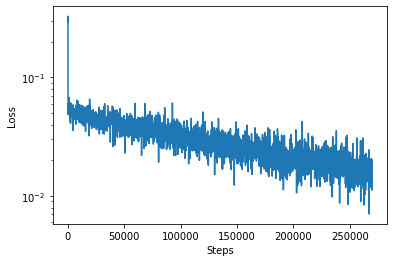

In [29]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(trainingLossesSteps)
plt.yscale('log')
plt.xlabel('Steps')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

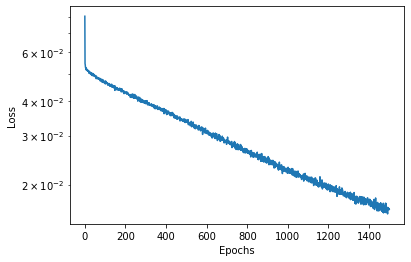

In [30]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(trainingLossesEpochs)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [28]:
for i in range(500):
    epoch +=1
    print('Epoch:',epoch+1)
    trainLoss.reset_states()
    step = 0
    for images, labels in trainDataset:
        step += 1
        #tf.summary.trace_on(graph=True, profiler=True)
        trainStep(images, labels)
        #with boardWriter.as_default(): tf.summary.trace_export( name="ResNet50", step=step, profiler_outdir=dir_log)
        print('\tStep:', str(step).zfill(3), '/', str(maxStep).zfill(3), '\tLoss:', trainLoss.result().numpy())
        trainingLossesSteps.append(trainLoss.result())
    
    if (epoch > 0):
        percDiff = (abs(trainLoss.result().numpy()-lastLoss.numpy())/((trainLoss.result().numpy()+lastLoss.numpy())/2))*100
        #if (percDiff <= 1) and (optimizer.learning_rate.numpy() > 1e-8):
            #optimizer.learning_rate = optimizer.learning_rate/10
        print('End Epoch:', epoch+1, '\t% Loss Diff:\t', percDiff,'\tLoss:', trainLoss.result().numpy(), '\tlearnRate:\t', str(optimizer.learning_rate.numpy()))
    else:
        print('End Epoch:', epoch+1, '\t% Loss Diff: NA', '\tLoss:', trainLoss.result().numpy(), '\tlearnRate:\t', str(optimizer.learning_rate.numpy()))
    lastLoss = trainLoss.result()
    trainingLossesEpochs.append(trainLoss.result())
    
    #with boardWriter.as_default(): tf.summary.scalar('Epoch Loss', trainLoss.result(), step=optimizer.iterations)
    print('\n')

Epoch: 1001
	Step: 001 / 180 	Loss: 0.020331936
	Step: 002 / 180 	Loss: 0.01739965
	Step: 003 / 180 	Loss: 0.020740414
	Step: 004 / 180 	Loss: 0.022184521
	Step: 005 / 180 	Loss: 0.023561655
	Step: 006 / 180 	Loss: 0.022904867
	Step: 007 / 180 	Loss: 0.02285391
	Step: 008 / 180 	Loss: 0.022676997
	Step: 009 / 180 	Loss: 0.02325414
	Step: 010 / 180 	Loss: 0.023716342
	Step: 011 / 180 	Loss: 0.02295532
	Step: 169 / 180 	Loss: 0.023045152
	Step: 170 / 180 	Loss: 0.023036946
	Step: 171 / 180 	Loss: 0.023036314
	Step: 172 / 180 	Loss: 0.02306395
	Step: 173 / 180 	Loss: 0.023068825
	Step: 174 / 180 	Loss: 0.023048053
	Step: 175 / 180 	Loss: 0.023159664
	Step: 176 / 180 	Loss: 0.023129227
	Step: 177 / 180 	Loss: 0.023106996
	Step: 178 / 180 	Loss: 0.023088163
	Step: 179 / 180 	Loss: 0.023060333
	Step: 180 / 180 	Loss: 0.023070937
End Epoch: 1002 	% Loss Diff:	 3.7908680297789217 	Loss: 0.023070937 	learnRate:	 1e-05


Epoch: 1003
	Step: 001 / 180 	Loss: 0.024166413
	Step: 002 / 180 	Loss: 0.0

	Step: 021 / 180 	Loss: 0.02214508
	Step: 022 / 180 	Loss: 0.022420593
	Step: 023 / 180 	Loss: 0.022188844
	Step: 024 / 180 	Loss: 0.02214914
	Step: 025 / 180 	Loss: 0.022130484
	Step: 026 / 180 	Loss: 0.022132155
	Step: 027 / 180 	Loss: 0.021919956
	Step: 028 / 180 	Loss: 0.021802396
	Step: 029 / 180 	Loss: 0.021834124
	Step: 030 / 180 	Loss: 0.021699404
	Step: 031 / 180 	Loss: 0.02170301
	Step: 032 / 180 	Loss: 0.0215334
	Step: 033 / 180 	Loss: 0.021683007
	Step: 034 / 180 	Loss: 0.021541692
	Step: 035 / 180 	Loss: 0.021561967
	Step: 036 / 180 	Loss: 0.021629471
	Step: 037 / 180 	Loss: 0.021487689
	Step: 038 / 180 	Loss: 0.021401193
	Step: 039 / 180 	Loss: 0.021550803
	Step: 040 / 180 	Loss: 0.021642068
	Step: 041 / 180 	Loss: 0.021708032
	Step: 042 / 180 	Loss: 0.021810696
	Step: 043 / 180 	Loss: 0.021806862
	Step: 044 / 180 	Loss: 0.021705028
	Step: 045 / 180 	Loss: 0.021747438
	Step: 046 / 180 	Loss: 0.021855846
	Step: 047 / 180 	Loss: 0.021819824
	Step: 048 / 180 	Loss: 0.0218372

	Step: 068 / 180 	Loss: 0.022925857
	Step: 069 / 180 	Loss: 0.022966523
	Step: 070 / 180 	Loss: 0.022945434
	Step: 071 / 180 	Loss: 0.02298376
	Step: 072 / 180 	Loss: 0.022889456
	Step: 073 / 180 	Loss: 0.022950534
	Step: 074 / 180 	Loss: 0.022919517
	Step: 075 / 180 	Loss: 0.022899354
	Step: 076 / 180 	Loss: 0.022805274
	Step: 077 / 180 	Loss: 0.022807932
	Step: 078 / 180 	Loss: 0.02284907
	Step: 079 / 180 	Loss: 0.022879906
	Step: 080 / 180 	Loss: 0.02285323
	Step: 081 / 180 	Loss: 0.022835001
	Step: 082 / 180 	Loss: 0.022877663
	Step: 083 / 180 	Loss: 0.022906102
	Step: 084 / 180 	Loss: 0.022865318
	Step: 085 / 180 	Loss: 0.022832572
	Step: 086 / 180 	Loss: 0.0228382
	Step: 087 / 180 	Loss: 0.02283773
	Step: 088 / 180 	Loss: 0.022813829
	Step: 089 / 180 	Loss: 0.022775324
	Step: 090 / 180 	Loss: 0.022736115
	Step: 091 / 180 	Loss: 0.022793217
	Step: 092 / 180 	Loss: 0.02285617
	Step: 093 / 180 	Loss: 0.0227935
	Step: 094 / 180 	Loss: 0.022775596
	Step: 095 / 180 	Loss: 0.02276821
	S

	Step: 115 / 180 	Loss: 0.022648022
	Step: 116 / 180 	Loss: 0.022716546
	Step: 117 / 180 	Loss: 0.02267538
	Step: 118 / 180 	Loss: 0.022773944
	Step: 119 / 180 	Loss: 0.022738667
	Step: 120 / 180 	Loss: 0.022749899
	Step: 121 / 180 	Loss: 0.022700943
	Step: 122 / 180 	Loss: 0.022703256
	Step: 123 / 180 	Loss: 0.022694388
	Step: 124 / 180 	Loss: 0.022728663
	Step: 125 / 180 	Loss: 0.022781081
	Step: 126 / 180 	Loss: 0.022776352
	Step: 127 / 180 	Loss: 0.022784675
	Step: 128 / 180 	Loss: 0.022799853
	Step: 129 / 180 	Loss: 0.022802949
	Step: 130 / 180 	Loss: 0.022784214
	Step: 131 / 180 	Loss: 0.02282564
	Step: 132 / 180 	Loss: 0.022805884
	Step: 133 / 180 	Loss: 0.022836812
	Step: 134 / 180 	Loss: 0.022817083
	Step: 135 / 180 	Loss: 0.022818262
	Step: 136 / 180 	Loss: 0.022799695
	Step: 137 / 180 	Loss: 0.022814669
	Step: 138 / 180 	Loss: 0.022858802
	Step: 139 / 180 	Loss: 0.02288308
	Step: 140 / 180 	Loss: 0.022878816
	Step: 141 / 180 	Loss: 0.022873998
	Step: 142 / 180 	Loss: 0.02288

	Step: 162 / 180 	Loss: 0.022027692
	Step: 163 / 180 	Loss: 0.021987401
	Step: 164 / 180 	Loss: 0.02202298
	Step: 165 / 180 	Loss: 0.022097591
	Step: 166 / 180 	Loss: 0.022114195
	Step: 167 / 180 	Loss: 0.022082685
	Step: 168 / 180 	Loss: 0.022116294
	Step: 169 / 180 	Loss: 0.022107204
	Step: 170 / 180 	Loss: 0.022099458
	Step: 171 / 180 	Loss: 0.022071218
	Step: 172 / 180 	Loss: 0.022097081
	Step: 173 / 180 	Loss: 0.022064352
	Step: 174 / 180 	Loss: 0.022050492
	Step: 175 / 180 	Loss: 0.022069221
	Step: 176 / 180 	Loss: 0.022068733
	Step: 177 / 180 	Loss: 0.022050958
	Step: 178 / 180 	Loss: 0.022039002
	Step: 179 / 180 	Loss: 0.022015624
	Step: 180 / 180 	Loss: 0.022075605
End Epoch: 1007 	% Loss Diff:	 3.082074906157952 	Loss: 0.022075605 	learnRate:	 1e-05


Epoch: 1008
	Step: 001 / 180 	Loss: 0.014706424
	Step: 002 / 180 	Loss: 0.015783947
	Step: 003 / 180 	Loss: 0.01524372
	Step: 004 / 180 	Loss: 0.016995914
	Step: 005 / 180 	Loss: 0.016683627
	Step: 006 / 180 	Loss: 0.019129045
	

	Step: 025 / 180 	Loss: 0.020932037
	Step: 026 / 180 	Loss: 0.020878205
	Step: 027 / 180 	Loss: 0.02111949
	Step: 028 / 180 	Loss: 0.020832947
	Step: 029 / 180 	Loss: 0.020941092
	Step: 030 / 180 	Loss: 0.020985175
	Step: 031 / 180 	Loss: 0.020857468
	Step: 032 / 180 	Loss: 0.020781225
	Step: 033 / 180 	Loss: 0.020772649
	Step: 034 / 180 	Loss: 0.020922594
	Step: 035 / 180 	Loss: 0.021032553
	Step: 036 / 180 	Loss: 0.020793336
	Step: 037 / 180 	Loss: 0.020936752
	Step: 038 / 180 	Loss: 0.02076388
	Step: 039 / 180 	Loss: 0.021024764
	Step: 040 / 180 	Loss: 0.021083247
	Step: 041 / 180 	Loss: 0.021037972
	Step: 042 / 180 	Loss: 0.021218391
	Step: 043 / 180 	Loss: 0.02102325
	Step: 044 / 180 	Loss: 0.020943273
	Step: 045 / 180 	Loss: 0.020971164
	Step: 046 / 180 	Loss: 0.021046469
	Step: 047 / 180 	Loss: 0.021160204
	Step: 048 / 180 	Loss: 0.021176612
	Step: 049 / 180 	Loss: 0.021398865
	Step: 050 / 180 	Loss: 0.02143263
	Step: 051 / 180 	Loss: 0.021470673
	Step: 052 / 180 	Loss: 0.021339

	Step: 072 / 180 	Loss: 0.02372847
	Step: 073 / 180 	Loss: 0.023712225
	Step: 074 / 180 	Loss: 0.023624366
	Step: 075 / 180 	Loss: 0.023514368
	Step: 076 / 180 	Loss: 0.023457462
	Step: 077 / 180 	Loss: 0.023348216
	Step: 078 / 180 	Loss: 0.02336847
	Step: 079 / 180 	Loss: 0.023413725
	Step: 080 / 180 	Loss: 0.023313712
	Step: 081 / 180 	Loss: 0.023204772
	Step: 082 / 180 	Loss: 0.023380425
	Step: 083 / 180 	Loss: 0.023471534
	Step: 084 / 180 	Loss: 0.023372313
	Step: 085 / 180 	Loss: 0.023369042
	Step: 086 / 180 	Loss: 0.023282694
	Step: 087 / 180 	Loss: 0.023192424
	Step: 088 / 180 	Loss: 0.02320245
	Step: 089 / 180 	Loss: 0.02332165
	Step: 090 / 180 	Loss: 0.023268308
	Step: 091 / 180 	Loss: 0.023352442
	Step: 092 / 180 	Loss: 0.023306994
	Step: 093 / 180 	Loss: 0.02326681
	Step: 094 / 180 	Loss: 0.02320786
	Step: 095 / 180 	Loss: 0.0232066
	Step: 096 / 180 	Loss: 0.023066834
	Step: 097 / 180 	Loss: 0.023054974
	Step: 098 / 180 	Loss: 0.0230056
	Step: 099 / 180 	Loss: 0.022957796
	S

	Step: 119 / 180 	Loss: 0.022834226
	Step: 120 / 180 	Loss: 0.022836825
	Step: 121 / 180 	Loss: 0.022804484
	Step: 122 / 180 	Loss: 0.022802021
	Step: 123 / 180 	Loss: 0.022777252
	Step: 124 / 180 	Loss: 0.022846373
	Step: 125 / 180 	Loss: 0.022849448
	Step: 126 / 180 	Loss: 0.02284697
	Step: 127 / 180 	Loss: 0.022826912
	Step: 128 / 180 	Loss: 0.022824697
	Step: 129 / 180 	Loss: 0.022851517
	Step: 130 / 180 	Loss: 0.02283794
	Step: 131 / 180 	Loss: 0.022844914
	Step: 132 / 180 	Loss: 0.022866866
	Step: 133 / 180 	Loss: 0.022872154
	Step: 134 / 180 	Loss: 0.022847502
	Step: 135 / 180 	Loss: 0.022830008
	Step: 136 / 180 	Loss: 0.022803338
	Step: 137 / 180 	Loss: 0.022809248
	Step: 138 / 180 	Loss: 0.022770826
	Step: 139 / 180 	Loss: 0.02272724
	Step: 140 / 180 	Loss: 0.022677021
	Step: 141 / 180 	Loss: 0.022707043
	Step: 142 / 180 	Loss: 0.022689173
	Step: 143 / 180 	Loss: 0.0226749
	Step: 144 / 180 	Loss: 0.02266543
	Step: 145 / 180 	Loss: 0.022667317
	Step: 146 / 180 	Loss: 0.02267133

	Step: 165 / 180 	Loss: 0.022087395
	Step: 166 / 180 	Loss: 0.022106513
	Step: 167 / 180 	Loss: 0.022089206
	Step: 168 / 180 	Loss: 0.022079727
	Step: 169 / 180 	Loss: 0.022080094
	Step: 170 / 180 	Loss: 0.022087587
	Step: 171 / 180 	Loss: 0.022066578
	Step: 172 / 180 	Loss: 0.02210604
	Step: 173 / 180 	Loss: 0.022090845
	Step: 174 / 180 	Loss: 0.022075051
	Step: 175 / 180 	Loss: 0.022067407
	Step: 176 / 180 	Loss: 0.022120733
	Step: 177 / 180 	Loss: 0.022148516
	Step: 178 / 180 	Loss: 0.022177555
	Step: 179 / 180 	Loss: 0.02219453
	Step: 180 / 180 	Loss: 0.022191754
End Epoch: 1012 	% Loss Diff:	 2.59413063332348 	Loss: 0.022191754 	learnRate:	 1e-05


Epoch: 1013
	Step: 001 / 180 	Loss: 0.027287813
	Step: 002 / 180 	Loss: 0.02369925
	Step: 003 / 180 	Loss: 0.021368861
	Step: 004 / 180 	Loss: 0.021328013
	Step: 005 / 180 	Loss: 0.022226315
	Step: 006 / 180 	Loss: 0.023166088
	Step: 007 / 180 	Loss: 0.021728415
	Step: 008 / 180 	Loss: 0.02181805
	Step: 009 / 180 	Loss: 0.022071296
	Ste

	Step: 029 / 180 	Loss: 0.021318492
	Step: 030 / 180 	Loss: 0.021238234
	Step: 031 / 180 	Loss: 0.02145005
	Step: 032 / 180 	Loss: 0.021484708
	Step: 033 / 180 	Loss: 0.021858627
	Step: 034 / 180 	Loss: 0.021813717
	Step: 035 / 180 	Loss: 0.02184262
	Step: 036 / 180 	Loss: 0.021834096
	Step: 037 / 180 	Loss: 0.021753062
	Step: 038 / 180 	Loss: 0.02162998
	Step: 039 / 180 	Loss: 0.021427125
	Step: 040 / 180 	Loss: 0.021389743
	Step: 041 / 180 	Loss: 0.021597223
	Step: 042 / 180 	Loss: 0.02169771
	Step: 043 / 180 	Loss: 0.0217863
	Step: 044 / 180 	Loss: 0.021830363
	Step: 045 / 180 	Loss: 0.021906497
	Step: 046 / 180 	Loss: 0.022179743
	Step: 047 / 180 	Loss: 0.022334034
	Step: 048 / 180 	Loss: 0.022342065
	Step: 049 / 180 	Loss: 0.022397691
	Step: 050 / 180 	Loss: 0.02230764
	Step: 051 / 180 	Loss: 0.022383926
	Step: 052 / 180 	Loss: 0.022544755
	Step: 053 / 180 	Loss: 0.022434345
	Step: 054 / 180 	Loss: 0.022343053
	Step: 055 / 180 	Loss: 0.022386512
	Step: 056 / 180 	Loss: 0.022208247

	Step: 075 / 180 	Loss: 0.022885114
	Step: 076 / 180 	Loss: 0.02299935
	Step: 077 / 180 	Loss: 0.02299342
	Step: 078 / 180 	Loss: 0.02292054
	Step: 079 / 180 	Loss: 0.022935996
	Step: 080 / 180 	Loss: 0.022890605
	Step: 081 / 180 	Loss: 0.022808114
	Step: 082 / 180 	Loss: 0.022804542
	Step: 083 / 180 	Loss: 0.022755474
	Step: 084 / 180 	Loss: 0.02275524
	Step: 085 / 180 	Loss: 0.022868562
	Step: 086 / 180 	Loss: 0.023052257
	Step: 087 / 180 	Loss: 0.02306034
	Step: 088 / 180 	Loss: 0.02303607
	Step: 089 / 180 	Loss: 0.023057735
	Step: 090 / 180 	Loss: 0.02304723
	Step: 091 / 180 	Loss: 0.023089208
	Step: 092 / 180 	Loss: 0.02306634
	Step: 093 / 180 	Loss: 0.023028769
	Step: 094 / 180 	Loss: 0.023028214
	Step: 095 / 180 	Loss: 0.023041643
	Step: 096 / 180 	Loss: 0.023101427
	Step: 097 / 180 	Loss: 0.023104614
	Step: 098 / 180 	Loss: 0.023089511
	Step: 099 / 180 	Loss: 0.02313021
	Step: 100 / 180 	Loss: 0.023105415
	Step: 101 / 180 	Loss: 0.023087522
	Step: 102 / 180 	Loss: 0.02302906
	S

	Step: 122 / 180 	Loss: 0.022661343
	Step: 123 / 180 	Loss: 0.022666996
	Step: 124 / 180 	Loss: 0.022663467
	Step: 125 / 180 	Loss: 0.02265851
	Step: 126 / 180 	Loss: 0.022657314
	Step: 127 / 180 	Loss: 0.022627762
	Step: 128 / 180 	Loss: 0.022574918
	Step: 129 / 180 	Loss: 0.022615038
	Step: 130 / 180 	Loss: 0.022612114
	Step: 131 / 180 	Loss: 0.022649549
	Step: 132 / 180 	Loss: 0.022667961
	Step: 133 / 180 	Loss: 0.022643711
	Step: 134 / 180 	Loss: 0.022637567
	Step: 135 / 180 	Loss: 0.022598062
	Step: 136 / 180 	Loss: 0.022574622
	Step: 137 / 180 	Loss: 0.022599591
	Step: 138 / 180 	Loss: 0.02256968
	Step: 139 / 180 	Loss: 0.022534026
	Step: 140 / 180 	Loss: 0.022527134
	Step: 141 / 180 	Loss: 0.022491133
	Step: 142 / 180 	Loss: 0.02253614
	Step: 143 / 180 	Loss: 0.022508055
	Step: 144 / 180 	Loss: 0.022540111
	Step: 145 / 180 	Loss: 0.022554575
	Step: 146 / 180 	Loss: 0.022617241
	Step: 147 / 180 	Loss: 0.022650044
	Step: 148 / 180 	Loss: 0.02265146
	Step: 149 / 180 	Loss: 0.022616

	Step: 168 / 180 	Loss: 0.02252539
	Step: 169 / 180 	Loss: 0.022516409
	Step: 170 / 180 	Loss: 0.022497782
	Step: 171 / 180 	Loss: 0.022538614
	Step: 172 / 180 	Loss: 0.022518532
	Step: 173 / 180 	Loss: 0.022493405
	Step: 174 / 180 	Loss: 0.022473386
	Step: 175 / 180 	Loss: 0.022465287
	Step: 176 / 180 	Loss: 0.022428151
	Step: 177 / 180 	Loss: 0.022458546
	Step: 178 / 180 	Loss: 0.022450158
	Step: 179 / 180 	Loss: 0.022411719
	Step: 180 / 180 	Loss: 0.022390509
End Epoch: 1017 	% Loss Diff:	 0.5682772834080019 	Loss: 0.022390509 	learnRate:	 1e-05


Epoch: 1018
	Step: 001 / 180 	Loss: 0.03510494
	Step: 002 / 180 	Loss: 0.028490791
	Step: 003 / 180 	Loss: 0.026182381
	Step: 004 / 180 	Loss: 0.023434088
	Step: 005 / 180 	Loss: 0.023837436
	Step: 006 / 180 	Loss: 0.022747643
	Step: 007 / 180 	Loss: 0.02248436
	Step: 008 / 180 	Loss: 0.023160448
	Step: 009 / 180 	Loss: 0.024163365
	Step: 010 / 180 	Loss: 0.023730304
	Step: 011 / 180 	Loss: 0.023599165
	Step: 012 / 180 	Loss: 0.023623636
	

	Step: 031 / 180 	Loss: 0.022079442
	Step: 032 / 180 	Loss: 0.022062948
	Step: 033 / 180 	Loss: 0.02220202
	Step: 034 / 180 	Loss: 0.022117393
	Step: 035 / 180 	Loss: 0.022155244
	Step: 036 / 180 	Loss: 0.022161817
	Step: 037 / 180 	Loss: 0.022025852
	Step: 038 / 180 	Loss: 0.02197087
	Step: 039 / 180 	Loss: 0.021829987
	Step: 040 / 180 	Loss: 0.022097714
	Step: 041 / 180 	Loss: 0.02235666
	Step: 042 / 180 	Loss: 0.02225273
	Step: 043 / 180 	Loss: 0.022152578
	Step: 044 / 180 	Loss: 0.022240283
	Step: 045 / 180 	Loss: 0.022194248
	Step: 046 / 180 	Loss: 0.022282057
	Step: 047 / 180 	Loss: 0.022162741
	Step: 048 / 180 	Loss: 0.02224564
	Step: 049 / 180 	Loss: 0.022110773
	Step: 050 / 180 	Loss: 0.022234634
	Step: 051 / 180 	Loss: 0.022182385
	Step: 052 / 180 	Loss: 0.022292623
	Step: 053 / 180 	Loss: 0.022294607
	Step: 054 / 180 	Loss: 0.022358324
	Step: 055 / 180 	Loss: 0.022243008
	Step: 056 / 180 	Loss: 0.022241727
	Step: 057 / 180 	Loss: 0.022211839
	Step: 058 / 180 	Loss: 0.0221228

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	Step: 084 / 180 	Loss: 0.020818183
	Step: 085 / 180 	Loss: 0.02084333
	Step: 086 / 180 	Loss: 0.020824017
	Step: 087 / 180 	Loss: 0.020846521
	Step: 088 / 180 	Loss: 0.02089063
	Step: 089 / 180 	Loss: 0.020865045
	Step: 090 / 180 	Loss: 0.020821394
	Step: 091 / 180 	Loss: 0.020746835
	Step: 092 / 180 	Loss: 0.020739775
	Step: 093 / 180 	Loss: 0.020753829
	Step: 094 / 180 	Loss: 0.020764379
	Step: 095 / 180 	Loss: 0.020849654
	Step: 096 / 180 	Loss: 0.020816857
	Step: 097 / 180 	Loss: 0.02095871
	Step: 098 / 180 	Loss: 0.020947797
	Step: 099 / 180 	Loss: 0.020963207
	Step: 100 / 180 	Loss: 0.020983977
	Step: 101 / 180 	Loss: 0.020970106
	Step: 102 / 180 	Loss: 0.02098463
	Step: 103 / 180 	Loss: 0.020991392
	Step: 104 / 180 	Loss: 0.020942505
	Step: 105 / 180 	Loss: 0.020927045
	Step: 106 / 180 	Loss: 0.020947162
	Step: 107 / 180 	Loss: 0.020989161
	Step: 108 / 180 	Loss: 0.020976193
	Step: 109 / 180 	Loss: 0.021053018
	Step: 110 / 180 	Loss: 0.021090092
	Step: 111 / 180 	Loss: 0.021156

	Step: 130 / 180 	Loss: 0.021564402
	Step: 131 / 180 	Loss: 0.021523038
	Step: 132 / 180 	Loss: 0.02152161
	Step: 133 / 180 	Loss: 0.021593194
	Step: 134 / 180 	Loss: 0.021584649
	Step: 135 / 180 	Loss: 0.021627463
	Step: 136 / 180 	Loss: 0.021581993
	Step: 137 / 180 	Loss: 0.021544246
	Step: 138 / 180 	Loss: 0.021496765
	Step: 139 / 180 	Loss: 0.02156746
	Step: 140 / 180 	Loss: 0.021619251
	Step: 141 / 180 	Loss: 0.021576589
	Step: 142 / 180 	Loss: 0.021576194
	Step: 143 / 180 	Loss: 0.021532957
	Step: 144 / 180 	Loss: 0.021512354
	Step: 145 / 180 	Loss: 0.021502987
	Step: 146 / 180 	Loss: 0.021449462
	Step: 147 / 180 	Loss: 0.021469286
	Step: 148 / 180 	Loss: 0.021505328
	Step: 149 / 180 	Loss: 0.021483535
	Step: 150 / 180 	Loss: 0.021470964
	Step: 151 / 180 	Loss: 0.021541487
	Step: 152 / 180 	Loss: 0.021577163
	Step: 153 / 180 	Loss: 0.021576202
	Step: 154 / 180 	Loss: 0.021598442
	Step: 155 / 180 	Loss: 0.021605695
	Step: 156 / 180 	Loss: 0.021563482
	Step: 157 / 180 	Loss: 0.0215

	Step: 176 / 180 	Loss: 0.02137548
	Step: 177 / 180 	Loss: 0.02141624
	Step: 178 / 180 	Loss: 0.02138328
	Step: 179 / 180 	Loss: 0.021353692
	Step: 180 / 180 	Loss: 0.021356773
End Epoch: 1065 	% Loss Diff:	 0.7873585490655276 	Loss: 0.021356773 	learnRate:	 1e-05


Epoch: 1066
	Step: 001 / 180 	Loss: 0.023631541
	Step: 002 / 180 	Loss: 0.020061053
	Step: 003 / 180 	Loss: 0.024164772
	Step: 004 / 180 	Loss: 0.022256853
	Step: 005 / 180 	Loss: 0.02335432
	Step: 006 / 180 	Loss: 0.023739867
	Step: 007 / 180 	Loss: 0.02231477
	Step: 008 / 180 	Loss: 0.02138625
	Step: 009 / 180 	Loss: 0.021474477
	Step: 010 / 180 	Loss: 0.021653939
	Step: 011 / 180 	Loss: 0.021361692
	Step: 012 / 180 	Loss: 0.021084605
	Step: 013 / 180 	Loss: 0.020945178
	Step: 014 / 180 	Loss: 0.021314463
	Step: 015 / 180 	Loss: 0.021035645
	Step: 016 / 180 	Loss: 0.020999689
	Step: 017 / 180 	Loss: 0.021013731
	Step: 018 / 180 	Loss: 0.020938955
	Step: 019 / 180 	Loss: 0.020701393
	Step: 020 / 180 	Loss: 0.020902466
	Ste

	Step: 040 / 180 	Loss: 0.020437876
	Step: 041 / 180 	Loss: 0.020404845
	Step: 042 / 180 	Loss: 0.020653108
	Step: 043 / 180 	Loss: 0.020571692
	Step: 044 / 180 	Loss: 0.02071027
	Step: 045 / 180 	Loss: 0.020766832
	Step: 046 / 180 	Loss: 0.020829761
	Step: 047 / 180 	Loss: 0.020826176
	Step: 048 / 180 	Loss: 0.021002442
	Step: 049 / 180 	Loss: 0.020969596
	Step: 050 / 180 	Loss: 0.020860087
	Step: 051 / 180 	Loss: 0.02100246
	Step: 052 / 180 	Loss: 0.021171676
	Step: 053 / 180 	Loss: 0.02110569
	Step: 054 / 180 	Loss: 0.021196522
	Step: 055 / 180 	Loss: 0.021207329
	Step: 056 / 180 	Loss: 0.021237414
	Step: 057 / 180 	Loss: 0.021278756
	Step: 058 / 180 	Loss: 0.021319225
	Step: 059 / 180 	Loss: 0.021229044
	Step: 060 / 180 	Loss: 0.021285532
	Step: 061 / 180 	Loss: 0.021260355
	Step: 062 / 180 	Loss: 0.021308264
	Step: 063 / 180 	Loss: 0.021305226
	Step: 064 / 180 	Loss: 0.021368828
	Step: 065 / 180 	Loss: 0.02135163
	Step: 066 / 180 	Loss: 0.021205548
	Step: 067 / 180 	Loss: 0.021163

	Step: 087 / 180 	Loss: 0.020616911
	Step: 088 / 180 	Loss: 0.020649446
	Step: 089 / 180 	Loss: 0.02062972
	Step: 090 / 180 	Loss: 0.020595158
	Step: 091 / 180 	Loss: 0.020670554
	Step: 092 / 180 	Loss: 0.020622099
	Step: 093 / 180 	Loss: 0.020750614
	Step: 094 / 180 	Loss: 0.020730786
	Step: 095 / 180 	Loss: 0.020682732
	Step: 096 / 180 	Loss: 0.02072932
	Step: 097 / 180 	Loss: 0.020693297
	Step: 098 / 180 	Loss: 0.020691857
	Step: 099 / 180 	Loss: 0.020717103
	Step: 100 / 180 	Loss: 0.02068888
	Step: 101 / 180 	Loss: 0.020906547
	Step: 102 / 180 	Loss: 0.020853333
	Step: 103 / 180 	Loss: 0.020850087
	Step: 104 / 180 	Loss: 0.020947475
	Step: 105 / 180 	Loss: 0.021003047
	Step: 106 / 180 	Loss: 0.021018798
	Step: 107 / 180 	Loss: 0.0210496
	Step: 108 / 180 	Loss: 0.021031903
	Step: 109 / 180 	Loss: 0.021053856
	Step: 110 / 180 	Loss: 0.021058293
	Step: 111 / 180 	Loss: 0.02116934
	Step: 112 / 180 	Loss: 0.021139404
	Step: 113 / 180 	Loss: 0.021131556
	Step: 114 / 180 	Loss: 0.02109668

	Step: 134 / 180 	Loss: 0.021047043
	Step: 135 / 180 	Loss: 0.021024885
	Step: 136 / 180 	Loss: 0.020998375
	Step: 137 / 180 	Loss: 0.020958792
	Step: 138 / 180 	Loss: 0.020938044
	Step: 139 / 180 	Loss: 0.02091105
	Step: 140 / 180 	Loss: 0.020880742
	Step: 141 / 180 	Loss: 0.020886485
	Step: 142 / 180 	Loss: 0.020850064
	Step: 143 / 180 	Loss: 0.02081798
	Step: 144 / 180 	Loss: 0.0208108
	Step: 145 / 180 	Loss: 0.020855026
	Step: 146 / 180 	Loss: 0.02086692
	Step: 147 / 180 	Loss: 0.020854564
	Step: 148 / 180 	Loss: 0.020854646
	Step: 149 / 180 	Loss: 0.0208528
	Step: 150 / 180 	Loss: 0.020829491
	Step: 151 / 180 	Loss: 0.02087576
	Step: 152 / 180 	Loss: 0.020893019
	Step: 153 / 180 	Loss: 0.020860735
	Step: 154 / 180 	Loss: 0.020829063
	Step: 155 / 180 	Loss: 0.020820526
	Step: 156 / 180 	Loss: 0.020877842
	Step: 157 / 180 	Loss: 0.02087304
	Step: 158 / 180 	Loss: 0.020861503
	Step: 159 / 180 	Loss: 0.020834008
	Step: 160 / 180 	Loss: 0.020834722
	Step: 161 / 180 	Loss: 0.020829955
	

	Step: 001 / 180 	Loss: 0.023251463
	Step: 002 / 180 	Loss: 0.02057215
	Step: 003 / 180 	Loss: 0.020426517
	Step: 004 / 180 	Loss: 0.020019738
	Step: 005 / 180 	Loss: 0.021328036
	Step: 006 / 180 	Loss: 0.020329414
	Step: 007 / 180 	Loss: 0.020409804
	Step: 008 / 180 	Loss: 0.021971263
	Step: 009 / 180 	Loss: 0.02157469
	Step: 010 / 180 	Loss: 0.021276299
	Step: 011 / 180 	Loss: 0.02084796
	Step: 012 / 180 	Loss: 0.020440625
	Step: 013 / 180 	Loss: 0.020168487
	Step: 014 / 180 	Loss: 0.01999529
	Step: 015 / 180 	Loss: 0.019754598
	Step: 016 / 180 	Loss: 0.02037213
	Step: 017 / 180 	Loss: 0.020170346
	Step: 018 / 180 	Loss: 0.019843081
	Step: 019 / 180 	Loss: 0.020292329
	Step: 020 / 180 	Loss: 0.020439409
	Step: 021 / 180 	Loss: 0.020697666
	Step: 022 / 180 	Loss: 0.020453326
	Step: 023 / 180 	Loss: 0.020384008
	Step: 024 / 180 	Loss: 0.020258697
	Step: 025 / 180 	Loss: 0.020186575
	Step: 026 / 180 	Loss: 0.020238
	Step: 027 / 180 	Loss: 0.02036885
	Step: 028 / 180 	Loss: 0.020345535
	

	Step: 048 / 180 	Loss: 0.021671705
	Step: 049 / 180 	Loss: 0.021661457
	Step: 050 / 180 	Loss: 0.021600764
	Step: 051 / 180 	Loss: 0.021601524
	Step: 052 / 180 	Loss: 0.021428665
	Step: 053 / 180 	Loss: 0.021458806
	Step: 054 / 180 	Loss: 0.02135884
	Step: 055 / 180 	Loss: 0.021262007
	Step: 056 / 180 	Loss: 0.021232586
	Step: 057 / 180 	Loss: 0.021140296
	Step: 058 / 180 	Loss: 0.02108984
	Step: 059 / 180 	Loss: 0.02112631
	Step: 060 / 180 	Loss: 0.02116139
	Step: 061 / 180 	Loss: 0.02120875
	Step: 062 / 180 	Loss: 0.021159947
	Step: 063 / 180 	Loss: 0.021100562
	Step: 064 / 180 	Loss: 0.021129474
	Step: 065 / 180 	Loss: 0.02125107
	Step: 066 / 180 	Loss: 0.02117444
	Step: 067 / 180 	Loss: 0.021142364
	Step: 068 / 180 	Loss: 0.021187533
	Step: 069 / 180 	Loss: 0.021176228
	Step: 070 / 180 	Loss: 0.021234393
	Step: 071 / 180 	Loss: 0.021224916
	Step: 072 / 180 	Loss: 0.021212546
	Step: 073 / 180 	Loss: 0.021240603
	Step: 074 / 180 	Loss: 0.021219777
	Step: 075 / 180 	Loss: 0.02114415


	Step: 095 / 180 	Loss: 0.020778101
	Step: 096 / 180 	Loss: 0.020793034
	Step: 097 / 180 	Loss: 0.020871352
	Step: 098 / 180 	Loss: 0.020831902
	Step: 099 / 180 	Loss: 0.02092635
	Step: 100 / 180 	Loss: 0.020898335
	Step: 101 / 180 	Loss: 0.020818198
	Step: 102 / 180 	Loss: 0.020815497
	Step: 103 / 180 	Loss: 0.020853044
	Step: 104 / 180 	Loss: 0.02082612
	Step: 105 / 180 	Loss: 0.020822598
	Step: 106 / 180 	Loss: 0.020803314
	Step: 107 / 180 	Loss: 0.020818908
	Step: 108 / 180 	Loss: 0.020818524
	Step: 109 / 180 	Loss: 0.020790465
	Step: 110 / 180 	Loss: 0.02081984
	Step: 111 / 180 	Loss: 0.020819752
	Step: 112 / 180 	Loss: 0.020788785
	Step: 113 / 180 	Loss: 0.020778503
	Step: 114 / 180 	Loss: 0.020833503
	Step: 115 / 180 	Loss: 0.020844
	Step: 116 / 180 	Loss: 0.02086902
	Step: 117 / 180 	Loss: 0.020881865
	Step: 118 / 180 	Loss: 0.020886697
	Step: 119 / 180 	Loss: 0.020888032
	Step: 120 / 180 	Loss: 0.0209061
	Step: 121 / 180 	Loss: 0.020964645
	Step: 122 / 180 	Loss: 0.021009168
	

	Step: 142 / 180 	Loss: 0.020781254
	Step: 143 / 180 	Loss: 0.020765489
	Step: 144 / 180 	Loss: 0.020753821
	Step: 145 / 180 	Loss: 0.02077053
	Step: 146 / 180 	Loss: 0.020788796
	Step: 147 / 180 	Loss: 0.020786166
	Step: 148 / 180 	Loss: 0.02078348
	Step: 149 / 180 	Loss: 0.020776348
	Step: 150 / 180 	Loss: 0.02081837
	Step: 151 / 180 	Loss: 0.020830708
	Step: 152 / 180 	Loss: 0.020867622
	Step: 153 / 180 	Loss: 0.020865925
	Step: 154 / 180 	Loss: 0.020899184
	Step: 155 / 180 	Loss: 0.020879926
	Step: 156 / 180 	Loss: 0.020908307
	Step: 157 / 180 	Loss: 0.020881768
	Step: 158 / 180 	Loss: 0.020846466
	Step: 159 / 180 	Loss: 0.02085584
	Step: 160 / 180 	Loss: 0.020864585
	Step: 161 / 180 	Loss: 0.020901099
	Step: 162 / 180 	Loss: 0.020897489
	Step: 163 / 180 	Loss: 0.020880757
	Step: 164 / 180 	Loss: 0.02089718
	Step: 165 / 180 	Loss: 0.020925837
	Step: 166 / 180 	Loss: 0.020911407
	Step: 167 / 180 	Loss: 0.02093409
	Step: 168 / 180 	Loss: 0.020995587
	Step: 169 / 180 	Loss: 0.02100911

	Step: 006 / 180 	Loss: 0.023650482
	Step: 007 / 180 	Loss: 0.023086991
	Step: 008 / 180 	Loss: 0.022772012
	Step: 009 / 180 	Loss: 0.021952827
	Step: 010 / 180 	Loss: 0.021928925
	Step: 011 / 180 	Loss: 0.021109546
	Step: 012 / 180 	Loss: 0.021500928
	Step: 013 / 180 	Loss: 0.022019774
	Step: 014 / 180 	Loss: 0.022296945
	Step: 015 / 180 	Loss: 0.022050586
	Step: 016 / 180 	Loss: 0.021668727
	Step: 017 / 180 	Loss: 0.021306332
	Step: 018 / 180 	Loss: 0.021410368
	Step: 019 / 180 	Loss: 0.021671051
	Step: 020 / 180 	Loss: 0.021229679
	Step: 021 / 180 	Loss: 0.021167506
	Step: 022 / 180 	Loss: 0.021061206
	Step: 023 / 180 	Loss: 0.021022901
	Step: 024 / 180 	Loss: 0.020628402
	Step: 025 / 180 	Loss: 0.020595727
	Step: 026 / 180 	Loss: 0.020734532
	Step: 027 / 180 	Loss: 0.020498522
	Step: 028 / 180 	Loss: 0.020462045
	Step: 029 / 180 	Loss: 0.020672493
	Step: 030 / 180 	Loss: 0.02047025
	Step: 031 / 180 	Loss: 0.020181915
	Step: 032 / 180 	Loss: 0.02004735
	Step: 033 / 180 	Loss: 0.0199

	Step: 052 / 180 	Loss: 0.022133986
	Step: 053 / 180 	Loss: 0.022047708
	Step: 054 / 180 	Loss: 0.022120642
	Step: 055 / 180 	Loss: 0.022360109
	Step: 056 / 180 	Loss: 0.022264404
	Step: 057 / 180 	Loss: 0.02225289
	Step: 058 / 180 	Loss: 0.02228452
	Step: 059 / 180 	Loss: 0.022203656
	Step: 060 / 180 	Loss: 0.022184957
	Step: 061 / 180 	Loss: 0.022099905
	Step: 062 / 180 	Loss: 0.0220677
	Step: 063 / 180 	Loss: 0.02206232
	Step: 064 / 180 	Loss: 0.0222311
	Step: 065 / 180 	Loss: 0.022256704
	Step: 066 / 180 	Loss: 0.022241225
	Step: 067 / 180 	Loss: 0.022197466
	Step: 068 / 180 	Loss: 0.022199921
	Step: 069 / 180 	Loss: 0.022226812
	Step: 070 / 180 	Loss: 0.02214999
	Step: 071 / 180 	Loss: 0.02221742
	Step: 072 / 180 	Loss: 0.022140227
	Step: 073 / 180 	Loss: 0.022291532
	Step: 074 / 180 	Loss: 0.022167504
	Step: 075 / 180 	Loss: 0.022108242
	Step: 076 / 180 	Loss: 0.022062048
	Step: 077 / 180 	Loss: 0.022021629
	Step: 078 / 180 	Loss: 0.021973008
	Step: 079 / 180 	Loss: 0.021962056
	

	Step: 098 / 180 	Loss: 0.0222528
	Step: 099 / 180 	Loss: 0.022308506
	Step: 100 / 180 	Loss: 0.022252763
	Step: 101 / 180 	Loss: 0.022197764
	Step: 102 / 180 	Loss: 0.022155873
	Step: 103 / 180 	Loss: 0.022127438
	Step: 104 / 180 	Loss: 0.022156764
	Step: 105 / 180 	Loss: 0.022116166
	Step: 106 / 180 	Loss: 0.022128155
	Step: 107 / 180 	Loss: 0.02210891
	Step: 108 / 180 	Loss: 0.02211564
	Step: 109 / 180 	Loss: 0.022105714
	Step: 110 / 180 	Loss: 0.022182753
	Step: 111 / 180 	Loss: 0.022174656
	Step: 112 / 180 	Loss: 0.022145793
	Step: 113 / 180 	Loss: 0.022147749
	Step: 114 / 180 	Loss: 0.02211591
	Step: 115 / 180 	Loss: 0.02204488
	Step: 116 / 180 	Loss: 0.022021472
	Step: 117 / 180 	Loss: 0.021994822
	Step: 118 / 180 	Loss: 0.021988122
	Step: 119 / 180 	Loss: 0.02201756
	Step: 120 / 180 	Loss: 0.022073694
	Step: 121 / 180 	Loss: 0.022053845
	Step: 122 / 180 	Loss: 0.022035921
	Step: 123 / 180 	Loss: 0.022081932
	Step: 124 / 180 	Loss: 0.02209798
	Step: 125 / 180 	Loss: 0.022079812


	Step: 145 / 180 	Loss: 0.02078012
	Step: 146 / 180 	Loss: 0.020739643
	Step: 147 / 180 	Loss: 0.020741612
	Step: 148 / 180 	Loss: 0.020712368
	Step: 149 / 180 	Loss: 0.020735139
	Step: 150 / 180 	Loss: 0.02073135
	Step: 151 / 180 	Loss: 0.020713354
	Step: 152 / 180 	Loss: 0.020693332
	Step: 153 / 180 	Loss: 0.020728676
	Step: 154 / 180 	Loss: 0.02076321
	Step: 155 / 180 	Loss: 0.020801237
	Step: 156 / 180 	Loss: 0.02078515
	Step: 157 / 180 	Loss: 0.020747492
	Step: 158 / 180 	Loss: 0.020716123
	Step: 159 / 180 	Loss: 0.020684917
	Step: 160 / 180 	Loss: 0.020657498
	Step: 161 / 180 	Loss: 0.020613225
	Step: 162 / 180 	Loss: 0.020645218
	Step: 163 / 180 	Loss: 0.020651372
	Step: 164 / 180 	Loss: 0.020664947
	Step: 165 / 180 	Loss: 0.02065139
	Step: 166 / 180 	Loss: 0.020707473
	Step: 167 / 180 	Loss: 0.020681536
	Step: 168 / 180 	Loss: 0.020710243
	Step: 169 / 180 	Loss: 0.020706477
	Step: 170 / 180 	Loss: 0.020671815
	Step: 171 / 180 	Loss: 0.02067658
	Step: 172 / 180 	Loss: 0.02064287

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	Step: 018 / 180 	Loss: 0.020364631
	Step: 019 / 180 	Loss: 0.020255947
	Step: 020 / 180 	Loss: 0.02045648
	Step: 021 / 180 	Loss: 0.020074865
	Step: 022 / 180 	Loss: 0.020107478
	Step: 023 / 180 	Loss: 0.020000353
	Step: 024 / 180 	Loss: 0.020107362
	Step: 025 / 180 	Loss: 0.020135393
	Step: 026 / 180 	Loss: 0.020095997
	Step: 027 / 180 	Loss: 0.020078877
	Step: 028 / 180 	Loss: 0.019947663
	Step: 029 / 180 	Loss: 0.020010114
	Step: 030 / 180 	Loss: 0.019957561
	Step: 031 / 180 	Loss: 0.019978998
	Step: 032 / 180 	Loss: 0.019896396
	Step: 033 / 180 	Loss: 0.020053593
	Step: 034 / 180 	Loss: 0.019881045
	Step: 035 / 180 	Loss: 0.019948686
	Step: 036 / 180 	Loss: 0.020077437
	Step: 037 / 180 	Loss: 0.020027611
	Step: 038 / 180 	Loss: 0.0200735
	Step: 039 / 180 	Loss: 0.019869665
	Step: 040 / 180 	Loss: 0.019966882
	Step: 041 / 180 	Loss: 0.02040921
	Step: 042 / 180 	Loss: 0.020266475
	Step: 043 / 180 	Loss: 0.0202479
	Step: 044 / 180 	Loss: 0.02046936
	Step: 045 / 180 	Loss: 0.020414902

	Step: 065 / 180 	Loss: 0.020252848
	Step: 066 / 180 	Loss: 0.02025193
	Step: 067 / 180 	Loss: 0.020298336
	Step: 068 / 180 	Loss: 0.020329848
	Step: 069 / 180 	Loss: 0.020282544
	Step: 070 / 180 	Loss: 0.020288754
	Step: 071 / 180 	Loss: 0.020220373
	Step: 072 / 180 	Loss: 0.020221233
	Step: 073 / 180 	Loss: 0.020192537
	Step: 074 / 180 	Loss: 0.020209525
	Step: 075 / 180 	Loss: 0.020295663
	Step: 076 / 180 	Loss: 0.02030736
	Step: 077 / 180 	Loss: 0.02036003
	Step: 078 / 180 	Loss: 0.020418886
	Step: 079 / 180 	Loss: 0.020381905
	Step: 080 / 180 	Loss: 0.020395542
	Step: 081 / 180 	Loss: 0.020433217
	Step: 082 / 180 	Loss: 0.020449312
	Step: 083 / 180 	Loss: 0.020493709
	Step: 084 / 180 	Loss: 0.020575501
	Step: 085 / 180 	Loss: 0.020621903
	Step: 086 / 180 	Loss: 0.020566793
	Step: 087 / 180 	Loss: 0.020552134
	Step: 088 / 180 	Loss: 0.020549277
	Step: 089 / 180 	Loss: 0.020550158
	Step: 090 / 180 	Loss: 0.020482276
	Step: 091 / 180 	Loss: 0.020522248
	Step: 092 / 180 	Loss: 0.02051

	Step: 111 / 180 	Loss: 0.020367056
	Step: 112 / 180 	Loss: 0.020353688
	Step: 113 / 180 	Loss: 0.020350143
	Step: 114 / 180 	Loss: 0.020381922
	Step: 115 / 180 	Loss: 0.02043478
	Step: 116 / 180 	Loss: 0.020483607
	Step: 117 / 180 	Loss: 0.020466754
	Step: 118 / 180 	Loss: 0.020496525
	Step: 119 / 180 	Loss: 0.020472376
	Step: 120 / 180 	Loss: 0.020500988
	Step: 121 / 180 	Loss: 0.020534275
	Step: 122 / 180 	Loss: 0.020507867
	Step: 123 / 180 	Loss: 0.020549238
	Step: 124 / 180 	Loss: 0.02058447
	Step: 125 / 180 	Loss: 0.02058772
	Step: 126 / 180 	Loss: 0.02056525
	Step: 127 / 180 	Loss: 0.020510174
	Step: 128 / 180 	Loss: 0.020528324
	Step: 129 / 180 	Loss: 0.020564588
	Step: 130 / 180 	Loss: 0.020602377
	Step: 131 / 180 	Loss: 0.020666843
	Step: 132 / 180 	Loss: 0.020670198
	Step: 133 / 180 	Loss: 0.020654416
	Step: 134 / 180 	Loss: 0.02070632
	Step: 135 / 180 	Loss: 0.020722838
	Step: 136 / 180 	Loss: 0.020689495
	Step: 137 / 180 	Loss: 0.020739976
	Step: 138 / 180 	Loss: 0.0207691

	Step: 157 / 180 	Loss: 0.021375144
	Step: 158 / 180 	Loss: 0.021365263
	Step: 159 / 180 	Loss: 0.021335997
	Step: 160 / 180 	Loss: 0.02134522
	Step: 161 / 180 	Loss: 0.021301879
	Step: 162 / 180 	Loss: 0.021291848
	Step: 163 / 180 	Loss: 0.021271208
	Step: 164 / 180 	Loss: 0.021239426
	Step: 165 / 180 	Loss: 0.02121829
	Step: 166 / 180 	Loss: 0.021207461
	Step: 167 / 180 	Loss: 0.021174483
	Step: 168 / 180 	Loss: 0.021137835
	Step: 169 / 180 	Loss: 0.02110167
	Step: 170 / 180 	Loss: 0.021084743
	Step: 171 / 180 	Loss: 0.021071045
	Step: 172 / 180 	Loss: 0.021049518
	Step: 173 / 180 	Loss: 0.02103456
	Step: 174 / 180 	Loss: 0.021017404
	Step: 175 / 180 	Loss: 0.02101742
	Step: 176 / 180 	Loss: 0.020987375
	Step: 177 / 180 	Loss: 0.020957088
	Step: 178 / 180 	Loss: 0.020896973
	Step: 179 / 180 	Loss: 0.02086907
	Step: 180 / 180 	Loss: 0.02091478
End Epoch: 1125 	% Loss Diff:	 0.16867747551502646 	Loss: 0.02091478 	learnRate:	 1e-05


Epoch: 1126
	Step: 001 / 180 	Loss: 0.022002345
	Step

	Step: 021 / 180 	Loss: 0.020306831
	Step: 022 / 180 	Loss: 0.020484317
	Step: 023 / 180 	Loss: 0.02067979
	Step: 024 / 180 	Loss: 0.020607835
	Step: 025 / 180 	Loss: 0.020663295
	Step: 026 / 180 	Loss: 0.020589981
	Step: 027 / 180 	Loss: 0.020723866
	Step: 028 / 180 	Loss: 0.020758796
	Step: 029 / 180 	Loss: 0.020765515
	Step: 030 / 180 	Loss: 0.020852039
	Step: 031 / 180 	Loss: 0.02078409
	Step: 032 / 180 	Loss: 0.020708513
	Step: 033 / 180 	Loss: 0.020502364
	Step: 034 / 180 	Loss: 0.020610416
	Step: 035 / 180 	Loss: 0.02065794
	Step: 036 / 180 	Loss: 0.02080985
	Step: 037 / 180 	Loss: 0.020816496
	Step: 038 / 180 	Loss: 0.021008821
	Step: 039 / 180 	Loss: 0.020922227
	Step: 040 / 180 	Loss: 0.021028211
	Step: 041 / 180 	Loss: 0.021080106
	Step: 042 / 180 	Loss: 0.021128127
	Step: 043 / 180 	Loss: 0.021280674
	Step: 044 / 180 	Loss: 0.02135679
	Step: 045 / 180 	Loss: 0.021337222
	Step: 046 / 180 	Loss: 0.021305751
	Step: 047 / 180 	Loss: 0.021295832
	Step: 048 / 180 	Loss: 0.0212584

	Step: 068 / 180 	Loss: 0.020385671
	Step: 069 / 180 	Loss: 0.020307805
	Step: 070 / 180 	Loss: 0.02034333
	Step: 071 / 180 	Loss: 0.020357683
	Step: 072 / 180 	Loss: 0.020407584
	Step: 073 / 180 	Loss: 0.02063675
	Step: 074 / 180 	Loss: 0.02058998
	Step: 075 / 180 	Loss: 0.020482961
	Step: 076 / 180 	Loss: 0.020601813
	Step: 077 / 180 	Loss: 0.020645494
	Step: 078 / 180 	Loss: 0.02059151
	Step: 079 / 180 	Loss: 0.020661492
	Step: 080 / 180 	Loss: 0.02064161
	Step: 081 / 180 	Loss: 0.020659013
	Step: 082 / 180 	Loss: 0.020612545
	Step: 083 / 180 	Loss: 0.020640558
	Step: 084 / 180 	Loss: 0.02058957
	Step: 085 / 180 	Loss: 0.020567507
	Step: 086 / 180 	Loss: 0.020586424
	Step: 087 / 180 	Loss: 0.02055311
	Step: 088 / 180 	Loss: 0.020533575
	Step: 089 / 180 	Loss: 0.020523647
	Step: 090 / 180 	Loss: 0.020527747
	Step: 091 / 180 	Loss: 0.02044445
	Step: 092 / 180 	Loss: 0.020401934
	Step: 093 / 180 	Loss: 0.020465607
	Step: 094 / 180 	Loss: 0.020427462
	Step: 095 / 180 	Loss: 0.020389616


	Step: 115 / 180 	Loss: 0.02104346
	Step: 116 / 180 	Loss: 0.021010803
	Step: 117 / 180 	Loss: 0.021027682
	Step: 118 / 180 	Loss: 0.021010788
	Step: 119 / 180 	Loss: 0.020997422
	Step: 120 / 180 	Loss: 0.021014938
	Step: 121 / 180 	Loss: 0.020975383
	Step: 122 / 180 	Loss: 0.020980781
	Step: 123 / 180 	Loss: 0.0209767
	Step: 124 / 180 	Loss: 0.020942952
	Step: 125 / 180 	Loss: 0.020964162
	Step: 126 / 180 	Loss: 0.020873891
	Step: 127 / 180 	Loss: 0.020828057
	Step: 128 / 180 	Loss: 0.020863153
	Step: 129 / 180 	Loss: 0.020845411
	Step: 130 / 180 	Loss: 0.020814385
	Step: 131 / 180 	Loss: 0.02078318
	Step: 132 / 180 	Loss: 0.020870438
	Step: 133 / 180 	Loss: 0.02080511
	Step: 134 / 180 	Loss: 0.02078292
	Step: 135 / 180 	Loss: 0.020772474
	Step: 136 / 180 	Loss: 0.020738306
	Step: 137 / 180 	Loss: 0.020742616
	Step: 138 / 180 	Loss: 0.020696575
	Step: 139 / 180 	Loss: 0.020657897
	Step: 140 / 180 	Loss: 0.020702774
	Step: 141 / 180 	Loss: 0.020741493
	Step: 142 / 180 	Loss: 0.02079635

	Step: 161 / 180 	Loss: 0.0201762
	Step: 162 / 180 	Loss: 0.020171013
	Step: 163 / 180 	Loss: 0.020177262
	Step: 164 / 180 	Loss: 0.02017369
	Step: 165 / 180 	Loss: 0.020209923
	Step: 166 / 180 	Loss: 0.020168388
	Step: 167 / 180 	Loss: 0.02017766
	Step: 168 / 180 	Loss: 0.02015135
	Step: 169 / 180 	Loss: 0.020106038
	Step: 170 / 180 	Loss: 0.020093266
	Step: 171 / 180 	Loss: 0.020090753
	Step: 172 / 180 	Loss: 0.020079268
	Step: 173 / 180 	Loss: 0.0200655
	Step: 174 / 180 	Loss: 0.020052467
	Step: 175 / 180 	Loss: 0.020115424
	Step: 176 / 180 	Loss: 0.02011277
	Step: 177 / 180 	Loss: 0.020109054
	Step: 178 / 180 	Loss: 0.02011579
	Step: 179 / 180 	Loss: 0.020110168
	Step: 180 / 180 	Loss: 0.020090064
End Epoch: 1130 	% Loss Diff:	 3.9905562363350655 	Loss: 0.020090064 	learnRate:	 1e-05


Epoch: 1131
	Step: 001 / 180 	Loss: 0.020993013
	Step: 002 / 180 	Loss: 0.018901307
	Step: 003 / 180 	Loss: 0.018953072
	Step: 004 / 180 	Loss: 0.018580887
	Step: 005 / 180 	Loss: 0.018048653
	Step: 

	Step: 025 / 180 	Loss: 0.018804971
	Step: 026 / 180 	Loss: 0.019151334
	Step: 027 / 180 	Loss: 0.019176899
	Step: 028 / 180 	Loss: 0.019148272
	Step: 029 / 180 	Loss: 0.019024989
	Step: 030 / 180 	Loss: 0.018982908
	Step: 031 / 180 	Loss: 0.019149767
	Step: 032 / 180 	Loss: 0.019171385
	Step: 033 / 180 	Loss: 0.019319156
	Step: 034 / 180 	Loss: 0.019210188
	Step: 035 / 180 	Loss: 0.019287825
	Step: 036 / 180 	Loss: 0.019292332
	Step: 037 / 180 	Loss: 0.019287203
	Step: 038 / 180 	Loss: 0.019415678
	Step: 039 / 180 	Loss: 0.01950966
	Step: 040 / 180 	Loss: 0.019498054
	Step: 041 / 180 	Loss: 0.019725764
	Step: 042 / 180 	Loss: 0.019639084
	Step: 043 / 180 	Loss: 0.0196751
	Step: 044 / 180 	Loss: 0.01975541
	Step: 045 / 180 	Loss: 0.019813815
	Step: 046 / 180 	Loss: 0.019941587
	Step: 047 / 180 	Loss: 0.019906407
	Step: 048 / 180 	Loss: 0.020255914
	Step: 049 / 180 	Loss: 0.020208258
	Step: 050 / 180 	Loss: 0.020176163
	Step: 051 / 180 	Loss: 0.020157639
	Step: 052 / 180 	Loss: 0.020194

	Step: 072 / 180 	Loss: 0.020874202
	Step: 073 / 180 	Loss: 0.021017643
	Step: 074 / 180 	Loss: 0.021025958
	Step: 075 / 180 	Loss: 0.02100707
	Step: 076 / 180 	Loss: 0.021011135
	Step: 077 / 180 	Loss: 0.020950185
	Step: 078 / 180 	Loss: 0.020976035
	Step: 079 / 180 	Loss: 0.020908179
	Step: 080 / 180 	Loss: 0.02085869
	Step: 081 / 180 	Loss: 0.020869624
	Step: 082 / 180 	Loss: 0.02092478
	Step: 083 / 180 	Loss: 0.02097634
	Step: 084 / 180 	Loss: 0.020922441
	Step: 085 / 180 	Loss: 0.020916196
	Step: 086 / 180 	Loss: 0.020853065
	Step: 087 / 180 	Loss: 0.02095102
	Step: 088 / 180 	Loss: 0.02095729
	Step: 089 / 180 	Loss: 0.021081794
	Step: 090 / 180 	Loss: 0.02112018
	Step: 091 / 180 	Loss: 0.021052752
	Step: 092 / 180 	Loss: 0.021061232
	Step: 093 / 180 	Loss: 0.021043746
	Step: 094 / 180 	Loss: 0.021157354
	Step: 095 / 180 	Loss: 0.021156652
	Step: 096 / 180 	Loss: 0.021161253
	Step: 097 / 180 	Loss: 0.02111872
	Step: 098 / 180 	Loss: 0.021100124
	Step: 099 / 180 	Loss: 0.02104881
	

	Step: 119 / 180 	Loss: 0.021329366
	Step: 120 / 180 	Loss: 0.021288566
	Step: 121 / 180 	Loss: 0.02125455
	Step: 122 / 180 	Loss: 0.021199293
	Step: 123 / 180 	Loss: 0.02120488
	Step: 124 / 180 	Loss: 0.021212852
	Step: 125 / 180 	Loss: 0.021212948
	Step: 126 / 180 	Loss: 0.021237873
	Step: 127 / 180 	Loss: 0.021217274
	Step: 128 / 180 	Loss: 0.021183884
	Step: 129 / 180 	Loss: 0.021154895
	Step: 130 / 180 	Loss: 0.021140475
	Step: 131 / 180 	Loss: 0.021118404
	Step: 132 / 180 	Loss: 0.021144003
	Step: 133 / 180 	Loss: 0.02118713
	Step: 134 / 180 	Loss: 0.021157099
	Step: 135 / 180 	Loss: 0.02115348
	Step: 136 / 180 	Loss: 0.021142015
	Step: 137 / 180 	Loss: 0.021141358
	Step: 138 / 180 	Loss: 0.021071373
	Step: 139 / 180 	Loss: 0.021077653
	Step: 140 / 180 	Loss: 0.021098997
	Step: 141 / 180 	Loss: 0.02109606
	Step: 142 / 180 	Loss: 0.02108539
	Step: 143 / 180 	Loss: 0.021110442
	Step: 144 / 180 	Loss: 0.021081699
	Step: 145 / 180 	Loss: 0.021104572
	Step: 146 / 180 	Loss: 0.02115903

	Step: 166 / 180 	Loss: 0.020092497
	Step: 167 / 180 	Loss: 0.020076822
	Step: 168 / 180 	Loss: 0.020112777
	Step: 169 / 180 	Loss: 0.020092636
	Step: 170 / 180 	Loss: 0.020099286
	Step: 171 / 180 	Loss: 0.020046154
	Step: 172 / 180 	Loss: 0.020083092
	Step: 173 / 180 	Loss: 0.020045012
	Step: 174 / 180 	Loss: 0.020062417
	Step: 175 / 180 	Loss: 0.020059776
	Step: 176 / 180 	Loss: 0.020045884
	Step: 177 / 180 	Loss: 0.020021915
	Step: 178 / 180 	Loss: 0.019997124
	Step: 179 / 180 	Loss: 0.019986944
	Step: 180 / 180 	Loss: 0.019999556
End Epoch: 1135 	% Loss Diff:	 5.271112415287005 	Loss: 0.019999556 	learnRate:	 1e-05


Epoch: 1136
	Step: 001 / 180 	Loss: 0.028723761
	Step: 002 / 180 	Loss: 0.026086899
	Step: 003 / 180 	Loss: 0.025987253
	Step: 004 / 180 	Loss: 0.024475263
	Step: 005 / 180 	Loss: 0.024071198
	Step: 006 / 180 	Loss: 0.024127813
	Step: 007 / 180 	Loss: 0.02454816
	Step: 008 / 180 	Loss: 0.023514144
	Step: 009 / 180 	Loss: 0.023001578
	Step: 010 / 180 	Loss: 0.023271458


	Step: 030 / 180 	Loss: 0.021017943
	Step: 031 / 180 	Loss: 0.021165531
	Step: 032 / 180 	Loss: 0.021577248
	Step: 033 / 180 	Loss: 0.021629471
	Step: 034 / 180 	Loss: 0.02153627
	Step: 035 / 180 	Loss: 0.021468673
	Step: 036 / 180 	Loss: 0.02157033
	Step: 037 / 180 	Loss: 0.02153932
	Step: 038 / 180 	Loss: 0.02152025
	Step: 039 / 180 	Loss: 0.02139038
	Step: 040 / 180 	Loss: 0.021481015
	Step: 041 / 180 	Loss: 0.021392511
	Step: 042 / 180 	Loss: 0.021213248
	Step: 043 / 180 	Loss: 0.021256337
	Step: 044 / 180 	Loss: 0.021374257
	Step: 045 / 180 	Loss: 0.021328254
	Step: 046 / 180 	Loss: 0.021296069
	Step: 047 / 180 	Loss: 0.021332346
	Step: 048 / 180 	Loss: 0.02133095
	Step: 049 / 180 	Loss: 0.021335052
	Step: 050 / 180 	Loss: 0.021323664
	Step: 051 / 180 	Loss: 0.021302288
	Step: 052 / 180 	Loss: 0.021304796
	Step: 053 / 180 	Loss: 0.02145192
	Step: 054 / 180 	Loss: 0.021330928
	Step: 055 / 180 	Loss: 0.02128889
	Step: 056 / 180 	Loss: 0.021272685
	Step: 057 / 180 	Loss: 0.021427616


	Step: 076 / 180 	Loss: 0.019374818
	Step: 077 / 180 	Loss: 0.019383699
	Step: 078 / 180 	Loss: 0.019366171
	Step: 079 / 180 	Loss: 0.019391023
	Step: 080 / 180 	Loss: 0.019435622
	Step: 081 / 180 	Loss: 0.019431146
	Step: 082 / 180 	Loss: 0.019471176
	Step: 083 / 180 	Loss: 0.01973529
	Step: 084 / 180 	Loss: 0.019646332
	Step: 085 / 180 	Loss: 0.019679751
	Step: 086 / 180 	Loss: 0.019702397
	Step: 087 / 180 	Loss: 0.01978812
	Step: 088 / 180 	Loss: 0.0198883
	Step: 089 / 180 	Loss: 0.019927032
	Step: 090 / 180 	Loss: 0.01994505
	Step: 091 / 180 	Loss: 0.019986805
	Step: 092 / 180 	Loss: 0.0199521
	Step: 093 / 180 	Loss: 0.019930648
	Step: 094 / 180 	Loss: 0.019966492
	Step: 095 / 180 	Loss: 0.019970477
	Step: 096 / 180 	Loss: 0.019941596
	Step: 097 / 180 	Loss: 0.019966055
	Step: 098 / 180 	Loss: 0.019892385
	Step: 099 / 180 	Loss: 0.019851385
	Step: 100 / 180 	Loss: 0.019845719
	Step: 101 / 180 	Loss: 0.019868733
	Step: 102 / 180 	Loss: 0.019828921
	Step: 103 / 180 	Loss: 0.019853737

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	Step: 173 / 180 	Loss: 0.019655539
	Step: 174 / 180 	Loss: 0.019654037
	Step: 175 / 180 	Loss: 0.019649386
	Step: 176 / 180 	Loss: 0.019653093
	Step: 177 / 180 	Loss: 0.019634917
	Step: 178 / 180 	Loss: 0.019634105
	Step: 179 / 180 	Loss: 0.01960577
	Step: 180 / 180 	Loss: 0.019587176
End Epoch: 1181 	% Loss Diff:	 3.4195617976372854 	Loss: 0.019587176 	learnRate:	 1e-05


Epoch: 1182
	Step: 001 / 180 	Loss: 0.019979095
	Step: 002 / 180 	Loss: 0.018758979
	Step: 003 / 180 	Loss: 0.019854004
	Step: 004 / 180 	Loss: 0.018263957
	Step: 005 / 180 	Loss: 0.019975957
	Step: 006 / 180 	Loss: 0.019500067
	Step: 007 / 180 	Loss: 0.0191106
	Step: 008 / 180 	Loss: 0.018478833
	Step: 009 / 180 	Loss: 0.018780828
	Step: 010 / 180 	Loss: 0.018655071
	Step: 011 / 180 	Loss: 0.0184316
	Step: 012 / 180 	Loss: 0.018632978
	Step: 013 / 180 	Loss: 0.018881064
	Step: 014 / 180 	Loss: 0.018544776
	Step: 015 / 180 	Loss: 0.018640654
	Step: 016 / 180 	Loss: 0.01843063
	Step: 017 / 180 	Loss: 0.018273067
	Ste

	Step: 037 / 180 	Loss: 0.01888764
	Step: 038 / 180 	Loss: 0.019110251
	Step: 039 / 180 	Loss: 0.01897732
	Step: 040 / 180 	Loss: 0.019006044
	Step: 041 / 180 	Loss: 0.018999437
	Step: 042 / 180 	Loss: 0.01890794
	Step: 043 / 180 	Loss: 0.019099444
	Step: 044 / 180 	Loss: 0.019186957
	Step: 045 / 180 	Loss: 0.01898921
	Step: 046 / 180 	Loss: 0.019096375
	Step: 047 / 180 	Loss: 0.01929327
	Step: 048 / 180 	Loss: 0.019355966
	Step: 049 / 180 	Loss: 0.019365214
	Step: 050 / 180 	Loss: 0.019234039
	Step: 051 / 180 	Loss: 0.019228103
	Step: 052 / 180 	Loss: 0.019277165
	Step: 053 / 180 	Loss: 0.019418238
	Step: 054 / 180 	Loss: 0.019612657
	Step: 055 / 180 	Loss: 0.01966902
	Step: 056 / 180 	Loss: 0.019709032
	Step: 057 / 180 	Loss: 0.019566327
	Step: 058 / 180 	Loss: 0.019529216
	Step: 059 / 180 	Loss: 0.01942022
	Step: 060 / 180 	Loss: 0.019489117
	Step: 061 / 180 	Loss: 0.019463604
	Step: 062 / 180 	Loss: 0.019392597
	Step: 063 / 180 	Loss: 0.019374305
	Step: 064 / 180 	Loss: 0.019390918

	Step: 084 / 180 	Loss: 0.020173516
	Step: 085 / 180 	Loss: 0.020143785
	Step: 086 / 180 	Loss: 0.020153122
	Step: 087 / 180 	Loss: 0.020112136
	Step: 088 / 180 	Loss: 0.020056367
	Step: 089 / 180 	Loss: 0.020017521
	Step: 090 / 180 	Loss: 0.020045154
	Step: 091 / 180 	Loss: 0.020278143
	Step: 092 / 180 	Loss: 0.020243403
	Step: 093 / 180 	Loss: 0.02029144
	Step: 094 / 180 	Loss: 0.020305743
	Step: 095 / 180 	Loss: 0.020256544
	Step: 096 / 180 	Loss: 0.020241631
	Step: 097 / 180 	Loss: 0.020227205
	Step: 098 / 180 	Loss: 0.020184368
	Step: 099 / 180 	Loss: 0.02020234
	Step: 100 / 180 	Loss: 0.02018009
	Step: 101 / 180 	Loss: 0.020179756
	Step: 102 / 180 	Loss: 0.020193378
	Step: 103 / 180 	Loss: 0.020284215
	Step: 104 / 180 	Loss: 0.020273346
	Step: 105 / 180 	Loss: 0.020414747
	Step: 106 / 180 	Loss: 0.020399693
	Step: 107 / 180 	Loss: 0.020392053
	Step: 108 / 180 	Loss: 0.02039227
	Step: 109 / 180 	Loss: 0.020370923
	Step: 110 / 180 	Loss: 0.02046928
	Step: 111 / 180 	Loss: 0.0204413

	Step: 130 / 180 	Loss: 0.019525552
	Step: 131 / 180 	Loss: 0.01949632
	Step: 132 / 180 	Loss: 0.019457998
	Step: 133 / 180 	Loss: 0.019429699
	Step: 134 / 180 	Loss: 0.019416837
	Step: 135 / 180 	Loss: 0.019422308
	Step: 136 / 180 	Loss: 0.019405292
	Step: 137 / 180 	Loss: 0.019377923
	Step: 138 / 180 	Loss: 0.01937459
	Step: 139 / 180 	Loss: 0.019395145
	Step: 140 / 180 	Loss: 0.019388165
	Step: 141 / 180 	Loss: 0.019349296
	Step: 142 / 180 	Loss: 0.019342007
	Step: 143 / 180 	Loss: 0.019396348
	Step: 144 / 180 	Loss: 0.019392816
	Step: 145 / 180 	Loss: 0.01937677
	Step: 146 / 180 	Loss: 0.019388687
	Step: 147 / 180 	Loss: 0.019378806
	Step: 148 / 180 	Loss: 0.019391762
	Step: 149 / 180 	Loss: 0.019340228
	Step: 150 / 180 	Loss: 0.01935571
	Step: 151 / 180 	Loss: 0.019415027
	Step: 152 / 180 	Loss: 0.019421455
	Step: 153 / 180 	Loss: 0.019439342
	Step: 154 / 180 	Loss: 0.019422285
	Step: 155 / 180 	Loss: 0.01942809
	Step: 156 / 180 	Loss: 0.0194586
	Step: 157 / 180 	Loss: 0.019508282

	Step: 176 / 180 	Loss: 0.019987395
	Step: 177 / 180 	Loss: 0.019965395
	Step: 178 / 180 	Loss: 0.019960588
	Step: 179 / 180 	Loss: 0.019975038
	Step: 180 / 180 	Loss: 0.019969774
End Epoch: 1186 	% Loss Diff:	 1.929635719492143 	Loss: 0.019969774 	learnRate:	 1e-05


Epoch: 1187
	Step: 001 / 180 	Loss: 0.017886722
	Step: 002 / 180 	Loss: 0.016826065
	Step: 003 / 180 	Loss: 0.02063443
	Step: 004 / 180 	Loss: 0.02026095
	Step: 005 / 180 	Loss: 0.02047178
	Step: 006 / 180 	Loss: 0.020602575
	Step: 007 / 180 	Loss: 0.020735694
	Step: 008 / 180 	Loss: 0.020035617
	Step: 009 / 180 	Loss: 0.01935441
	Step: 010 / 180 	Loss: 0.019582
	Step: 011 / 180 	Loss: 0.019678645
	Step: 012 / 180 	Loss: 0.019577079
	Step: 013 / 180 	Loss: 0.019769073
	Step: 014 / 180 	Loss: 0.019637002
	Step: 015 / 180 	Loss: 0.01927068
	Step: 016 / 180 	Loss: 0.019093731
	Step: 017 / 180 	Loss: 0.01931745
	Step: 018 / 180 	Loss: 0.019521164
	Step: 019 / 180 	Loss: 0.019339059
	Step: 020 / 180 	Loss: 0.019128945
	Step: 0

	Step: 040 / 180 	Loss: 0.020820018
	Step: 041 / 180 	Loss: 0.020693649
	Step: 042 / 180 	Loss: 0.020582927
	Step: 043 / 180 	Loss: 0.020648194
	Step: 044 / 180 	Loss: 0.020617962
	Step: 045 / 180 	Loss: 0.020695914
	Step: 046 / 180 	Loss: 0.020541886
	Step: 047 / 180 	Loss: 0.020569747
	Step: 048 / 180 	Loss: 0.020550566
	Step: 049 / 180 	Loss: 0.020660244
	Step: 050 / 180 	Loss: 0.020555481
	Step: 051 / 180 	Loss: 0.020491496
	Step: 052 / 180 	Loss: 0.020454386
	Step: 053 / 180 	Loss: 0.020422654
	Step: 054 / 180 	Loss: 0.020431293
	Step: 055 / 180 	Loss: 0.02051204
	Step: 056 / 180 	Loss: 0.020505646
	Step: 057 / 180 	Loss: 0.020413807
	Step: 058 / 180 	Loss: 0.02061734
	Step: 059 / 180 	Loss: 0.020700615
	Step: 060 / 180 	Loss: 0.02085575
	Step: 061 / 180 	Loss: 0.020780621
	Step: 062 / 180 	Loss: 0.020657942
	Step: 063 / 180 	Loss: 0.020673877
	Step: 064 / 180 	Loss: 0.020750374
	Step: 065 / 180 	Loss: 0.020675896
	Step: 066 / 180 	Loss: 0.020646678
	Step: 067 / 180 	Loss: 0.02061

	Step: 086 / 180 	Loss: 0.019823378
	Step: 087 / 180 	Loss: 0.019803656
	Step: 088 / 180 	Loss: 0.019783156
	Step: 089 / 180 	Loss: 0.019758677
	Step: 090 / 180 	Loss: 0.019709947
	Step: 091 / 180 	Loss: 0.019756513
	Step: 092 / 180 	Loss: 0.019732296
	Step: 093 / 180 	Loss: 0.01967066
	Step: 094 / 180 	Loss: 0.019679196
	Step: 095 / 180 	Loss: 0.01972523
	Step: 096 / 180 	Loss: 0.019745769
	Step: 097 / 180 	Loss: 0.019672407
	Step: 098 / 180 	Loss: 0.019679965
	Step: 099 / 180 	Loss: 0.019664757
	Step: 100 / 180 	Loss: 0.019696288
	Step: 101 / 180 	Loss: 0.019685406
	Step: 102 / 180 	Loss: 0.019671222
	Step: 103 / 180 	Loss: 0.01962278
	Step: 104 / 180 	Loss: 0.019636946
	Step: 105 / 180 	Loss: 0.01962367
	Step: 106 / 180 	Loss: 0.019619256
	Step: 107 / 180 	Loss: 0.019725958
	Step: 108 / 180 	Loss: 0.01974876
	Step: 109 / 180 	Loss: 0.019715916
	Step: 110 / 180 	Loss: 0.019680385
	Step: 111 / 180 	Loss: 0.019607157
	Step: 112 / 180 	Loss: 0.019613683
	Step: 113 / 180 	Loss: 0.0195828

	Step: 132 / 180 	Loss: 0.019988447
	Step: 133 / 180 	Loss: 0.020001588
	Step: 134 / 180 	Loss: 0.019983953
	Step: 135 / 180 	Loss: 0.019989006
	Step: 136 / 180 	Loss: 0.02005681
	Step: 137 / 180 	Loss: 0.020051096
	Step: 138 / 180 	Loss: 0.020096328
	Step: 139 / 180 	Loss: 0.020065896
	Step: 140 / 180 	Loss: 0.020059435
	Step: 141 / 180 	Loss: 0.020013627
	Step: 142 / 180 	Loss: 0.019976638
	Step: 143 / 180 	Loss: 0.01995511
	Step: 144 / 180 	Loss: 0.020027434
	Step: 145 / 180 	Loss: 0.020008435
	Step: 146 / 180 	Loss: 0.019986345
	Step: 147 / 180 	Loss: 0.019959908
	Step: 148 / 180 	Loss: 0.019945726
	Step: 149 / 180 	Loss: 0.01996904
	Step: 150 / 180 	Loss: 0.019948661
	Step: 151 / 180 	Loss: 0.019941786
	Step: 152 / 180 	Loss: 0.019931788
	Step: 153 / 180 	Loss: 0.019903725
	Step: 154 / 180 	Loss: 0.019890724
	Step: 155 / 180 	Loss: 0.019903328
	Step: 156 / 180 	Loss: 0.019908993
	Step: 157 / 180 	Loss: 0.019887827
	Step: 158 / 180 	Loss: 0.019860195
	Step: 159 / 180 	Loss: 0.01982

	Step: 178 / 180 	Loss: 0.019984476
	Step: 179 / 180 	Loss: 0.019981824
	Step: 180 / 180 	Loss: 0.01996704
End Epoch: 1191 	% Loss Diff:	 0.17779309858021353 	Loss: 0.01996704 	learnRate:	 1e-05


Epoch: 1192
	Step: 001 / 180 	Loss: 0.021047577
	Step: 002 / 180 	Loss: 0.020642769
	Step: 003 / 180 	Loss: 0.021954462
	Step: 004 / 180 	Loss: 0.021324867
	Step: 005 / 180 	Loss: 0.020111186
	Step: 006 / 180 	Loss: 0.018956343
	Step: 007 / 180 	Loss: 0.01920555
	Step: 008 / 180 	Loss: 0.018901134
	Step: 009 / 180 	Loss: 0.0188987
	Step: 010 / 180 	Loss: 0.01910916
	Step: 011 / 180 	Loss: 0.018560521
	Step: 012 / 180 	Loss: 0.018586054
	Step: 013 / 180 	Loss: 0.018467484
	Step: 014 / 180 	Loss: 0.018166825
	Step: 015 / 180 	Loss: 0.017900348
	Step: 016 / 180 	Loss: 0.018464226
	Step: 017 / 180 	Loss: 0.01846005
	Step: 018 / 180 	Loss: 0.018503364
	Step: 019 / 180 	Loss: 0.018385893
	Step: 020 / 180 	Loss: 0.018406797
	Step: 021 / 180 	Loss: 0.018947648
	Step: 022 / 180 	Loss: 0.018870847
	Ste

	Step: 042 / 180 	Loss: 0.0195793
	Step: 043 / 180 	Loss: 0.019623505
	Step: 044 / 180 	Loss: 0.019638913
	Step: 045 / 180 	Loss: 0.01954663
	Step: 046 / 180 	Loss: 0.019484181
	Step: 047 / 180 	Loss: 0.01953333
	Step: 048 / 180 	Loss: 0.019633317
	Step: 049 / 180 	Loss: 0.019599289
	Step: 050 / 180 	Loss: 0.019692168
	Step: 051 / 180 	Loss: 0.019738246
	Step: 052 / 180 	Loss: 0.01968171
	Step: 053 / 180 	Loss: 0.019617619
	Step: 054 / 180 	Loss: 0.01947365
	Step: 055 / 180 	Loss: 0.019481715
	Step: 056 / 180 	Loss: 0.019348593
	Step: 057 / 180 	Loss: 0.01927874
	Step: 058 / 180 	Loss: 0.019232346
	Step: 059 / 180 	Loss: 0.019117096
	Step: 060 / 180 	Loss: 0.019201078
	Step: 061 / 180 	Loss: 0.019115616
	Step: 062 / 180 	Loss: 0.019119626
	Step: 063 / 180 	Loss: 0.019160965
	Step: 064 / 180 	Loss: 0.019132616
	Step: 065 / 180 	Loss: 0.019066786
	Step: 066 / 180 	Loss: 0.019153638
	Step: 067 / 180 	Loss: 0.019183794
	Step: 068 / 180 	Loss: 0.019282367
	Step: 069 / 180 	Loss: 0.019233895

	Step: 089 / 180 	Loss: 0.019168511
	Step: 090 / 180 	Loss: 0.019131543
	Step: 091 / 180 	Loss: 0.019153012
	Step: 092 / 180 	Loss: 0.019072065
	Step: 093 / 180 	Loss: 0.019128086
	Step: 094 / 180 	Loss: 0.019144079
	Step: 095 / 180 	Loss: 0.019199219
	Step: 096 / 180 	Loss: 0.019213121
	Step: 097 / 180 	Loss: 0.019172454
	Step: 098 / 180 	Loss: 0.01926273
	Step: 099 / 180 	Loss: 0.01925316
	Step: 100 / 180 	Loss: 0.019174045
	Step: 101 / 180 	Loss: 0.019128837
	Step: 102 / 180 	Loss: 0.019060032
	Step: 103 / 180 	Loss: 0.019111497
	Step: 104 / 180 	Loss: 0.019156981
	Step: 105 / 180 	Loss: 0.01914741
	Step: 106 / 180 	Loss: 0.019092513
	Step: 107 / 180 	Loss: 0.019069731
	Step: 108 / 180 	Loss: 0.019067798
	Step: 109 / 180 	Loss: 0.01904448
	Step: 110 / 180 	Loss: 0.019021163
	Step: 111 / 180 	Loss: 0.01898319
	Step: 112 / 180 	Loss: 0.019042026
	Step: 113 / 180 	Loss: 0.019075207
	Step: 114 / 180 	Loss: 0.019059416
	Step: 115 / 180 	Loss: 0.019101223
	Step: 116 / 180 	Loss: 0.0191382

	Step: 135 / 180 	Loss: 0.019166213
	Step: 136 / 180 	Loss: 0.019165691
	Step: 137 / 180 	Loss: 0.019174585
	Step: 138 / 180 	Loss: 0.019185727
	Step: 139 / 180 	Loss: 0.019197302
	Step: 140 / 180 	Loss: 0.019183895
	Step: 141 / 180 	Loss: 0.019195128
	Step: 142 / 180 	Loss: 0.01917026
	Step: 143 / 180 	Loss: 0.01915001
	Step: 144 / 180 	Loss: 0.01913929
	Step: 145 / 180 	Loss: 0.019136658
	Step: 146 / 180 	Loss: 0.019157387
	Step: 147 / 180 	Loss: 0.019151226
	Step: 148 / 180 	Loss: 0.019148352
	Step: 149 / 180 	Loss: 0.019173855
	Step: 150 / 180 	Loss: 0.01916608
	Step: 151 / 180 	Loss: 0.019153742
	Step: 152 / 180 	Loss: 0.01911427
	Step: 153 / 180 	Loss: 0.019111056
	Step: 154 / 180 	Loss: 0.01908743
	Step: 155 / 180 	Loss: 0.01912484
	Step: 156 / 180 	Loss: 0.019114008
	Step: 157 / 180 	Loss: 0.019134512
	Step: 158 / 180 	Loss: 0.019141672
	Step: 159 / 180 	Loss: 0.019152429
	Step: 160 / 180 	Loss: 0.019132463
	Step: 161 / 180 	Loss: 0.019180415
	Step: 162 / 180 	Loss: 0.019211471

	Step: 001 / 180 	Loss: 0.022576386
	Step: 002 / 180 	Loss: 0.021251306
	Step: 003 / 180 	Loss: 0.020733321
	Step: 004 / 180 	Loss: 0.019420525
	Step: 005 / 180 	Loss: 0.018443977
	Step: 006 / 180 	Loss: 0.017841564
	Step: 007 / 180 	Loss: 0.0178097
	Step: 008 / 180 	Loss: 0.020086186
	Step: 009 / 180 	Loss: 0.019778242
	Step: 010 / 180 	Loss: 0.01943918
	Step: 011 / 180 	Loss: 0.019556107
	Step: 012 / 180 	Loss: 0.019926893
	Step: 013 / 180 	Loss: 0.020086344
	Step: 014 / 180 	Loss: 0.019910833
	Step: 015 / 180 	Loss: 0.02024011
	Step: 016 / 180 	Loss: 0.019840186
	Step: 017 / 180 	Loss: 0.020236064
	Step: 018 / 180 	Loss: 0.020976862
	Step: 019 / 180 	Loss: 0.020860916
	Step: 020 / 180 	Loss: 0.020672284
	Step: 021 / 180 	Loss: 0.020717831
	Step: 022 / 180 	Loss: 0.020963829
	Step: 023 / 180 	Loss: 0.020960568
	Step: 024 / 180 	Loss: 0.020704849
	Step: 025 / 180 	Loss: 0.020694654
	Step: 026 / 180 	Loss: 0.02087909
	Step: 027 / 180 	Loss: 0.02056593
	Step: 028 / 180 	Loss: 0.02044862

	Step: 048 / 180 	Loss: 0.02009109
	Step: 049 / 180 	Loss: 0.020155065
	Step: 050 / 180 	Loss: 0.02019403
	Step: 051 / 180 	Loss: 0.020321324
	Step: 052 / 180 	Loss: 0.020211227
	Step: 053 / 180 	Loss: 0.020102328
	Step: 054 / 180 	Loss: 0.020213725
	Step: 055 / 180 	Loss: 0.02014682
	Step: 056 / 180 	Loss: 0.020240726
	Step: 057 / 180 	Loss: 0.020338029
	Step: 058 / 180 	Loss: 0.020229897
	Step: 059 / 180 	Loss: 0.02010112
	Step: 060 / 180 	Loss: 0.02012071
	Step: 061 / 180 	Loss: 0.020042676
	Step: 062 / 180 	Loss: 0.020261932
	Step: 063 / 180 	Loss: 0.02017176
	Step: 064 / 180 	Loss: 0.02026816
	Step: 065 / 180 	Loss: 0.020245677
	Step: 066 / 180 	Loss: 0.020309728
	Step: 067 / 180 	Loss: 0.020215029
	Step: 068 / 180 	Loss: 0.020220708
	Step: 069 / 180 	Loss: 0.020203518
	Step: 070 / 180 	Loss: 0.020148247
	Step: 071 / 180 	Loss: 0.02005174
	Step: 072 / 180 	Loss: 0.02011336
	Step: 073 / 180 	Loss: 0.020140782
	Step: 074 / 180 	Loss: 0.020156221
	Step: 075 / 180 	Loss: 0.020128086
	

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	Step: 130 / 180 	Loss: 0.01892848
	Step: 131 / 180 	Loss: 0.018902175
	Step: 132 / 180 	Loss: 0.018891878
	Step: 133 / 180 	Loss: 0.01886414
	Step: 134 / 180 	Loss: 0.018868534
	Step: 135 / 180 	Loss: 0.018831879
	Step: 136 / 180 	Loss: 0.018875597
	Step: 137 / 180 	Loss: 0.018856656
	Step: 138 / 180 	Loss: 0.018922595
	Step: 139 / 180 	Loss: 0.018972434
	Step: 140 / 180 	Loss: 0.018900711
	Step: 141 / 180 	Loss: 0.018863598
	Step: 142 / 180 	Loss: 0.018860387
	Step: 143 / 180 	Loss: 0.018855905
	Step: 144 / 180 	Loss: 0.018861534
	Step: 145 / 180 	Loss: 0.018838853
	Step: 146 / 180 	Loss: 0.018801723
	Step: 147 / 180 	Loss: 0.018804783
	Step: 148 / 180 	Loss: 0.018770814
	Step: 149 / 180 	Loss: 0.018741947
	Step: 150 / 180 	Loss: 0.018797424
	Step: 151 / 180 	Loss: 0.01879774
	Step: 152 / 180 	Loss: 0.018796181
	Step: 153 / 180 	Loss: 0.018781664
	Step: 154 / 180 	Loss: 0.018808214
	Step: 155 / 180 	Loss: 0.018786283
	Step: 156 / 180 	Loss: 0.018810743
	Step: 157 / 180 	Loss: 0.01881

	Step: 177 / 180 	Loss: 0.019113597
	Step: 178 / 180 	Loss: 0.019123957
	Step: 179 / 180 	Loss: 0.019111233
	Step: 180 / 180 	Loss: 0.0191207
End Epoch: 1241 	% Loss Diff:	 1.3308962627956744 	Loss: 0.0191207 	learnRate:	 1e-05


Epoch: 1242
	Step: 001 / 180 	Loss: 0.015949264
	Step: 002 / 180 	Loss: 0.018935293
	Step: 003 / 180 	Loss: 0.017651767
	Step: 004 / 180 	Loss: 0.017822132
	Step: 005 / 180 	Loss: 0.018575707
	Step: 006 / 180 	Loss: 0.018323487
	Step: 007 / 180 	Loss: 0.017997643
	Step: 008 / 180 	Loss: 0.017924538
	Step: 009 / 180 	Loss: 0.01816381
	Step: 010 / 180 	Loss: 0.017569784
	Step: 011 / 180 	Loss: 0.017485876
	Step: 012 / 180 	Loss: 0.016822362
	Step: 013 / 180 	Loss: 0.01761869
	Step: 014 / 180 	Loss: 0.017654685
	Step: 015 / 180 	Loss: 0.017396957
	Step: 016 / 180 	Loss: 0.01778223
	Step: 017 / 180 	Loss: 0.017900705
	Step: 018 / 180 	Loss: 0.017907018
	Step: 019 / 180 	Loss: 0.017866291
	Step: 020 / 180 	Loss: 0.017875198
	Step: 021 / 180 	Loss: 0.017633881
	Step

	Step: 041 / 180 	Loss: 0.018702902
	Step: 042 / 180 	Loss: 0.018614676
	Step: 043 / 180 	Loss: 0.018812777
	Step: 044 / 180 	Loss: 0.018894093
	Step: 045 / 180 	Loss: 0.018859483
	Step: 046 / 180 	Loss: 0.018927585
	Step: 047 / 180 	Loss: 0.018983275
	Step: 048 / 180 	Loss: 0.018962355
	Step: 049 / 180 	Loss: 0.018998902
	Step: 050 / 180 	Loss: 0.018959023
	Step: 051 / 180 	Loss: 0.018837743
	Step: 052 / 180 	Loss: 0.018904153
	Step: 053 / 180 	Loss: 0.018821321
	Step: 054 / 180 	Loss: 0.018670654
	Step: 055 / 180 	Loss: 0.018762182
	Step: 056 / 180 	Loss: 0.018745085
	Step: 057 / 180 	Loss: 0.018647047
	Step: 058 / 180 	Loss: 0.018625675
	Step: 059 / 180 	Loss: 0.01861038
	Step: 060 / 180 	Loss: 0.01873465
	Step: 061 / 180 	Loss: 0.018656695
	Step: 062 / 180 	Loss: 0.018604707
	Step: 063 / 180 	Loss: 0.018587308
	Step: 064 / 180 	Loss: 0.01859835
	Step: 065 / 180 	Loss: 0.01873942
	Step: 066 / 180 	Loss: 0.018704053
	Step: 067 / 180 	Loss: 0.018722432
	Step: 068 / 180 	Loss: 0.018810

	Step: 088 / 180 	Loss: 0.018806297
	Step: 089 / 180 	Loss: 0.01874476
	Step: 090 / 180 	Loss: 0.01873874
	Step: 091 / 180 	Loss: 0.01876831
	Step: 092 / 180 	Loss: 0.018720914
	Step: 093 / 180 	Loss: 0.018800186
	Step: 094 / 180 	Loss: 0.018860923
	Step: 095 / 180 	Loss: 0.018910136
	Step: 096 / 180 	Loss: 0.018949777
	Step: 097 / 180 	Loss: 0.018980514
	Step: 098 / 180 	Loss: 0.01901095
	Step: 099 / 180 	Loss: 0.019089488
	Step: 100 / 180 	Loss: 0.019095726
	Step: 101 / 180 	Loss: 0.019114096
	Step: 102 / 180 	Loss: 0.019068124
	Step: 103 / 180 	Loss: 0.019082211
	Step: 104 / 180 	Loss: 0.019103471
	Step: 105 / 180 	Loss: 0.019140579
	Step: 106 / 180 	Loss: 0.019165197
	Step: 107 / 180 	Loss: 0.019144159
	Step: 108 / 180 	Loss: 0.019090973
	Step: 109 / 180 	Loss: 0.019165952
	Step: 110 / 180 	Loss: 0.019159291
	Step: 111 / 180 	Loss: 0.019126054
	Step: 112 / 180 	Loss: 0.019101363
	Step: 113 / 180 	Loss: 0.01912753
	Step: 114 / 180 	Loss: 0.019205881
	Step: 115 / 180 	Loss: 0.0192394

	Step: 134 / 180 	Loss: 0.018878436
	Step: 135 / 180 	Loss: 0.018872628
	Step: 136 / 180 	Loss: 0.018843
	Step: 137 / 180 	Loss: 0.018840449
	Step: 138 / 180 	Loss: 0.018790351
	Step: 139 / 180 	Loss: 0.018830277
	Step: 140 / 180 	Loss: 0.018787712
	Step: 141 / 180 	Loss: 0.018741462
	Step: 142 / 180 	Loss: 0.018709365
	Step: 143 / 180 	Loss: 0.018766828
	Step: 144 / 180 	Loss: 0.018766997
	Step: 145 / 180 	Loss: 0.018727923
	Step: 146 / 180 	Loss: 0.018724598
	Step: 147 / 180 	Loss: 0.018729975
	Step: 148 / 180 	Loss: 0.0187576
	Step: 149 / 180 	Loss: 0.018741807
	Step: 150 / 180 	Loss: 0.0187901
	Step: 151 / 180 	Loss: 0.018791232
	Step: 152 / 180 	Loss: 0.018812813
	Step: 153 / 180 	Loss: 0.018801922
	Step: 154 / 180 	Loss: 0.018795304
	Step: 155 / 180 	Loss: 0.01882737
	Step: 156 / 180 	Loss: 0.018817065
	Step: 157 / 180 	Loss: 0.01885422
	Step: 158 / 180 	Loss: 0.018841451
	Step: 159 / 180 	Loss: 0.018872352
	Step: 160 / 180 	Loss: 0.0188554
	Step: 161 / 180 	Loss: 0.018816544
	St

	Step: 001 / 180 	Loss: 0.017923819
	Step: 002 / 180 	Loss: 0.021405686
	Step: 003 / 180 	Loss: 0.020467678
	Step: 004 / 180 	Loss: 0.019769263
	Step: 005 / 180 	Loss: 0.019048657
	Step: 006 / 180 	Loss: 0.018530749
	Step: 007 / 180 	Loss: 0.018308545
	Step: 008 / 180 	Loss: 0.018507563
	Step: 009 / 180 	Loss: 0.019685851
	Step: 010 / 180 	Loss: 0.019209493
	Step: 011 / 180 	Loss: 0.018895077
	Step: 012 / 180 	Loss: 0.01866973
	Step: 013 / 180 	Loss: 0.018320005
	Step: 014 / 180 	Loss: 0.017872604
	Step: 015 / 180 	Loss: 0.017816152
	Step: 016 / 180 	Loss: 0.018143062
	Step: 017 / 180 	Loss: 0.018004559
	Step: 018 / 180 	Loss: 0.017861355
	Step: 019 / 180 	Loss: 0.017741047
	Step: 020 / 180 	Loss: 0.017933723
	Step: 021 / 180 	Loss: 0.017782172
	Step: 022 / 180 	Loss: 0.018171132
	Step: 023 / 180 	Loss: 0.017950173
	Step: 024 / 180 	Loss: 0.018038128
	Step: 025 / 180 	Loss: 0.01796629
	Step: 026 / 180 	Loss: 0.017923202
	Step: 027 / 180 	Loss: 0.017780028
	Step: 028 / 180 	Loss: 0.0178

	Step: 047 / 180 	Loss: 0.01954918
	Step: 048 / 180 	Loss: 0.019587241
	Step: 049 / 180 	Loss: 0.019535363
	Step: 050 / 180 	Loss: 0.019395005
	Step: 051 / 180 	Loss: 0.019402571
	Step: 052 / 180 	Loss: 0.019361245
	Step: 053 / 180 	Loss: 0.019256592
	Step: 054 / 180 	Loss: 0.019310229
	Step: 055 / 180 	Loss: 0.019358808
	Step: 056 / 180 	Loss: 0.019231826
	Step: 057 / 180 	Loss: 0.019232916
	Step: 058 / 180 	Loss: 0.019246463
	Step: 059 / 180 	Loss: 0.0192136
	Step: 060 / 180 	Loss: 0.019135179
	Step: 061 / 180 	Loss: 0.01908482
	Step: 062 / 180 	Loss: 0.019110791
	Step: 063 / 180 	Loss: 0.019271486
	Step: 064 / 180 	Loss: 0.01937269
	Step: 065 / 180 	Loss: 0.019322196
	Step: 066 / 180 	Loss: 0.019277232
	Step: 067 / 180 	Loss: 0.019170145
	Step: 068 / 180 	Loss: 0.019131063
	Step: 069 / 180 	Loss: 0.019141693
	Step: 070 / 180 	Loss: 0.019046681
	Step: 071 / 180 	Loss: 0.019034803
	Step: 072 / 180 	Loss: 0.01909689
	Step: 073 / 180 	Loss: 0.019132592
	Step: 074 / 180 	Loss: 0.01915424

	Step: 094 / 180 	Loss: 0.019403683
	Step: 095 / 180 	Loss: 0.019367192
	Step: 096 / 180 	Loss: 0.019321267
	Step: 097 / 180 	Loss: 0.019283263
	Step: 098 / 180 	Loss: 0.019230759
	Step: 099 / 180 	Loss: 0.019184126
	Step: 100 / 180 	Loss: 0.01917065
	Step: 101 / 180 	Loss: 0.019134665
	Step: 102 / 180 	Loss: 0.019129023
	Step: 103 / 180 	Loss: 0.01912856
	Step: 104 / 180 	Loss: 0.019109357
	Step: 105 / 180 	Loss: 0.019095048
	Step: 106 / 180 	Loss: 0.019039404
	Step: 107 / 180 	Loss: 0.019091435
	Step: 108 / 180 	Loss: 0.019064276
	Step: 109 / 180 	Loss: 0.019162344
	Step: 110 / 180 	Loss: 0.019173764
	Step: 111 / 180 	Loss: 0.019094266
	Step: 112 / 180 	Loss: 0.019107446
	Step: 113 / 180 	Loss: 0.019135093
	Step: 114 / 180 	Loss: 0.019059354
	Step: 115 / 180 	Loss: 0.019000828
	Step: 116 / 180 	Loss: 0.018966682
	Step: 117 / 180 	Loss: 0.01893959
	Step: 118 / 180 	Loss: 0.01891384
	Step: 119 / 180 	Loss: 0.01888996
	Step: 120 / 180 	Loss: 0.018873075
	Step: 121 / 180 	Loss: 0.0188581

	Step: 140 / 180 	Loss: 0.019201534
	Step: 141 / 180 	Loss: 0.01919323
	Step: 142 / 180 	Loss: 0.019272624
	Step: 143 / 180 	Loss: 0.019374562
	Step: 144 / 180 	Loss: 0.01939138
	Step: 145 / 180 	Loss: 0.019396469
	Step: 146 / 180 	Loss: 0.019371822
	Step: 147 / 180 	Loss: 0.019346103
	Step: 148 / 180 	Loss: 0.01930651
	Step: 149 / 180 	Loss: 0.019304417
	Step: 150 / 180 	Loss: 0.019311385
	Step: 151 / 180 	Loss: 0.019311665
	Step: 152 / 180 	Loss: 0.019318786
	Step: 153 / 180 	Loss: 0.019280298
	Step: 154 / 180 	Loss: 0.019292882
	Step: 155 / 180 	Loss: 0.019249914
	Step: 156 / 180 	Loss: 0.01923069
	Step: 157 / 180 	Loss: 0.019246109
	Step: 158 / 180 	Loss: 0.019236984
	Step: 159 / 180 	Loss: 0.019215597
	Step: 160 / 180 	Loss: 0.019182006
	Step: 161 / 180 	Loss: 0.019217806
	Step: 162 / 180 	Loss: 0.019199098
	Step: 163 / 180 	Loss: 0.01920342
	Step: 164 / 180 	Loss: 0.01922651
	Step: 165 / 180 	Loss: 0.019270832
	Step: 166 / 180 	Loss: 0.019263618
	Step: 167 / 180 	Loss: 0.01922654

	Step: 004 / 180 	Loss: 0.016767666
	Step: 005 / 180 	Loss: 0.017406696
	Step: 006 / 180 	Loss: 0.01782184
	Step: 007 / 180 	Loss: 0.017901586
	Step: 008 / 180 	Loss: 0.018807236
	Step: 009 / 180 	Loss: 0.018586557
	Step: 010 / 180 	Loss: 0.018687833
	Step: 011 / 180 	Loss: 0.018201206
	Step: 012 / 180 	Loss: 0.01820528
	Step: 013 / 180 	Loss: 0.018287886
	Step: 014 / 180 	Loss: 0.018300423
	Step: 015 / 180 	Loss: 0.018706627
	Step: 016 / 180 	Loss: 0.018696235
	Step: 017 / 180 	Loss: 0.018723637
	Step: 018 / 180 	Loss: 0.018654147
	Step: 019 / 180 	Loss: 0.01840879
	Step: 020 / 180 	Loss: 0.018532198
	Step: 021 / 180 	Loss: 0.018617842
	Step: 022 / 180 	Loss: 0.018589236
	Step: 023 / 180 	Loss: 0.018330736
	Step: 024 / 180 	Loss: 0.018377323
	Step: 025 / 180 	Loss: 0.01844126
	Step: 026 / 180 	Loss: 0.018641507
	Step: 027 / 180 	Loss: 0.018475406
	Step: 028 / 180 	Loss: 0.018561548
	Step: 029 / 180 	Loss: 0.018706638
	Step: 030 / 180 	Loss: 0.018691441
	Step: 031 / 180 	Loss: 0.018688

	Step: 051 / 180 	Loss: 0.0198681
	Step: 052 / 180 	Loss: 0.019771673
	Step: 053 / 180 	Loss: 0.019678386
	Step: 054 / 180 	Loss: 0.019735744
	Step: 055 / 180 	Loss: 0.019633876
	Step: 056 / 180 	Loss: 0.019553825
	Step: 057 / 180 	Loss: 0.019501597
	Step: 058 / 180 	Loss: 0.01971019
	Step: 059 / 180 	Loss: 0.019617965
	Step: 060 / 180 	Loss: 0.019730657
	Step: 061 / 180 	Loss: 0.019624323
	Step: 062 / 180 	Loss: 0.01961522
	Step: 063 / 180 	Loss: 0.019631155
	Step: 064 / 180 	Loss: 0.01954692
	Step: 065 / 180 	Loss: 0.019533947
	Step: 066 / 180 	Loss: 0.019579904
	Step: 067 / 180 	Loss: 0.019565057
	Step: 068 / 180 	Loss: 0.019528702
	Step: 069 / 180 	Loss: 0.019555053
	Step: 070 / 180 	Loss: 0.019482251
	Step: 071 / 180 	Loss: 0.019383552
	Step: 072 / 180 	Loss: 0.019408235
	Step: 073 / 180 	Loss: 0.019344673
	Step: 074 / 180 	Loss: 0.019329762
	Step: 075 / 180 	Loss: 0.01925094
	Step: 076 / 180 	Loss: 0.019320462
	Step: 077 / 180 	Loss: 0.019308083
	Step: 078 / 180 	Loss: 0.01930810

	Step: 097 / 180 	Loss: 0.01914366
	Step: 098 / 180 	Loss: 0.019200407
	Step: 099 / 180 	Loss: 0.019191971
	Step: 100 / 180 	Loss: 0.019244695
	Step: 101 / 180 	Loss: 0.019216524
	Step: 102 / 180 	Loss: 0.019221675
	Step: 103 / 180 	Loss: 0.019261515
	Step: 104 / 180 	Loss: 0.019309789
	Step: 105 / 180 	Loss: 0.019323306
	Step: 106 / 180 	Loss: 0.019287836
	Step: 107 / 180 	Loss: 0.019267714
	Step: 108 / 180 	Loss: 0.019305289
	Step: 109 / 180 	Loss: 0.019297693
	Step: 110 / 180 	Loss: 0.019268623
	Step: 111 / 180 	Loss: 0.019257685
	Step: 112 / 180 	Loss: 0.019187357
	Step: 113 / 180 	Loss: 0.019187579
	Step: 114 / 180 	Loss: 0.019134024
	Step: 115 / 180 	Loss: 0.019103372
	Step: 116 / 180 	Loss: 0.019068334
	Step: 117 / 180 	Loss: 0.019078838
	Step: 118 / 180 	Loss: 0.019058205
	Step: 119 / 180 	Loss: 0.019055245
	Step: 120 / 180 	Loss: 0.019005543
	Step: 121 / 180 	Loss: 0.018998703
	Step: 122 / 180 	Loss: 0.018973298
	Step: 123 / 180 	Loss: 0.018904133
	Step: 124 / 180 	Loss: 0.018

	Step: 144 / 180 	Loss: 0.019463366
	Step: 145 / 180 	Loss: 0.01947383
	Step: 146 / 180 	Loss: 0.019466737
	Step: 147 / 180 	Loss: 0.01947967
	Step: 148 / 180 	Loss: 0.019479126
	Step: 149 / 180 	Loss: 0.019489544
	Step: 150 / 180 	Loss: 0.019514361
	Step: 151 / 180 	Loss: 0.01951564
	Step: 152 / 180 	Loss: 0.019541608
	Step: 153 / 180 	Loss: 0.019603496
	Step: 154 / 180 	Loss: 0.01962984
	Step: 155 / 180 	Loss: 0.019652085
	Step: 156 / 180 	Loss: 0.01966963
	Step: 157 / 180 	Loss: 0.019636294
	Step: 158 / 180 	Loss: 0.019610193
	Step: 159 / 180 	Loss: 0.019596435
	Step: 160 / 180 	Loss: 0.019661311
	Step: 161 / 180 	Loss: 0.019629244
	Step: 162 / 180 	Loss: 0.01966199
	Step: 163 / 180 	Loss: 0.019617973
	Step: 164 / 180 	Loss: 0.019576183
	Step: 165 / 180 	Loss: 0.019548977
	Step: 166 / 180 	Loss: 0.019569494
	Step: 167 / 180 	Loss: 0.019601213
	Step: 168 / 180 	Loss: 0.019606482
	Step: 169 / 180 	Loss: 0.019627847
	Step: 170 / 180 	Loss: 0.019598555
	Step: 171 / 180 	Loss: 0.01961014

	Step: 008 / 180 	Loss: 0.015575502
	Step: 009 / 180 	Loss: 0.01604539
	Step: 010 / 180 	Loss: 0.016287949
	Step: 011 / 180 	Loss: 0.016367748
	Step: 012 / 180 	Loss: 0.017208287
	Step: 013 / 180 	Loss: 0.017437123
	Step: 014 / 180 	Loss: 0.0172259
	Step: 015 / 180 	Loss: 0.016795253
	Step: 016 / 180 	Loss: 0.017359506
	Step: 017 / 180 	Loss: 0.01722985
	Step: 018 / 180 	Loss: 0.016942488
	Step: 019 / 180 	Loss: 0.01678344
	Step: 020 / 180 	Loss: 0.01717234
	Step: 021 / 180 	Loss: 0.017557392
	Step: 022 / 180 	Loss: 0.017600693
	Step: 023 / 180 	Loss: 0.01763901
	Step: 024 / 180 	Loss: 0.017849252
	Step: 025 / 180 	Loss: 0.017833663
	Step: 026 / 180 	Loss: 0.017879551
	Step: 027 / 180 	Loss: 0.018021613
	Step: 028 / 180 	Loss: 0.018027639
	Step: 029 / 180 	Loss: 0.017848969
	Step: 030 / 180 	Loss: 0.017877217
	Step: 031 / 180 	Loss: 0.0177291
	Step: 032 / 180 	Loss: 0.017684482
	Step: 033 / 180 	Loss: 0.017616
	Step: 034 / 180 	Loss: 0.017608842
	Step: 035 / 180 	Loss: 0.017997233
	Ste

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	Step: 085 / 180 	Loss: 0.018256426
	Step: 086 / 180 	Loss: 0.018192511
	Step: 087 / 180 	Loss: 0.01814844
	Step: 088 / 180 	Loss: 0.018201303
	Step: 089 / 180 	Loss: 0.018241227
	Step: 090 / 180 	Loss: 0.018204132
	Step: 091 / 180 	Loss: 0.01830312
	Step: 092 / 180 	Loss: 0.018204225
	Step: 093 / 180 	Loss: 0.018203512
	Step: 094 / 180 	Loss: 0.018152026
	Step: 095 / 180 	Loss: 0.018139426
	Step: 096 / 180 	Loss: 0.01812038
	Step: 097 / 180 	Loss: 0.0180761
	Step: 098 / 180 	Loss: 0.01806861
	Step: 099 / 180 	Loss: 0.01806025
	Step: 100 / 180 	Loss: 0.018006884
	Step: 101 / 180 	Loss: 0.017998787
	Step: 102 / 180 	Loss: 0.017963905
	Step: 103 / 180 	Loss: 0.017928427
	Step: 104 / 180 	Loss: 0.017900817
	Step: 105 / 180 	Loss: 0.017888742
	Step: 106 / 180 	Loss: 0.017866358
	Step: 107 / 180 	Loss: 0.017843489
	Step: 108 / 180 	Loss: 0.01786414
	Step: 109 / 180 	Loss: 0.017904477
	Step: 110 / 180 	Loss: 0.017947761
	Step: 111 / 180 	Loss: 0.017989138
	Step: 112 / 180 	Loss: 0.018049056


	Step: 132 / 180 	Loss: 0.018537628
	Step: 133 / 180 	Loss: 0.018556051
	Step: 134 / 180 	Loss: 0.018504035
	Step: 135 / 180 	Loss: 0.018485699
	Step: 136 / 180 	Loss: 0.018462231
	Step: 137 / 180 	Loss: 0.018446552
	Step: 138 / 180 	Loss: 0.018503413
	Step: 139 / 180 	Loss: 0.018498944
	Step: 140 / 180 	Loss: 0.018517498
	Step: 141 / 180 	Loss: 0.018482303
	Step: 142 / 180 	Loss: 0.018457286
	Step: 143 / 180 	Loss: 0.018439678
	Step: 144 / 180 	Loss: 0.018411135
	Step: 145 / 180 	Loss: 0.018413577
	Step: 146 / 180 	Loss: 0.018476227
	Step: 147 / 180 	Loss: 0.01847412
	Step: 148 / 180 	Loss: 0.018502682
	Step: 149 / 180 	Loss: 0.018504616
	Step: 150 / 180 	Loss: 0.018475175
	Step: 151 / 180 	Loss: 0.018447885
	Step: 152 / 180 	Loss: 0.018459246
	Step: 153 / 180 	Loss: 0.018394962
	Step: 154 / 180 	Loss: 0.018377712
	Step: 155 / 180 	Loss: 0.018431492
	Step: 156 / 180 	Loss: 0.01841777
	Step: 157 / 180 	Loss: 0.018415032
	Step: 158 / 180 	Loss: 0.018429045
	Step: 159 / 180 	Loss: 0.0184

	Step: 178 / 180 	Loss: 0.01826989
	Step: 179 / 180 	Loss: 0.018258333
	Step: 180 / 180 	Loss: 0.01825459
End Epoch: 1303 	% Loss Diff:	 0.18282603543057244 	Loss: 0.01825459 	learnRate:	 1e-05


Epoch: 1304
	Step: 001 / 180 	Loss: 0.009880463
	Step: 002 / 180 	Loss: 0.0145227965
	Step: 003 / 180 	Loss: 0.014499817
	Step: 004 / 180 	Loss: 0.014437874
	Step: 005 / 180 	Loss: 0.01439617
	Step: 006 / 180 	Loss: 0.013665312
	Step: 007 / 180 	Loss: 0.014549811
	Step: 008 / 180 	Loss: 0.014958434
	Step: 009 / 180 	Loss: 0.015780484
	Step: 010 / 180 	Loss: 0.015552575
	Step: 011 / 180 	Loss: 0.015627833
	Step: 012 / 180 	Loss: 0.015142526
	Step: 013 / 180 	Loss: 0.015031791
	Step: 014 / 180 	Loss: 0.015121263
	Step: 015 / 180 	Loss: 0.015738863
	Step: 016 / 180 	Loss: 0.015666004
	Step: 017 / 180 	Loss: 0.015798304
	Step: 018 / 180 	Loss: 0.015927812
	Step: 019 / 180 	Loss: 0.01587113
	Step: 020 / 180 	Loss: 0.016470116
	Step: 021 / 180 	Loss: 0.016556432
	Step: 022 / 180 	Loss: 0.016395962
	

	Step: 041 / 180 	Loss: 0.017147895
	Step: 042 / 180 	Loss: 0.017035952
	Step: 043 / 180 	Loss: 0.016978212
	Step: 044 / 180 	Loss: 0.017075669
	Step: 045 / 180 	Loss: 0.017070029
	Step: 046 / 180 	Loss: 0.017146813
	Step: 047 / 180 	Loss: 0.017001843
	Step: 048 / 180 	Loss: 0.017050264
	Step: 049 / 180 	Loss: 0.017009113
	Step: 050 / 180 	Loss: 0.016929012
	Step: 051 / 180 	Loss: 0.01692071
	Step: 052 / 180 	Loss: 0.016818807
	Step: 053 / 180 	Loss: 0.016850913
	Step: 054 / 180 	Loss: 0.016783813
	Step: 055 / 180 	Loss: 0.016761106
	Step: 056 / 180 	Loss: 0.01676446
	Step: 057 / 180 	Loss: 0.016970491
	Step: 058 / 180 	Loss: 0.017093237
	Step: 059 / 180 	Loss: 0.017274257
	Step: 060 / 180 	Loss: 0.017239891
	Step: 061 / 180 	Loss: 0.017165545
	Step: 062 / 180 	Loss: 0.017227609
	Step: 063 / 180 	Loss: 0.017243816
	Step: 064 / 180 	Loss: 0.017263692
	Step: 065 / 180 	Loss: 0.017256154
	Step: 066 / 180 	Loss: 0.01720774
	Step: 067 / 180 	Loss: 0.017149732
	Step: 068 / 180 	Loss: 0.01718

	Step: 087 / 180 	Loss: 0.01928559
	Step: 088 / 180 	Loss: 0.019249177
	Step: 089 / 180 	Loss: 0.01925073
	Step: 090 / 180 	Loss: 0.019166775
	Step: 091 / 180 	Loss: 0.019193403
	Step: 092 / 180 	Loss: 0.01918784
	Step: 093 / 180 	Loss: 0.019182207
	Step: 094 / 180 	Loss: 0.019166026
	Step: 095 / 180 	Loss: 0.019191852
	Step: 096 / 180 	Loss: 0.019163454
	Step: 097 / 180 	Loss: 0.019112065
	Step: 098 / 180 	Loss: 0.019137131
	Step: 099 / 180 	Loss: 0.019087031
	Step: 100 / 180 	Loss: 0.019081747
	Step: 101 / 180 	Loss: 0.019129535
	Step: 102 / 180 	Loss: 0.019054309
	Step: 103 / 180 	Loss: 0.019059153
	Step: 104 / 180 	Loss: 0.019081298
	Step: 105 / 180 	Loss: 0.019110285
	Step: 106 / 180 	Loss: 0.019078776
	Step: 107 / 180 	Loss: 0.019135507
	Step: 108 / 180 	Loss: 0.019075979
	Step: 109 / 180 	Loss: 0.019063262
	Step: 110 / 180 	Loss: 0.019079985
	Step: 111 / 180 	Loss: 0.019018777
	Step: 112 / 180 	Loss: 0.019040825
	Step: 113 / 180 	Loss: 0.019061703
	Step: 114 / 180 	Loss: 0.01905

	Step: 133 / 180 	Loss: 0.01873268
	Step: 134 / 180 	Loss: 0.018749708
	Step: 135 / 180 	Loss: 0.018691428
	Step: 136 / 180 	Loss: 0.018697299
	Step: 137 / 180 	Loss: 0.018671507
	Step: 138 / 180 	Loss: 0.018655444
	Step: 139 / 180 	Loss: 0.018618917
	Step: 140 / 180 	Loss: 0.018656071
	Step: 141 / 180 	Loss: 0.018631529
	Step: 142 / 180 	Loss: 0.018612226
	Step: 143 / 180 	Loss: 0.01856476
	Step: 144 / 180 	Loss: 0.018553633
	Step: 145 / 180 	Loss: 0.01856783
	Step: 146 / 180 	Loss: 0.018608866
	Step: 147 / 180 	Loss: 0.018577449
	Step: 148 / 180 	Loss: 0.018545307
	Step: 149 / 180 	Loss: 0.018538306
	Step: 150 / 180 	Loss: 0.018492553
	Step: 151 / 180 	Loss: 0.018482916
	Step: 152 / 180 	Loss: 0.018473366
	Step: 153 / 180 	Loss: 0.018461224
	Step: 154 / 180 	Loss: 0.018506948
	Step: 155 / 180 	Loss: 0.018491508
	Step: 156 / 180 	Loss: 0.018461829
	Step: 157 / 180 	Loss: 0.01852776
	Step: 158 / 180 	Loss: 0.018538583
	Step: 159 / 180 	Loss: 0.018557608
	Step: 160 / 180 	Loss: 0.018579

	Step: 179 / 180 	Loss: 0.01803434
	Step: 180 / 180 	Loss: 0.018047014
End Epoch: 1308 	% Loss Diff:	 3.4729740570541767 	Loss: 0.018047014 	learnRate:	 1e-05


Epoch: 1309
	Step: 001 / 180 	Loss: 0.01652367
	Step: 002 / 180 	Loss: 0.021191778
	Step: 003 / 180 	Loss: 0.018729154
	Step: 004 / 180 	Loss: 0.017409978
	Step: 005 / 180 	Loss: 0.018210758
	Step: 006 / 180 	Loss: 0.017351089
	Step: 007 / 180 	Loss: 0.017351812
	Step: 008 / 180 	Loss: 0.017290287
	Step: 009 / 180 	Loss: 0.017652312
	Step: 010 / 180 	Loss: 0.017158987
	Step: 011 / 180 	Loss: 0.016858192
	Step: 012 / 180 	Loss: 0.016585642
	Step: 013 / 180 	Loss: 0.016508283
	Step: 014 / 180 	Loss: 0.016423916
	Step: 015 / 180 	Loss: 0.016689885
	Step: 016 / 180 	Loss: 0.016969083
	Step: 017 / 180 	Loss: 0.016777832
	Step: 018 / 180 	Loss: 0.016976349
	Step: 019 / 180 	Loss: 0.016791994
	Step: 020 / 180 	Loss: 0.016901653
	Step: 021 / 180 	Loss: 0.016843487
	Step: 022 / 180 	Loss: 0.016903378
	Step: 023 / 180 	Loss: 0.016829127


	Step: 043 / 180 	Loss: 0.018176587
	Step: 044 / 180 	Loss: 0.018047808
	Step: 045 / 180 	Loss: 0.018037457
	Step: 046 / 180 	Loss: 0.018034695
	Step: 047 / 180 	Loss: 0.0179955
	Step: 048 / 180 	Loss: 0.017869407
	Step: 049 / 180 	Loss: 0.017825184
	Step: 050 / 180 	Loss: 0.017757874
	Step: 051 / 180 	Loss: 0.01769386
	Step: 052 / 180 	Loss: 0.017760422
	Step: 053 / 180 	Loss: 0.017848497
	Step: 054 / 180 	Loss: 0.017718187
	Step: 055 / 180 	Loss: 0.017673502
	Step: 056 / 180 	Loss: 0.017711176
	Step: 057 / 180 	Loss: 0.017751701
	Step: 058 / 180 	Loss: 0.017776571
	Step: 059 / 180 	Loss: 0.017629424
	Step: 060 / 180 	Loss: 0.017546348
	Step: 061 / 180 	Loss: 0.01747757
	Step: 062 / 180 	Loss: 0.01743932
	Step: 063 / 180 	Loss: 0.017366732
	Step: 064 / 180 	Loss: 0.017430117
	Step: 065 / 180 	Loss: 0.017420648
	Step: 066 / 180 	Loss: 0.017428156
	Step: 067 / 180 	Loss: 0.017488698
	Step: 068 / 180 	Loss: 0.01750617
	Step: 069 / 180 	Loss: 0.01746094
	Step: 070 / 180 	Loss: 0.017421253

	Step: 090 / 180 	Loss: 0.017825492
	Step: 091 / 180 	Loss: 0.017908081
	Step: 092 / 180 	Loss: 0.017921144
	Step: 093 / 180 	Loss: 0.017887415
	Step: 094 / 180 	Loss: 0.017874459
	Step: 095 / 180 	Loss: 0.0179195
	Step: 096 / 180 	Loss: 0.017873133
	Step: 097 / 180 	Loss: 0.017869914
	Step: 098 / 180 	Loss: 0.017906295
	Step: 099 / 180 	Loss: 0.0178589
	Step: 100 / 180 	Loss: 0.017815314
	Step: 101 / 180 	Loss: 0.01781035
	Step: 102 / 180 	Loss: 0.017762516
	Step: 103 / 180 	Loss: 0.017793683
	Step: 104 / 180 	Loss: 0.017833972
	Step: 105 / 180 	Loss: 0.017852603
	Step: 106 / 180 	Loss: 0.01783145
	Step: 107 / 180 	Loss: 0.017821534
	Step: 108 / 180 	Loss: 0.01778545
	Step: 109 / 180 	Loss: 0.017742807
	Step: 110 / 180 	Loss: 0.017783085
	Step: 111 / 180 	Loss: 0.017770736
	Step: 112 / 180 	Loss: 0.017768586
	Step: 113 / 180 	Loss: 0.017814195
	Step: 114 / 180 	Loss: 0.017899377
	Step: 115 / 180 	Loss: 0.017934373
	Step: 116 / 180 	Loss: 0.017890565
	Step: 117 / 180 	Loss: 0.017901944

	Step: 136 / 180 	Loss: 0.018510615
	Step: 137 / 180 	Loss: 0.018537428
	Step: 138 / 180 	Loss: 0.018514447
	Step: 139 / 180 	Loss: 0.018502321
	Step: 140 / 180 	Loss: 0.018487804
	Step: 141 / 180 	Loss: 0.018554775
	Step: 142 / 180 	Loss: 0.018526988
	Step: 143 / 180 	Loss: 0.018543383
	Step: 144 / 180 	Loss: 0.01855713
	Step: 145 / 180 	Loss: 0.018569993
	Step: 146 / 180 	Loss: 0.01857778
	Step: 147 / 180 	Loss: 0.018553535
	Step: 148 / 180 	Loss: 0.018561687
	Step: 149 / 180 	Loss: 0.018541537
	Step: 150 / 180 	Loss: 0.018523114
	Step: 151 / 180 	Loss: 0.018473543
	Step: 152 / 180 	Loss: 0.01849887
	Step: 153 / 180 	Loss: 0.018504808
	Step: 154 / 180 	Loss: 0.018506147
	Step: 155 / 180 	Loss: 0.01850567
	Step: 156 / 180 	Loss: 0.018511664
	Step: 157 / 180 	Loss: 0.018537063
	Step: 158 / 180 	Loss: 0.018551283
	Step: 159 / 180 	Loss: 0.018572142
	Step: 160 / 180 	Loss: 0.018563578
	Step: 161 / 180 	Loss: 0.01860579
	Step: 162 / 180 	Loss: 0.018602226
	Step: 163 / 180 	Loss: 0.0185724

	Step: 001 / 180 	Loss: 0.016104804
	Step: 002 / 180 	Loss: 0.01836244
	Step: 003 / 180 	Loss: 0.01776768
	Step: 004 / 180 	Loss: 0.019389581
	Step: 005 / 180 	Loss: 0.018679868
	Step: 006 / 180 	Loss: 0.019423591
	Step: 007 / 180 	Loss: 0.018573927
	Step: 008 / 180 	Loss: 0.017599598
	Step: 009 / 180 	Loss: 0.018070288
	Step: 010 / 180 	Loss: 0.017964594
	Step: 011 / 180 	Loss: 0.017314706
	Step: 012 / 180 	Loss: 0.018126661
	Step: 013 / 180 	Loss: 0.018172316
	Step: 014 / 180 	Loss: 0.01873082
	Step: 015 / 180 	Loss: 0.018513879
	Step: 016 / 180 	Loss: 0.018433515
	Step: 017 / 180 	Loss: 0.018708525
	Step: 018 / 180 	Loss: 0.018589914
	Step: 019 / 180 	Loss: 0.018390622
	Step: 020 / 180 	Loss: 0.018894143
	Step: 021 / 180 	Loss: 0.018681597
	Step: 022 / 180 	Loss: 0.018709468
	Step: 023 / 180 	Loss: 0.01838948
	Step: 024 / 180 	Loss: 0.018352069
	Step: 025 / 180 	Loss: 0.018299157
	Step: 026 / 180 	Loss: 0.018147456
	Step: 027 / 180 	Loss: 0.01792184
	Step: 028 / 180 	Loss: 0.0177524

	Step: 047 / 180 	Loss: 0.018593747
	Step: 048 / 180 	Loss: 0.018542325
	Step: 049 / 180 	Loss: 0.018426042
	Step: 050 / 180 	Loss: 0.018340474
	Step: 051 / 180 	Loss: 0.018211262
	Step: 052 / 180 	Loss: 0.018243907
	Step: 053 / 180 	Loss: 0.01833461
	Step: 054 / 180 	Loss: 0.018349597
	Step: 055 / 180 	Loss: 0.018316695
	Step: 056 / 180 	Loss: 0.018284144
	Step: 057 / 180 	Loss: 0.018337281
	Step: 058 / 180 	Loss: 0.018250266
	Step: 059 / 180 	Loss: 0.018339712
	Step: 060 / 180 	Loss: 0.018360293
	Step: 061 / 180 	Loss: 0.018389896
	Step: 062 / 180 	Loss: 0.01842456
	Step: 063 / 180 	Loss: 0.01848318
	Step: 064 / 180 	Loss: 0.018568065
	Step: 065 / 180 	Loss: 0.018471634
	Step: 066 / 180 	Loss: 0.01849112
	Step: 067 / 180 	Loss: 0.018489784
	Step: 068 / 180 	Loss: 0.01851702
	Step: 069 / 180 	Loss: 0.018499225
	Step: 070 / 180 	Loss: 0.018505007
	Step: 071 / 180 	Loss: 0.018490274
	Step: 072 / 180 	Loss: 0.018498441
	Step: 073 / 180 	Loss: 0.018575974
	Step: 074 / 180 	Loss: 0.0185659

	Step: 094 / 180 	Loss: 0.018423736
	Step: 095 / 180 	Loss: 0.01838979
	Step: 096 / 180 	Loss: 0.018377623
	Step: 097 / 180 	Loss: 0.018374106
	Step: 098 / 180 	Loss: 0.018438572
	Step: 099 / 180 	Loss: 0.01841268
	Step: 100 / 180 	Loss: 0.0183707
	Step: 101 / 180 	Loss: 0.018331802
	Step: 102 / 180 	Loss: 0.018285802
	Step: 103 / 180 	Loss: 0.018315127
	Step: 104 / 180 	Loss: 0.018307988
	Step: 105 / 180 	Loss: 0.018289376
	Step: 106 / 180 	Loss: 0.018233666
	Step: 107 / 180 	Loss: 0.018183405
	Step: 108 / 180 	Loss: 0.01821455
	Step: 109 / 180 	Loss: 0.018221682
	Step: 110 / 180 	Loss: 0.018224496
	Step: 111 / 180 	Loss: 0.018172942
	Step: 112 / 180 	Loss: 0.018181
	Step: 113 / 180 	Loss: 0.018161101
	Step: 114 / 180 	Loss: 0.018131413
	Step: 115 / 180 	Loss: 0.018074712
	Step: 116 / 180 	Loss: 0.018038768
	Step: 117 / 180 	Loss: 0.01801235
	Step: 118 / 180 	Loss: 0.017991038
	Step: 119 / 180 	Loss: 0.017976897
	Step: 120 / 180 	Loss: 0.017951082
	Step: 121 / 180 	Loss: 0.018044122
	

	Step: 141 / 180 	Loss: 0.0175998
	Step: 142 / 180 	Loss: 0.017623628
	Step: 143 / 180 	Loss: 0.017638192
	Step: 144 / 180 	Loss: 0.017625561
	Step: 145 / 180 	Loss: 0.017632391
	Step: 146 / 180 	Loss: 0.017646747
	Step: 147 / 180 	Loss: 0.017658673
	Step: 148 / 180 	Loss: 0.017650887
	Step: 149 / 180 	Loss: 0.017639782
	Step: 150 / 180 	Loss: 0.017647179
	Step: 151 / 180 	Loss: 0.017630529
	Step: 152 / 180 	Loss: 0.017640423
	Step: 153 / 180 	Loss: 0.017646642
	Step: 154 / 180 	Loss: 0.017614175
	Step: 155 / 180 	Loss: 0.017623115
	Step: 156 / 180 	Loss: 0.01760622
	Step: 157 / 180 	Loss: 0.01758426
	Step: 158 / 180 	Loss: 0.01759587
	Step: 159 / 180 	Loss: 0.017560687
	Step: 160 / 180 	Loss: 0.017547837
	Step: 161 / 180 	Loss: 0.01756843
	Step: 162 / 180 	Loss: 0.017557966
	Step: 163 / 180 	Loss: 0.017578656
	Step: 164 / 180 	Loss: 0.017628653
	Step: 165 / 180 	Loss: 0.017666344
	Step: 166 / 180 	Loss: 0.017671417
	Step: 167 / 180 	Loss: 0.017685173
	Step: 168 / 180 	Loss: 0.01773518

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	Step: 004 / 180 	Loss: 0.016221229
	Step: 005 / 180 	Loss: 0.016380096
	Step: 006 / 180 	Loss: 0.01740309
	Step: 007 / 180 	Loss: 0.016825577
	Step: 036 / 180 	Loss: 0.017601112
	Step: 037 / 180 	Loss: 0.017552877
	Step: 038 / 180 	Loss: 0.01757876
	Step: 039 / 180 	Loss: 0.017611437
	Step: 040 / 180 	Loss: 0.01765647
	Step: 041 / 180 	Loss: 0.017675033
	Step: 042 / 180 	Loss: 0.017641649
	Step: 043 / 180 	Loss: 0.017478699
	Step: 044 / 180 	Loss: 0.017775059
	Step: 045 / 180 	Loss: 0.017720113
	Step: 046 / 180 	Loss: 0.017727125
	Step: 047 / 180 	Loss: 0.01765138
	Step: 048 / 180 	Loss: 0.017651426
	Step: 049 / 180 	Loss: 0.017625725
	Step: 050 / 180 	Loss: 0.017787395
	Step: 051 / 180 	Loss: 0.017783122
	Step: 052 / 180 	Loss: 0.017649237
	Step: 053 / 180 	Loss: 0.017577942
	Step: 054 / 180 	Loss: 0.017527424
	Step: 055 / 180 	Loss: 0.017491704
	Step: 056 / 180 	Loss: 0.017540758
	Step: 057 / 180 	Loss: 0.017527632
	Step: 058 / 180 	Loss: 0.017605165
	Step: 059 / 180 	Loss: 0.017540

	Step: 079 / 180 	Loss: 0.01757513
	Step: 080 / 180 	Loss: 0.017593447
	Step: 081 / 180 	Loss: 0.017656324
	Step: 082 / 180 	Loss: 0.017756157
	Step: 083 / 180 	Loss: 0.01779133
	Step: 084 / 180 	Loss: 0.017768603
	Step: 085 / 180 	Loss: 0.017786155
	Step: 086 / 180 	Loss: 0.017771728
	Step: 087 / 180 	Loss: 0.017758947
	Step: 088 / 180 	Loss: 0.017808715
	Step: 089 / 180 	Loss: 0.017848842
	Step: 090 / 180 	Loss: 0.017838765
	Step: 091 / 180 	Loss: 0.017847046
	Step: 092 / 180 	Loss: 0.01785935
	Step: 093 / 180 	Loss: 0.017873101
	Step: 094 / 180 	Loss: 0.017867647
	Step: 095 / 180 	Loss: 0.017849188
	Step: 096 / 180 	Loss: 0.017884592
	Step: 097 / 180 	Loss: 0.01788543
	Step: 098 / 180 	Loss: 0.017902503
	Step: 099 / 180 	Loss: 0.01802434
	Step: 100 / 180 	Loss: 0.018016454
	Step: 101 / 180 	Loss: 0.017975338
	Step: 102 / 180 	Loss: 0.01791537
	Step: 103 / 180 	Loss: 0.017894957
	Step: 104 / 180 	Loss: 0.017832685
	Step: 105 / 180 	Loss: 0.017812371
	Step: 106 / 180 	Loss: 0.01777807

	Step: 125 / 180 	Loss: 0.017798804
	Step: 126 / 180 	Loss: 0.017758543
	Step: 127 / 180 	Loss: 0.017708955
	Step: 128 / 180 	Loss: 0.017679233
	Step: 129 / 180 	Loss: 0.017660772
	Step: 130 / 180 	Loss: 0.017675916
	Step: 131 / 180 	Loss: 0.017725492
	Step: 132 / 180 	Loss: 0.017728759
	Step: 133 / 180 	Loss: 0.017774386
	Step: 134 / 180 	Loss: 0.017759658
	Step: 135 / 180 	Loss: 0.017806165
	Step: 136 / 180 	Loss: 0.017805638
	Step: 137 / 180 	Loss: 0.017810246
	Step: 138 / 180 	Loss: 0.017783947
	Step: 139 / 180 	Loss: 0.017848661
	Step: 140 / 180 	Loss: 0.017815078
	Step: 141 / 180 	Loss: 0.0177905
	Step: 142 / 180 	Loss: 0.017830906
	Step: 143 / 180 	Loss: 0.017830376
	Step: 144 / 180 	Loss: 0.017856969
	Step: 145 / 180 	Loss: 0.017829826
	Step: 146 / 180 	Loss: 0.017805712
	Step: 147 / 180 	Loss: 0.017818237
	Step: 148 / 180 	Loss: 0.017787557
	Step: 149 / 180 	Loss: 0.017845359
	Step: 150 / 180 	Loss: 0.017832816
	Step: 151 / 180 	Loss: 0.017819593
	Step: 152 / 180 	Loss: 0.0178

	Step: 171 / 180 	Loss: 0.017620279
	Step: 172 / 180 	Loss: 0.017580299
	Step: 173 / 180 	Loss: 0.017587645
	Step: 174 / 180 	Loss: 0.017604042
	Step: 175 / 180 	Loss: 0.017600812
	Step: 176 / 180 	Loss: 0.017592242
	Step: 177 / 180 	Loss: 0.017573502
	Step: 178 / 180 	Loss: 0.017599538
	Step: 179 / 180 	Loss: 0.017594388
	Step: 180 / 180 	Loss: 0.017586123
End Epoch: 1353 	% Loss Diff:	 1.4098116801549434 	Loss: 0.017586123 	learnRate:	 1e-05


Epoch: 1354
	Step: 001 / 180 	Loss: 0.023673221
	Step: 002 / 180 	Loss: 0.019266315
	Step: 003 / 180 	Loss: 0.016640307
	Step: 004 / 180 	Loss: 0.017736679
	Step: 005 / 180 	Loss: 0.017589007
	Step: 006 / 180 	Loss: 0.016705424
	Step: 007 / 180 	Loss: 0.016637702
	Step: 008 / 180 	Loss: 0.016191369
	Step: 009 / 180 	Loss: 0.017235864
	Step: 010 / 180 	Loss: 0.01748963
	Step: 011 / 180 	Loss: 0.017598987
	Step: 012 / 180 	Loss: 0.017139176
	Step: 013 / 180 	Loss: 0.017121429
	Step: 014 / 180 	Loss: 0.017016128
	Step: 015 / 180 	Loss: 0.017174277

	Step: 035 / 180 	Loss: 0.017855551
	Step: 036 / 180 	Loss: 0.017948363
	Step: 037 / 180 	Loss: 0.018014286
	Step: 038 / 180 	Loss: 0.017991692
	Step: 039 / 180 	Loss: 0.017988922
	Step: 040 / 180 	Loss: 0.018006042
	Step: 041 / 180 	Loss: 0.017871877
	Step: 042 / 180 	Loss: 0.018011512
	Step: 043 / 180 	Loss: 0.017897533
	Step: 044 / 180 	Loss: 0.017890392
	Step: 045 / 180 	Loss: 0.017817196
	Step: 046 / 180 	Loss: 0.017814586
	Step: 047 / 180 	Loss: 0.017870255
	Step: 048 / 180 	Loss: 0.018027086
	Step: 049 / 180 	Loss: 0.017934656
	Step: 050 / 180 	Loss: 0.017947324
	Step: 051 / 180 	Loss: 0.01797499
	Step: 052 / 180 	Loss: 0.018169694
	Step: 053 / 180 	Loss: 0.01810325
	Step: 054 / 180 	Loss: 0.018001227
	Step: 055 / 180 	Loss: 0.018061828
	Step: 056 / 180 	Loss: 0.018023396
	Step: 057 / 180 	Loss: 0.01798668
	Step: 058 / 180 	Loss: 0.018264629
	Step: 059 / 180 	Loss: 0.018258892
	Step: 060 / 180 	Loss: 0.018269747
	Step: 061 / 180 	Loss: 0.018102156
	Step: 062 / 180 	Loss: 0.01799

	Step: 081 / 180 	Loss: 0.017787866
	Step: 082 / 180 	Loss: 0.01787228
	Step: 083 / 180 	Loss: 0.017899115
	Step: 084 / 180 	Loss: 0.017971162
	Step: 085 / 180 	Loss: 0.017904518
	Step: 086 / 180 	Loss: 0.017897664
	Step: 087 / 180 	Loss: 0.017864078
	Step: 088 / 180 	Loss: 0.017898468
	Step: 089 / 180 	Loss: 0.017804306
	Step: 090 / 180 	Loss: 0.017861562
	Step: 091 / 180 	Loss: 0.0178412
	Step: 092 / 180 	Loss: 0.017830579
	Step: 093 / 180 	Loss: 0.017801134
	Step: 094 / 180 	Loss: 0.017747032
	Step: 095 / 180 	Loss: 0.017787527
	Step: 096 / 180 	Loss: 0.017808212
	Step: 097 / 180 	Loss: 0.017833743
	Step: 098 / 180 	Loss: 0.017874498
	Step: 099 / 180 	Loss: 0.01786089
	Step: 100 / 180 	Loss: 0.017846426
	Step: 101 / 180 	Loss: 0.017814862
	Step: 102 / 180 	Loss: 0.017836776
	Step: 103 / 180 	Loss: 0.017783051
	Step: 104 / 180 	Loss: 0.017822873
	Step: 105 / 180 	Loss: 0.017930564
	Step: 106 / 180 	Loss: 0.017936807
	Step: 107 / 180 	Loss: 0.017915675
	Step: 108 / 180 	Loss: 0.017968

	Step: 128 / 180 	Loss: 0.017846886
	Step: 129 / 180 	Loss: 0.017788982
	Step: 130 / 180 	Loss: 0.01783571
	Step: 131 / 180 	Loss: 0.0178035
	Step: 132 / 180 	Loss: 0.017795326
	Step: 133 / 180 	Loss: 0.017774219
	Step: 134 / 180 	Loss: 0.017777542
	Step: 135 / 180 	Loss: 0.017730895
	Step: 136 / 180 	Loss: 0.01771292
	Step: 137 / 180 	Loss: 0.017687723
	Step: 138 / 180 	Loss: 0.017671235
	Step: 139 / 180 	Loss: 0.017638953
	Step: 140 / 180 	Loss: 0.017639112
	Step: 141 / 180 	Loss: 0.017577745
	Step: 142 / 180 	Loss: 0.017543372
	Step: 143 / 180 	Loss: 0.017560406
	Step: 144 / 180 	Loss: 0.017559161
	Step: 145 / 180 	Loss: 0.017541206
	Step: 146 / 180 	Loss: 0.01754624
	Step: 147 / 180 	Loss: 0.01756408
	Step: 148 / 180 	Loss: 0.017548075
	Step: 149 / 180 	Loss: 0.017523864
	Step: 150 / 180 	Loss: 0.017526291
	Step: 151 / 180 	Loss: 0.017486159
	Step: 152 / 180 	Loss: 0.017479116
	Step: 153 / 180 	Loss: 0.017448317
	Step: 154 / 180 	Loss: 0.017451977
	Step: 155 / 180 	Loss: 0.01741542

	Step: 175 / 180 	Loss: 0.017519984
	Step: 176 / 180 	Loss: 0.01754638
	Step: 177 / 180 	Loss: 0.01753956
	Step: 178 / 180 	Loss: 0.01751745
	Step: 179 / 180 	Loss: 0.017524213
	Step: 180 / 180 	Loss: 0.017575094
End Epoch: 1358 	% Loss Diff:	 0.7017766643226252 	Loss: 0.017575094 	learnRate:	 1e-05


Epoch: 1359
	Step: 001 / 180 	Loss: 0.016043399
	Step: 002 / 180 	Loss: 0.017496943
	Step: 003 / 180 	Loss: 0.016582074
	Step: 004 / 180 	Loss: 0.015901204
	Step: 005 / 180 	Loss: 0.0159056
	Step: 006 / 180 	Loss: 0.014752024
	Step: 007 / 180 	Loss: 0.015803058
	Step: 008 / 180 	Loss: 0.015782572
	Step: 009 / 180 	Loss: 0.016104216
	Step: 010 / 180 	Loss: 0.017266195
	Step: 011 / 180 	Loss: 0.017624145
	Step: 012 / 180 	Loss: 0.01817173
	Step: 013 / 180 	Loss: 0.017833246
	Step: 014 / 180 	Loss: 0.017343065
	Step: 015 / 180 	Loss: 0.017545616
	Step: 016 / 180 	Loss: 0.01752986
	Step: 017 / 180 	Loss: 0.017629076
	Step: 018 / 180 	Loss: 0.01758877
	Step: 019 / 180 	Loss: 0.017579962
	Step:

	Step: 039 / 180 	Loss: 0.01807704
	Step: 040 / 180 	Loss: 0.018286977
	Step: 041 / 180 	Loss: 0.018540831
	Step: 042 / 180 	Loss: 0.018616652
	Step: 043 / 180 	Loss: 0.018650874
	Step: 044 / 180 	Loss: 0.018665858
	Step: 045 / 180 	Loss: 0.018605955
	Step: 046 / 180 	Loss: 0.018559726
	Step: 047 / 180 	Loss: 0.018652314
	Step: 048 / 180 	Loss: 0.018635307
	Step: 049 / 180 	Loss: 0.018542225
	Step: 050 / 180 	Loss: 0.018687896
	Step: 051 / 180 	Loss: 0.018723195
	Step: 052 / 180 	Loss: 0.018720923
	Step: 053 / 180 	Loss: 0.018634517
	Step: 054 / 180 	Loss: 0.018662993
	Step: 055 / 180 	Loss: 0.018613229
	Step: 056 / 180 	Loss: 0.01851438
	Step: 057 / 180 	Loss: 0.01851964
	Step: 058 / 180 	Loss: 0.018532587
	Step: 059 / 180 	Loss: 0.01845262
	Step: 060 / 180 	Loss: 0.01852012
	Step: 061 / 180 	Loss: 0.018448595
	Step: 062 / 180 	Loss: 0.018505435
	Step: 063 / 180 	Loss: 0.018626416
	Step: 064 / 180 	Loss: 0.018607872
	Step: 065 / 180 	Loss: 0.018783113
	Step: 066 / 180 	Loss: 0.0187574

	Step: 086 / 180 	Loss: 0.017351478
	Step: 087 / 180 	Loss: 0.017505493
	Step: 088 / 180 	Loss: 0.01750624
	Step: 089 / 180 	Loss: 0.01747742
	Step: 090 / 180 	Loss: 0.01746099
	Step: 091 / 180 	Loss: 0.017474521
	Step: 092 / 180 	Loss: 0.017453933
	Step: 093 / 180 	Loss: 0.01743564
	Step: 094 / 180 	Loss: 0.017396685
	Step: 095 / 180 	Loss: 0.017392758
	Step: 096 / 180 	Loss: 0.017366597
	Step: 097 / 180 	Loss: 0.01734695
	Step: 098 / 180 	Loss: 0.017396456
	Step: 099 / 180 	Loss: 0.01743658
	Step: 100 / 180 	Loss: 0.017347436
	Step: 101 / 180 	Loss: 0.017313259
	Step: 102 / 180 	Loss: 0.017312262
	Step: 103 / 180 	Loss: 0.017340027
	Step: 104 / 180 	Loss: 0.01733951
	Step: 105 / 180 	Loss: 0.01744869
	Step: 106 / 180 	Loss: 0.017404804
	Step: 107 / 180 	Loss: 0.017401623
	Step: 108 / 180 	Loss: 0.017373992
	Step: 109 / 180 	Loss: 0.017358603
	Step: 110 / 180 	Loss: 0.017338758
	Step: 111 / 180 	Loss: 0.017293725
	Step: 112 / 180 	Loss: 0.0172655
	Step: 113 / 180 	Loss: 0.017272903
	S

	Step: 132 / 180 	Loss: 0.017832993
	Step: 133 / 180 	Loss: 0.01780457
	Step: 134 / 180 	Loss: 0.017797476
	Step: 135 / 180 	Loss: 0.017793164
	Step: 136 / 180 	Loss: 0.017825544
	Step: 137 / 180 	Loss: 0.017797265
	Step: 138 / 180 	Loss: 0.017790979
	Step: 139 / 180 	Loss: 0.017775407
	Step: 140 / 180 	Loss: 0.017791023
	Step: 141 / 180 	Loss: 0.01784026
	Step: 142 / 180 	Loss: 0.017839272
	Step: 143 / 180 	Loss: 0.01780823
	Step: 144 / 180 	Loss: 0.01781946
	Step: 145 / 180 	Loss: 0.017799232
	Step: 146 / 180 	Loss: 0.017801872
	Step: 147 / 180 	Loss: 0.017771479
	Step: 148 / 180 	Loss: 0.017747203
	Step: 149 / 180 	Loss: 0.017750422
	Step: 150 / 180 	Loss: 0.017733665
	Step: 151 / 180 	Loss: 0.017675113
	Step: 152 / 180 	Loss: 0.017630287
	Step: 153 / 180 	Loss: 0.017630134
	Step: 154 / 180 	Loss: 0.017617883
	Step: 155 / 180 	Loss: 0.017595895
	Step: 156 / 180 	Loss: 0.017573947
	Step: 157 / 180 	Loss: 0.017564189
	Step: 158 / 180 	Loss: 0.01755374
	Step: 159 / 180 	Loss: 0.0175605

	Step: 179 / 180 	Loss: 0.017360713
	Step: 180 / 180 	Loss: 0.017335173
End Epoch: 1363 	% Loss Diff:	 1.3011209164434525 	Loss: 0.017335173 	learnRate:	 1e-05


Epoch: 1364
	Step: 001 / 180 	Loss: 0.019705907
	Step: 002 / 180 	Loss: 0.017969765
	Step: 003 / 180 	Loss: 0.01625015
	Step: 004 / 180 	Loss: 0.016390046
	Step: 005 / 180 	Loss: 0.015715338
	Step: 006 / 180 	Loss: 0.01564828
	Step: 007 / 180 	Loss: 0.016762715
	Step: 008 / 180 	Loss: 0.01717682
	Step: 009 / 180 	Loss: 0.017537061
	Step: 010 / 180 	Loss: 0.016999517
	Step: 011 / 180 	Loss: 0.01637062
	Step: 012 / 180 	Loss: 0.017135238
	Step: 013 / 180 	Loss: 0.01732062
	Step: 014 / 180 	Loss: 0.01684428
	Step: 015 / 180 	Loss: 0.01678232
	Step: 016 / 180 	Loss: 0.016845059
	Step: 017 / 180 	Loss: 0.016750839
	Step: 018 / 180 	Loss: 0.016764114
	Step: 019 / 180 	Loss: 0.016671615
	Step: 020 / 180 	Loss: 0.016437894
	Step: 021 / 180 	Loss: 0.016700596
	Step: 022 / 180 	Loss: 0.01666183
	Step: 023 / 180 	Loss: 0.017174944
	Step:

	Step: 043 / 180 	Loss: 0.0169924
	Step: 044 / 180 	Loss: 0.017081149
	Step: 045 / 180 	Loss: 0.017163614
	Step: 046 / 180 	Loss: 0.017376725
	Step: 047 / 180 	Loss: 0.017302986
	Step: 048 / 180 	Loss: 0.017296843
	Step: 049 / 180 	Loss: 0.017259154
	Step: 050 / 180 	Loss: 0.017102975
	Step: 051 / 180 	Loss: 0.017125096
	Step: 052 / 180 	Loss: 0.01708778
	Step: 053 / 180 	Loss: 0.017145243
	Step: 054 / 180 	Loss: 0.017111918
	Step: 055 / 180 	Loss: 0.01725196
	Step: 056 / 180 	Loss: 0.017224405
	Step: 057 / 180 	Loss: 0.017129904
	Step: 058 / 180 	Loss: 0.017161533
	Step: 059 / 180 	Loss: 0.017116832
	Step: 060 / 180 	Loss: 0.017014258
	Step: 061 / 180 	Loss: 0.017002229
	Step: 062 / 180 	Loss: 0.016979458
	Step: 063 / 180 	Loss: 0.017029054
	Step: 064 / 180 	Loss: 0.016982926
	Step: 065 / 180 	Loss: 0.017118609
	Step: 066 / 180 	Loss: 0.017052596
	Step: 067 / 180 	Loss: 0.017028239
	Step: 068 / 180 	Loss: 0.017005896
	Step: 069 / 180 	Loss: 0.016986426
	Step: 070 / 180 	Loss: 0.016974

	Step: 089 / 180 	Loss: 0.017370736
	Step: 090 / 180 	Loss: 0.017402709
	Step: 091 / 180 	Loss: 0.017440975
	Step: 092 / 180 	Loss: 0.017482784
	Step: 093 / 180 	Loss: 0.017462134
	Step: 094 / 180 	Loss: 0.01741661
	Step: 095 / 180 	Loss: 0.017375374
	Step: 096 / 180 	Loss: 0.01738655
	Step: 097 / 180 	Loss: 0.017365918
	Step: 098 / 180 	Loss: 0.017314535
	Step: 099 / 180 	Loss: 0.017318245
	Step: 100 / 180 	Loss: 0.017367639
	Step: 101 / 180 	Loss: 0.017341446
	Step: 102 / 180 	Loss: 0.017337417
	Step: 103 / 180 	Loss: 0.017324157
	Step: 104 / 180 	Loss: 0.017325439
	Step: 105 / 180 	Loss: 0.01736631
	Step: 106 / 180 	Loss: 0.0173217
	Step: 107 / 180 	Loss: 0.017345937
	Step: 108 / 180 	Loss: 0.01730107
	Step: 109 / 180 	Loss: 0.017309815
	Step: 110 / 180 	Loss: 0.017311512
	Step: 111 / 180 	Loss: 0.017322237
	Step: 112 / 180 	Loss: 0.017311648
	Step: 113 / 180 	Loss: 0.017336257
	Step: 114 / 180 	Loss: 0.017300284
	Step: 115 / 180 	Loss: 0.01733324
	Step: 116 / 180 	Loss: 0.017353926

	Step: 136 / 180 	Loss: 0.017622277
	Step: 137 / 180 	Loss: 0.017631395
	Step: 138 / 180 	Loss: 0.017624581
	Step: 139 / 180 	Loss: 0.017667877
	Step: 140 / 180 	Loss: 0.0176496
	Step: 141 / 180 	Loss: 0.017626446
	Step: 142 / 180 	Loss: 0.01766033
	Step: 143 / 180 	Loss: 0.017697351
	Step: 144 / 180 	Loss: 0.01766431
	Step: 145 / 180 	Loss: 0.017750442
	Step: 146 / 180 	Loss: 0.017755598
	Step: 147 / 180 	Loss: 0.017718203
	Step: 148 / 180 	Loss: 0.017727984
	Step: 149 / 180 	Loss: 0.017754333
	Step: 150 / 180 	Loss: 0.017740456
	Step: 151 / 180 	Loss: 0.017724795
	Step: 152 / 180 	Loss: 0.017699514
	Step: 153 / 180 	Loss: 0.01767041
	Step: 154 / 180 	Loss: 0.017710157
	Step: 155 / 180 	Loss: 0.01775546
	Step: 156 / 180 	Loss: 0.01777482
	Step: 157 / 180 	Loss: 0.017777331
	Step: 158 / 180 	Loss: 0.01776216
	Step: 159 / 180 	Loss: 0.017721852
	Step: 160 / 180 	Loss: 0.01772851
	Step: 161 / 180 	Loss: 0.017705247
	Step: 162 / 180 	Loss: 0.017664008
	Step: 163 / 180 	Loss: 0.017666975
	

	Step: 001 / 180 	Loss: 0.012646336
	Step: 002 / 180 	Loss: 0.018400995
	Step: 003 / 180 	Loss: 0.016032042
	Step: 004 / 180 	Loss: 0.016629202
	Step: 005 / 180 	Loss: 0.01586533
	Step: 006 / 180 	Loss: 0.016313998
	Step: 007 / 180 	Loss: 0.01564373
	Step: 008 / 180 	Loss: 0.01595296
	Step: 009 / 180 	Loss: 0.016267492
	Step: 010 / 180 	Loss: 0.016719308
	Step: 011 / 180 	Loss: 0.016311204
	Step: 012 / 180 	Loss: 0.016169451
	Step: 013 / 180 	Loss: 0.016479194
	Step: 014 / 180 	Loss: 0.01666751
	Step: 015 / 180 	Loss: 0.016574344
	Step: 016 / 180 	Loss: 0.016575722
	Step: 017 / 180 	Loss: 0.016375765
	Step: 018 / 180 	Loss: 0.017303998
	Step: 019 / 180 	Loss: 0.016986141
	Step: 020 / 180 	Loss: 0.01682605
	Step: 021 / 180 	Loss: 0.016836436
	Step: 022 / 180 	Loss: 0.017232113
	Step: 023 / 180 	Loss: 0.01708661
	Step: 024 / 180 	Loss: 0.017034145
	Step: 025 / 180 	Loss: 0.01704129
	Step: 026 / 180 	Loss: 0.016777366
	Step: 027 / 180 	Loss: 0.016912395
	Step: 028 / 180 	Loss: 0.017037334

	Step: 048 / 180 	Loss: 0.016886324
	Step: 049 / 180 	Loss: 0.016814219
	Step: 050 / 180 	Loss: 0.016754894
	Step: 051 / 180 	Loss: 0.016827293
	Step: 052 / 180 	Loss: 0.01685676
	Step: 053 / 180 	Loss: 0.016819155
	Step: 054 / 180 	Loss: 0.016875068
	Step: 055 / 180 	Loss: 0.016882325
	Step: 056 / 180 	Loss: 0.01689343
	Step: 057 / 180 	Loss: 0.016889298
	Step: 058 / 180 	Loss: 0.0168574
	Step: 059 / 180 	Loss: 0.016811168
	Step: 060 / 180 	Loss: 0.016814984
	Step: 061 / 180 	Loss: 0.016697567
	Step: 062 / 180 	Loss: 0.016702665
	Step: 063 / 180 	Loss: 0.016638167
	Step: 064 / 180 	Loss: 0.01662065
	Step: 065 / 180 	Loss: 0.016601255
	Step: 066 / 180 	Loss: 0.016708873
	Step: 067 / 180 	Loss: 0.016769484
	Step: 068 / 180 	Loss: 0.016813394
	Step: 069 / 180 	Loss: 0.016913122
	Step: 070 / 180 	Loss: 0.01694579
	Step: 071 / 180 	Loss: 0.016969986
	Step: 072 / 180 	Loss: 0.01690489
	Step: 073 / 180 	Loss: 0.016946685
	Step: 074 / 180 	Loss: 0.016890794
	Step: 075 / 180 	Loss: 0.01693765


	Step: 095 / 180 	Loss: 0.017341323
	Step: 096 / 180 	Loss: 0.017402211
	Step: 097 / 180 	Loss: 0.017384563
	Step: 098 / 180 	Loss: 0.01731535
	Step: 099 / 180 	Loss: 0.01728178
	Step: 100 / 180 	Loss: 0.017347896
	Step: 101 / 180 	Loss: 0.017282246
	Step: 102 / 180 	Loss: 0.01725567
	Step: 103 / 180 	Loss: 0.017289031
	Step: 104 / 180 	Loss: 0.017267315
	Step: 105 / 180 	Loss: 0.017277565
	Step: 106 / 180 	Loss: 0.017232507
	Step: 107 / 180 	Loss: 0.017192615
	Step: 108 / 180 	Loss: 0.017216178
	Step: 109 / 180 	Loss: 0.01725424
	Step: 110 / 180 	Loss: 0.017311813
	Step: 111 / 180 	Loss: 0.01729255
	Step: 112 / 180 	Loss: 0.017256314
	Step: 113 / 180 	Loss: 0.01726276
	Step: 114 / 180 	Loss: 0.01722109
	Step: 115 / 180 	Loss: 0.017268324
	Step: 116 / 180 	Loss: 0.017246542
	Step: 117 / 180 	Loss: 0.017246883
	Step: 118 / 180 	Loss: 0.017237773
	Step: 119 / 180 	Loss: 0.017225953
	Step: 120 / 180 	Loss: 0.017218474
	Step: 121 / 180 	Loss: 0.017201627
	Step: 122 / 180 	Loss: 0.01723251


	Step: 142 / 180 	Loss: 0.017777126
	Step: 143 / 180 	Loss: 0.017821185
	Step: 144 / 180 	Loss: 0.017779639
	Step: 145 / 180 	Loss: 0.017856097
	Step: 146 / 180 	Loss: 0.0178874
	Step: 147 / 180 	Loss: 0.01789178
	Step: 148 / 180 	Loss: 0.017880673
	Step: 149 / 180 	Loss: 0.017930502
	Step: 150 / 180 	Loss: 0.017953781
	Step: 151 / 180 	Loss: 0.017900612
	Step: 152 / 180 	Loss: 0.017864067
	Step: 153 / 180 	Loss: 0.017851861
	Step: 154 / 180 	Loss: 0.017900454
	Step: 155 / 180 	Loss: 0.017912347
	Step: 156 / 180 	Loss: 0.017904552
	Step: 157 / 180 	Loss: 0.017881414
	Step: 158 / 180 	Loss: 0.017905703
	Step: 159 / 180 	Loss: 0.017872665
	Step: 160 / 180 	Loss: 0.017893251
	Step: 161 / 180 	Loss: 0.017932681
	Step: 162 / 180 	Loss: 0.017933298
	Step: 163 / 180 	Loss: 0.017904619
	Step: 164 / 180 	Loss: 0.017919414
	Step: 165 / 180 	Loss: 0.017887259
	Step: 166 / 180 	Loss: 0.017858647
	Step: 167 / 180 	Loss: 0.017867666
	Step: 168 / 180 	Loss: 0.017845668
	Step: 169 / 180 	Loss: 0.01783

	Step: 005 / 180 	Loss: 0.018403273
	Step: 006 / 180 	Loss: 0.017383222
	Step: 007 / 180 	Loss: 0.017574057
	Step: 008 / 180 	Loss: 0.017212898
	Step: 009 / 180 	Loss: 0.016764484
	Step: 010 / 180 	Loss: 0.017302155
	Step: 011 / 180 	Loss: 0.016800875
	Step: 012 / 180 	Loss: 0.017319081
	Step: 013 / 180 	Loss: 0.017512383
	Step: 014 / 180 	Loss: 0.017546019
	Step: 015 / 180 	Loss: 0.017134102
	Step: 016 / 180 	Loss: 0.017895319
	Step: 017 / 180 	Loss: 0.01750673
	Step: 018 / 180 	Loss: 0.01735546
	Step: 019 / 180 	Loss: 0.01743057
	Step: 020 / 180 	Loss: 0.017173158
	Step: 021 / 180 	Loss: 0.017560387
	Step: 022 / 180 	Loss: 0.017775096
	Step: 023 / 180 	Loss: 0.01794897
	Step: 024 / 180 	Loss: 0.018054234
	Step: 025 / 180 	Loss: 0.017811364
	Step: 026 / 180 	Loss: 0.017520413
	Step: 027 / 180 	Loss: 0.01769157
	Step: 028 / 180 	Loss: 0.017818952
	Step: 029 / 180 	Loss: 0.017705666
	Step: 030 / 180 	Loss: 0.017606877
	Step: 031 / 180 	Loss: 0.017656045
	Step: 032 / 180 	Loss: 0.0175668

	Step: 051 / 180 	Loss: 0.017678335
	Step: 052 / 180 	Loss: 0.01768697
	Step: 053 / 180 	Loss: 0.017605685
	Step: 054 / 180 	Loss: 0.017571604
	Step: 055 / 180 	Loss: 0.017611098
	Step: 056 / 180 	Loss: 0.017580746
	Step: 057 / 180 	Loss: 0.017567186
	Step: 058 / 180 	Loss: 0.017624319
	Step: 059 / 180 	Loss: 0.017556041
	Step: 060 / 180 	Loss: 0.017676814
	Step: 061 / 180 	Loss: 0.017627787
	Step: 062 / 180 	Loss: 0.017741384
	Step: 063 / 180 	Loss: 0.017772047
	Step: 064 / 180 	Loss: 0.017713768
	Step: 065 / 180 	Loss: 0.017644573
	Step: 066 / 180 	Loss: 0.017578786
	Step: 067 / 180 	Loss: 0.01757358
	Step: 068 / 180 	Loss: 0.017671205
	Step: 069 / 180 	Loss: 0.01762896
	Step: 070 / 180 	Loss: 0.017525138
	Step: 071 / 180 	Loss: 0.017587999
	Step: 072 / 180 	Loss: 0.017663697
	Step: 073 / 180 	Loss: 0.017633004
	Step: 074 / 180 	Loss: 0.017623456
	Step: 075 / 180 	Loss: 0.017665267
	Step: 076 / 180 	Loss: 0.017691988
	Step: 077 / 180 	Loss: 0.01759729
	Step: 078 / 180 	Loss: 0.017631

	Step: 097 / 180 	Loss: 0.017767863
	Step: 098 / 180 	Loss: 0.017724376
	Step: 099 / 180 	Loss: 0.01774232
	Step: 100 / 180 	Loss: 0.017738046
	Step: 101 / 180 	Loss: 0.017732875
	Step: 102 / 180 	Loss: 0.017666081
	Step: 103 / 180 	Loss: 0.017639795
	Step: 104 / 180 	Loss: 0.017634986
	Step: 105 / 180 	Loss: 0.017620387
	Step: 106 / 180 	Loss: 0.017572919
	Step: 107 / 180 	Loss: 0.017567543
	Step: 108 / 180 	Loss: 0.017575476
	Step: 109 / 180 	Loss: 0.017649887
	Step: 110 / 180 	Loss: 0.01768318
	Step: 111 / 180 	Loss: 0.017613037
	Step: 112 / 180 	Loss: 0.01755404
	Step: 113 / 180 	Loss: 0.017503142
	Step: 114 / 180 	Loss: 0.017558672
	Step: 115 / 180 	Loss: 0.017552387
	Step: 116 / 180 	Loss: 0.017568992
	Step: 117 / 180 	Loss: 0.017596675
	Step: 118 / 180 	Loss: 0.017596044
	Step: 119 / 180 	Loss: 0.017535724
	Step: 120 / 180 	Loss: 0.017557893
	Step: 121 / 180 	Loss: 0.01756215
	Step: 122 / 180 	Loss: 0.017582405
	Step: 123 / 180 	Loss: 0.017554848
	Step: 124 / 180 	Loss: 0.017557

	Step: 143 / 180 	Loss: 0.017243281
	Step: 144 / 180 	Loss: 0.01723217
	Step: 145 / 180 	Loss: 0.017192129
	Step: 146 / 180 	Loss: 0.017222276
	Step: 147 / 180 	Loss: 0.01718533
	Step: 148 / 180 	Loss: 0.017173406
	Step: 149 / 180 	Loss: 0.017171819
	Step: 150 / 180 	Loss: 0.017161679
	Step: 151 / 180 	Loss: 0.017147
	Step: 152 / 180 	Loss: 0.017106177
	Step: 153 / 180 	Loss: 0.017072657
	Step: 154 / 180 	Loss: 0.017046008
	Step: 155 / 180 	Loss: 0.017030733
	Step: 156 / 180 	Loss: 0.0170604
	Step: 157 / 180 	Loss: 0.017045831
	Step: 158 / 180 	Loss: 0.017056955
	Step: 159 / 180 	Loss: 0.017090807
	Step: 160 / 180 	Loss: 0.017084528
	Step: 161 / 180 	Loss: 0.017091654
	Step: 162 / 180 	Loss: 0.017090393
	Step: 163 / 180 	Loss: 0.017062709
	Step: 164 / 180 	Loss: 0.017034443
	Step: 165 / 180 	Loss: 0.017033422
	Step: 166 / 180 	Loss: 0.01702536
	Step: 167 / 180 	Loss: 0.017003901
	Step: 168 / 180 	Loss: 0.016995896
	Step: 169 / 180 	Loss: 0.016992481
	Step: 170 / 180 	Loss: 0.016978804


	Step: 007 / 180 	Loss: 0.016936926
	Step: 008 / 180 	Loss: 0.016964993
	Step: 009 / 180 	Loss: 0.01724621
	Step: 010 / 180 	Loss: 0.017245658
	Step: 011 / 180 	Loss: 0.01786103
	Step: 012 / 180 	Loss: 0.01746936
	Step: 013 / 180 	Loss: 0.017072665
	Step: 014 / 180 	Loss: 0.017474124
	Step: 015 / 180 	Loss: 0.017709391
	Step: 016 / 180 	Loss: 0.017587263
	Step: 017 / 180 	Loss: 0.017345447
	Step: 018 / 180 	Loss: 0.017398207
	Step: 019 / 180 	Loss: 0.017331872
	Step: 020 / 180 	Loss: 0.017384823
	Step: 021 / 180 	Loss: 0.017191663
	Step: 022 / 180 	Loss: 0.01716681
	Step: 023 / 180 	Loss: 0.017005544
	Step: 024 / 180 	Loss: 0.017213598
	Step: 025 / 180 	Loss: 0.016941106
	Step: 026 / 180 	Loss: 0.017141353
	Step: 027 / 180 	Loss: 0.01713356
	Step: 028 / 180 	Loss: 0.016956452
	Step: 029 / 180 	Loss: 0.016992845
	Step: 030 / 180 	Loss: 0.016864808
	Step: 031 / 180 	Loss: 0.016959166
	Step: 032 / 180 	Loss: 0.017023947
	Step: 033 / 180 	Loss: 0.016883506
	Step: 034 / 180 	Loss: 0.0170418

	Step: 054 / 180 	Loss: 0.01732864
	Step: 055 / 180 	Loss: 0.017226111
	Step: 056 / 180 	Loss: 0.017313438
	Step: 057 / 180 	Loss: 0.017391445
	Step: 058 / 180 	Loss: 0.017400192
	Step: 059 / 180 	Loss: 0.017485626
	Step: 060 / 180 	Loss: 0.017558327
	Step: 061 / 180 	Loss: 0.017551133
	Step: 062 / 180 	Loss: 0.017507043
	Step: 063 / 180 	Loss: 0.017551517
	Step: 064 / 180 	Loss: 0.017576974
	Step: 065 / 180 	Loss: 0.017637974
	Step: 066 / 180 	Loss: 0.017665023
	Step: 067 / 180 	Loss: 0.01765429
	Step: 068 / 180 	Loss: 0.017834635
	Step: 069 / 180 	Loss: 0.017867915
	Step: 070 / 180 	Loss: 0.017873274
	Step: 071 / 180 	Loss: 0.017884081
	Step: 072 / 180 	Loss: 0.01790651
	Step: 073 / 180 	Loss: 0.017958948
	Step: 074 / 180 	Loss: 0.018046996
	Step: 075 / 180 	Loss: 0.01812449
	Step: 076 / 180 	Loss: 0.018107122
	Step: 077 / 180 	Loss: 0.018075094
	Step: 078 / 180 	Loss: 0.018038588
	Step: 079 / 180 	Loss: 0.018018737
	Step: 080 / 180 	Loss: 0.018001711
	Step: 081 / 180 	Loss: 0.017970

	Step: 100 / 180 	Loss: 0.01740973
	Step: 101 / 180 	Loss: 0.017455215
	Step: 102 / 180 	Loss: 0.01744845
	Step: 103 / 180 	Loss: 0.017442318
	Step: 104 / 180 	Loss: 0.017403824
	Step: 105 / 180 	Loss: 0.017434567
	Step: 106 / 180 	Loss: 0.017394252
	Step: 107 / 180 	Loss: 0.017470337
	Step: 108 / 180 	Loss: 0.017435871
	Step: 109 / 180 	Loss: 0.017407665
	Step: 110 / 180 	Loss: 0.017412454
	Step: 111 / 180 	Loss: 0.017373132
	Step: 112 / 180 	Loss: 0.017374597
	Step: 113 / 180 	Loss: 0.01733158
	Step: 114 / 180 	Loss: 0.01728373
	Step: 115 / 180 	Loss: 0.01726821
	Step: 116 / 180 	Loss: 0.017278664
	Step: 117 / 180 	Loss: 0.017243057
	Step: 118 / 180 	Loss: 0.017207144
	Step: 119 / 180 	Loss: 0.017165745
	Step: 120 / 180 	Loss: 0.017151862
	Step: 121 / 180 	Loss: 0.017164465
	Step: 122 / 180 	Loss: 0.017159611
	Step: 123 / 180 	Loss: 0.017137405
	Step: 124 / 180 	Loss: 0.017166086
	Step: 125 / 180 	Loss: 0.01716474
	Step: 126 / 180 	Loss: 0.017191987
	Step: 127 / 180 	Loss: 0.01719165

	Step: 147 / 180 	Loss: 0.016834049
	Step: 148 / 180 	Loss: 0.016825
	Step: 149 / 180 	Loss: 0.016870312
	Step: 150 / 180 	Loss: 0.016859334
	Step: 151 / 180 	Loss: 0.016858768
	Step: 152 / 180 	Loss: 0.0169052
	Step: 153 / 180 	Loss: 0.016907362
	Step: 154 / 180 	Loss: 0.016873693
	Step: 155 / 180 	Loss: 0.016904777
	Step: 156 / 180 	Loss: 0.016886877
	Step: 157 / 180 	Loss: 0.016900117
	Step: 158 / 180 	Loss: 0.016910495
	Step: 159 / 180 	Loss: 0.016916124
	Step: 160 / 180 	Loss: 0.016890332
	Step: 161 / 180 	Loss: 0.016918277
	Step: 162 / 180 	Loss: 0.016912315
	Step: 163 / 180 	Loss: 0.016913772
	Step: 164 / 180 	Loss: 0.01690757
	Step: 165 / 180 	Loss: 0.01695123
	Step: 166 / 180 	Loss: 0.016988613
	Step: 167 / 180 	Loss: 0.016983587
	Step: 168 / 180 	Loss: 0.016976679
	Step: 169 / 180 	Loss: 0.01697352
	Step: 170 / 180 	Loss: 0.01697853
	Step: 171 / 180 	Loss: 0.01698524
	Step: 172 / 180 	Loss: 0.016981237
	Step: 173 / 180 	Loss: 0.016943147
	Step: 174 / 180 	Loss: 0.016928542
	S

	Step: 011 / 180 	Loss: 0.0186203
	Step: 012 / 180 	Loss: 0.01829854
	Step: 013 / 180 	Loss: 0.018134562
	Step: 014 / 180 	Loss: 0.0179847
	Step: 015 / 180 	Loss: 0.01798392
	Step: 016 / 180 	Loss: 0.018648652
	Step: 017 / 180 	Loss: 0.019257994
	Step: 018 / 180 	Loss: 0.01912233
	Step: 019 / 180 	Loss: 0.019155763
	Step: 020 / 180 	Loss: 0.018930113
	Step: 021 / 180 	Loss: 0.018677818
	Step: 022 / 180 	Loss: 0.018585758
	Step: 023 / 180 	Loss: 0.018773958
	Step: 024 / 180 	Loss: 0.01890289
	Step: 025 / 180 	Loss: 0.018836334
	Step: 026 / 180 	Loss: 0.01885911
	Step: 027 / 180 	Loss: 0.01876507
	Step: 028 / 180 	Loss: 0.018936133
	Step: 029 / 180 	Loss: 0.019047499
	Step: 030 / 180 	Loss: 0.019072378
	Step: 031 / 180 	Loss: 0.0191412
	Step: 032 / 180 	Loss: 0.019212458
	Step: 033 / 180 	Loss: 0.019204387
	Step: 034 / 180 	Loss: 0.019172112
	Step: 035 / 180 	Loss: 0.019242853
	Step: 036 / 180 	Loss: 0.019171264
	Step: 037 / 180 	Loss: 0.019094799
	Step: 038 / 180 	Loss: 0.018878058
	Ste

	Step: 058 / 180 	Loss: 0.016776146
	Step: 059 / 180 	Loss: 0.016875437
	Step: 060 / 180 	Loss: 0.017036945
	Step: 061 / 180 	Loss: 0.01705182
	Step: 062 / 180 	Loss: 0.017016368
	Step: 063 / 180 	Loss: 0.016983796
	Step: 064 / 180 	Loss: 0.016933052
	Step: 065 / 180 	Loss: 0.017005667
	Step: 066 / 180 	Loss: 0.017097369
	Step: 067 / 180 	Loss: 0.01711898
	Step: 068 / 180 	Loss: 0.01714434
	Step: 069 / 180 	Loss: 0.017065845
	Step: 070 / 180 	Loss: 0.017052056
	Step: 071 / 180 	Loss: 0.01708261
	Step: 072 / 180 	Loss: 0.017039098
	Step: 073 / 180 	Loss: 0.017008724
	Step: 074 / 180 	Loss: 0.017056935
	Step: 075 / 180 	Loss: 0.017018659
	Step: 076 / 180 	Loss: 0.017006163
	Step: 077 / 180 	Loss: 0.016965408
	Step: 078 / 180 	Loss: 0.016968466
	Step: 079 / 180 	Loss: 0.01697068
	Step: 080 / 180 	Loss: 0.01693976
	Step: 081 / 180 	Loss: 0.016981516
	Step: 082 / 180 	Loss: 0.016949236
	Step: 083 / 180 	Loss: 0.017006092
	Step: 084 / 180 	Loss: 0.016999628
	Step: 085 / 180 	Loss: 0.01697354

	Step: 104 / 180 	Loss: 0.017247926
	Step: 105 / 180 	Loss: 0.017197892
	Step: 106 / 180 	Loss: 0.017198473
	Step: 107 / 180 	Loss: 0.017201437
	Step: 108 / 180 	Loss: 0.017187731
	Step: 109 / 180 	Loss: 0.017160235
	Step: 110 / 180 	Loss: 0.017182853
	Step: 111 / 180 	Loss: 0.017206104
	Step: 112 / 180 	Loss: 0.017200237
	Step: 113 / 180 	Loss: 0.017212396
	Step: 114 / 180 	Loss: 0.017187115
	Step: 115 / 180 	Loss: 0.017267738
	Step: 116 / 180 	Loss: 0.017244758
	Step: 117 / 180 	Loss: 0.017178064
	Step: 118 / 180 	Loss: 0.017163392
	Step: 119 / 180 	Loss: 0.01717366
	Step: 120 / 180 	Loss: 0.017145969
	Step: 121 / 180 	Loss: 0.01712706
	Step: 122 / 180 	Loss: 0.017169412
	Step: 123 / 180 	Loss: 0.017143395
	Step: 124 / 180 	Loss: 0.017118827
	Step: 125 / 180 	Loss: 0.017069757
	Step: 126 / 180 	Loss: 0.017052239
	Step: 127 / 180 	Loss: 0.017061336
	Step: 128 / 180 	Loss: 0.017008064
	Step: 129 / 180 	Loss: 0.016962934
	Step: 130 / 180 	Loss: 0.016964067
	Step: 131 / 180 	Loss: 0.0169

	Step: 151 / 180 	Loss: 0.01718146
	Step: 152 / 180 	Loss: 0.017176524
	Step: 153 / 180 	Loss: 0.01718388
	Step: 154 / 180 	Loss: 0.0171752
	Step: 155 / 180 	Loss: 0.01718612
	Step: 156 / 180 	Loss: 0.017185887
	Step: 157 / 180 	Loss: 0.017170137
	Step: 158 / 180 	Loss: 0.017187396
	Step: 159 / 180 	Loss: 0.017198222
	Step: 160 / 180 	Loss: 0.017223936
	Step: 161 / 180 	Loss: 0.017236235
	Step: 162 / 180 	Loss: 0.017281024
	Step: 163 / 180 	Loss: 0.017263008
	Step: 164 / 180 	Loss: 0.01729395
	Step: 165 / 180 	Loss: 0.01725083
	Step: 166 / 180 	Loss: 0.01722128
	Step: 167 / 180 	Loss: 0.017229155
	Step: 168 / 180 	Loss: 0.017219178
	Step: 169 / 180 	Loss: 0.017196374
	Step: 170 / 180 	Loss: 0.017177403
	Step: 171 / 180 	Loss: 0.017169207
	Step: 172 / 180 	Loss: 0.01714558
	Step: 173 / 180 	Loss: 0.017124614
	Step: 174 / 180 	Loss: 0.017154599
	Step: 175 / 180 	Loss: 0.017157722
	Step: 176 / 180 	Loss: 0.017210267
	Step: 177 / 180 	Loss: 0.017236158
	Step: 178 / 180 	Loss: 0.017246434
	

	Step: 015 / 180 	Loss: 0.017634278
	Step: 016 / 180 	Loss: 0.017287025
	Step: 017 / 180 	Loss: 0.016939983
	Step: 018 / 180 	Loss: 0.016960932
	Step: 019 / 180 	Loss: 0.016686767
	Step: 020 / 180 	Loss: 0.016387295
	Step: 021 / 180 	Loss: 0.016223142
	Step: 022 / 180 	Loss: 0.01605658
	Step: 023 / 180 	Loss: 0.016408132
	Step: 024 / 180 	Loss: 0.017010013
	Step: 025 / 180 	Loss: 0.017076017
	Step: 026 / 180 	Loss: 0.016847122
	Step: 027 / 180 	Loss: 0.016584883
	Step: 028 / 180 	Loss: 0.016446365
	Step: 029 / 180 	Loss: 0.0164675
	Step: 030 / 180 	Loss: 0.016540583
	Step: 031 / 180 	Loss: 0.016564036
	Step: 032 / 180 	Loss: 0.016469166
	Step: 033 / 180 	Loss: 0.016325006
	Step: 034 / 180 	Loss: 0.016191717
	Step: 035 / 180 	Loss: 0.016164761
	Step: 036 / 180 	Loss: 0.016129889
	Step: 037 / 180 	Loss: 0.016064785
	Step: 038 / 180 	Loss: 0.015967933
	Step: 039 / 180 	Loss: 0.015982967
	Step: 040 / 180 	Loss: 0.016025491
	Step: 041 / 180 	Loss: 0.016051346
	Step: 042 / 180 	Loss: 0.01604

	Step: 061 / 180 	Loss: 0.017284248
	Step: 062 / 180 	Loss: 0.017295182
	Step: 063 / 180 	Loss: 0.017294163
	Step: 064 / 180 	Loss: 0.017292794
	Step: 065 / 180 	Loss: 0.017305834
	Step: 066 / 180 	Loss: 0.0172172
	Step: 067 / 180 	Loss: 0.017138118
	Step: 068 / 180 	Loss: 0.017240817
	Step: 069 / 180 	Loss: 0.017130725
	Step: 070 / 180 	Loss: 0.017073862
	Step: 071 / 180 	Loss: 0.017139034
	Step: 072 / 180 	Loss: 0.017050456
	Step: 073 / 180 	Loss: 0.01712573
	Step: 074 / 180 	Loss: 0.017154371
	Step: 075 / 180 	Loss: 0.017270941
	Step: 076 / 180 	Loss: 0.017300464
	Step: 077 / 180 	Loss: 0.0172102
	Step: 078 / 180 	Loss: 0.017263824
	Step: 079 / 180 	Loss: 0.017204084
	Step: 080 / 180 	Loss: 0.017144345
	Step: 081 / 180 	Loss: 0.017123217
	Step: 082 / 180 	Loss: 0.017058693
	Step: 083 / 180 	Loss: 0.017068421
	Step: 084 / 180 	Loss: 0.017123649
	Step: 085 / 180 	Loss: 0.017090932
	Step: 086 / 180 	Loss: 0.017095186
	Step: 087 / 180 	Loss: 0.017091919
	Step: 088 / 180 	Loss: 0.0170442

	Step: 027 / 180 	Loss: 0.016475216
	Step: 028 / 180 	Loss: 0.016344713
	Step: 029 / 180 	Loss: 0.016251815
	Step: 030 / 180 	Loss: 0.016139824
	Step: 031 / 180 	Loss: 0.016234837
	Step: 032 / 180 	Loss: 0.0164156
	Step: 033 / 180 	Loss: 0.016559497
	Step: 034 / 180 	Loss: 0.016648635
	Step: 035 / 180 	Loss: 0.016766913
	Step: 036 / 180 	Loss: 0.016732685
	Step: 037 / 180 	Loss: 0.01653176
	Step: 038 / 180 	Loss: 0.016480345
	Step: 039 / 180 	Loss: 0.016469311
	Step: 040 / 180 	Loss: 0.016743872
	Step: 041 / 180 	Loss: 0.016603047
	Step: 042 / 180 	Loss: 0.016465573
	Step: 043 / 180 	Loss: 0.01666345
	Step: 044 / 180 	Loss: 0.016550886
	Step: 045 / 180 	Loss: 0.01635107
	Step: 046 / 180 	Loss: 0.016316373
	Step: 047 / 180 	Loss: 0.016394692
	Step: 048 / 180 	Loss: 0.016305806
	Step: 049 / 180 	Loss: 0.016267298
	Step: 050 / 180 	Loss: 0.01622349
	Step: 051 / 180 	Loss: 0.016513672
	Step: 052 / 180 	Loss: 0.016492618
	Step: 053 / 180 	Loss: 0.01662285
	Step: 054 / 180 	Loss: 0.016537113

	Step: 074 / 180 	Loss: 0.017737895
	Step: 075 / 180 	Loss: 0.017750625
	Step: 076 / 180 	Loss: 0.017802222
	Step: 077 / 180 	Loss: 0.017808573
	Step: 078 / 180 	Loss: 0.017780725
	Step: 079 / 180 	Loss: 0.01781327
	Step: 080 / 180 	Loss: 0.017870404
	Step: 081 / 180 	Loss: 0.017821612
	Step: 082 / 180 	Loss: 0.017801585
	Step: 083 / 180 	Loss: 0.017792173
	Step: 084 / 180 	Loss: 0.017801823
	Step: 085 / 180 	Loss: 0.017791716
	Step: 086 / 180 	Loss: 0.017809836
	Step: 087 / 180 	Loss: 0.017903792
	Step: 088 / 180 	Loss: 0.018107308
	Step: 089 / 180 	Loss: 0.018068707
	Step: 090 / 180 	Loss: 0.018097239
	Step: 091 / 180 	Loss: 0.018113004
	Step: 092 / 180 	Loss: 0.01810338
	Step: 093 / 180 	Loss: 0.018161545
	Step: 094 / 180 	Loss: 0.01815719
	Step: 095 / 180 	Loss: 0.01812196
	Step: 096 / 180 	Loss: 0.018086432
	Step: 097 / 180 	Loss: 0.018056402
	Step: 098 / 180 	Loss: 0.018091222
	Step: 099 / 180 	Loss: 0.018062167
	Step: 100 / 180 	Loss: 0.018045677
	Step: 101 / 180 	Loss: 0.017982

	Step: 120 / 180 	Loss: 0.017246049
	Step: 121 / 180 	Loss: 0.017193826
	Step: 122 / 180 	Loss: 0.017242838
	Step: 123 / 180 	Loss: 0.017213859
	Step: 124 / 180 	Loss: 0.01718888
	Step: 125 / 180 	Loss: 0.017170819
	Step: 126 / 180 	Loss: 0.017138645
	Step: 127 / 180 	Loss: 0.017113784
	Step: 128 / 180 	Loss: 0.017105164
	Step: 129 / 180 	Loss: 0.017112676
	Step: 130 / 180 	Loss: 0.01708537
	Step: 131 / 180 	Loss: 0.017080836
	Step: 132 / 180 	Loss: 0.017089382
	Step: 133 / 180 	Loss: 0.017118944
	Step: 134 / 180 	Loss: 0.017088834
	Step: 135 / 180 	Loss: 0.017179156
	Step: 136 / 180 	Loss: 0.017131262
	Step: 137 / 180 	Loss: 0.017073967
	Step: 138 / 180 	Loss: 0.017049313
	Step: 139 / 180 	Loss: 0.017077906
	Step: 140 / 180 	Loss: 0.017097622
	Step: 141 / 180 	Loss: 0.017059354
	Step: 142 / 180 	Loss: 0.017057084
	Step: 143 / 180 	Loss: 0.017077241
	Step: 144 / 180 	Loss: 0.017054053
	Step: 145 / 180 	Loss: 0.01705633
	Step: 146 / 180 	Loss: 0.017025549
	Step: 147 / 180 	Loss: 0.01701

	Step: 166 / 180 	Loss: 0.017458983
	Step: 167 / 180 	Loss: 0.017459989
	Step: 168 / 180 	Loss: 0.017474385
	Step: 169 / 180 	Loss: 0.01745034
	Step: 170 / 180 	Loss: 0.017446004
	Step: 171 / 180 	Loss: 0.017409166
	Step: 172 / 180 	Loss: 0.017404733
	Step: 173 / 180 	Loss: 0.017399583
	Step: 174 / 180 	Loss: 0.01740334
	Step: 175 / 180 	Loss: 0.017467596
	Step: 176 / 180 	Loss: 0.017465508
	Step: 177 / 180 	Loss: 0.017484944
	Step: 178 / 180 	Loss: 0.017478058
	Step: 179 / 180 	Loss: 0.017504416
	Step: 180 / 180 	Loss: 0.01750341
End Epoch: 1396 	% Loss Diff:	 1.305659747627575 	Loss: 0.01750341 	learnRate:	 1e-05


Epoch: 1397
	Step: 001 / 180 	Loss: 0.014549439
	Step: 002 / 180 	Loss: 0.014841263
	Step: 003 / 180 	Loss: 0.013321627
	Step: 004 / 180 	Loss: 0.014784053
	Step: 005 / 180 	Loss: 0.015193662
	Step: 006 / 180 	Loss: 0.014464274
	Step: 007 / 180 	Loss: 0.015489687
	Step: 008 / 180 	Loss: 0.01665121
	Step: 009 / 180 	Loss: 0.016555466
	Step: 010 / 180 	Loss: 0.016436677
	Ste

	Step: 030 / 180 	Loss: 0.015656669
	Step: 031 / 180 	Loss: 0.01554687
	Step: 032 / 180 	Loss: 0.016027424
	Step: 033 / 180 	Loss: 0.015888533
	Step: 034 / 180 	Loss: 0.016028907
	Step: 035 / 180 	Loss: 0.016219763
	Step: 036 / 180 	Loss: 0.01635547
	Step: 037 / 180 	Loss: 0.016383892
	Step: 038 / 180 	Loss: 0.016594753
	Step: 039 / 180 	Loss: 0.016647298
	Step: 040 / 180 	Loss: 0.016930012
	Step: 041 / 180 	Loss: 0.016845923
	Step: 042 / 180 	Loss: 0.016811905
	Step: 043 / 180 	Loss: 0.016795876
	Step: 044 / 180 	Loss: 0.016971432
	Step: 045 / 180 	Loss: 0.01687125
	Step: 046 / 180 	Loss: 0.016942922
	Step: 047 / 180 	Loss: 0.016851077
	Step: 048 / 180 	Loss: 0.016739761
	Step: 049 / 180 	Loss: 0.016792342
	Step: 050 / 180 	Loss: 0.016732765
	Step: 051 / 180 	Loss: 0.016852014
	Step: 052 / 180 	Loss: 0.01680861
	Step: 053 / 180 	Loss: 0.016698128
	Step: 054 / 180 	Loss: 0.016818019
	Step: 055 / 180 	Loss: 0.016793223
	Step: 056 / 180 	Loss: 0.016883565
	Step: 057 / 180 	Loss: 0.016819

	Step: 076 / 180 	Loss: 0.0171231
	Step: 077 / 180 	Loss: 0.017130803
	Step: 078 / 180 	Loss: 0.017125292
	Step: 079 / 180 	Loss: 0.017259745
	Step: 080 / 180 	Loss: 0.01731018
	Step: 081 / 180 	Loss: 0.017284637
	Step: 082 / 180 	Loss: 0.017315734
	Step: 083 / 180 	Loss: 0.017335713
	Step: 084 / 180 	Loss: 0.017432047
	Step: 085 / 180 	Loss: 0.017387435
	Step: 086 / 180 	Loss: 0.0174169
	Step: 087 / 180 	Loss: 0.017406525
	Step: 088 / 180 	Loss: 0.017428087
	Step: 089 / 180 	Loss: 0.017393658
	Step: 090 / 180 	Loss: 0.017392498
	Step: 091 / 180 	Loss: 0.017326659
	Step: 092 / 180 	Loss: 0.017290618
	Step: 093 / 180 	Loss: 0.017248146
	Step: 094 / 180 	Loss: 0.017240169
	Step: 095 / 180 	Loss: 0.017147385
	Step: 096 / 180 	Loss: 0.017131781
	Step: 097 / 180 	Loss: 0.017113062
	Step: 098 / 180 	Loss: 0.017123792
	Step: 099 / 180 	Loss: 0.01712482
	Step: 100 / 180 	Loss: 0.017188942
	Step: 101 / 180 	Loss: 0.017152466
	Step: 102 / 180 	Loss: 0.017098833
	Step: 103 / 180 	Loss: 0.01710136

	Step: 123 / 180 	Loss: 0.016595053
	Step: 124 / 180 	Loss: 0.016591618
	Step: 125 / 180 	Loss: 0.016580995
	Step: 126 / 180 	Loss: 0.016576355
	Step: 127 / 180 	Loss: 0.016579745
	Step: 128 / 180 	Loss: 0.016639432
	Step: 129 / 180 	Loss: 0.016641725
	Step: 130 / 180 	Loss: 0.016676443
	Step: 131 / 180 	Loss: 0.016672172
	Step: 132 / 180 	Loss: 0.016686209
	Step: 133 / 180 	Loss: 0.016708037
	Step: 134 / 180 	Loss: 0.016736753
	Step: 135 / 180 	Loss: 0.016753795
	Step: 136 / 180 	Loss: 0.01670463
	Step: 137 / 180 	Loss: 0.016724478
	Step: 138 / 180 	Loss: 0.016742557
	Step: 139 / 180 	Loss: 0.016708344
	Step: 140 / 180 	Loss: 0.016704362
	Step: 141 / 180 	Loss: 0.016681634
	Step: 142 / 180 	Loss: 0.01665938
	Step: 143 / 180 	Loss: 0.016677726
	Step: 144 / 180 	Loss: 0.016738066
	Step: 145 / 180 	Loss: 0.016710438
	Step: 146 / 180 	Loss: 0.01674999
	Step: 147 / 180 	Loss: 0.016796093
	Step: 148 / 180 	Loss: 0.016754303
	Step: 149 / 180 	Loss: 0.016836716
	Step: 150 / 180 	Loss: 0.01680

	Step: 170 / 180 	Loss: 0.017260386
	Step: 171 / 180 	Loss: 0.017253192
	Step: 172 / 180 	Loss: 0.017243367
	Step: 173 / 180 	Loss: 0.017244749
	Step: 174 / 180 	Loss: 0.017244698
	Step: 175 / 180 	Loss: 0.017240027
	Step: 176 / 180 	Loss: 0.017243223
	Step: 177 / 180 	Loss: 0.017229902
	Step: 178 / 180 	Loss: 0.017204624
	Step: 179 / 180 	Loss: 0.017227791
	Step: 180 / 180 	Loss: 0.017254556
End Epoch: 1401 	% Loss Diff:	 2.250272422542155 	Loss: 0.017254556 	learnRate:	 1e-05


Epoch: 1402
	Step: 001 / 180 	Loss: 0.01165932
	Step: 002 / 180 	Loss: 0.012760095
	Step: 003 / 180 	Loss: 0.014883899
	Step: 004 / 180 	Loss: 0.014624985
	Step: 005 / 180 	Loss: 0.014961389
	Step: 006 / 180 	Loss: 0.014402295
	Step: 007 / 180 	Loss: 0.014860165
	Step: 008 / 180 	Loss: 0.01446995
	Step: 009 / 180 	Loss: 0.014368791
	Step: 010 / 180 	Loss: 0.014724275
	Step: 011 / 180 	Loss: 0.014912897
	Step: 012 / 180 	Loss: 0.014924168
	Step: 013 / 180 	Loss: 0.014909515
	Step: 014 / 180 	Loss: 0.014886902
	

	Step: 011 / 180 	Loss: 0.017441815
	Step: 012 / 180 	Loss: 0.017870259
	Step: 013 / 180 	Loss: 0.018000621
	Step: 014 / 180 	Loss: 0.017741809
	Step: 015 / 180 	Loss: 0.017403314
	Step: 016 / 180 	Loss: 0.017744515
	Step: 017 / 180 	Loss: 0.017441228
	Step: 018 / 180 	Loss: 0.017305376
	Step: 019 / 180 	Loss: 0.017244611
	Step: 020 / 180 	Loss: 0.016838996
	Step: 021 / 180 	Loss: 0.01669518
	Step: 022 / 180 	Loss: 0.016599631
	Step: 023 / 180 	Loss: 0.016498955
	Step: 024 / 180 	Loss: 0.016470041
	Step: 025 / 180 	Loss: 0.016299538
	Step: 026 / 180 	Loss: 0.016509566
	Step: 027 / 180 	Loss: 0.016492544
	Step: 028 / 180 	Loss: 0.016632656
	Step: 029 / 180 	Loss: 0.016669298
	Step: 030 / 180 	Loss: 0.016763596
	Step: 031 / 180 	Loss: 0.016656455
	Step: 032 / 180 	Loss: 0.016883064
	Step: 033 / 180 	Loss: 0.01683944
	Step: 034 / 180 	Loss: 0.016785441
	Step: 035 / 180 	Loss: 0.016687447
	Step: 036 / 180 	Loss: 0.016566265
	Step: 037 / 180 	Loss: 0.016586926
	Step: 038 / 180 	Loss: 0.0166

	Step: 057 / 180 	Loss: 0.01765786
	Step: 058 / 180 	Loss: 0.017615153
	Step: 059 / 180 	Loss: 0.017616885
	Step: 060 / 180 	Loss: 0.017617222
	Step: 061 / 180 	Loss: 0.017589334
	Step: 062 / 180 	Loss: 0.017637057
	Step: 063 / 180 	Loss: 0.017610021
	Step: 064 / 180 	Loss: 0.017487617
	Step: 065 / 180 	Loss: 0.01746603
	Step: 066 / 180 	Loss: 0.0173508
	Step: 067 / 180 	Loss: 0.017299144
	Step: 068 / 180 	Loss: 0.017375754
	Step: 069 / 180 	Loss: 0.01743799
	Step: 070 / 180 	Loss: 0.017350001
	Step: 071 / 180 	Loss: 0.017453479
	Step: 072 / 180 	Loss: 0.017461339
	Step: 073 / 180 	Loss: 0.017439544
	Step: 074 / 180 	Loss: 0.017447807
	Step: 075 / 180 	Loss: 0.01750337
	Step: 076 / 180 	Loss: 0.017549086
	Step: 077 / 180 	Loss: 0.017524192
	Step: 078 / 180 	Loss: 0.017515825
	Step: 079 / 180 	Loss: 0.017485376
	Step: 080 / 180 	Loss: 0.01738264
	Step: 081 / 180 	Loss: 0.01746404
	Step: 082 / 180 	Loss: 0.017447647
	Step: 083 / 180 	Loss: 0.017491864
	Step: 084 / 180 	Loss: 0.017480101


	Step: 104 / 180 	Loss: 0.017369825
	Step: 105 / 180 	Loss: 0.017328756
	Step: 106 / 180 	Loss: 0.017352473
	Step: 107 / 180 	Loss: 0.017373972
	Step: 108 / 180 	Loss: 0.017350128
	Step: 109 / 180 	Loss: 0.01734309
	Step: 110 / 180 	Loss: 0.017327102
	Step: 111 / 180 	Loss: 0.0173519
	Step: 112 / 180 	Loss: 0.017395103
	Step: 113 / 180 	Loss: 0.017400093
	Step: 114 / 180 	Loss: 0.017390866
	Step: 115 / 180 	Loss: 0.01738726
	Step: 116 / 180 	Loss: 0.01734932
	Step: 117 / 180 	Loss: 0.01732628
	Step: 118 / 180 	Loss: 0.0173289
	Step: 119 / 180 	Loss: 0.01738665
	Step: 120 / 180 	Loss: 0.017359432
	Step: 121 / 180 	Loss: 0.017307602
	Step: 122 / 180 	Loss: 0.017317753
	Step: 123 / 180 	Loss: 0.01728683
	Step: 124 / 180 	Loss: 0.017256211
	Step: 125 / 180 	Loss: 0.017343394
	Step: 126 / 180 	Loss: 0.017330054
	Step: 127 / 180 	Loss: 0.017369842
	Step: 128 / 180 	Loss: 0.01737213
	Step: 129 / 180 	Loss: 0.01741933
	Step: 130 / 180 	Loss: 0.017394338
	Step: 131 / 180 	Loss: 0.01739413
	Step

	Step: 151 / 180 	Loss: 0.016571153
	Step: 152 / 180 	Loss: 0.016548758
	Step: 153 / 180 	Loss: 0.016531426
	Step: 154 / 180 	Loss: 0.01654486
	Step: 155 / 180 	Loss: 0.016570771
	Step: 156 / 180 	Loss: 0.016550312
	Step: 157 / 180 	Loss: 0.016590446
	Step: 158 / 180 	Loss: 0.016608765
	Step: 159 / 180 	Loss: 0.016630987
	Step: 160 / 180 	Loss: 0.016625363
	Step: 161 / 180 	Loss: 0.016645309
	Step: 162 / 180 	Loss: 0.01663552
	Step: 163 / 180 	Loss: 0.016620401
	Step: 164 / 180 	Loss: 0.01669719
	Step: 165 / 180 	Loss: 0.016685138
	Step: 166 / 180 	Loss: 0.016723003
	Step: 167 / 180 	Loss: 0.016714906
	Step: 168 / 180 	Loss: 0.016749125
	Step: 169 / 180 	Loss: 0.016726056
	Step: 170 / 180 	Loss: 0.01668802
	Step: 171 / 180 	Loss: 0.01665186
	Step: 172 / 180 	Loss: 0.016645355
	Step: 173 / 180 	Loss: 0.016652523
	Step: 174 / 180 	Loss: 0.016673682
	Step: 175 / 180 	Loss: 0.01663485
	Step: 176 / 180 	Loss: 0.016655391
	Step: 177 / 180 	Loss: 0.016691756
	Step: 178 / 180 	Loss: 0.01671032

	Step: 015 / 180 	Loss: 0.015896108
	Step: 016 / 180 	Loss: 0.015748642
	Step: 017 / 180 	Loss: 0.01571995
	Step: 018 / 180 	Loss: 0.015557135
	Step: 019 / 180 	Loss: 0.016032496
	Step: 020 / 180 	Loss: 0.016466279
	Step: 021 / 180 	Loss: 0.016309611
	Step: 022 / 180 	Loss: 0.016477179
	Step: 023 / 180 	Loss: 0.01681863
	Step: 024 / 180 	Loss: 0.016772121
	Step: 025 / 180 	Loss: 0.01655284
	Step: 026 / 180 	Loss: 0.016749011
	Step: 027 / 180 	Loss: 0.016943714
	Step: 028 / 180 	Loss: 0.016770234
	Step: 029 / 180 	Loss: 0.016615445
	Step: 030 / 180 	Loss: 0.016766032
	Step: 031 / 180 	Loss: 0.016687248
	Step: 032 / 180 	Loss: 0.016587792
	Step: 033 / 180 	Loss: 0.016701136
	Step: 034 / 180 	Loss: 0.016695773
	Step: 035 / 180 	Loss: 0.016703492
	Step: 036 / 180 	Loss: 0.016589722
	Step: 037 / 180 	Loss: 0.016475676
	Step: 038 / 180 	Loss: 0.016531164
	Step: 039 / 180 	Loss: 0.016555773
	Step: 040 / 180 	Loss: 0.016629022
	Step: 041 / 180 	Loss: 0.01663986
	Step: 042 / 180 	Loss: 0.016753

	Step: 061 / 180 	Loss: 0.016396217
	Step: 062 / 180 	Loss: 0.016439164
	Step: 063 / 180 	Loss: 0.016382283
	Step: 064 / 180 	Loss: 0.016472265
	Step: 065 / 180 	Loss: 0.016640302
	Step: 066 / 180 	Loss: 0.016638478
	Step: 067 / 180 	Loss: 0.016627505
	Step: 068 / 180 	Loss: 0.016648406
	Step: 069 / 180 	Loss: 0.016593281
	Step: 070 / 180 	Loss: 0.016644325
	Step: 071 / 180 	Loss: 0.016790818
	Step: 072 / 180 	Loss: 0.016801879
	Step: 073 / 180 	Loss: 0.016867742
	Step: 074 / 180 	Loss: 0.016807752
	Step: 075 / 180 	Loss: 0.016918335
	Step: 076 / 180 	Loss: 0.016943816
	Step: 077 / 180 	Loss: 0.017038068
	Step: 078 / 180 	Loss: 0.017054101
	Step: 079 / 180 	Loss: 0.017043496
	Step: 080 / 180 	Loss: 0.017077466
	Step: 081 / 180 	Loss: 0.017135195
	Step: 082 / 180 	Loss: 0.01712446
	Step: 083 / 180 	Loss: 0.01712341
	Step: 084 / 180 	Loss: 0.017081723
	Step: 085 / 180 	Loss: 0.017182074
	Step: 086 / 180 	Loss: 0.017106391
	Step: 087 / 180 	Loss: 0.017015133
	Step: 088 / 180 	Loss: 0.0170

	Step: 107 / 180 	Loss: 0.017749824
	Step: 108 / 180 	Loss: 0.017726375
	Step: 109 / 180 	Loss: 0.017810348
	Step: 110 / 180 	Loss: 0.017901933
	Step: 111 / 180 	Loss: 0.017870076
	Step: 112 / 180 	Loss: 0.017882604
	Step: 113 / 180 	Loss: 0.017844021
	Step: 114 / 180 	Loss: 0.017802691
	Step: 115 / 180 	Loss: 0.01779329
	Step: 116 / 180 	Loss: 0.017734218
	Step: 117 / 180 	Loss: 0.01771117
	Step: 118 / 180 	Loss: 0.01775206
	Step: 119 / 180 	Loss: 0.017767593
	Step: 120 / 180 	Loss: 0.017749798
	Step: 121 / 180 	Loss: 0.01772623
	Step: 122 / 180 	Loss: 0.01771515
	Step: 123 / 180 	Loss: 0.017701704
	Step: 124 / 180 	Loss: 0.017683718
	Step: 125 / 180 	Loss: 0.017635742
	Step: 126 / 180 	Loss: 0.017628003
	Step: 127 / 180 	Loss: 0.017636724
	Step: 128 / 180 	Loss: 0.01760142
	Step: 129 / 180 	Loss: 0.0176116
	Step: 130 / 180 	Loss: 0.017591774
	Step: 131 / 180 	Loss: 0.017565487
	Step: 132 / 180 	Loss: 0.01755144
	Step: 133 / 180 	Loss: 0.01754312
	Step: 134 / 180 	Loss: 0.017530741
	S

	Step: 153 / 180 	Loss: 0.016863734
	Step: 154 / 180 	Loss: 0.016831072
	Step: 155 / 180 	Loss: 0.01684275
	Step: 156 / 180 	Loss: 0.016869267
	Step: 157 / 180 	Loss: 0.016860588
	Step: 158 / 180 	Loss: 0.016832156
	Step: 159 / 180 	Loss: 0.016807288
	Step: 160 / 180 	Loss: 0.016793821
	Step: 161 / 180 	Loss: 0.016788105
	Step: 162 / 180 	Loss: 0.016808633
	Step: 163 / 180 	Loss: 0.016795421
	Step: 164 / 180 	Loss: 0.016786408
	Step: 165 / 180 	Loss: 0.01682287
	Step: 166 / 180 	Loss: 0.016833182
	Step: 167 / 180 	Loss: 0.01679609
	Step: 168 / 180 	Loss: 0.016860789
	Step: 169 / 180 	Loss: 0.01683921
	Step: 170 / 180 	Loss: 0.016861603
	Step: 171 / 180 	Loss: 0.016822044
	Step: 172 / 180 	Loss: 0.016802471
	Step: 173 / 180 	Loss: 0.016771218
	Step: 174 / 180 	Loss: 0.01673563
	Step: 175 / 180 	Loss: 0.016728034
	Step: 176 / 180 	Loss: 0.016751062
	Step: 177 / 180 	Loss: 0.016700098
	Step: 178 / 180 	Loss: 0.016672298
	Step: 179 / 180 	Loss: 0.016671028
	Step: 180 / 180 	Loss: 0.0166845

	Step: 017 / 180 	Loss: 0.017450169
	Step: 018 / 180 	Loss: 0.01736535
	Step: 019 / 180 	Loss: 0.017246284
	Step: 020 / 180 	Loss: 0.017148273
	Step: 021 / 180 	Loss: 0.017302385
	Step: 022 / 180 	Loss: 0.017223554
	Step: 023 / 180 	Loss: 0.017244682
	Step: 024 / 180 	Loss: 0.017477896
	Step: 025 / 180 	Loss: 0.017142178
	Step: 026 / 180 	Loss: 0.016898684
	Step: 027 / 180 	Loss: 0.01688772
	Step: 028 / 180 	Loss: 0.016779682
	Step: 029 / 180 	Loss: 0.016771358
	Step: 030 / 180 	Loss: 0.016809298
	Step: 031 / 180 	Loss: 0.01670835
	Step: 032 / 180 	Loss: 0.016492423
	Step: 033 / 180 	Loss: 0.01651571
	Step: 034 / 180 	Loss: 0.016377833
	Step: 035 / 180 	Loss: 0.016352186
	Step: 036 / 180 	Loss: 0.016467907
	Step: 037 / 180 	Loss: 0.016381135
	Step: 038 / 180 	Loss: 0.01645186
	Step: 039 / 180 	Loss: 0.016332213
	Step: 040 / 180 	Loss: 0.016320582
	Step: 041 / 180 	Loss: 0.016359676
	Step: 042 / 180 	Loss: 0.016280074
	Step: 043 / 180 	Loss: 0.016288197
	Step: 044 / 180 	Loss: 0.0164633

	Step: 063 / 180 	Loss: 0.017762948
	Step: 064 / 180 	Loss: 0.01771912
	Step: 065 / 180 	Loss: 0.017727515
	Step: 066 / 180 	Loss: 0.017709665
	Step: 067 / 180 	Loss: 0.017711073
	Step: 068 / 180 	Loss: 0.017720029
	Step: 069 / 180 	Loss: 0.017684823
	Step: 070 / 180 	Loss: 0.017646443
	Step: 071 / 180 	Loss: 0.017534647
	Step: 072 / 180 	Loss: 0.017554518
	Step: 073 / 180 	Loss: 0.017537998
	Step: 074 / 180 	Loss: 0.017473709
	Step: 075 / 180 	Loss: 0.01750511
	Step: 076 / 180 	Loss: 0.017457483
	Step: 077 / 180 	Loss: 0.017391028
	Step: 078 / 180 	Loss: 0.017366592
	Step: 079 / 180 	Loss: 0.01739022
	Step: 080 / 180 	Loss: 0.017395874
	Step: 081 / 180 	Loss: 0.017408557
	Step: 082 / 180 	Loss: 0.017402533
	Step: 083 / 180 	Loss: 0.01739503
	Step: 084 / 180 	Loss: 0.01745318
	Step: 085 / 180 	Loss: 0.017455354
	Step: 086 / 180 	Loss: 0.017422812
	Step: 087 / 180 	Loss: 0.017453026
	Step: 088 / 180 	Loss: 0.017446183
	Step: 089 / 180 	Loss: 0.01745673
	Step: 090 / 180 	Loss: 0.01734432

	Step: 109 / 180 	Loss: 0.016995188
	Step: 110 / 180 	Loss: 0.017036038
	Step: 111 / 180 	Loss: 0.017051106
	Step: 112 / 180 	Loss: 0.017027637
	Step: 113 / 180 	Loss: 0.017013358
	Step: 114 / 180 	Loss: 0.016972348
	Step: 115 / 180 	Loss: 0.016978001
	Step: 116 / 180 	Loss: 0.016985271
	Step: 117 / 180 	Loss: 0.01702457
	Step: 118 / 180 	Loss: 0.016999954
	Step: 119 / 180 	Loss: 0.017036773
	Step: 120 / 180 	Loss: 0.017029164
	Step: 121 / 180 	Loss: 0.016991563
	Step: 122 / 180 	Loss: 0.016998125
	Step: 123 / 180 	Loss: 0.017019907
	Step: 124 / 180 	Loss: 0.01697411
	Step: 125 / 180 	Loss: 0.017026216
	Step: 126 / 180 	Loss: 0.017036047
	Step: 127 / 180 	Loss: 0.017000783
	Step: 128 / 180 	Loss: 0.01696052
	Step: 129 / 180 	Loss: 0.016971543
	Step: 130 / 180 	Loss: 0.016951974
	Step: 131 / 180 	Loss: 0.016966581
	Step: 132 / 180 	Loss: 0.016945338
	Step: 133 / 180 	Loss: 0.016942842
	Step: 134 / 180 	Loss: 0.016919767
	Step: 135 / 180 	Loss: 0.016926013
	Step: 136 / 180 	Loss: 0.01690

	Step: 156 / 180 	Loss: 0.016689312
	Step: 157 / 180 	Loss: 0.016666133
	Step: 158 / 180 	Loss: 0.016658634
	Step: 159 / 180 	Loss: 0.016654858
	Step: 160 / 180 	Loss: 0.01666081
	Step: 161 / 180 	Loss: 0.0166983
	Step: 162 / 180 	Loss: 0.016683059
	Step: 163 / 180 	Loss: 0.016677057
	Step: 164 / 180 	Loss: 0.016696503
	Step: 165 / 180 	Loss: 0.01672894
	Step: 166 / 180 	Loss: 0.016746549
	Step: 167 / 180 	Loss: 0.01674073
	Step: 168 / 180 	Loss: 0.016754705
	Step: 169 / 180 	Loss: 0.016771162
	Step: 170 / 180 	Loss: 0.016771419
	Step: 171 / 180 	Loss: 0.016790988
	Step: 172 / 180 	Loss: 0.016791765
	Step: 173 / 180 	Loss: 0.016797394
	Step: 174 / 180 	Loss: 0.016811514
	Step: 175 / 180 	Loss: 0.016813427
	Step: 176 / 180 	Loss: 0.01680089
	Step: 177 / 180 	Loss: 0.016769568
	Step: 178 / 180 	Loss: 0.01674597
	Step: 179 / 180 	Loss: 0.01676769
	Step: 180 / 180 	Loss: 0.016735522
End Epoch: 1418 	% Loss Diff:	 2.30767893667731 	Loss: 0.016735522 	learnRate:	 1e-05


Epoch: 1419
	Step: 0

	Step: 020 / 180 	Loss: 0.015646223
	Step: 021 / 180 	Loss: 0.015428795
	Step: 022 / 180 	Loss: 0.015447836
	Step: 023 / 180 	Loss: 0.015483061
	Step: 024 / 180 	Loss: 0.015472802
	Step: 025 / 180 	Loss: 0.015384738
	Step: 026 / 180 	Loss: 0.01534304
	Step: 027 / 180 	Loss: 0.015453868
	Step: 028 / 180 	Loss: 0.015560433
	Step: 029 / 180 	Loss: 0.015399463
	Step: 030 / 180 	Loss: 0.015455461
	Step: 031 / 180 	Loss: 0.015765768
	Step: 032 / 180 	Loss: 0.015762402
	Step: 033 / 180 	Loss: 0.015883937
	Step: 034 / 180 	Loss: 0.015927011
	Step: 035 / 180 	Loss: 0.015966587
	Step: 036 / 180 	Loss: 0.015966492
	Step: 037 / 180 	Loss: 0.016016442
	Step: 038 / 180 	Loss: 0.015979702
	Step: 039 / 180 	Loss: 0.015886549
	Step: 040 / 180 	Loss: 0.015806593
	Step: 041 / 180 	Loss: 0.01587531
	Step: 042 / 180 	Loss: 0.015927097
	Step: 043 / 180 	Loss: 0.0158751
	Step: 044 / 180 	Loss: 0.015941633
	Step: 045 / 180 	Loss: 0.015991207
	Step: 046 / 180 	Loss: 0.016078793
	Step: 047 / 180 	Loss: 0.016036

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



	Step: 012 / 180 	Loss: 0.017288093
	Step: 013 / 180 	Loss: 0.017159034
	Step: 014 / 180 	Loss: 0.017061267
	Step: 015 / 180 	Loss: 0.017243624
	Step: 016 / 180 	Loss: 0.017007053
	Step: 017 / 180 	Loss: 0.017157303
	Step: 018 / 180 	Loss: 0.017142603
	Step: 019 / 180 	Loss: 0.017162623
	Step: 020 / 180 	Loss: 0.01717444
	Step: 021 / 180 	Loss: 0.017172208
	Step: 022 / 180 	Loss: 0.01693248
	Step: 023 / 180 	Loss: 0.016665487
	Step: 024 / 180 	Loss: 0.017088331
	Step: 025 / 180 	Loss: 0.01728708
	Step: 026 / 180 	Loss: 0.017332383
	Step: 027 / 180 	Loss: 0.01714348
	Step: 028 / 180 	Loss: 0.017116928
	Step: 029 / 180 	Loss: 0.017005242
	Step: 030 / 180 	Loss: 0.017182177
	Step: 031 / 180 	Loss: 0.017174207
	Step: 032 / 180 	Loss: 0.017034216
	Step: 033 / 180 	Loss: 0.016847285
	Step: 034 / 180 	Loss: 0.016991688
	Step: 035 / 180 	Loss: 0.016882358
	Step: 036 / 180 	Loss: 0.016975237
	Step: 037 / 180 	Loss: 0.017036572
	Step: 038 / 180 	Loss: 0.017207986
	Step: 039 / 180 	Loss: 0.017066

	Step: 059 / 180 	Loss: 0.016167209
	Step: 060 / 180 	Loss: 0.016097207
	Step: 061 / 180 	Loss: 0.016021356
	Step: 062 / 180 	Loss: 0.016066074
	Step: 063 / 180 	Loss: 0.0160931
	Step: 064 / 180 	Loss: 0.016113674
	Step: 065 / 180 	Loss: 0.016115393
	Step: 066 / 180 	Loss: 0.016099438
	Step: 067 / 180 	Loss: 0.016134044
	Step: 068 / 180 	Loss: 0.016186966
	Step: 069 / 180 	Loss: 0.016258074
	Step: 070 / 180 	Loss: 0.016271222
	Step: 071 / 180 	Loss: 0.016302703
	Step: 072 / 180 	Loss: 0.016291924
	Step: 073 / 180 	Loss: 0.016308652
	Step: 074 / 180 	Loss: 0.016257126
	Step: 075 / 180 	Loss: 0.016215542
	Step: 076 / 180 	Loss: 0.016124597
	Step: 077 / 180 	Loss: 0.016110027
	Step: 078 / 180 	Loss: 0.01608611
	Step: 079 / 180 	Loss: 0.016156109
	Step: 080 / 180 	Loss: 0.016140638
	Step: 081 / 180 	Loss: 0.016116815
	Step: 082 / 180 	Loss: 0.016064152
	Step: 083 / 180 	Loss: 0.016017536
	Step: 084 / 180 	Loss: 0.015975311
	Step: 085 / 180 	Loss: 0.015968174
	Step: 086 / 180 	Loss: 0.01603

	Step: 106 / 180 	Loss: 0.016628858
	Step: 107 / 180 	Loss: 0.016641803
	Step: 108 / 180 	Loss: 0.016616872
	Step: 109 / 180 	Loss: 0.01664702
	Step: 110 / 180 	Loss: 0.016714336
	Step: 111 / 180 	Loss: 0.016669363
	Step: 112 / 180 	Loss: 0.016696531
	Step: 113 / 180 	Loss: 0.016719855
	Step: 114 / 180 	Loss: 0.016688803
	Step: 115 / 180 	Loss: 0.016784867
	Step: 116 / 180 	Loss: 0.016781295
	Step: 117 / 180 	Loss: 0.016761618
	Step: 118 / 180 	Loss: 0.016809
	Step: 119 / 180 	Loss: 0.01679318
	Step: 120 / 180 	Loss: 0.016790876
	Step: 121 / 180 	Loss: 0.016792843
	Step: 122 / 180 	Loss: 0.016811706
	Step: 123 / 180 	Loss: 0.01682777
	Step: 124 / 180 	Loss: 0.016829727
	Step: 125 / 180 	Loss: 0.016824158
	Step: 126 / 180 	Loss: 0.016849836
	Step: 127 / 180 	Loss: 0.016876735
	Step: 128 / 180 	Loss: 0.01682692
	Step: 129 / 180 	Loss: 0.016789166
	Step: 130 / 180 	Loss: 0.016745603
	Step: 131 / 180 	Loss: 0.016715884
	Step: 132 / 180 	Loss: 0.016662503
	Step: 133 / 180 	Loss: 0.016633691

	Step: 152 / 180 	Loss: 0.016275773
	Step: 153 / 180 	Loss: 0.01626402
	Step: 154 / 180 	Loss: 0.016258067
	Step: 155 / 180 	Loss: 0.016275674
	Step: 156 / 180 	Loss: 0.016275799
	Step: 157 / 180 	Loss: 0.016276024
	Step: 158 / 180 	Loss: 0.016266424
	Step: 159 / 180 	Loss: 0.016237795
	Step: 160 / 180 	Loss: 0.016231453
	Step: 161 / 180 	Loss: 0.016272495
	Step: 162 / 180 	Loss: 0.016264107
	Step: 163 / 180 	Loss: 0.016258627
	Step: 164 / 180 	Loss: 0.016301312
	Step: 165 / 180 	Loss: 0.016284382
	Step: 166 / 180 	Loss: 0.01635139
	Step: 167 / 180 	Loss: 0.016354674
	Step: 168 / 180 	Loss: 0.016336612
	Step: 169 / 180 	Loss: 0.016371476
	Step: 170 / 180 	Loss: 0.016366854
	Step: 171 / 180 	Loss: 0.016406814
	Step: 172 / 180 	Loss: 0.016402667
	Step: 173 / 180 	Loss: 0.016373277
	Step: 174 / 180 	Loss: 0.016356254
	Step: 175 / 180 	Loss: 0.016405717
	Step: 176 / 180 	Loss: 0.016405547
	Step: 177 / 180 	Loss: 0.016398622
	Step: 178 / 180 	Loss: 0.016427048
	Step: 179 / 180 	Loss: 0.0164

	Step: 016 / 180 	Loss: 0.017154947
	Step: 017 / 180 	Loss: 0.017150607
	Step: 018 / 180 	Loss: 0.017231718
	Step: 019 / 180 	Loss: 0.01705665
	Step: 020 / 180 	Loss: 0.016955387
	Step: 021 / 180 	Loss: 0.017004723
	Step: 022 / 180 	Loss: 0.016997952
	Step: 023 / 180 	Loss: 0.016869003
	Step: 024 / 180 	Loss: 0.016774513
	Step: 025 / 180 	Loss: 0.01673472
	Step: 026 / 180 	Loss: 0.01659358
	Step: 027 / 180 	Loss: 0.01650482
	Step: 028 / 180 	Loss: 0.016651945
	Step: 029 / 180 	Loss: 0.01656326
	Step: 030 / 180 	Loss: 0.016574737
	Step: 031 / 180 	Loss: 0.01662865
	Step: 032 / 180 	Loss: 0.016569722
	Step: 033 / 180 	Loss: 0.016485075
	Step: 034 / 180 	Loss: 0.016477907
	Step: 035 / 180 	Loss: 0.016470589
	Step: 036 / 180 	Loss: 0.01662925
	Step: 037 / 180 	Loss: 0.016766587
	Step: 038 / 180 	Loss: 0.016784303
	Step: 039 / 180 	Loss: 0.017036647
	Step: 040 / 180 	Loss: 0.017019233
	Step: 041 / 180 	Loss: 0.016975818
	Step: 042 / 180 	Loss: 0.01691012
	Step: 043 / 180 	Loss: 0.016918832


	Step: 063 / 180 	Loss: 0.015971739
	Step: 064 / 180 	Loss: 0.015988015
	Step: 065 / 180 	Loss: 0.016126689
	Step: 066 / 180 	Loss: 0.01617565
	Step: 067 / 180 	Loss: 0.016187353
	Step: 068 / 180 	Loss: 0.016246093
	Step: 069 / 180 	Loss: 0.01621065
	Step: 070 / 180 	Loss: 0.016182248
	Step: 071 / 180 	Loss: 0.01622297
	Step: 072 / 180 	Loss: 0.016182719
	Step: 073 / 180 	Loss: 0.016299587
	Step: 074 / 180 	Loss: 0.016267974
	Step: 075 / 180 	Loss: 0.016263356
	Step: 076 / 180 	Loss: 0.016414149
	Step: 077 / 180 	Loss: 0.016335618
	Step: 078 / 180 	Loss: 0.016443368
	Step: 079 / 180 	Loss: 0.016437344
	Step: 080 / 180 	Loss: 0.0164642
	Step: 081 / 180 	Loss: 0.01642988
	Step: 082 / 180 	Loss: 0.016403433
	Step: 083 / 180 	Loss: 0.016442776
	Step: 084 / 180 	Loss: 0.016428933
	Step: 085 / 180 	Loss: 0.016617915
	Step: 086 / 180 	Loss: 0.016583186
	Step: 087 / 180 	Loss: 0.016641261
	Step: 088 / 180 	Loss: 0.016591687
	Step: 089 / 180 	Loss: 0.016562587
	Step: 090 / 180 	Loss: 0.01657645

	Step: 109 / 180 	Loss: 0.016502384
	Step: 110 / 180 	Loss: 0.016478365
	Step: 111 / 180 	Loss: 0.016434476
	Step: 112 / 180 	Loss: 0.016469276
	Step: 113 / 180 	Loss: 0.016495183
	Step: 114 / 180 	Loss: 0.016517753
	Step: 115 / 180 	Loss: 0.016455883
	Step: 116 / 180 	Loss: 0.016439516
	Step: 117 / 180 	Loss: 0.01640965
	Step: 118 / 180 	Loss: 0.016379975
	Step: 119 / 180 	Loss: 0.016366448
	Step: 120 / 180 	Loss: 0.01637757
	Step: 121 / 180 	Loss: 0.016355556
	Step: 122 / 180 	Loss: 0.016318692
	Step: 123 / 180 	Loss: 0.016323086
	Step: 124 / 180 	Loss: 0.016292369
	Step: 125 / 180 	Loss: 0.016334323
	Step: 126 / 180 	Loss: 0.016439352
	Step: 127 / 180 	Loss: 0.016434321
	Step: 128 / 180 	Loss: 0.01640385
	Step: 129 / 180 	Loss: 0.01644681
	Step: 130 / 180 	Loss: 0.01643029
	Step: 131 / 180 	Loss: 0.01644957
	Step: 132 / 180 	Loss: 0.016458044
	Step: 133 / 180 	Loss: 0.016411839
	Step: 134 / 180 	Loss: 0.016433906
	Step: 135 / 180 	Loss: 0.016422931
	Step: 136 / 180 	Loss: 0.01638832

	Step: 155 / 180 	Loss: 0.016669009
	Step: 156 / 180 	Loss: 0.016659448
	Step: 157 / 180 	Loss: 0.01669187
	Step: 158 / 180 	Loss: 0.016710421
	Step: 159 / 180 	Loss: 0.016712617
	Step: 160 / 180 	Loss: 0.016702516
	Step: 161 / 180 	Loss: 0.016677983
	Step: 162 / 180 	Loss: 0.016677005
	Step: 163 / 180 	Loss: 0.01665927
	Step: 164 / 180 	Loss: 0.016642135
	Step: 165 / 180 	Loss: 0.01665181
	Step: 166 / 180 	Loss: 0.016640324
	Step: 167 / 180 	Loss: 0.01667018
	Step: 168 / 180 	Loss: 0.01668758
	Step: 169 / 180 	Loss: 0.016639275
	Step: 170 / 180 	Loss: 0.016624859
	Step: 171 / 180 	Loss: 0.016638286
	Step: 172 / 180 	Loss: 0.016628489
	Step: 173 / 180 	Loss: 0.016676709
	Step: 174 / 180 	Loss: 0.016675495
	Step: 175 / 180 	Loss: 0.016665539
	Step: 176 / 180 	Loss: 0.016634958
	Step: 177 / 180 	Loss: 0.016628364
	Step: 178 / 180 	Loss: 0.016615674
	Step: 179 / 180 	Loss: 0.016600572
	Step: 180 / 180 	Loss: 0.016583484
End Epoch: 1462 	% Loss Diff:	 1.6685376613563037 	Loss: 0.016583484 

	Step: 019 / 180 	Loss: 0.014816046
	Step: 020 / 180 	Loss: 0.01476745
	Step: 021 / 180 	Loss: 0.014931263
	Step: 022 / 180 	Loss: 0.014905071
	Step: 023 / 180 	Loss: 0.01508871
	Step: 024 / 180 	Loss: 0.015069831
	Step: 025 / 180 	Loss: 0.015313026
	Step: 026 / 180 	Loss: 0.015276762
	Step: 027 / 180 	Loss: 0.015049936
	Step: 028 / 180 	Loss: 0.015351099
	Step: 029 / 180 	Loss: 0.01522202
	Step: 030 / 180 	Loss: 0.015253769
	Step: 031 / 180 	Loss: 0.015277144
	Step: 032 / 180 	Loss: 0.015179337
	Step: 033 / 180 	Loss: 0.015174168
	Step: 034 / 180 	Loss: 0.015265127
	Step: 035 / 180 	Loss: 0.015341902
	Step: 036 / 180 	Loss: 0.015221266
	Step: 037 / 180 	Loss: 0.015193773
	Step: 038 / 180 	Loss: 0.015253172
	Step: 039 / 180 	Loss: 0.015171537
	Step: 040 / 180 	Loss: 0.015149017
	Step: 041 / 180 	Loss: 0.015093513
	Step: 042 / 180 	Loss: 0.0150362
	Step: 043 / 180 	Loss: 0.014960277
	Step: 044 / 180 	Loss: 0.015050709
	Step: 045 / 180 	Loss: 0.014982747
	Step: 046 / 180 	Loss: 0.0149665

	Step: 065 / 180 	Loss: 0.016576335
	Step: 066 / 180 	Loss: 0.016558915
	Step: 067 / 180 	Loss: 0.01650293
	Step: 068 / 180 	Loss: 0.016435483
	Step: 069 / 180 	Loss: 0.016393567
	Step: 070 / 180 	Loss: 0.016377423
	Step: 071 / 180 	Loss: 0.016434088
	Step: 072 / 180 	Loss: 0.016435334
	Step: 073 / 180 	Loss: 0.016404763
	Step: 074 / 180 	Loss: 0.016342249
	Step: 075 / 180 	Loss: 0.016349804
	Step: 076 / 180 	Loss: 0.016316053
	Step: 077 / 180 	Loss: 0.01632931
	Step: 078 / 180 	Loss: 0.016359663
	Step: 079 / 180 	Loss: 0.016283799
	Step: 080 / 180 	Loss: 0.016223196
	Step: 081 / 180 	Loss: 0.01611203
	Step: 082 / 180 	Loss: 0.016024724
	Step: 083 / 180 	Loss: 0.01607797
	Step: 084 / 180 	Loss: 0.016081547
	Step: 085 / 180 	Loss: 0.016115408
	Step: 086 / 180 	Loss: 0.016184313
	Step: 087 / 180 	Loss: 0.016274238
	Step: 088 / 180 	Loss: 0.016285287
	Step: 089 / 180 	Loss: 0.016259141
	Step: 090 / 180 	Loss: 0.016223183
	Step: 091 / 180 	Loss: 0.016144043
	Step: 092 / 180 	Loss: 0.016154

	Step: 111 / 180 	Loss: 0.016841533
	Step: 112 / 180 	Loss: 0.016805874
	Step: 113 / 180 	Loss: 0.016809769
	Step: 114 / 180 	Loss: 0.016745368
	Step: 115 / 180 	Loss: 0.016694697
	Step: 116 / 180 	Loss: 0.016670087
	Step: 117 / 180 	Loss: 0.016648266
	Step: 118 / 180 	Loss: 0.016595881
	Step: 119 / 180 	Loss: 0.016561817
	Step: 120 / 180 	Loss: 0.016530054
	Step: 121 / 180 	Loss: 0.016540838
	Step: 122 / 180 	Loss: 0.016528616
	Step: 123 / 180 	Loss: 0.016527308
	Step: 124 / 180 	Loss: 0.016589953
	Step: 125 / 180 	Loss: 0.016596274
	Step: 126 / 180 	Loss: 0.016550565
	Step: 127 / 180 	Loss: 0.016585099
	Step: 128 / 180 	Loss: 0.016651956
	Step: 129 / 180 	Loss: 0.016685253
	Step: 130 / 180 	Loss: 0.01665418
	Step: 131 / 180 	Loss: 0.016725373
	Step: 132 / 180 	Loss: 0.016742757
	Step: 133 / 180 	Loss: 0.016716974
	Step: 134 / 180 	Loss: 0.016662575
	Step: 135 / 180 	Loss: 0.016655955
	Step: 136 / 180 	Loss: 0.016724255
	Step: 137 / 180 	Loss: 0.016668407
	Step: 138 / 180 	Loss: 0.016

	Step: 157 / 180 	Loss: 0.016469607
	Step: 158 / 180 	Loss: 0.016457278
	Step: 159 / 180 	Loss: 0.016456366
	Step: 160 / 180 	Loss: 0.016441874
	Step: 161 / 180 	Loss: 0.016442344
	Step: 162 / 180 	Loss: 0.016422387
	Step: 163 / 180 	Loss: 0.016442074
	Step: 164 / 180 	Loss: 0.016426133
	Step: 165 / 180 	Loss: 0.016440215
	Step: 166 / 180 	Loss: 0.016489968
	Step: 167 / 180 	Loss: 0.016475955
	Step: 168 / 180 	Loss: 0.016450098
	Step: 169 / 180 	Loss: 0.01646915
	Step: 170 / 180 	Loss: 0.016460609
	Step: 171 / 180 	Loss: 0.016442215
	Step: 172 / 180 	Loss: 0.01643232
	Step: 173 / 180 	Loss: 0.016461492
	Step: 174 / 180 	Loss: 0.01643845
	Step: 175 / 180 	Loss: 0.01642989
	Step: 176 / 180 	Loss: 0.016441882
	Step: 177 / 180 	Loss: 0.016444847
	Step: 178 / 180 	Loss: 0.016440488
	Step: 179 / 180 	Loss: 0.016419321
	Step: 180 / 180 	Loss: 0.016421156
End Epoch: 1467 	% Loss Diff:	 0.38502792671343056 	Loss: 0.016421156 	learnRate:	 1e-05


Epoch: 1468
	Step: 001 / 180 	Loss: 0.012926553
	

	Step: 021 / 180 	Loss: 0.015179236
	Step: 022 / 180 	Loss: 0.015049026
	Step: 023 / 180 	Loss: 0.0150775025
	Step: 024 / 180 	Loss: 0.014858087
	Step: 025 / 180 	Loss: 0.014774594
	Step: 026 / 180 	Loss: 0.014831381
	Step: 027 / 180 	Loss: 0.0147461295
	Step: 028 / 180 	Loss: 0.01505388
	Step: 029 / 180 	Loss: 0.015144099
	Step: 030 / 180 	Loss: 0.015137355
	Step: 031 / 180 	Loss: 0.015072189
	Step: 032 / 180 	Loss: 0.014972977
	Step: 033 / 180 	Loss: 0.015008883
	Step: 034 / 180 	Loss: 0.015036239
	Step: 035 / 180 	Loss: 0.01503871
	Step: 036 / 180 	Loss: 0.014926571
	Step: 037 / 180 	Loss: 0.014927606
	Step: 038 / 180 	Loss: 0.015199205
	Step: 039 / 180 	Loss: 0.01510966
	Step: 040 / 180 	Loss: 0.015066318
	Step: 041 / 180 	Loss: 0.01506537
	Step: 042 / 180 	Loss: 0.014982971
	Step: 043 / 180 	Loss: 0.014980413
	Step: 044 / 180 	Loss: 0.015000968
	Step: 045 / 180 	Loss: 0.014947741
	Step: 046 / 180 	Loss: 0.014907902
	Step: 047 / 180 	Loss: 0.014856492
	Step: 048 / 180 	Loss: 0.0147

	Step: 067 / 180 	Loss: 0.016013276
	Step: 068 / 180 	Loss: 0.016106876
	Step: 069 / 180 	Loss: 0.016039137
	Step: 070 / 180 	Loss: 0.016062219
	Step: 071 / 180 	Loss: 0.015990907
	Step: 072 / 180 	Loss: 0.01592028
	Step: 073 / 180 	Loss: 0.015897335
	Step: 074 / 180 	Loss: 0.015887767
	Step: 075 / 180 	Loss: 0.015902758
	Step: 076 / 180 	Loss: 0.015904296
	Step: 077 / 180 	Loss: 0.01595219
	Step: 078 / 180 	Loss: 0.015977189
	Step: 079 / 180 	Loss: 0.016009493
	Step: 080 / 180 	Loss: 0.015972724
	Step: 081 / 180 	Loss: 0.015960317
	Step: 082 / 180 	Loss: 0.015933676
	Step: 083 / 180 	Loss: 0.015946947
	Step: 084 / 180 	Loss: 0.015954277
	Step: 085 / 180 	Loss: 0.015916273
	Step: 086 / 180 	Loss: 0.015867867
	Step: 087 / 180 	Loss: 0.015926654
	Step: 088 / 180 	Loss: 0.015922314
	Step: 089 / 180 	Loss: 0.01598203
	Step: 090 / 180 	Loss: 0.015966693
	Step: 091 / 180 	Loss: 0.015955918
	Step: 092 / 180 	Loss: 0.015939383
	Step: 093 / 180 	Loss: 0.015943486
	Step: 094 / 180 	Loss: 0.01586

	Step: 113 / 180 	Loss: 0.016899463
	Step: 114 / 180 	Loss: 0.016919514
	Step: 115 / 180 	Loss: 0.016930249
	Step: 116 / 180 	Loss: 0.016909514
	Step: 117 / 180 	Loss: 0.01687426
	Step: 118 / 180 	Loss: 0.016859688
	Step: 119 / 180 	Loss: 0.016897045
	Step: 120 / 180 	Loss: 0.016906014
	Step: 121 / 180 	Loss: 0.016907856
	Step: 122 / 180 	Loss: 0.016926581
	Step: 123 / 180 	Loss: 0.016917484
	Step: 124 / 180 	Loss: 0.016892064
	Step: 125 / 180 	Loss: 0.016836766
	Step: 126 / 180 	Loss: 0.016868884
	Step: 127 / 180 	Loss: 0.016885677
	Step: 128 / 180 	Loss: 0.016841182
	Step: 129 / 180 	Loss: 0.01683937
	Step: 130 / 180 	Loss: 0.016848505
	Step: 131 / 180 	Loss: 0.016858803
	Step: 132 / 180 	Loss: 0.016923955
	Step: 133 / 180 	Loss: 0.016882032
	Step: 134 / 180 	Loss: 0.016837887
	Step: 135 / 180 	Loss: 0.016819593
	Step: 136 / 180 	Loss: 0.016849322
	Step: 137 / 180 	Loss: 0.016852945
	Step: 138 / 180 	Loss: 0.016927922
	Step: 139 / 180 	Loss: 0.016949084
	Step: 140 / 180 	Loss: 0.0169

	Step: 159 / 180 	Loss: 0.015768448
	Step: 160 / 180 	Loss: 0.01580662
	Step: 161 / 180 	Loss: 0.015829504
	Step: 162 / 180 	Loss: 0.015818838
	Step: 163 / 180 	Loss: 0.015936747
	Step: 164 / 180 	Loss: 0.015893575
	Step: 165 / 180 	Loss: 0.015873693
	Step: 166 / 180 	Loss: 0.015926791
	Step: 167 / 180 	Loss: 0.015920088
	Step: 168 / 180 	Loss: 0.015905138
	Step: 169 / 180 	Loss: 0.015874885
	Step: 170 / 180 	Loss: 0.015874006
	Step: 171 / 180 	Loss: 0.015851334
	Step: 172 / 180 	Loss: 0.01586055
	Step: 173 / 180 	Loss: 0.015873889
	Step: 174 / 180 	Loss: 0.015856672
	Step: 175 / 180 	Loss: 0.015840512
	Step: 176 / 180 	Loss: 0.015835969
	Step: 177 / 180 	Loss: 0.015825888
	Step: 178 / 180 	Loss: 0.015808407
	Step: 179 / 180 	Loss: 0.015789932
	Step: 180 / 180 	Loss: 0.01580368
End Epoch: 1472 	% Loss Diff:	 8.012777070153053 	Loss: 0.01580368 	learnRate:	 1e-05


Epoch: 1473
	Step: 001 / 180 	Loss: 0.015702462
	Step: 002 / 180 	Loss: 0.017391384
	Step: 003 / 180 	Loss: 0.016855402
	St

	Step: 023 / 180 	Loss: 0.014398078
	Step: 024 / 180 	Loss: 0.014653295
	Step: 025 / 180 	Loss: 0.014563766
	Step: 026 / 180 	Loss: 0.014407974
	Step: 027 / 180 	Loss: 0.014342141
	Step: 028 / 180 	Loss: 0.014503451
	Step: 029 / 180 	Loss: 0.0144629935
	Step: 030 / 180 	Loss: 0.014622295
	Step: 031 / 180 	Loss: 0.014676795
	Step: 032 / 180 	Loss: 0.014759974
	Step: 033 / 180 	Loss: 0.014874754
	Step: 034 / 180 	Loss: 0.014801018
	Step: 035 / 180 	Loss: 0.014728294
	Step: 036 / 180 	Loss: 0.0149268545
	Step: 037 / 180 	Loss: 0.014970583
	Step: 038 / 180 	Loss: 0.014994287
	Step: 039 / 180 	Loss: 0.014929185
	Step: 040 / 180 	Loss: 0.014941531
	Step: 041 / 180 	Loss: 0.014978777
	Step: 042 / 180 	Loss: 0.015026184
	Step: 043 / 180 	Loss: 0.014966215
	Step: 044 / 180 	Loss: 0.014831504
	Step: 045 / 180 	Loss: 0.014861771
	Step: 046 / 180 	Loss: 0.014961985
	Step: 047 / 180 	Loss: 0.015036212
	Step: 048 / 180 	Loss: 0.01503573
	Step: 049 / 180 	Loss: 0.014914661
	Step: 050 / 180 	Loss: 0.0

	Step: 069 / 180 	Loss: 0.016129617
	Step: 070 / 180 	Loss: 0.016045049
	Step: 071 / 180 	Loss: 0.01613903
	Step: 072 / 180 	Loss: 0.016124092
	Step: 073 / 180 	Loss: 0.016088093
	Step: 074 / 180 	Loss: 0.016141215
	Step: 075 / 180 	Loss: 0.016211132
	Step: 076 / 180 	Loss: 0.016270744
	Step: 077 / 180 	Loss: 0.016312314
	Step: 078 / 180 	Loss: 0.016376993
	Step: 079 / 180 	Loss: 0.01633738
	Step: 080 / 180 	Loss: 0.016245533
	Step: 081 / 180 	Loss: 0.016249793
	Step: 082 / 180 	Loss: 0.016332345
	Step: 083 / 180 	Loss: 0.016394952
	Step: 084 / 180 	Loss: 0.016357765
	Step: 085 / 180 	Loss: 0.016307086
	Step: 086 / 180 	Loss: 0.01620739
	Step: 087 / 180 	Loss: 0.01615251
	Step: 088 / 180 	Loss: 0.016248375
	Step: 089 / 180 	Loss: 0.016281655
	Step: 090 / 180 	Loss: 0.016362019
	Step: 091 / 180 	Loss: 0.016405111
	Step: 092 / 180 	Loss: 0.016364215
	Step: 093 / 180 	Loss: 0.016290601
	Step: 094 / 180 	Loss: 0.016261099
	Step: 095 / 180 	Loss: 0.016280277
	Step: 096 / 180 	Loss: 0.016349

	Step: 115 / 180 	Loss: 0.015939577
	Step: 116 / 180 	Loss: 0.01595661
	Step: 117 / 180 	Loss: 0.01597538
	Step: 118 / 180 	Loss: 0.015944302
	Step: 119 / 180 	Loss: 0.015986422
	Step: 120 / 180 	Loss: 0.015938215
	Step: 121 / 180 	Loss: 0.01595234
	Step: 122 / 180 	Loss: 0.015913874
	Step: 123 / 180 	Loss: 0.015906295
	Step: 124 / 180 	Loss: 0.015929593
	Step: 125 / 180 	Loss: 0.015943307
	Step: 126 / 180 	Loss: 0.016006771
	Step: 127 / 180 	Loss: 0.01597734
	Step: 128 / 180 	Loss: 0.015967228
	Step: 129 / 180 	Loss: 0.016076542
	Step: 130 / 180 	Loss: 0.016108587
	Step: 131 / 180 	Loss: 0.016139844
	Step: 132 / 180 	Loss: 0.016174497
	Step: 133 / 180 	Loss: 0.01615672
	Step: 134 / 180 	Loss: 0.016151687
	Step: 135 / 180 	Loss: 0.016144441
	Step: 136 / 180 	Loss: 0.016125053
	Step: 137 / 180 	Loss: 0.01611119
	Step: 138 / 180 	Loss: 0.01610591
	Step: 139 / 180 	Loss: 0.01609671
	Step: 140 / 180 	Loss: 0.016082685
	Step: 141 / 180 	Loss: 0.016126143
	Step: 142 / 180 	Loss: 0.016115015


	Step: 161 / 180 	Loss: 0.016344044
	Step: 162 / 180 	Loss: 0.01632662
	Step: 163 / 180 	Loss: 0.01635178
	Step: 164 / 180 	Loss: 0.016325785
	Step: 165 / 180 	Loss: 0.016305033
	Step: 166 / 180 	Loss: 0.016328601
	Step: 167 / 180 	Loss: 0.016329167
	Step: 168 / 180 	Loss: 0.016303215
	Step: 169 / 180 	Loss: 0.016286977
	Step: 170 / 180 	Loss: 0.016323438
	Step: 171 / 180 	Loss: 0.016290035
	Step: 172 / 180 	Loss: 0.016353374
	Step: 173 / 180 	Loss: 0.016337361
	Step: 174 / 180 	Loss: 0.016307892
	Step: 175 / 180 	Loss: 0.01628814
	Step: 176 / 180 	Loss: 0.01625932
	Step: 177 / 180 	Loss: 0.016246274
	Step: 178 / 180 	Loss: 0.01624038
	Step: 179 / 180 	Loss: 0.016219942
	Step: 180 / 180 	Loss: 0.016178215
End Epoch: 1477 	% Loss Diff:	 1.3207190524849068 	Loss: 0.016178215 	learnRate:	 1e-05


Epoch: 1478
	Step: 001 / 180 	Loss: 0.014354391
	Step: 002 / 180 	Loss: 0.0153872715
	Step: 003 / 180 	Loss: 0.013386089
	Step: 004 / 180 	Loss: 0.014308775
	Step: 005 / 180 	Loss: 0.015201127
	S

	Step: 024 / 180 	Loss: 0.0146203665
	Step: 025 / 180 	Loss: 0.014637301
	Step: 026 / 180 	Loss: 0.01479496
	Step: 027 / 180 	Loss: 0.014725303
	Step: 028 / 180 	Loss: 0.014630722
	Step: 029 / 180 	Loss: 0.014618987
	Step: 030 / 180 	Loss: 0.014575865
	Step: 031 / 180 	Loss: 0.01461793
	Step: 032 / 180 	Loss: 0.014725767
	Step: 033 / 180 	Loss: 0.014758635
	Step: 034 / 180 	Loss: 0.01488666
	Step: 035 / 180 	Loss: 0.014915678
	Step: 036 / 180 	Loss: 0.014997112
	Step: 037 / 180 	Loss: 0.015067864
	Step: 038 / 180 	Loss: 0.015086171
	Step: 039 / 180 	Loss: 0.015229363
	Step: 040 / 180 	Loss: 0.015193338
	Step: 041 / 180 	Loss: 0.015058038
	Step: 042 / 180 	Loss: 0.015224996
	Step: 043 / 180 	Loss: 0.015303949
	Step: 044 / 180 	Loss: 0.015174041
	Step: 045 / 180 	Loss: 0.0151265515
	Step: 046 / 180 	Loss: 0.015031908
	Step: 047 / 180 	Loss: 0.015258198
	Step: 048 / 180 	Loss: 0.015137012
	Step: 049 / 180 	Loss: 0.015152461
	Step: 050 / 180 	Loss: 0.015057133
	Step: 051 / 180 	Loss: 0.015

	Step: 070 / 180 	Loss: 0.016229052
	Step: 071 / 180 	Loss: 0.01631042
	Step: 072 / 180 	Loss: 0.016247379
	Step: 073 / 180 	Loss: 0.016247552
	Step: 074 / 180 	Loss: 0.016183903
	Step: 075 / 180 	Loss: 0.016135093
	Step: 076 / 180 	Loss: 0.016142761
	Step: 077 / 180 	Loss: 0.01609701
	Step: 078 / 180 	Loss: 0.01621469
	Step: 079 / 180 	Loss: 0.016229719
	Step: 080 / 180 	Loss: 0.016157484
	Step: 081 / 180 	Loss: 0.016262865
	Step: 082 / 180 	Loss: 0.01630856
	Step: 083 / 180 	Loss: 0.016306648
	Step: 084 / 180 	Loss: 0.01624913
	Step: 085 / 180 	Loss: 0.016238276
	Step: 086 / 180 	Loss: 0.016227413
	Step: 087 / 180 	Loss: 0.01624578
	Step: 088 / 180 	Loss: 0.016205309
	Step: 089 / 180 	Loss: 0.01618816
	Step: 090 / 180 	Loss: 0.016269112
	Step: 091 / 180 	Loss: 0.016384045
	Step: 092 / 180 	Loss: 0.016294718
	Step: 093 / 180 	Loss: 0.016305646
	Step: 094 / 180 	Loss: 0.016300013
	Step: 095 / 180 	Loss: 0.016224794
	Step: 096 / 180 	Loss: 0.016225396
	Step: 097 / 180 	Loss: 0.016187651

	Step: 116 / 180 	Loss: 0.016499432
	Step: 117 / 180 	Loss: 0.016480282
	Step: 118 / 180 	Loss: 0.016535556
	Step: 119 / 180 	Loss: 0.01652659
	Step: 120 / 180 	Loss: 0.016562922
	Step: 121 / 180 	Loss: 0.016567454
	Step: 122 / 180 	Loss: 0.016588533
	Step: 123 / 180 	Loss: 0.016574776
	Step: 124 / 180 	Loss: 0.016583687
	Step: 125 / 180 	Loss: 0.01655881
	Step: 126 / 180 	Loss: 0.016530342
	Step: 127 / 180 	Loss: 0.016526926
	Step: 128 / 180 	Loss: 0.01650972
	Step: 129 / 180 	Loss: 0.016471976
	Step: 130 / 180 	Loss: 0.016465593
	Step: 131 / 180 	Loss: 0.01644314
	Step: 132 / 180 	Loss: 0.016401542
	Step: 133 / 180 	Loss: 0.016404063
	Step: 134 / 180 	Loss: 0.016398525
	Step: 135 / 180 	Loss: 0.016398031
	Step: 136 / 180 	Loss: 0.016380074
	Step: 137 / 180 	Loss: 0.016386967
	Step: 138 / 180 	Loss: 0.016360406
	Step: 139 / 180 	Loss: 0.016316978
	Step: 140 / 180 	Loss: 0.016346142
	Step: 141 / 180 	Loss: 0.016353086
	Step: 142 / 180 	Loss: 0.016356353
	Step: 143 / 180 	Loss: 0.016375

	Step: 162 / 180 	Loss: 0.017246705
	Step: 163 / 180 	Loss: 0.017241025
	Step: 164 / 180 	Loss: 0.017239736
	Step: 165 / 180 	Loss: 0.017235972
	Step: 166 / 180 	Loss: 0.017190648
	Step: 167 / 180 	Loss: 0.017182566
	Step: 168 / 180 	Loss: 0.01716541
	Step: 169 / 180 	Loss: 0.017163832
	Step: 170 / 180 	Loss: 0.01716721
	Step: 171 / 180 	Loss: 0.017162781
	Step: 172 / 180 	Loss: 0.017143145
	Step: 173 / 180 	Loss: 0.017171495
	Step: 174 / 180 	Loss: 0.017168965
	Step: 175 / 180 	Loss: 0.017159013
	Step: 176 / 180 	Loss: 0.017153773
	Step: 177 / 180 	Loss: 0.017187577
	Step: 178 / 180 	Loss: 0.017183239
	Step: 179 / 180 	Loss: 0.017157977
	Step: 180 / 180 	Loss: 0.017136866
End Epoch: 1482 	% Loss Diff:	 3.6511528401040447 	Loss: 0.017136866 	learnRate:	 1e-05


Epoch: 1483
	Step: 001 / 180 	Loss: 0.011021368
	Step: 002 / 180 	Loss: 0.0139335105
	Step: 003 / 180 	Loss: 0.013068992
	Step: 004 / 180 	Loss: 0.013584619
	Step: 005 / 180 	Loss: 0.014052669
	Step: 006 / 180 	Loss: 0.014369264

	Step: 026 / 180 	Loss: 0.016353749
	Step: 027 / 180 	Loss: 0.016116494
	Step: 028 / 180 	Loss: 0.015949657
	Step: 029 / 180 	Loss: 0.01589656
	Step: 030 / 180 	Loss: 0.015863162
	Step: 031 / 180 	Loss: 0.015942393
	Step: 032 / 180 	Loss: 0.016048955
	Step: 033 / 180 	Loss: 0.015981928
	Step: 034 / 180 	Loss: 0.015901016
	Step: 035 / 180 	Loss: 0.015794035
	Step: 036 / 180 	Loss: 0.01575345
	Step: 037 / 180 	Loss: 0.015753623
	Step: 038 / 180 	Loss: 0.01571249
	Step: 039 / 180 	Loss: 0.015708419
	Step: 040 / 180 	Loss: 0.016049936
	Step: 041 / 180 	Loss: 0.01606223
	Step: 042 / 180 	Loss: 0.016106717
	Step: 043 / 180 	Loss: 0.01624185
	Step: 044 / 180 	Loss: 0.016299207
	Step: 045 / 180 	Loss: 0.016221363
	Step: 046 / 180 	Loss: 0.016199576
	Step: 047 / 180 	Loss: 0.016243292
	Step: 048 / 180 	Loss: 0.016267816
	Step: 049 / 180 	Loss: 0.016218763
	Step: 050 / 180 	Loss: 0.016204871
	Step: 051 / 180 	Loss: 0.0161103
	Step: 052 / 180 	Loss: 0.016137008
	Step: 053 / 180 	Loss: 0.016060274

	Step: 072 / 180 	Loss: 0.01679243
	Step: 073 / 180 	Loss: 0.016740885
	Step: 074 / 180 	Loss: 0.016757227
	Step: 075 / 180 	Loss: 0.016805323
	Step: 076 / 180 	Loss: 0.016838284
	Step: 077 / 180 	Loss: 0.016866582
	Step: 078 / 180 	Loss: 0.016923193
	Step: 079 / 180 	Loss: 0.016989434
	Step: 080 / 180 	Loss: 0.017022092
	Step: 081 / 180 	Loss: 0.017071784
	Step: 082 / 180 	Loss: 0.017016927
	Step: 083 / 180 	Loss: 0.016972648
	Step: 084 / 180 	Loss: 0.016946577
	Step: 085 / 180 	Loss: 0.016987773
	Step: 086 / 180 	Loss: 0.016926618
	Step: 087 / 180 	Loss: 0.016989434
	Step: 088 / 180 	Loss: 0.016992327
	Step: 089 / 180 	Loss: 0.01695977
	Step: 090 / 180 	Loss: 0.016926538
	Step: 091 / 180 	Loss: 0.016927091
	Step: 092 / 180 	Loss: 0.017022803
	Step: 093 / 180 	Loss: 0.017021285
	Step: 094 / 180 	Loss: 0.017050046
	Step: 095 / 180 	Loss: 0.017127309
	Step: 096 / 180 	Loss: 0.01714126
	Step: 097 / 180 	Loss: 0.01713661
	Step: 098 / 180 	Loss: 0.017150441
	Step: 099 / 180 	Loss: 0.017115

	Step: 119 / 180 	Loss: 0.016524574
	Step: 120 / 180 	Loss: 0.016562752
	Step: 121 / 180 	Loss: 0.016574457
	Step: 122 / 180 	Loss: 0.016575007
	Step: 123 / 180 	Loss: 0.016550846
	Step: 124 / 180 	Loss: 0.016493894
	Step: 125 / 180 	Loss: 0.016515734
	Step: 126 / 180 	Loss: 0.016472807
	Step: 127 / 180 	Loss: 0.016492266
	Step: 128 / 180 	Loss: 0.01650324
	Step: 129 / 180 	Loss: 0.016486326
	Step: 130 / 180 	Loss: 0.016475255
	Step: 131 / 180 	Loss: 0.016442219
	Step: 132 / 180 	Loss: 0.016405893
	Step: 133 / 180 	Loss: 0.016464101
	Step: 134 / 180 	Loss: 0.0164596
	Step: 135 / 180 	Loss: 0.016433766
	Step: 136 / 180 	Loss: 0.016422505
	Step: 137 / 180 	Loss: 0.016445654
	Step: 138 / 180 	Loss: 0.016404944
	Step: 139 / 180 	Loss: 0.01639112
	Step: 140 / 180 	Loss: 0.016368486
	Step: 141 / 180 	Loss: 0.01632802
	Step: 142 / 180 	Loss: 0.016346194
	Step: 143 / 180 	Loss: 0.016379526
	Step: 144 / 180 	Loss: 0.016370371
	Step: 145 / 180 	Loss: 0.01632578
	Step: 146 / 180 	Loss: 0.01632634

	Step: 165 / 180 	Loss: 0.015861101
	Step: 166 / 180 	Loss: 0.015912503
	Step: 167 / 180 	Loss: 0.01590784
	Step: 168 / 180 	Loss: 0.01593084
	Step: 169 / 180 	Loss: 0.01590896
	Step: 170 / 180 	Loss: 0.01590905
	Step: 171 / 180 	Loss: 0.015928121
	Step: 172 / 180 	Loss: 0.015929434
	Step: 173 / 180 	Loss: 0.015957737
	Step: 174 / 180 	Loss: 0.015973227
	Step: 175 / 180 	Loss: 0.015976038
	Step: 176 / 180 	Loss: 0.015962956
	Step: 177 / 180 	Loss: 0.015965994
	Step: 178 / 180 	Loss: 0.01604324
	Step: 179 / 180 	Loss: 0.01606061
	Step: 180 / 180 	Loss: 0.01606928
End Epoch: 1487 	% Loss Diff:	 0.7103586559296271 	Loss: 0.01606928 	learnRate:	 1e-05


Epoch: 1488
	Step: 001 / 180 	Loss: 0.020226553
	Step: 002 / 180 	Loss: 0.018794145
	Step: 003 / 180 	Loss: 0.017845439
	Step: 004 / 180 	Loss: 0.017387839
	Step: 005 / 180 	Loss: 0.01651804
	Step: 006 / 180 	Loss: 0.01739048
	Step: 007 / 180 	Loss: 0.016618356
	Step: 008 / 180 	Loss: 0.016738942
	Step: 009 / 180 	Loss: 0.016503362
	Step: 0

	Step: 029 / 180 	Loss: 0.015881596
	Step: 030 / 180 	Loss: 0.016012529
	Step: 031 / 180 	Loss: 0.016186215
	Step: 032 / 180 	Loss: 0.016179172
	Step: 033 / 180 	Loss: 0.016193869
	Step: 034 / 180 	Loss: 0.01609711
	Step: 035 / 180 	Loss: 0.015938057
	Step: 036 / 180 	Loss: 0.015876431
	Step: 037 / 180 	Loss: 0.015795186
	Step: 038 / 180 	Loss: 0.01571267
	Step: 039 / 180 	Loss: 0.015525494
	Step: 040 / 180 	Loss: 0.015590748
	Step: 041 / 180 	Loss: 0.015678534
	Step: 042 / 180 	Loss: 0.015725937
	Step: 043 / 180 	Loss: 0.015650706
	Step: 044 / 180 	Loss: 0.015635818
	Step: 045 / 180 	Loss: 0.015508893
	Step: 046 / 180 	Loss: 0.01543968
	Step: 047 / 180 	Loss: 0.015445339
	Step: 048 / 180 	Loss: 0.015346239
	Step: 049 / 180 	Loss: 0.015300942
	Step: 050 / 180 	Loss: 0.015186957
	Step: 051 / 180 	Loss: 0.015188119
	Step: 052 / 180 	Loss: 0.015239105
	Step: 053 / 180 	Loss: 0.015497315
	Step: 054 / 180 	Loss: 0.015464168
	Step: 055 / 180 	Loss: 0.01546385
	Step: 056 / 180 	Loss: 0.015363

	Step: 075 / 180 	Loss: 0.016072148
	Step: 076 / 180 	Loss: 0.016025962
	Step: 077 / 180 	Loss: 0.016055958
	Step: 078 / 180 	Loss: 0.016046604
	Step: 079 / 180 	Loss: 0.016059363
	Step: 080 / 180 	Loss: 0.01607137
	Step: 081 / 180 	Loss: 0.016030863
	Step: 082 / 180 	Loss: 0.016076908
	Step: 083 / 180 	Loss: 0.016007798
	Step: 084 / 180 	Loss: 0.015945202
	Step: 085 / 180 	Loss: 0.01591654
	Step: 086 / 180 	Loss: 0.015929261
	Step: 087 / 180 	Loss: 0.015934048
	Step: 088 / 180 	Loss: 0.015908517
	Step: 089 / 180 	Loss: 0.015885884
	Step: 090 / 180 	Loss: 0.0158584
	Step: 091 / 180 	Loss: 0.015820075
	Step: 092 / 180 	Loss: 0.015811924
	Step: 093 / 180 	Loss: 0.015802188
	Step: 094 / 180 	Loss: 0.015782831
	Step: 095 / 180 	Loss: 0.01579772
	Step: 096 / 180 	Loss: 0.015767677
	Step: 097 / 180 	Loss: 0.015781738
	Step: 098 / 180 	Loss: 0.015836008
	Step: 099 / 180 	Loss: 0.015827226
	Step: 100 / 180 	Loss: 0.015780559
	Step: 101 / 180 	Loss: 0.015818449
	Step: 102 / 180 	Loss: 0.0158405

	Step: 121 / 180 	Loss: 0.016068224
	Step: 122 / 180 	Loss: 0.016038794
	Step: 123 / 180 	Loss: 0.016023578
	Step: 124 / 180 	Loss: 0.016026158
	Step: 125 / 180 	Loss: 0.016055824
	Step: 126 / 180 	Loss: 0.016080627
	Step: 127 / 180 	Loss: 0.016057538
	Step: 128 / 180 	Loss: 0.016047658
	Step: 129 / 180 	Loss: 0.016050454
	Step: 130 / 180 	Loss: 0.016052991
	Step: 131 / 180 	Loss: 0.016075388
	Step: 132 / 180 	Loss: 0.01607561
	Step: 133 / 180 	Loss: 0.016029365
	Step: 134 / 180 	Loss: 0.015992152
	Step: 135 / 180 	Loss: 0.015972225
	Step: 136 / 180 	Loss: 0.015967293
	Step: 137 / 180 	Loss: 0.0159223
	Step: 138 / 180 	Loss: 0.015953574
	Step: 139 / 180 	Loss: 0.015972773
	Step: 140 / 180 	Loss: 0.016009746
	Step: 141 / 180 	Loss: 0.016058538
	Step: 142 / 180 	Loss: 0.016039448
	Step: 143 / 180 	Loss: 0.016069604
	Step: 144 / 180 	Loss: 0.01605914
	Step: 145 / 180 	Loss: 0.016055807
	Step: 146 / 180 	Loss: 0.016072374
	Step: 147 / 180 	Loss: 0.016030475
	Step: 148 / 180 	Loss: 0.015996

	Step: 167 / 180 	Loss: 0.015809704
	Step: 168 / 180 	Loss: 0.015811713
	Step: 169 / 180 	Loss: 0.01580989
	Step: 170 / 180 	Loss: 0.015772533
	Step: 171 / 180 	Loss: 0.01576215
	Step: 172 / 180 	Loss: 0.015743546
	Step: 173 / 180 	Loss: 0.015719766
	Step: 174 / 180 	Loss: 0.015739318
	Step: 175 / 180 	Loss: 0.015716437
	Step: 176 / 180 	Loss: 0.015718468
	Step: 177 / 180 	Loss: 0.015717253
	Step: 178 / 180 	Loss: 0.015708478
	Step: 179 / 180 	Loss: 0.015701137
	Step: 180 / 180 	Loss: 0.015674336
End Epoch: 1492 	% Loss Diff:	 1.9675357484001672 	Loss: 0.015674336 	learnRate:	 1e-05


Epoch: 1493
	Step: 001 / 180 	Loss: 0.019433232
	Step: 002 / 180 	Loss: 0.016336419
	Step: 003 / 180 	Loss: 0.015698247
	Step: 004 / 180 	Loss: 0.015171461
	Step: 005 / 180 	Loss: 0.015186319
	Step: 006 / 180 	Loss: 0.0145232305
	Step: 007 / 180 	Loss: 0.014425102
	Step: 008 / 180 	Loss: 0.015187515
	Step: 009 / 180 	Loss: 0.017052816
	Step: 010 / 180 	Loss: 0.017724585
	Step: 011 / 180 	Loss: 0.017289339

	Step: 030 / 180 	Loss: 0.016158866
	Step: 031 / 180 	Loss: 0.016070586
	Step: 032 / 180 	Loss: 0.016216608
	Step: 033 / 180 	Loss: 0.016191492
	Step: 034 / 180 	Loss: 0.01615957
	Step: 035 / 180 	Loss: 0.016155967
	Step: 036 / 180 	Loss: 0.016075801
	Step: 037 / 180 	Loss: 0.015926039
	Step: 038 / 180 	Loss: 0.015933696
	Step: 039 / 180 	Loss: 0.016066244
	Step: 040 / 180 	Loss: 0.0162506
	Step: 041 / 180 	Loss: 0.01622794
	Step: 042 / 180 	Loss: 0.016143462
	Step: 043 / 180 	Loss: 0.016215365
	Step: 044 / 180 	Loss: 0.016251547
	Step: 045 / 180 	Loss: 0.016342333
	Step: 046 / 180 	Loss: 0.016716534
	Step: 047 / 180 	Loss: 0.016753495
	Step: 048 / 180 	Loss: 0.01664664
	Step: 049 / 180 	Loss: 0.016653057
	Step: 050 / 180 	Loss: 0.016518034
	Step: 051 / 180 	Loss: 0.016551958
	Step: 052 / 180 	Loss: 0.016635977
	Step: 053 / 180 	Loss: 0.016688745
	Step: 054 / 180 	Loss: 0.016591998
	Step: 055 / 180 	Loss: 0.016579326
	Step: 056 / 180 	Loss: 0.016609339
	Step: 057 / 180 	Loss: 0.0166121

	Step: 076 / 180 	Loss: 0.015411134
	Step: 077 / 180 	Loss: 0.015422529
	Step: 078 / 180 	Loss: 0.0154332835
	Step: 079 / 180 	Loss: 0.015452723
	Step: 080 / 180 	Loss: 0.015444959
	Step: 081 / 180 	Loss: 0.015393118
	Step: 082 / 180 	Loss: 0.015424816
	Step: 083 / 180 	Loss: 0.0154710505
	Step: 084 / 180 	Loss: 0.015444652
	Step: 085 / 180 	Loss: 0.015476942
	Step: 086 / 180 	Loss: 0.01550337
	Step: 087 / 180 	Loss: 0.015581479
	Step: 088 / 180 	Loss: 0.015646549
	Step: 089 / 180 	Loss: 0.01579458
	Step: 090 / 180 	Loss: 0.015847169
	Step: 091 / 180 	Loss: 0.01581323
	Step: 092 / 180 	Loss: 0.015812181
	Step: 093 / 180 	Loss: 0.015810028
	Step: 094 / 180 	Loss: 0.015888242
	Step: 095 / 180 	Loss: 0.015888704
	Step: 096 / 180 	Loss: 0.015864667
	Step: 097 / 180 	Loss: 0.015868057
	Step: 098 / 180 	Loss: 0.015885824
	Step: 099 / 180 	Loss: 0.015860679
	Step: 100 / 180 	Loss: 0.0158092
	Step: 101 / 180 	Loss: 0.015857618
	Step: 102 / 180 	Loss: 0.015856871
	Step: 103 / 180 	Loss: 0.01597

	Step: 122 / 180 	Loss: 0.016619468
	Step: 123 / 180 	Loss: 0.01661762
	Step: 124 / 180 	Loss: 0.016567826
	Step: 125 / 180 	Loss: 0.016550941
	Step: 126 / 180 	Loss: 0.016545326
	Step: 127 / 180 	Loss: 0.016504446
	Step: 128 / 180 	Loss: 0.016475076
	Step: 129 / 180 	Loss: 0.016562903
	Step: 130 / 180 	Loss: 0.016577857
	Step: 131 / 180 	Loss: 0.016567906
	Step: 132 / 180 	Loss: 0.016535504
	Step: 133 / 180 	Loss: 0.016531251
	Step: 134 / 180 	Loss: 0.016532645
	Step: 135 / 180 	Loss: 0.016493892
	Step: 136 / 180 	Loss: 0.01647073
	Step: 137 / 180 	Loss: 0.016469019
	Step: 138 / 180 	Loss: 0.016483739
	Step: 139 / 180 	Loss: 0.016547523
	Step: 140 / 180 	Loss: 0.016496794
	Step: 141 / 180 	Loss: 0.016528793
	Step: 142 / 180 	Loss: 0.016478455
	Step: 143 / 180 	Loss: 0.016425328
	Step: 144 / 180 	Loss: 0.01646993
	Step: 145 / 180 	Loss: 0.016496323
	Step: 146 / 180 	Loss: 0.016486946
	Step: 147 / 180 	Loss: 0.016478853
	Step: 148 / 180 	Loss: 0.01645535
	Step: 149 / 180 	Loss: 0.016433

	Step: 168 / 180 	Loss: 0.016379237
	Step: 169 / 180 	Loss: 0.016341817
	Step: 170 / 180 	Loss: 0.016380291
	Step: 171 / 180 	Loss: 0.016333943
	Step: 172 / 180 	Loss: 0.016300708
	Step: 173 / 180 	Loss: 0.016292797
	Step: 174 / 180 	Loss: 0.01630624
	Step: 175 / 180 	Loss: 0.01628945
	Step: 176 / 180 	Loss: 0.01625104
	Step: 177 / 180 	Loss: 0.016254973
	Step: 178 / 180 	Loss: 0.016276326
	Step: 179 / 180 	Loss: 0.016279016
	Step: 180 / 180 	Loss: 0.016280204
End Epoch: 1497 	% Loss Diff:	 0.6647118643062774 	Loss: 0.016280204 	learnRate:	 1e-05


Epoch: 1498
	Step: 001 / 180 	Loss: 0.020142192
	Step: 002 / 180 	Loss: 0.017815504
	Step: 003 / 180 	Loss: 0.01893601
	Step: 004 / 180 	Loss: 0.016610568
	Step: 005 / 180 	Loss: 0.016648639
	Step: 006 / 180 	Loss: 0.016343348
	Step: 007 / 180 	Loss: 0.015627276
	Step: 008 / 180 	Loss: 0.015456409
	Step: 009 / 180 	Loss: 0.015808703
	Step: 010 / 180 	Loss: 0.016480455
	Step: 011 / 180 	Loss: 0.016509043
	Step: 012 / 180 	Loss: 0.016383126
	S

	Step: 032 / 180 	Loss: 0.016429171
	Step: 033 / 180 	Loss: 0.016283143
	Step: 034 / 180 	Loss: 0.01612071
	Step: 035 / 180 	Loss: 0.016010357
	Step: 036 / 180 	Loss: 0.016066728
	Step: 037 / 180 	Loss: 0.016254028
	Step: 038 / 180 	Loss: 0.016177729
	Step: 039 / 180 	Loss: 0.016146759
	Step: 040 / 180 	Loss: 0.016223252
	Step: 041 / 180 	Loss: 0.016404698
	Step: 042 / 180 	Loss: 0.016456384
	Step: 043 / 180 	Loss: 0.016378546
	Step: 044 / 180 	Loss: 0.016418634
	Step: 045 / 180 	Loss: 0.01637713
	Step: 046 / 180 	Loss: 0.016709294
	Step: 047 / 180 	Loss: 0.016659472
	Step: 048 / 180 	Loss: 0.016599962
	Step: 049 / 180 	Loss: 0.016554603
	Step: 050 / 180 	Loss: 0.016551187
	Step: 051 / 180 	Loss: 0.016538786
	Step: 052 / 180 	Loss: 0.016639488
	Step: 053 / 180 	Loss: 0.01668348
	Step: 054 / 180 	Loss: 0.016619759
	Step: 055 / 180 	Loss: 0.01658399
	Step: 056 / 180 	Loss: 0.016659012
	Step: 057 / 180 	Loss: 0.016648162
	Step: 058 / 180 	Loss: 0.016598813
	Step: 059 / 180 	Loss: 0.016600

	Step: 079 / 180 	Loss: 0.0162786
	Step: 080 / 180 	Loss: 0.01633178
	Step: 081 / 180 	Loss: 0.016330384
	Step: 082 / 180 	Loss: 0.016290184
	Step: 083 / 180 	Loss: 0.016284233
	Step: 084 / 180 	Loss: 0.01621089
	Step: 085 / 180 	Loss: 0.016199915
	Step: 086 / 180 	Loss: 0.016183736
	Step: 087 / 180 	Loss: 0.01615216
	Step: 088 / 180 	Loss: 0.016153283
	Step: 089 / 180 	Loss: 0.016071307
	Step: 090 / 180 	Loss: 0.016096592
	Step: 091 / 180 	Loss: 0.016096493
	Step: 092 / 180 	Loss: 0.016025495
	Step: 093 / 180 	Loss: 0.015993215
	Step: 094 / 180 	Loss: 0.01599795
	Step: 095 / 180 	Loss: 0.015997529
	Step: 096 / 180 	Loss: 0.01605405
	Step: 097 / 180 	Loss: 0.016073076
	Step: 098 / 180 	Loss: 0.016045066
	Step: 099 / 180 	Loss: 0.01603801
	Step: 100 / 180 	Loss: 0.015996004
	Step: 101 / 180 	Loss: 0.016015725
	Step: 102 / 180 	Loss: 0.016078513
	Step: 103 / 180 	Loss: 0.0161152
	Step: 104 / 180 	Loss: 0.016117884
	Step: 105 / 180 	Loss: 0.016070182
	Step: 106 / 180 	Loss: 0.016080517
	S